In [1]:
from pykeops.torch import LazyTensor
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler

In [2]:
torch.manual_seed(0)

In [3]:
device = 'cuda:1'

In [4]:
def rand_nys_appx(K, n, r, device):
    # Calculate sketch
    Phi = torch.randn((n, r), device=device) / (n ** 0.5)
    Phi = torch.linalg.qr(Phi, mode='reduced')[0]

    Y = K @ Phi

    # Calculate shift
    shift = torch.finfo(Y.dtype).eps
    Y_shifted = Y + shift * Phi

    # Calculate Phi^T * K * Phi (w/ shift) for Cholesky
    choleskytarget = torch.mm(Phi.t(), Y_shifted)

    # Perform Cholesky decomposition
    C = torch.linalg.cholesky(choleskytarget)

    B = torch.linalg.solve_triangular(C.t(), Y_shifted, upper=True, left=False)
    U, S, _ = torch.linalg.svd(B, full_matrices=False)
    S = torch.max(torch.square(S) - shift, torch.tensor(0.0))

    return U, S

In [5]:
def loss(K, b, lambd, a):
    return 1/2 * torch.dot(a, K @ a) + lambd / 2 * torch.dot(a, a) \
            - torch.dot(b, a) 

In [6]:
def gd(K, b, lambd, a0, rho, eta, r, max_iter, device):
    n = K.shape[0]
    U, S = rand_nys_appx(K, n, r, device)
    
    a = a0.clone()
    for i in range(max_iter):
        g = K @ a + lambd * a - b
        UTg = U.t() @ g
        dir = U @ (UTg / (S + rho)) + 1/rho * (g - U @ UTg)
        a -= eta * dir

        print(f"iter {i}, loss {loss(K, b, lambd, a)}")

    return a

In [7]:
def get_blocks(n, B):
    # Permute the indices
    idx = torch.randperm(n)

    # Partition the indices into B blocks of roughly equal size
    # Do this by first computing the block size then making a list of block sizes
    block_size = n // B
    remainder = n % B
    sizes = [block_size] * B

    for i in range(remainder):
        sizes[i] += 1

    blocks = torch.split(idx, sizes)

    return blocks

In [8]:
def get_L(K, lambd, U, S, rho):
    n = U.shape[0]
    v = torch.randn(n, device=U.device)
    v = v / torch.linalg.norm(v)

    max_eig = None

    for _ in range(10): # TODO: Make this a parameter or check tolerance instead
        v_old = v.clone()

        UTv = U.t() @ v
        v = U @ (UTv / ((S + rho) ** (0.5))) + 1/(rho ** 0.5) * (v - U @ UTv)

        v = K @ v + lambd * v

        UTv = U.t() @ v
        v = U @ (UTv / ((S + rho) ** (0.5))) + 1/(rho ** 0.5) * (v - U @ UTv)

        max_eig = torch.dot(v_old, v)

        v = v / torch.linalg.norm(v)

    return max_eig

In [9]:
# For RBF kernel only -- need to generalize
def bcd(x, sigma, b, lambd, a0, B, r, max_iter, device):
    x_i = LazyTensor(x[:, None, :])
    x_j = LazyTensor(x[None, :, :])
    D = ((x_i - x_j) ** 2).sum(dim=2)
    K = (-D / (2 * sigma ** 2)).exp()

    n = K.shape[0]
    blocks = get_blocks(n, B)
    block_preconds = []
    block_rhos = []
    block_etas = []

    residual = -b # NOTE: this line assumes a0 = 0
    b_norm = torch.norm(b).cpu()
    rel_residuals = []

    # Compute randomized Nystrom approximation corresponding to each block
    for i, block in enumerate(blocks):
        xb_i = LazyTensor(x[block][:, None, :])
        xb_j = LazyTensor(x[block][None, :, :])
        Db = ((xb_i - xb_j) ** 2).sum(dim=2)
        Kb = (-Db / (2 * sigma ** 2)).exp()

        U, S = rand_nys_appx(Kb, block.shape[0], r, device)
        rho = lambd + S[-1]
        block_preconds.append((U, S))
        block_rhos.append(rho)
        block_etas.append(1 / get_L(Kb, lambd, U, S, rho))

    plt.figure()
    plt.hist([eta.cpu() for eta in block_etas], bins=100)
    plt.xlabel("Block learning rates")
    plt.ylabel("Frequency")
    plt.savefig("etas.pdf")

    a = a0.clone()
    for i in range(max_iter):
        # Randomly select a block
        block_idx = torch.randint(B, (1,))

        # Get the block and its corresponding preconditioner
        block = blocks[block_idx]
        U, S = block_preconds[block_idx]
        rho = block_rhos[block_idx]
        eta = block_etas[block_idx]

        # Compute block gradient
        xb_i = LazyTensor(x[block][:, None, :])
        Dbn = ((xb_i - x_j) ** 2).sum(dim=2)
        Kbn = (-Dbn / (2 * sigma ** 2)).exp()

        gb = Kbn @ a + lambd * a[block] - b[block]

        # Apply preconditioner
        UTgb = U.t() @ gb
        dir = U @ (UTgb / (S + rho)) + 1/rho * (gb - U @ UTgb)

        # Update block
        a[block] -= eta * dir

        residual[block] += lambd * (-eta * dir)
        residual += Kbn.t() @ (-eta * dir)

        # print(f"iter {i}, loss {loss(K, b, lambd, a)}")
        # print(f"iter {i}, relative residual {torch.norm(residual) / b_norm}")
        print(f"iter {i}")
        rel_residuals.append(torch.norm(residual).cpu() / b_norm)

    plt.figure()
    plt.semilogy(rel_residuals)
    plt.xlabel("Iteration")
    plt.ylabel("Relative residual")
    plt.savefig("rel_residuals.pdf")

    return a

In [10]:
data = load_svmlight_file('./data/SUSY')

In [11]:
x_tr = data[0][:4500000].toarray()
b_tr = data[1][:4500000]

scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)

N_x = x_tr.shape[0]

x_tr = torch.from_numpy(x_tr).float().to(device)
x_tr.requires_grad = True
b_tr = torch.from_numpy(b_tr).float().to(device)

x_i = LazyTensor(x_tr[:, None, :])
x_j = LazyTensor(x_tr[None, :, :])

sigma = 4.0
D_ij = ((x_i - x_j) ** 2).sum(dim=2)  # Squared Euclidean distances
K_ij = (- D_ij / (2 * sigma ** 2)).exp()  # Gaussian kernel matrix, still lazy

In [12]:
# # Example sizes
# N_x = 10000000  # Number of rows in x

# # Generate random data
# x = torch.randn(N_x, 3, dtype=torch.float32, requires_grad=True).to(device)

# # Define your LazyTensors
# x_i = LazyTensor(x[:, None, :])  # Shape (N_x, 1, 3)
# x_j = LazyTensor(x[None, :, :])  # Shape (1, N_y, 3)

# # Compute the Gaussian kernel matrix
# sigma = 1.0  # Kernel width
# D_ij = ((x_i - x_j) ** 2).sum(dim=2)  # Squared Euclidean distances
# K_ij = (- D_ij / (2 * sigma ** 2)).exp()  # Gaussian kernel matrix, still lazy

In [13]:
# b = torch.randn(N_x, dtype=torch.float32).to(device)
a0 = torch.zeros(N_x, dtype=torch.float32).to(device)
lambd = 4.5 # (10 ** -2) / N_x
B = 450
r = 10
max_iter = 30000

In [14]:
# Ground truth
# a_star = K_ij.solve(torch.unsqueeze(b, 1), alpha=lambd)
# print(loss(K_ij, b, lambd, torch.squeeze(a_star)))

In [15]:
# with torch.no_grad():
#     a = gd(K_ij, b, lambd, a0, rho, eta, r, max_iter, device)

[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


iter 0


iter 1


iter 2


iter 3


iter 4


iter 5


iter 6


iter 7


iter 8


iter 9


iter 10


iter 11


iter 12


iter 13


iter 14


iter 15


iter 16


iter 17


iter 18


iter 19


iter 20


iter 21


iter 22


iter 23


iter 24


iter 25


iter 26


iter 27


iter 28


iter 29


iter 30


iter 31


iter 32


iter 33


iter 34


iter 35


iter 36


iter 37


iter 38


iter 39


iter 40


iter 41


iter 42


iter 43


iter 44


iter 45


iter 46


iter 47


iter 48


iter 49


iter 50


iter 51


iter 52


iter 53


iter 54


iter 55


iter 56


iter 57


iter 58


iter 59


iter 60


iter 61


iter 62


iter 63


iter 64


iter 65


iter 66


iter 67


iter 68


iter 69


iter 70


iter 71


iter 72


iter 73


iter 74


iter 75


iter 76


iter 77


iter 78


iter 79


iter 80


iter 81


iter 82


iter 83


iter 84


iter 85


iter 86


iter 87


iter 88


iter 89


iter 90


iter 91


iter 92


iter 93


iter 94


iter 95


iter 96


iter 97


iter 98


iter 99


iter 100


iter 101


iter 102


iter 103


iter 104


iter 105


iter 106


iter 107


iter 108


iter 109


iter 110


iter 111


iter 112


iter 113


iter 114


iter 115


iter 116


iter 117


iter 118


iter 119


iter 120


iter 121


iter 122


iter 123


iter 124


iter 125


iter 126


iter 127


iter 128


iter 129


iter 130


iter 131


iter 132


iter 133


iter 134


iter 135


iter 136


iter 137


iter 138


iter 139


iter 140


iter 141


iter 142


iter 143


iter 144


iter 145


iter 146


iter 147


iter 148


iter 149


iter 150


iter 151


iter 152


iter 153


iter 154


iter 155


iter 156


iter 157


iter 158


iter 159


iter 160


iter 161


iter 162


iter 163


iter 164


iter 165


iter 166


iter 167


iter 168


iter 169


iter 170


iter 171


iter 172


iter 173


iter 174


iter 175


iter 176


iter 177


iter 178


iter 179


iter 180


iter 181


iter 182


iter 183


iter 184


iter 185


iter 186


iter 187


iter 188


iter 189


iter 190


iter 191


iter 192


iter 193


iter 194


iter 195


iter 196


iter 197


iter 198


iter 199


iter 200


iter 201


iter 202


iter 203


iter 204


iter 205


iter 206


iter 207


iter 208


iter 209


iter 210


iter 211


iter 212


iter 213


iter 214


iter 215


iter 216


iter 217


iter 218


iter 219


iter 220


iter 221


iter 222


iter 223


iter 224


iter 225


iter 226


iter 227


iter 228


iter 229


iter 230


iter 231


iter 232


iter 233


iter 234


iter 235


iter 236


iter 237


iter 238


iter 239


iter 240


iter 241


iter 242


iter 243


iter 244


iter 245


iter 246


iter 247


iter 248


iter 249


iter 250


iter 251


iter 252


iter 253


iter 254


iter 255


iter 256


iter 257


iter 258


iter 259


iter 260


iter 261


iter 262


iter 263


iter 264


iter 265


iter 266


iter 267


iter 268


iter 269


iter 270


iter 271


iter 272


iter 273


iter 274


iter 275


iter 276


iter 277


iter 278


iter 279


iter 280


iter 281


iter 282


iter 283


iter 284


iter 285


iter 286


iter 287


iter 288


iter 289


iter 290


iter 291


iter 292


iter 293


iter 294


iter 295


iter 296


iter 297


iter 298


iter 299


iter 300


iter 301


iter 302


iter 303


iter 304


iter 305


iter 306


iter 307


iter 308


iter 309


iter 310


iter 311


iter 312


iter 313


iter 314


iter 315


iter 316


iter 317


iter 318


iter 319


iter 320


iter 321


iter 322


iter 323


iter 324


iter 325


iter 326


iter 327


iter 328


iter 329


iter 330


iter 331


iter 332


iter 333


iter 334


iter 335


iter 336


iter 337


iter 338


iter 339


iter 340


iter 341


iter 342


iter 343


iter 344


iter 345


iter 346


iter 347


iter 348


iter 349


iter 350


iter 351


iter 352


iter 353


iter 354


iter 355


iter 356


iter 357


iter 358


iter 359


iter 360


iter 361


iter 362


iter 363


iter 364


iter 365


iter 366


iter 367


iter 368


iter 369


iter 370


iter 371


iter 372


iter 373


iter 374


iter 375


iter 376


iter 377


iter 378


iter 379


iter 380


iter 381


iter 382


iter 383


iter 384


iter 385


iter 386


iter 387


iter 388


iter 389


iter 390


iter 391


iter 392


iter 393


iter 394


iter 395


iter 396


iter 397


iter 398


iter 399


iter 400


iter 401


iter 402


iter 403


iter 404


iter 405


iter 406


iter 407


iter 408


iter 409


iter 410


iter 411


iter 412


iter 413


iter 414


iter 415


iter 416


iter 417


iter 418


iter 419


iter 420


iter 421


iter 422


iter 423


iter 424


iter 425


iter 426


iter 427


iter 428


iter 429


iter 430


iter 431


iter 432


iter 433


iter 434


iter 435


iter 436


iter 437


iter 438


iter 439


iter 440


iter 441


iter 442


iter 443


iter 444


iter 445


iter 446


iter 447


iter 448


iter 449


iter 450


iter 451


iter 452


iter 453


iter 454


iter 455


iter 456


iter 457


iter 458


iter 459


iter 460


iter 461


iter 462


iter 463


iter 464


iter 465


iter 466


iter 467


iter 468


iter 469


iter 470


iter 471


iter 472


iter 473


iter 474


iter 475


iter 476


iter 477


iter 478


iter 479


iter 480


iter 481


iter 482


iter 483


iter 484


iter 485


iter 486


iter 487


iter 488


iter 489


iter 490


iter 491


iter 492


iter 493


iter 494


iter 495


iter 496


iter 497


iter 498


iter 499


iter 500


iter 501


iter 502


iter 503


iter 504


iter 505


iter 506


iter 507


iter 508


iter 509


iter 510


iter 511


iter 512


iter 513


iter 514


iter 515


iter 516


iter 517


iter 518


iter 519


iter 520


iter 521


iter 522


iter 523


iter 524


iter 525


iter 526


iter 527


iter 528


iter 529


iter 530


iter 531


iter 532


iter 533


iter 534


iter 535


iter 536


iter 537


iter 538


iter 539


iter 540


iter 541


iter 542


iter 543


iter 544


iter 545


iter 546


iter 547


iter 548


iter 549


iter 550


iter 551


iter 552


iter 553


iter 554


iter 555


iter 556


iter 557


iter 558


iter 559


iter 560


iter 561


iter 562


iter 563


iter 564


iter 565


iter 566


iter 567


iter 568


iter 569


iter 570


iter 571


iter 572


iter 573


iter 574


iter 575


iter 576


iter 577


iter 578


iter 579


iter 580


iter 581


iter 582


iter 583


iter 584


iter 585


iter 586


iter 587


iter 588


iter 589


iter 590


iter 591


iter 592


iter 593


iter 594


iter 595


iter 596


iter 597


iter 598


iter 599


iter 600


iter 601


iter 602


iter 603


iter 604


iter 605


iter 606


iter 607


iter 608


iter 609


iter 610


iter 611


iter 612


iter 613


iter 614


iter 615


iter 616


iter 617


iter 618


iter 619


iter 620


iter 621


iter 622


iter 623


iter 624


iter 625


iter 626


iter 627


iter 628


iter 629


iter 630


iter 631


iter 632


iter 633


iter 634


iter 635


iter 636


iter 637


iter 638


iter 639


iter 640


iter 641


iter 642


iter 643


iter 644


iter 645


iter 646


iter 647


iter 648


iter 649


iter 650


iter 651


iter 652


iter 653


iter 654


iter 655


iter 656


iter 657


iter 658


iter 659


iter 660


iter 661


iter 662


iter 663


iter 664


iter 665


iter 666


iter 667


iter 668


iter 669


iter 670


iter 671


iter 672


iter 673


iter 674


iter 675


iter 676


iter 677


iter 678


iter 679


iter 680


iter 681


iter 682


iter 683


iter 684


iter 685


iter 686


iter 687


iter 688


iter 689


iter 690


iter 691


iter 692


iter 693


iter 694


iter 695


iter 696


iter 697


iter 698


iter 699


iter 700


iter 701


iter 702


iter 703


iter 704


iter 705


iter 706


iter 707


iter 708


iter 709


iter 710


iter 711


iter 712


iter 713


iter 714


iter 715


iter 716


iter 717


iter 718


iter 719


iter 720


iter 721


iter 722


iter 723


iter 724


iter 725


iter 726


iter 727


iter 728


iter 729


iter 730


iter 731


iter 732


iter 733


iter 734


iter 735


iter 736


iter 737


iter 738


iter 739


iter 740


iter 741


iter 742


iter 743


iter 744


iter 745


iter 746


iter 747


iter 748


iter 749


iter 750


iter 751


iter 752


iter 753


iter 754


iter 755


iter 756


iter 757


iter 758


iter 759


iter 760


iter 761


iter 762


iter 763


iter 764


iter 765


iter 766


iter 767


iter 768


iter 769


iter 770


iter 771


iter 772


iter 773


iter 774


iter 775


iter 776


iter 777


iter 778


iter 779


iter 780


iter 781


iter 782


iter 783


iter 784


iter 785


iter 786


iter 787


iter 788


iter 789


iter 790


iter 791


iter 792


iter 793


iter 794


iter 795


iter 796


iter 797


iter 798


iter 799


iter 800


iter 801


iter 802


iter 803


iter 804


iter 805


iter 806


iter 807


iter 808


iter 809


iter 810


iter 811


iter 812


iter 813


iter 814


iter 815


iter 816


iter 817


iter 818


iter 819


iter 820


iter 821


iter 822


iter 823


iter 824


iter 825


iter 826


iter 827


iter 828


iter 829


iter 830


iter 831


iter 832


iter 833


iter 834


iter 835


iter 836


iter 837


iter 838


iter 839


iter 840


iter 841


iter 842


iter 843


iter 844


iter 845


iter 846


iter 847


iter 848


iter 849


iter 850


iter 851


iter 852


iter 853


iter 854


iter 855


iter 856


iter 857


iter 858


iter 859


iter 860


iter 861


iter 862


iter 863


iter 864


iter 865


iter 866


iter 867


iter 868


iter 869


iter 870


iter 871


iter 872


iter 873


iter 874


iter 875


iter 876


iter 877


iter 878


iter 879


iter 880


iter 881


iter 882


iter 883


iter 884


iter 885


iter 886


iter 887


iter 888


iter 889


iter 890


iter 891


iter 892


iter 893


iter 894


iter 895


iter 896


iter 897


iter 898


iter 899


iter 900


iter 901


iter 902


iter 903


iter 904


iter 905


iter 906


iter 907


iter 908


iter 909


iter 910


iter 911


iter 912


iter 913


iter 914


iter 915


iter 916


iter 917


iter 918


iter 919


iter 920


iter 921


iter 922


iter 923


iter 924


iter 925


iter 926


iter 927


iter 928


iter 929


iter 930


iter 931


iter 932


iter 933


iter 934


iter 935


iter 936


iter 937


iter 938


iter 939


iter 940


iter 941


iter 942


iter 943


iter 944


iter 945


iter 946


iter 947


iter 948


iter 949


iter 950


iter 951


iter 952


iter 953


iter 954


iter 955


iter 956


iter 957


iter 958


iter 959


iter 960


iter 961


iter 962


iter 963


iter 964


iter 965


iter 966


iter 967


iter 968


iter 969


iter 970


iter 971


iter 972


iter 973


iter 974


iter 975


iter 976


iter 977


iter 978


iter 979


iter 980


iter 981


iter 982


iter 983


iter 984


iter 985


iter 986


iter 987


iter 988


iter 989


iter 990


iter 991


iter 992


iter 993


iter 994


iter 995


iter 996


iter 997


iter 998


iter 999


iter 1000


iter 1001


iter 1002


iter 1003


iter 1004


iter 1005


iter 1006


iter 1007


iter 1008


iter 1009


iter 1010


iter 1011


iter 1012


iter 1013


iter 1014


iter 1015


iter 1016


iter 1017


iter 1018


iter 1019


iter 1020


iter 1021


iter 1022


iter 1023


iter 1024


iter 1025


iter 1026


iter 1027


iter 1028


iter 1029


iter 1030


iter 1031


iter 1032


iter 1033


iter 1034


iter 1035


iter 1036


iter 1037


iter 1038


iter 1039


iter 1040


iter 1041


iter 1042


iter 1043


iter 1044


iter 1045


iter 1046


iter 1047


iter 1048


iter 1049


iter 1050


iter 1051


iter 1052


iter 1053


iter 1054


iter 1055


iter 1056


iter 1057


iter 1058


iter 1059


iter 1060


iter 1061


iter 1062


iter 1063


iter 1064


iter 1065


iter 1066


iter 1067


iter 1068


iter 1069


iter 1070


iter 1071


iter 1072


iter 1073


iter 1074


iter 1075


iter 1076


iter 1077


iter 1078


iter 1079


iter 1080


iter 1081


iter 1082


iter 1083


iter 1084


iter 1085


iter 1086


iter 1087


iter 1088


iter 1089


iter 1090


iter 1091


iter 1092


iter 1093


iter 1094


iter 1095


iter 1096


iter 1097


iter 1098


iter 1099


iter 1100


iter 1101


iter 1102


iter 1103


iter 1104


iter 1105


iter 1106


iter 1107


iter 1108


iter 1109


iter 1110


iter 1111


iter 1112


iter 1113


iter 1114


iter 1115


iter 1116


iter 1117


iter 1118


iter 1119


iter 1120


iter 1121


iter 1122


iter 1123


iter 1124


iter 1125


iter 1126


iter 1127


iter 1128


iter 1129


iter 1130


iter 1131


iter 1132


iter 1133


iter 1134


iter 1135


iter 1136


iter 1137


iter 1138


iter 1139


iter 1140


iter 1141


iter 1142


iter 1143


iter 1144


iter 1145


iter 1146


iter 1147


iter 1148


iter 1149


iter 1150


iter 1151


iter 1152


iter 1153


iter 1154


iter 1155


iter 1156


iter 1157


iter 1158


iter 1159


iter 1160


iter 1161


iter 1162


iter 1163


iter 1164


iter 1165


iter 1166


iter 1167


iter 1168


iter 1169


iter 1170


iter 1171


iter 1172


iter 1173


iter 1174


iter 1175


iter 1176


iter 1177


iter 1178


iter 1179


iter 1180


iter 1181


iter 1182


iter 1183


iter 1184


iter 1185


iter 1186


iter 1187


iter 1188


iter 1189


iter 1190


iter 1191


iter 1192


iter 1193


iter 1194


iter 1195


iter 1196


iter 1197


iter 1198


iter 1199


iter 1200


iter 1201


iter 1202


iter 1203


iter 1204


iter 1205


iter 1206


iter 1207


iter 1208


iter 1209


iter 1210


iter 1211


iter 1212


iter 1213


iter 1214


iter 1215


iter 1216


iter 1217


iter 1218


iter 1219


iter 1220


iter 1221


iter 1222


iter 1223


iter 1224


iter 1225


iter 1226


iter 1227


iter 1228


iter 1229


iter 1230


iter 1231


iter 1232


iter 1233


iter 1234


iter 1235


iter 1236


iter 1237


iter 1238


iter 1239


iter 1240


iter 1241


iter 1242


iter 1243


iter 1244


iter 1245


iter 1246


iter 1247


iter 1248


iter 1249


iter 1250


iter 1251


iter 1252


iter 1253


iter 1254


iter 1255


iter 1256


iter 1257


iter 1258


iter 1259


iter 1260


iter 1261


iter 1262


iter 1263


iter 1264


iter 1265


iter 1266


iter 1267


iter 1268


iter 1269


iter 1270


iter 1271


iter 1272


iter 1273


iter 1274


iter 1275


iter 1276


iter 1277


iter 1278


iter 1279


iter 1280


iter 1281


iter 1282


iter 1283


iter 1284


iter 1285


iter 1286


iter 1287


iter 1288


iter 1289


iter 1290


iter 1291


iter 1292


iter 1293


iter 1294


iter 1295


iter 1296


iter 1297


iter 1298


iter 1299


iter 1300


iter 1301


iter 1302


iter 1303


iter 1304


iter 1305


iter 1306


iter 1307


iter 1308


iter 1309


iter 1310


iter 1311


iter 1312


iter 1313


iter 1314


iter 1315


iter 1316


iter 1317


iter 1318


iter 1319


iter 1320


iter 1321


iter 1322


iter 1323


iter 1324


iter 1325


iter 1326


iter 1327


iter 1328


iter 1329


iter 1330


iter 1331


iter 1332


iter 1333


iter 1334


iter 1335


iter 1336


iter 1337


iter 1338


iter 1339


iter 1340


iter 1341


iter 1342


iter 1343


iter 1344


iter 1345


iter 1346


iter 1347


iter 1348


iter 1349


iter 1350


iter 1351


iter 1352


iter 1353


iter 1354


iter 1355


iter 1356


iter 1357


iter 1358


iter 1359


iter 1360


iter 1361


iter 1362


iter 1363


iter 1364


iter 1365


iter 1366


iter 1367


iter 1368


iter 1369


iter 1370


iter 1371


iter 1372


iter 1373


iter 1374


iter 1375


iter 1376


iter 1377


iter 1378


iter 1379


iter 1380


iter 1381


iter 1382


iter 1383


iter 1384


iter 1385


iter 1386


iter 1387


iter 1388


iter 1389


iter 1390


iter 1391


iter 1392


iter 1393


iter 1394


iter 1395


iter 1396


iter 1397


iter 1398


iter 1399


iter 1400


iter 1401


iter 1402


iter 1403


iter 1404


iter 1405


iter 1406


iter 1407


iter 1408


iter 1409


iter 1410


iter 1411


iter 1412


iter 1413


iter 1414


iter 1415


iter 1416


iter 1417


iter 1418


iter 1419


iter 1420


iter 1421


iter 1422


iter 1423


iter 1424


iter 1425


iter 1426


iter 1427


iter 1428


iter 1429


iter 1430


iter 1431


iter 1432


iter 1433


iter 1434


iter 1435


iter 1436


iter 1437


iter 1438


iter 1439


iter 1440


iter 1441


iter 1442


iter 1443


iter 1444


iter 1445


iter 1446


iter 1447


iter 1448


iter 1449


iter 1450


iter 1451


iter 1452


iter 1453


iter 1454


iter 1455


iter 1456


iter 1457


iter 1458


iter 1459


iter 1460


iter 1461


iter 1462


iter 1463


iter 1464


iter 1465


iter 1466


iter 1467


iter 1468


iter 1469


iter 1470


iter 1471


iter 1472


iter 1473


iter 1474


iter 1475


iter 1476


iter 1477


iter 1478


iter 1479


iter 1480


iter 1481


iter 1482


iter 1483


iter 1484


iter 1485


iter 1486


iter 1487


iter 1488


iter 1489


iter 1490


iter 1491


iter 1492


iter 1493


iter 1494


iter 1495


iter 1496


iter 1497


iter 1498


iter 1499


iter 1500


iter 1501


iter 1502


iter 1503


iter 1504


iter 1505


iter 1506


iter 1507


iter 1508


iter 1509


iter 1510


iter 1511


iter 1512


iter 1513


iter 1514


iter 1515


iter 1516


iter 1517


iter 1518


iter 1519


iter 1520


iter 1521


iter 1522


iter 1523


iter 1524


iter 1525


iter 1526


iter 1527


iter 1528


iter 1529


iter 1530


iter 1531


iter 1532


iter 1533


iter 1534


iter 1535


iter 1536


iter 1537


iter 1538


iter 1539


iter 1540


iter 1541


iter 1542


iter 1543


iter 1544


iter 1545


iter 1546


iter 1547


iter 1548


iter 1549


iter 1550


iter 1551


iter 1552


iter 1553


iter 1554


iter 1555


iter 1556


iter 1557


iter 1558


iter 1559


iter 1560


iter 1561


iter 1562


iter 1563


iter 1564


iter 1565


iter 1566


iter 1567


iter 1568


iter 1569


iter 1570


iter 1571


iter 1572


iter 1573


iter 1574


iter 1575


iter 1576


iter 1577


iter 1578


iter 1579


iter 1580


iter 1581


iter 1582


iter 1583


iter 1584


iter 1585


iter 1586


iter 1587


iter 1588


iter 1589


iter 1590


iter 1591


iter 1592


iter 1593


iter 1594


iter 1595


iter 1596


iter 1597


iter 1598


iter 1599


iter 1600


iter 1601


iter 1602


iter 1603


iter 1604


iter 1605


iter 1606


iter 1607


iter 1608


iter 1609


iter 1610


iter 1611


iter 1612


iter 1613


iter 1614


iter 1615


iter 1616


iter 1617


iter 1618


iter 1619


iter 1620


iter 1621


iter 1622


iter 1623


iter 1624


iter 1625


iter 1626


iter 1627


iter 1628


iter 1629


iter 1630


iter 1631


iter 1632


iter 1633


iter 1634


iter 1635


iter 1636


iter 1637


iter 1638


iter 1639


iter 1640


iter 1641


iter 1642


iter 1643


iter 1644


iter 1645


iter 1646


iter 1647


iter 1648


iter 1649


iter 1650


iter 1651


iter 1652


iter 1653


iter 1654


iter 1655


iter 1656


iter 1657


iter 1658


iter 1659


iter 1660


iter 1661


iter 1662


iter 1663


iter 1664


iter 1665


iter 1666


iter 1667


iter 1668


iter 1669


iter 1670


iter 1671


iter 1672


iter 1673


iter 1674


iter 1675


iter 1676


iter 1677


iter 1678


iter 1679


iter 1680


iter 1681


iter 1682


iter 1683


iter 1684


iter 1685


iter 1686


iter 1687


iter 1688


iter 1689


iter 1690


iter 1691


iter 1692


iter 1693


iter 1694


iter 1695


iter 1696


iter 1697


iter 1698


iter 1699


iter 1700


iter 1701


iter 1702


iter 1703


iter 1704


iter 1705


iter 1706


iter 1707


iter 1708


iter 1709


iter 1710


iter 1711


iter 1712


iter 1713


iter 1714


iter 1715


iter 1716


iter 1717


iter 1718


iter 1719


iter 1720


iter 1721


iter 1722


iter 1723


iter 1724


iter 1725


iter 1726


iter 1727


iter 1728


iter 1729


iter 1730


iter 1731


iter 1732


iter 1733


iter 1734


iter 1735


iter 1736


iter 1737


iter 1738


iter 1739


iter 1740


iter 1741


iter 1742


iter 1743


iter 1744


iter 1745


iter 1746


iter 1747


iter 1748


iter 1749


iter 1750


iter 1751


iter 1752


iter 1753


iter 1754


iter 1755


iter 1756


iter 1757


iter 1758


iter 1759


iter 1760


iter 1761


iter 1762


iter 1763


iter 1764


iter 1765


iter 1766


iter 1767


iter 1768


iter 1769


iter 1770


iter 1771


iter 1772


iter 1773


iter 1774


iter 1775


iter 1776


iter 1777


iter 1778


iter 1779


iter 1780


iter 1781


iter 1782


iter 1783


iter 1784


iter 1785


iter 1786


iter 1787


iter 1788


iter 1789


iter 1790


iter 1791


iter 1792


iter 1793


iter 1794


iter 1795


iter 1796


iter 1797


iter 1798


iter 1799


iter 1800


iter 1801


iter 1802


iter 1803


iter 1804


iter 1805


iter 1806


iter 1807


iter 1808


iter 1809


iter 1810


iter 1811


iter 1812


iter 1813


iter 1814


iter 1815


iter 1816


iter 1817


iter 1818


iter 1819


iter 1820


iter 1821


iter 1822


iter 1823


iter 1824


iter 1825


iter 1826


iter 1827


iter 1828


iter 1829


iter 1830


iter 1831


iter 1832


iter 1833


iter 1834


iter 1835


iter 1836


iter 1837


iter 1838


iter 1839


iter 1840


iter 1841


iter 1842


iter 1843


iter 1844


iter 1845


iter 1846


iter 1847


iter 1848


iter 1849


iter 1850


iter 1851


iter 1852


iter 1853


iter 1854


iter 1855


iter 1856


iter 1857


iter 1858


iter 1859


iter 1860


iter 1861


iter 1862


iter 1863


iter 1864


iter 1865


iter 1866


iter 1867


iter 1868


iter 1869


iter 1870


iter 1871


iter 1872


iter 1873


iter 1874


iter 1875


iter 1876


iter 1877


iter 1878


iter 1879


iter 1880


iter 1881


iter 1882


iter 1883


iter 1884


iter 1885


iter 1886


iter 1887


iter 1888


iter 1889


iter 1890


iter 1891


iter 1892


iter 1893


iter 1894


iter 1895


iter 1896


iter 1897


iter 1898


iter 1899


iter 1900


iter 1901


iter 1902


iter 1903


iter 1904


iter 1905


iter 1906


iter 1907


iter 1908


iter 1909


iter 1910


iter 1911


iter 1912


iter 1913


iter 1914


iter 1915


iter 1916


iter 1917


iter 1918


iter 1919


iter 1920


iter 1921


iter 1922


iter 1923


iter 1924


iter 1925


iter 1926


iter 1927


iter 1928


iter 1929


iter 1930


iter 1931


iter 1932


iter 1933


iter 1934


iter 1935


iter 1936


iter 1937


iter 1938


iter 1939


iter 1940


iter 1941


iter 1942


iter 1943


iter 1944


iter 1945


iter 1946


iter 1947


iter 1948


iter 1949


iter 1950


iter 1951


iter 1952


iter 1953


iter 1954


iter 1955


iter 1956


iter 1957


iter 1958


iter 1959


iter 1960


iter 1961


iter 1962


iter 1963


iter 1964


iter 1965


iter 1966


iter 1967


iter 1968


iter 1969


iter 1970


iter 1971


iter 1972


iter 1973


iter 1974


iter 1975


iter 1976


iter 1977


iter 1978


iter 1979


iter 1980


iter 1981


iter 1982


iter 1983


iter 1984


iter 1985


iter 1986


iter 1987


iter 1988


iter 1989


iter 1990


iter 1991


iter 1992


iter 1993


iter 1994


iter 1995


iter 1996


iter 1997


iter 1998


iter 1999


iter 2000


iter 2001


iter 2002


iter 2003


iter 2004


iter 2005


iter 2006


iter 2007


iter 2008


iter 2009


iter 2010


iter 2011


iter 2012


iter 2013


iter 2014


iter 2015


iter 2016


iter 2017


iter 2018


iter 2019


iter 2020


iter 2021


iter 2022


iter 2023


iter 2024


iter 2025


iter 2026


iter 2027


iter 2028


iter 2029


iter 2030


iter 2031


iter 2032


iter 2033


iter 2034


iter 2035


iter 2036


iter 2037


iter 2038


iter 2039


iter 2040


iter 2041


iter 2042


iter 2043


iter 2044


iter 2045


iter 2046


iter 2047


iter 2048


iter 2049


iter 2050


iter 2051


iter 2052


iter 2053


iter 2054


iter 2055


iter 2056


iter 2057


iter 2058


iter 2059


iter 2060


iter 2061


iter 2062


iter 2063


iter 2064


iter 2065


iter 2066


iter 2067


iter 2068


iter 2069


iter 2070


iter 2071


iter 2072


iter 2073


iter 2074


iter 2075


iter 2076


iter 2077


iter 2078


iter 2079


iter 2080


iter 2081


iter 2082


iter 2083


iter 2084


iter 2085


iter 2086


iter 2087


iter 2088


iter 2089


iter 2090


iter 2091


iter 2092


iter 2093


iter 2094


iter 2095


iter 2096


iter 2097


iter 2098


iter 2099


iter 2100


iter 2101


iter 2102


iter 2103


iter 2104


iter 2105


iter 2106


iter 2107


iter 2108


iter 2109


iter 2110


iter 2111


iter 2112


iter 2113


iter 2114


iter 2115


iter 2116


iter 2117


iter 2118


iter 2119


iter 2120


iter 2121


iter 2122


iter 2123


iter 2124


iter 2125


iter 2126


iter 2127


iter 2128


iter 2129


iter 2130


iter 2131


iter 2132


iter 2133


iter 2134


iter 2135


iter 2136


iter 2137


iter 2138


iter 2139


iter 2140


iter 2141


iter 2142


iter 2143


iter 2144


iter 2145


iter 2146


iter 2147


iter 2148


iter 2149


iter 2150


iter 2151


iter 2152


iter 2153


iter 2154


iter 2155


iter 2156


iter 2157


iter 2158


iter 2159


iter 2160


iter 2161


iter 2162


iter 2163


iter 2164


iter 2165


iter 2166


iter 2167


iter 2168


iter 2169


iter 2170


iter 2171


iter 2172


iter 2173


iter 2174


iter 2175


iter 2176


iter 2177


iter 2178


iter 2179


iter 2180


iter 2181


iter 2182


iter 2183


iter 2184


iter 2185


iter 2186


iter 2187


iter 2188


iter 2189


iter 2190


iter 2191


iter 2192


iter 2193


iter 2194


iter 2195


iter 2196


iter 2197


iter 2198


iter 2199


iter 2200


iter 2201


iter 2202


iter 2203


iter 2204


iter 2205


iter 2206


iter 2207


iter 2208


iter 2209


iter 2210


iter 2211


iter 2212


iter 2213


iter 2214


iter 2215


iter 2216


iter 2217


iter 2218


iter 2219


iter 2220


iter 2221


iter 2222


iter 2223


iter 2224


iter 2225


iter 2226


iter 2227


iter 2228


iter 2229


iter 2230


iter 2231


iter 2232


iter 2233


iter 2234


iter 2235


iter 2236


iter 2237


iter 2238


iter 2239


iter 2240


iter 2241


iter 2242


iter 2243


iter 2244


iter 2245


iter 2246


iter 2247


iter 2248


iter 2249


iter 2250


iter 2251


iter 2252


iter 2253


iter 2254


iter 2255


iter 2256


iter 2257


iter 2258


iter 2259


iter 2260


iter 2261


iter 2262


iter 2263


iter 2264


iter 2265


iter 2266


iter 2267


iter 2268


iter 2269


iter 2270


iter 2271


iter 2272


iter 2273


iter 2274


iter 2275


iter 2276


iter 2277


iter 2278


iter 2279


iter 2280


iter 2281


iter 2282


iter 2283


iter 2284


iter 2285


iter 2286


iter 2287


iter 2288


iter 2289


iter 2290


iter 2291


iter 2292


iter 2293


iter 2294


iter 2295


iter 2296


iter 2297


iter 2298


iter 2299


iter 2300


iter 2301


iter 2302


iter 2303


iter 2304


iter 2305


iter 2306


iter 2307


iter 2308


iter 2309


iter 2310


iter 2311


iter 2312


iter 2313


iter 2314


iter 2315


iter 2316


iter 2317


iter 2318


iter 2319


iter 2320


iter 2321


iter 2322


iter 2323


iter 2324


iter 2325


iter 2326


iter 2327


iter 2328


iter 2329


iter 2330


iter 2331


iter 2332


iter 2333


iter 2334


iter 2335


iter 2336


iter 2337


iter 2338


iter 2339


iter 2340


iter 2341


iter 2342


iter 2343


iter 2344


iter 2345


iter 2346


iter 2347


iter 2348


iter 2349


iter 2350


iter 2351


iter 2352


iter 2353


iter 2354


iter 2355


iter 2356


iter 2357


iter 2358


iter 2359


iter 2360


iter 2361


iter 2362


iter 2363


iter 2364


iter 2365


iter 2366


iter 2367


iter 2368


iter 2369


iter 2370


iter 2371


iter 2372


iter 2373


iter 2374


iter 2375


iter 2376


iter 2377


iter 2378


iter 2379


iter 2380


iter 2381


iter 2382


iter 2383


iter 2384


iter 2385


iter 2386


iter 2387


iter 2388


iter 2389


iter 2390


iter 2391


iter 2392


iter 2393


iter 2394


iter 2395


iter 2396


iter 2397


iter 2398


iter 2399


iter 2400


iter 2401


iter 2402


iter 2403


iter 2404


iter 2405


iter 2406


iter 2407


iter 2408


iter 2409


iter 2410


iter 2411


iter 2412


iter 2413


iter 2414


iter 2415


iter 2416


iter 2417


iter 2418


iter 2419


iter 2420


iter 2421


iter 2422


iter 2423


iter 2424


iter 2425


iter 2426


iter 2427


iter 2428


iter 2429


iter 2430


iter 2431


iter 2432


iter 2433


iter 2434


iter 2435


iter 2436


iter 2437


iter 2438


iter 2439


iter 2440


iter 2441


iter 2442


iter 2443


iter 2444


iter 2445


iter 2446


iter 2447


iter 2448


iter 2449


iter 2450


iter 2451


iter 2452


iter 2453


iter 2454


iter 2455


iter 2456


iter 2457


iter 2458


iter 2459


iter 2460


iter 2461


iter 2462


iter 2463


iter 2464


iter 2465


iter 2466


iter 2467


iter 2468


iter 2469


iter 2470


iter 2471


iter 2472


iter 2473


iter 2474


iter 2475


iter 2476


iter 2477


iter 2478


iter 2479


iter 2480


iter 2481


iter 2482


iter 2483


iter 2484


iter 2485


iter 2486


iter 2487


iter 2488


iter 2489


iter 2490


iter 2491


iter 2492


iter 2493


iter 2494


iter 2495


iter 2496


iter 2497


iter 2498


iter 2499


iter 2500


iter 2501


iter 2502


iter 2503


iter 2504


iter 2505


iter 2506


iter 2507


iter 2508


iter 2509


iter 2510


iter 2511


iter 2512


iter 2513


iter 2514


iter 2515


iter 2516


iter 2517


iter 2518


iter 2519


iter 2520


iter 2521


iter 2522


iter 2523


iter 2524


iter 2525


iter 2526


iter 2527


iter 2528


iter 2529


iter 2530


iter 2531


iter 2532


iter 2533


iter 2534


iter 2535


iter 2536


iter 2537


iter 2538


iter 2539


iter 2540


iter 2541


iter 2542


iter 2543


iter 2544


iter 2545


iter 2546


iter 2547


iter 2548


iter 2549


iter 2550


iter 2551


iter 2552


iter 2553


iter 2554


iter 2555


iter 2556


iter 2557


iter 2558


iter 2559


iter 2560


iter 2561


iter 2562


iter 2563


iter 2564


iter 2565


iter 2566


iter 2567


iter 2568


iter 2569


iter 2570


iter 2571


iter 2572


iter 2573


iter 2574


iter 2575


iter 2576


iter 2577


iter 2578


iter 2579


iter 2580


iter 2581


iter 2582


iter 2583


iter 2584


iter 2585


iter 2586


iter 2587


iter 2588


iter 2589


iter 2590


iter 2591


iter 2592


iter 2593


iter 2594


iter 2595


iter 2596


iter 2597


iter 2598


iter 2599


iter 2600


iter 2601


iter 2602


iter 2603


iter 2604


iter 2605


iter 2606


iter 2607


iter 2608


iter 2609


iter 2610


iter 2611


iter 2612


iter 2613


iter 2614


iter 2615


iter 2616


iter 2617


iter 2618


iter 2619


iter 2620


iter 2621


iter 2622


iter 2623


iter 2624


iter 2625


iter 2626


iter 2627


iter 2628


iter 2629


iter 2630


iter 2631


iter 2632


iter 2633


iter 2634


iter 2635


iter 2636


iter 2637


iter 2638


iter 2639


iter 2640


iter 2641


iter 2642


iter 2643


iter 2644


iter 2645


iter 2646


iter 2647


iter 2648


iter 2649


iter 2650


iter 2651


iter 2652


iter 2653


iter 2654


iter 2655


iter 2656


iter 2657


iter 2658


iter 2659


iter 2660


iter 2661


iter 2662


iter 2663


iter 2664


iter 2665


iter 2666


iter 2667


iter 2668


iter 2669


iter 2670


iter 2671


iter 2672


iter 2673


iter 2674


iter 2675


iter 2676


iter 2677


iter 2678


iter 2679


iter 2680


iter 2681


iter 2682


iter 2683


iter 2684


iter 2685


iter 2686


iter 2687


iter 2688


iter 2689


iter 2690


iter 2691


iter 2692


iter 2693


iter 2694


iter 2695


iter 2696


iter 2697


iter 2698


iter 2699


iter 2700


iter 2701


iter 2702


iter 2703


iter 2704


iter 2705


iter 2706


iter 2707


iter 2708


iter 2709


iter 2710


iter 2711


iter 2712


iter 2713


iter 2714


iter 2715


iter 2716


iter 2717


iter 2718


iter 2719


iter 2720


iter 2721


iter 2722


iter 2723


iter 2724


iter 2725


iter 2726


iter 2727


iter 2728


iter 2729


iter 2730


iter 2731


iter 2732


iter 2733


iter 2734


iter 2735


iter 2736


iter 2737


iter 2738


iter 2739


iter 2740


iter 2741


iter 2742


iter 2743


iter 2744


iter 2745


iter 2746


iter 2747


iter 2748


iter 2749


iter 2750


iter 2751


iter 2752


iter 2753


iter 2754


iter 2755


iter 2756


iter 2757


iter 2758


iter 2759


iter 2760


iter 2761


iter 2762


iter 2763


iter 2764


iter 2765


iter 2766


iter 2767


iter 2768


iter 2769


iter 2770


iter 2771


iter 2772


iter 2773


iter 2774


iter 2775


iter 2776


iter 2777


iter 2778


iter 2779


iter 2780


iter 2781


iter 2782


iter 2783


iter 2784


iter 2785


iter 2786


iter 2787


iter 2788


iter 2789


iter 2790


iter 2791


iter 2792


iter 2793


iter 2794


iter 2795


iter 2796


iter 2797


iter 2798


iter 2799


iter 2800


iter 2801


iter 2802


iter 2803


iter 2804


iter 2805


iter 2806


iter 2807


iter 2808


iter 2809


iter 2810


iter 2811


iter 2812


iter 2813


iter 2814


iter 2815


iter 2816


iter 2817


iter 2818


iter 2819


iter 2820


iter 2821


iter 2822


iter 2823


iter 2824


iter 2825


iter 2826


iter 2827


iter 2828


iter 2829


iter 2830


iter 2831


iter 2832


iter 2833


iter 2834


iter 2835


iter 2836


iter 2837


iter 2838


iter 2839


iter 2840


iter 2841


iter 2842


iter 2843


iter 2844


iter 2845


iter 2846


iter 2847


iter 2848


iter 2849


iter 2850


iter 2851


iter 2852


iter 2853


iter 2854


iter 2855


iter 2856


iter 2857


iter 2858


iter 2859


iter 2860


iter 2861


iter 2862


iter 2863


iter 2864


iter 2865


iter 2866


iter 2867


iter 2868


iter 2869


iter 2870


iter 2871


iter 2872


iter 2873


iter 2874


iter 2875


iter 2876


iter 2877


iter 2878


iter 2879


iter 2880


iter 2881


iter 2882


iter 2883


iter 2884


iter 2885


iter 2886


iter 2887


iter 2888


iter 2889


iter 2890


iter 2891


iter 2892


iter 2893


iter 2894


iter 2895


iter 2896


iter 2897


iter 2898


iter 2899


iter 2900


iter 2901


iter 2902


iter 2903


iter 2904


iter 2905


iter 2906


iter 2907


iter 2908


iter 2909


iter 2910


iter 2911


iter 2912


iter 2913


iter 2914


iter 2915


iter 2916


iter 2917


iter 2918


iter 2919


iter 2920


iter 2921


iter 2922


iter 2923


iter 2924


iter 2925


iter 2926


iter 2927


iter 2928


iter 2929


iter 2930


iter 2931


iter 2932


iter 2933


iter 2934


iter 2935


iter 2936


iter 2937


iter 2938


iter 2939


iter 2940


iter 2941


iter 2942


iter 2943


iter 2944


iter 2945


iter 2946


iter 2947


iter 2948


iter 2949


iter 2950


iter 2951


iter 2952


iter 2953


iter 2954


iter 2955


iter 2956


iter 2957


iter 2958


iter 2959


iter 2960


iter 2961


iter 2962


iter 2963


iter 2964


iter 2965


iter 2966


iter 2967


iter 2968


iter 2969


iter 2970


iter 2971


iter 2972


iter 2973


iter 2974


iter 2975


iter 2976


iter 2977


iter 2978


iter 2979


iter 2980


iter 2981


iter 2982


iter 2983


iter 2984


iter 2985


iter 2986


iter 2987


iter 2988


iter 2989


iter 2990


iter 2991


iter 2992


iter 2993


iter 2994


iter 2995


iter 2996


iter 2997


iter 2998


iter 2999


iter 3000


iter 3001


iter 3002


iter 3003


iter 3004


iter 3005


iter 3006


iter 3007


iter 3008


iter 3009


iter 3010


iter 3011


iter 3012


iter 3013


iter 3014


iter 3015


iter 3016


iter 3017


iter 3018


iter 3019


iter 3020


iter 3021


iter 3022


iter 3023


iter 3024


iter 3025


iter 3026


iter 3027


iter 3028


iter 3029


iter 3030


iter 3031


iter 3032


iter 3033


iter 3034


iter 3035


iter 3036


iter 3037


iter 3038


iter 3039


iter 3040


iter 3041


iter 3042


iter 3043


iter 3044


iter 3045


iter 3046


iter 3047


iter 3048


iter 3049


iter 3050


iter 3051


iter 3052


iter 3053


iter 3054


iter 3055


iter 3056


iter 3057


iter 3058


iter 3059


iter 3060


iter 3061


iter 3062


iter 3063


iter 3064


iter 3065


iter 3066


iter 3067


iter 3068


iter 3069


iter 3070


iter 3071


iter 3072


iter 3073


iter 3074


iter 3075


iter 3076


iter 3077


iter 3078


iter 3079


iter 3080


iter 3081


iter 3082


iter 3083


iter 3084


iter 3085


iter 3086


iter 3087


iter 3088


iter 3089


iter 3090


iter 3091


iter 3092


iter 3093


iter 3094


iter 3095


iter 3096


iter 3097


iter 3098


iter 3099


iter 3100


iter 3101


iter 3102


iter 3103


iter 3104


iter 3105


iter 3106


iter 3107


iter 3108


iter 3109


iter 3110


iter 3111


iter 3112


iter 3113


iter 3114


iter 3115


iter 3116


iter 3117


iter 3118


iter 3119


iter 3120


iter 3121


iter 3122


iter 3123


iter 3124


iter 3125


iter 3126


iter 3127


iter 3128


iter 3129


iter 3130


iter 3131


iter 3132


iter 3133


iter 3134


iter 3135


iter 3136


iter 3137


iter 3138


iter 3139


iter 3140


iter 3141


iter 3142


iter 3143


iter 3144


iter 3145


iter 3146


iter 3147


iter 3148


iter 3149


iter 3150


iter 3151


iter 3152


iter 3153


iter 3154


iter 3155


iter 3156


iter 3157


iter 3158


iter 3159


iter 3160


iter 3161


iter 3162


iter 3163


iter 3164


iter 3165


iter 3166


iter 3167


iter 3168


iter 3169


iter 3170


iter 3171


iter 3172


iter 3173


iter 3174


iter 3175


iter 3176


iter 3177


iter 3178


iter 3179


iter 3180


iter 3181


iter 3182


iter 3183


iter 3184


iter 3185


iter 3186


iter 3187


iter 3188


iter 3189


iter 3190


iter 3191


iter 3192


iter 3193


iter 3194


iter 3195


iter 3196


iter 3197


iter 3198


iter 3199


iter 3200


iter 3201


iter 3202


iter 3203


iter 3204


iter 3205


iter 3206


iter 3207


iter 3208


iter 3209


iter 3210


iter 3211


iter 3212


iter 3213


iter 3214


iter 3215


iter 3216


iter 3217


iter 3218


iter 3219


iter 3220


iter 3221


iter 3222


iter 3223


iter 3224


iter 3225


iter 3226


iter 3227


iter 3228


iter 3229


iter 3230


iter 3231


iter 3232


iter 3233


iter 3234


iter 3235


iter 3236


iter 3237


iter 3238


iter 3239


iter 3240


iter 3241


iter 3242


iter 3243


iter 3244


iter 3245


iter 3246


iter 3247


iter 3248


iter 3249


iter 3250


iter 3251


iter 3252


iter 3253


iter 3254


iter 3255


iter 3256


iter 3257


iter 3258


iter 3259


iter 3260


iter 3261


iter 3262


iter 3263


iter 3264


iter 3265


iter 3266


iter 3267


iter 3268


iter 3269


iter 3270


iter 3271


iter 3272


iter 3273


iter 3274


iter 3275


iter 3276


iter 3277


iter 3278


iter 3279


iter 3280


iter 3281


iter 3282


iter 3283


iter 3284


iter 3285


iter 3286


iter 3287


iter 3288


iter 3289


iter 3290


iter 3291


iter 3292


iter 3293


iter 3294


iter 3295


iter 3296


iter 3297


iter 3298


iter 3299


iter 3300


iter 3301


iter 3302


iter 3303


iter 3304


iter 3305


iter 3306


iter 3307


iter 3308


iter 3309


iter 3310


iter 3311


iter 3312


iter 3313


iter 3314


iter 3315


iter 3316


iter 3317


iter 3318


iter 3319


iter 3320


iter 3321


iter 3322


iter 3323


iter 3324


iter 3325


iter 3326


iter 3327


iter 3328


iter 3329


iter 3330


iter 3331


iter 3332


iter 3333


iter 3334


iter 3335


iter 3336


iter 3337


iter 3338


iter 3339


iter 3340


iter 3341


iter 3342


iter 3343


iter 3344


iter 3345


iter 3346


iter 3347


iter 3348


iter 3349


iter 3350


iter 3351


iter 3352


iter 3353


iter 3354


iter 3355


iter 3356


iter 3357


iter 3358


iter 3359


iter 3360


iter 3361


iter 3362


iter 3363


iter 3364


iter 3365


iter 3366


iter 3367


iter 3368


iter 3369


iter 3370


iter 3371


iter 3372


iter 3373


iter 3374


iter 3375


iter 3376


iter 3377


iter 3378


iter 3379


iter 3380


iter 3381


iter 3382


iter 3383


iter 3384


iter 3385


iter 3386


iter 3387


iter 3388


iter 3389


iter 3390


iter 3391


iter 3392


iter 3393


iter 3394


iter 3395


iter 3396


iter 3397


iter 3398


iter 3399


iter 3400


iter 3401


iter 3402


iter 3403


iter 3404


iter 3405


iter 3406


iter 3407


iter 3408


iter 3409


iter 3410


iter 3411


iter 3412


iter 3413


iter 3414


iter 3415


iter 3416


iter 3417


iter 3418


iter 3419


iter 3420


iter 3421


iter 3422


iter 3423


iter 3424


iter 3425


iter 3426


iter 3427


iter 3428


iter 3429


iter 3430


iter 3431


iter 3432


iter 3433


iter 3434


iter 3435


iter 3436


iter 3437


iter 3438


iter 3439


iter 3440


iter 3441


iter 3442


iter 3443


iter 3444


iter 3445


iter 3446


iter 3447


iter 3448


iter 3449


iter 3450


iter 3451


iter 3452


iter 3453


iter 3454


iter 3455


iter 3456


iter 3457


iter 3458


iter 3459


iter 3460


iter 3461


iter 3462


iter 3463


iter 3464


iter 3465


iter 3466


iter 3467


iter 3468


iter 3469


iter 3470


iter 3471


iter 3472


iter 3473


iter 3474


iter 3475


iter 3476


iter 3477


iter 3478


iter 3479


iter 3480


iter 3481


iter 3482


iter 3483


iter 3484


iter 3485


iter 3486


iter 3487


iter 3488


iter 3489


iter 3490


iter 3491


iter 3492


iter 3493


iter 3494


iter 3495


iter 3496


iter 3497


iter 3498


iter 3499


iter 3500


iter 3501


iter 3502


iter 3503


iter 3504


iter 3505


iter 3506


iter 3507


iter 3508


iter 3509


iter 3510


iter 3511


iter 3512


iter 3513


iter 3514


iter 3515


iter 3516


iter 3517


iter 3518


iter 3519


iter 3520


iter 3521


iter 3522


iter 3523


iter 3524


iter 3525


iter 3526


iter 3527


iter 3528


iter 3529


iter 3530


iter 3531


iter 3532


iter 3533


iter 3534


iter 3535


iter 3536


iter 3537


iter 3538


iter 3539


iter 3540


iter 3541


iter 3542


iter 3543


iter 3544


iter 3545


iter 3546


iter 3547


iter 3548


iter 3549


iter 3550


iter 3551


iter 3552


iter 3553


iter 3554


iter 3555


iter 3556


iter 3557


iter 3558


iter 3559


iter 3560


iter 3561


iter 3562


iter 3563


iter 3564


iter 3565


iter 3566


iter 3567


iter 3568


iter 3569


iter 3570


iter 3571


iter 3572


iter 3573


iter 3574


iter 3575


iter 3576


iter 3577


iter 3578


iter 3579


iter 3580


iter 3581


iter 3582


iter 3583


iter 3584


iter 3585


iter 3586


iter 3587


iter 3588


iter 3589


iter 3590


iter 3591


iter 3592


iter 3593


iter 3594


iter 3595


iter 3596


iter 3597


iter 3598


iter 3599


iter 3600


iter 3601


iter 3602


iter 3603


iter 3604


iter 3605


iter 3606


iter 3607


iter 3608


iter 3609


iter 3610


iter 3611


iter 3612


iter 3613


iter 3614


iter 3615


iter 3616


iter 3617


iter 3618


iter 3619


iter 3620


iter 3621


iter 3622


iter 3623


iter 3624


iter 3625


iter 3626


iter 3627


iter 3628


iter 3629


iter 3630


iter 3631


iter 3632


iter 3633


iter 3634


iter 3635


iter 3636


iter 3637


iter 3638


iter 3639


iter 3640


iter 3641


iter 3642


iter 3643


iter 3644


iter 3645


iter 3646


iter 3647


iter 3648


iter 3649


iter 3650


iter 3651


iter 3652


iter 3653


iter 3654


iter 3655


iter 3656


iter 3657


iter 3658


iter 3659


iter 3660


iter 3661


iter 3662


iter 3663


iter 3664


iter 3665


iter 3666


iter 3667


iter 3668


iter 3669


iter 3670


iter 3671


iter 3672


iter 3673


iter 3674


iter 3675


iter 3676


iter 3677


iter 3678


iter 3679


iter 3680


iter 3681


iter 3682


iter 3683


iter 3684


iter 3685


iter 3686


iter 3687


iter 3688


iter 3689


iter 3690


iter 3691


iter 3692


iter 3693


iter 3694


iter 3695


iter 3696


iter 3697


iter 3698


iter 3699


iter 3700


iter 3701


iter 3702


iter 3703


iter 3704


iter 3705


iter 3706


iter 3707


iter 3708


iter 3709


iter 3710


iter 3711


iter 3712


iter 3713


iter 3714


iter 3715


iter 3716


iter 3717


iter 3718


iter 3719


iter 3720


iter 3721


iter 3722


iter 3723


iter 3724


iter 3725


iter 3726


iter 3727


iter 3728


iter 3729


iter 3730


iter 3731


iter 3732


iter 3733


iter 3734


iter 3735


iter 3736


iter 3737


iter 3738


iter 3739


iter 3740


iter 3741


iter 3742


iter 3743


iter 3744


iter 3745


iter 3746


iter 3747


iter 3748


iter 3749


iter 3750


iter 3751


iter 3752


iter 3753


iter 3754


iter 3755


iter 3756


iter 3757


iter 3758


iter 3759


iter 3760


iter 3761


iter 3762


iter 3763


iter 3764


iter 3765


iter 3766


iter 3767


iter 3768


iter 3769


iter 3770


iter 3771


iter 3772


iter 3773


iter 3774


iter 3775


iter 3776


iter 3777


iter 3778


iter 3779


iter 3780


iter 3781


iter 3782


iter 3783


iter 3784


iter 3785


iter 3786


iter 3787


iter 3788


iter 3789


iter 3790


iter 3791


iter 3792


iter 3793


iter 3794


iter 3795


iter 3796


iter 3797


iter 3798


iter 3799


iter 3800


iter 3801


iter 3802


iter 3803


iter 3804


iter 3805


iter 3806


iter 3807


iter 3808


iter 3809


iter 3810


iter 3811


iter 3812


iter 3813


iter 3814


iter 3815


iter 3816


iter 3817


iter 3818


iter 3819


iter 3820


iter 3821


iter 3822


iter 3823


iter 3824


iter 3825


iter 3826


iter 3827


iter 3828


iter 3829


iter 3830


iter 3831


iter 3832


iter 3833


iter 3834


iter 3835


iter 3836


iter 3837


iter 3838


iter 3839


iter 3840


iter 3841


iter 3842


iter 3843


iter 3844


iter 3845


iter 3846


iter 3847


iter 3848


iter 3849


iter 3850


iter 3851


iter 3852


iter 3853


iter 3854


iter 3855


iter 3856


iter 3857


iter 3858


iter 3859


iter 3860


iter 3861


iter 3862


iter 3863


iter 3864


iter 3865


iter 3866


iter 3867


iter 3868


iter 3869


iter 3870


iter 3871


iter 3872


iter 3873


iter 3874


iter 3875


iter 3876


iter 3877


iter 3878


iter 3879


iter 3880


iter 3881


iter 3882


iter 3883


iter 3884


iter 3885


iter 3886


iter 3887


iter 3888


iter 3889


iter 3890


iter 3891


iter 3892


iter 3893


iter 3894


iter 3895


iter 3896


iter 3897


iter 3898


iter 3899


iter 3900


iter 3901


iter 3902


iter 3903


iter 3904


iter 3905


iter 3906


iter 3907


iter 3908


iter 3909


iter 3910


iter 3911


iter 3912


iter 3913


iter 3914


iter 3915


iter 3916


iter 3917


iter 3918


iter 3919


iter 3920


iter 3921


iter 3922


iter 3923


iter 3924


iter 3925


iter 3926


iter 3927


iter 3928


iter 3929


iter 3930


iter 3931


iter 3932


iter 3933


iter 3934


iter 3935


iter 3936


iter 3937


iter 3938


iter 3939


iter 3940


iter 3941


iter 3942


iter 3943


iter 3944


iter 3945


iter 3946


iter 3947


iter 3948


iter 3949


iter 3950


iter 3951


iter 3952


iter 3953


iter 3954


iter 3955


iter 3956


iter 3957


iter 3958


iter 3959


iter 3960


iter 3961


iter 3962


iter 3963


iter 3964


iter 3965


iter 3966


iter 3967


iter 3968


iter 3969


iter 3970


iter 3971


iter 3972


iter 3973


iter 3974


iter 3975


iter 3976


iter 3977


iter 3978


iter 3979


iter 3980


iter 3981


iter 3982


iter 3983


iter 3984


iter 3985


iter 3986


iter 3987


iter 3988


iter 3989


iter 3990


iter 3991


iter 3992


iter 3993


iter 3994


iter 3995


iter 3996


iter 3997


iter 3998


iter 3999


iter 4000


iter 4001


iter 4002


iter 4003


iter 4004


iter 4005


iter 4006


iter 4007


iter 4008


iter 4009


iter 4010


iter 4011


iter 4012


iter 4013


iter 4014


iter 4015


iter 4016


iter 4017


iter 4018


iter 4019


iter 4020


iter 4021


iter 4022


iter 4023


iter 4024


iter 4025


iter 4026


iter 4027


iter 4028


iter 4029


iter 4030


iter 4031


iter 4032


iter 4033


iter 4034


iter 4035


iter 4036


iter 4037


iter 4038


iter 4039


iter 4040


iter 4041


iter 4042


iter 4043


iter 4044


iter 4045


iter 4046


iter 4047


iter 4048


iter 4049


iter 4050


iter 4051


iter 4052


iter 4053


iter 4054


iter 4055


iter 4056


iter 4057


iter 4058


iter 4059


iter 4060


iter 4061


iter 4062


iter 4063


iter 4064


iter 4065


iter 4066


iter 4067


iter 4068


iter 4069


iter 4070


iter 4071


iter 4072


iter 4073


iter 4074


iter 4075


iter 4076


iter 4077


iter 4078


iter 4079


iter 4080


iter 4081


iter 4082


iter 4083


iter 4084


iter 4085


iter 4086


iter 4087


iter 4088


iter 4089


iter 4090


iter 4091


iter 4092


iter 4093


iter 4094


iter 4095


iter 4096


iter 4097


iter 4098


iter 4099


iter 4100


iter 4101


iter 4102


iter 4103


iter 4104


iter 4105


iter 4106


iter 4107


iter 4108


iter 4109


iter 4110


iter 4111


iter 4112


iter 4113


iter 4114


iter 4115


iter 4116


iter 4117


iter 4118


iter 4119


iter 4120


iter 4121


iter 4122


iter 4123


iter 4124


iter 4125


iter 4126


iter 4127


iter 4128


iter 4129


iter 4130


iter 4131


iter 4132


iter 4133


iter 4134


iter 4135


iter 4136


iter 4137


iter 4138


iter 4139


iter 4140


iter 4141


iter 4142


iter 4143


iter 4144


iter 4145


iter 4146


iter 4147


iter 4148


iter 4149


iter 4150


iter 4151


iter 4152


iter 4153


iter 4154


iter 4155


iter 4156


iter 4157


iter 4158


iter 4159


iter 4160


iter 4161


iter 4162


iter 4163


iter 4164


iter 4165


iter 4166


iter 4167


iter 4168


iter 4169


iter 4170


iter 4171


iter 4172


iter 4173


iter 4174


iter 4175


iter 4176


iter 4177


iter 4178


iter 4179


iter 4180


iter 4181


iter 4182


iter 4183


iter 4184


iter 4185


iter 4186


iter 4187


iter 4188


iter 4189


iter 4190


iter 4191


iter 4192


iter 4193


iter 4194


iter 4195


iter 4196


iter 4197


iter 4198


iter 4199


iter 4200


iter 4201


iter 4202


iter 4203


iter 4204


iter 4205


iter 4206


iter 4207


iter 4208


iter 4209


iter 4210


iter 4211


iter 4212


iter 4213


iter 4214


iter 4215


iter 4216


iter 4217


iter 4218


iter 4219


iter 4220


iter 4221


iter 4222


iter 4223


iter 4224


iter 4225


iter 4226


iter 4227


iter 4228


iter 4229


iter 4230


iter 4231


iter 4232


iter 4233


iter 4234


iter 4235


iter 4236


iter 4237


iter 4238


iter 4239


iter 4240


iter 4241


iter 4242


iter 4243


iter 4244


iter 4245


iter 4246


iter 4247


iter 4248


iter 4249


iter 4250


iter 4251


iter 4252


iter 4253


iter 4254


iter 4255


iter 4256


iter 4257


iter 4258


iter 4259


iter 4260


iter 4261


iter 4262


iter 4263


iter 4264


iter 4265


iter 4266


iter 4267


iter 4268


iter 4269


iter 4270


iter 4271


iter 4272


iter 4273


iter 4274


iter 4275


iter 4276


iter 4277


iter 4278


iter 4279


iter 4280


iter 4281


iter 4282


iter 4283


iter 4284


iter 4285


iter 4286


iter 4287


iter 4288


iter 4289


iter 4290


iter 4291


iter 4292


iter 4293


iter 4294


iter 4295


iter 4296


iter 4297


iter 4298


iter 4299


iter 4300


iter 4301


iter 4302


iter 4303


iter 4304


iter 4305


iter 4306


iter 4307


iter 4308


iter 4309


iter 4310


iter 4311


iter 4312


iter 4313


iter 4314


iter 4315


iter 4316


iter 4317


iter 4318


iter 4319


iter 4320


iter 4321


iter 4322


iter 4323


iter 4324


iter 4325


iter 4326


iter 4327


iter 4328


iter 4329


iter 4330


iter 4331


iter 4332


iter 4333


iter 4334


iter 4335


iter 4336


iter 4337


iter 4338


iter 4339


iter 4340


iter 4341


iter 4342


iter 4343


iter 4344


iter 4345


iter 4346


iter 4347


iter 4348


iter 4349


iter 4350


iter 4351


iter 4352


iter 4353


iter 4354


iter 4355


iter 4356


iter 4357


iter 4358


iter 4359


iter 4360


iter 4361


iter 4362


iter 4363


iter 4364


iter 4365


iter 4366


iter 4367


iter 4368


iter 4369


iter 4370


iter 4371


iter 4372


iter 4373


iter 4374


iter 4375


iter 4376


iter 4377


iter 4378


iter 4379


iter 4380


iter 4381


iter 4382


iter 4383


iter 4384


iter 4385


iter 4386


iter 4387


iter 4388


iter 4389


iter 4390


iter 4391


iter 4392


iter 4393


iter 4394


iter 4395


iter 4396


iter 4397


iter 4398


iter 4399


iter 4400


iter 4401


iter 4402


iter 4403


iter 4404


iter 4405


iter 4406


iter 4407


iter 4408


iter 4409


iter 4410


iter 4411


iter 4412


iter 4413


iter 4414


iter 4415


iter 4416


iter 4417


iter 4418


iter 4419


iter 4420


iter 4421


iter 4422


iter 4423


iter 4424


iter 4425


iter 4426


iter 4427


iter 4428


iter 4429


iter 4430


iter 4431


iter 4432


iter 4433


iter 4434


iter 4435


iter 4436


iter 4437


iter 4438


iter 4439


iter 4440


iter 4441


iter 4442


iter 4443


iter 4444


iter 4445


iter 4446


iter 4447


iter 4448


iter 4449


iter 4450


iter 4451


iter 4452


iter 4453


iter 4454


iter 4455


iter 4456


iter 4457


iter 4458


iter 4459


iter 4460


iter 4461


iter 4462


iter 4463


iter 4464


iter 4465


iter 4466


iter 4467


iter 4468


iter 4469


iter 4470


iter 4471


iter 4472


iter 4473


iter 4474


iter 4475


iter 4476


iter 4477


iter 4478


iter 4479


iter 4480


iter 4481


iter 4482


iter 4483


iter 4484


iter 4485


iter 4486


iter 4487


iter 4488


iter 4489


iter 4490


iter 4491


iter 4492


iter 4493


iter 4494


iter 4495


iter 4496


iter 4497


iter 4498


iter 4499


iter 4500


iter 4501


iter 4502


iter 4503


iter 4504


iter 4505


iter 4506


iter 4507


iter 4508


iter 4509


iter 4510


iter 4511


iter 4512


iter 4513


iter 4514


iter 4515


iter 4516


iter 4517


iter 4518


iter 4519


iter 4520


iter 4521


iter 4522


iter 4523


iter 4524


iter 4525


iter 4526


iter 4527


iter 4528


iter 4529


iter 4530


iter 4531


iter 4532


iter 4533


iter 4534


iter 4535


iter 4536


iter 4537


iter 4538


iter 4539


iter 4540


iter 4541


iter 4542


iter 4543


iter 4544


iter 4545


iter 4546


iter 4547


iter 4548


iter 4549


iter 4550


iter 4551


iter 4552


iter 4553


iter 4554


iter 4555


iter 4556


iter 4557


iter 4558


iter 4559


iter 4560


iter 4561


iter 4562


iter 4563


iter 4564


iter 4565


iter 4566


iter 4567


iter 4568


iter 4569


iter 4570


iter 4571


iter 4572


iter 4573


iter 4574


iter 4575


iter 4576


iter 4577


iter 4578


iter 4579


iter 4580


iter 4581


iter 4582


iter 4583


iter 4584


iter 4585


iter 4586


iter 4587


iter 4588


iter 4589


iter 4590


iter 4591


iter 4592


iter 4593


iter 4594


iter 4595


iter 4596


iter 4597


iter 4598


iter 4599


iter 4600


iter 4601


iter 4602


iter 4603


iter 4604


iter 4605


iter 4606


iter 4607


iter 4608


iter 4609


iter 4610


iter 4611


iter 4612


iter 4613


iter 4614


iter 4615


iter 4616


iter 4617


iter 4618


iter 4619


iter 4620


iter 4621


iter 4622


iter 4623


iter 4624


iter 4625


iter 4626


iter 4627


iter 4628


iter 4629


iter 4630


iter 4631


iter 4632


iter 4633


iter 4634


iter 4635


iter 4636


iter 4637


iter 4638


iter 4639


iter 4640


iter 4641


iter 4642


iter 4643


iter 4644


iter 4645


iter 4646


iter 4647


iter 4648


iter 4649


iter 4650


iter 4651


iter 4652


iter 4653


iter 4654


iter 4655


iter 4656


iter 4657


iter 4658


iter 4659


iter 4660


iter 4661


iter 4662


iter 4663


iter 4664


iter 4665


iter 4666


iter 4667


iter 4668


iter 4669


iter 4670


iter 4671


iter 4672


iter 4673


iter 4674


iter 4675


iter 4676


iter 4677


iter 4678


iter 4679


iter 4680


iter 4681


iter 4682


iter 4683


iter 4684


iter 4685


iter 4686


iter 4687


iter 4688


iter 4689


iter 4690


iter 4691


iter 4692


iter 4693


iter 4694


iter 4695


iter 4696


iter 4697


iter 4698


iter 4699


iter 4700


iter 4701


iter 4702


iter 4703


iter 4704


iter 4705


iter 4706


iter 4707


iter 4708


iter 4709


iter 4710


iter 4711


iter 4712


iter 4713


iter 4714


iter 4715


iter 4716


iter 4717


iter 4718


iter 4719


iter 4720


iter 4721


iter 4722


iter 4723


iter 4724


iter 4725


iter 4726


iter 4727


iter 4728


iter 4729


iter 4730


iter 4731


iter 4732


iter 4733


iter 4734


iter 4735


iter 4736


iter 4737


iter 4738


iter 4739


iter 4740


iter 4741


iter 4742


iter 4743


iter 4744


iter 4745


iter 4746


iter 4747


iter 4748


iter 4749


iter 4750


iter 4751


iter 4752


iter 4753


iter 4754


iter 4755


iter 4756


iter 4757


iter 4758


iter 4759


iter 4760


iter 4761


iter 4762


iter 4763


iter 4764


iter 4765


iter 4766


iter 4767


iter 4768


iter 4769


iter 4770


iter 4771


iter 4772


iter 4773


iter 4774


iter 4775


iter 4776


iter 4777


iter 4778


iter 4779


iter 4780


iter 4781


iter 4782


iter 4783


iter 4784


iter 4785


iter 4786


iter 4787


iter 4788


iter 4789


iter 4790


iter 4791


iter 4792


iter 4793


iter 4794


iter 4795


iter 4796


iter 4797


iter 4798


iter 4799


iter 4800


iter 4801


iter 4802


iter 4803


iter 4804


iter 4805


iter 4806


iter 4807


iter 4808


iter 4809


iter 4810


iter 4811


iter 4812


iter 4813


iter 4814


iter 4815


iter 4816


iter 4817


iter 4818


iter 4819


iter 4820


iter 4821


iter 4822


iter 4823


iter 4824


iter 4825


iter 4826


iter 4827


iter 4828


iter 4829


iter 4830


iter 4831


iter 4832


iter 4833


iter 4834


iter 4835


iter 4836


iter 4837


iter 4838


iter 4839


iter 4840


iter 4841


iter 4842


iter 4843


iter 4844


iter 4845


iter 4846


iter 4847


iter 4848


iter 4849


iter 4850


iter 4851


iter 4852


iter 4853


iter 4854


iter 4855


iter 4856


iter 4857


iter 4858


iter 4859


iter 4860


iter 4861


iter 4862


iter 4863


iter 4864


iter 4865


iter 4866


iter 4867


iter 4868


iter 4869


iter 4870


iter 4871


iter 4872


iter 4873


iter 4874


iter 4875


iter 4876


iter 4877


iter 4878


iter 4879


iter 4880


iter 4881


iter 4882


iter 4883


iter 4884


iter 4885


iter 4886


iter 4887


iter 4888


iter 4889


iter 4890


iter 4891


iter 4892


iter 4893


iter 4894


iter 4895


iter 4896


iter 4897


iter 4898


iter 4899


iter 4900


iter 4901


iter 4902


iter 4903


iter 4904


iter 4905


iter 4906


iter 4907


iter 4908


iter 4909


iter 4910


iter 4911


iter 4912


iter 4913


iter 4914


iter 4915


iter 4916


iter 4917


iter 4918


iter 4919


iter 4920


iter 4921


iter 4922


iter 4923


iter 4924


iter 4925


iter 4926


iter 4927


iter 4928


iter 4929


iter 4930


iter 4931


iter 4932


iter 4933


iter 4934


iter 4935


iter 4936


iter 4937


iter 4938


iter 4939


iter 4940


iter 4941


iter 4942


iter 4943


iter 4944


iter 4945


iter 4946


iter 4947


iter 4948


iter 4949


iter 4950


iter 4951


iter 4952


iter 4953


iter 4954


iter 4955


iter 4956


iter 4957


iter 4958


iter 4959


iter 4960


iter 4961


iter 4962


iter 4963


iter 4964


iter 4965


iter 4966


iter 4967


iter 4968


iter 4969


iter 4970


iter 4971


iter 4972


iter 4973


iter 4974


iter 4975


iter 4976


iter 4977


iter 4978


iter 4979


iter 4980


iter 4981


iter 4982


iter 4983


iter 4984


iter 4985


iter 4986


iter 4987


iter 4988


iter 4989


iter 4990


iter 4991


iter 4992


iter 4993


iter 4994


iter 4995


iter 4996


iter 4997


iter 4998


iter 4999


iter 5000


iter 5001


iter 5002


iter 5003


iter 5004


iter 5005


iter 5006


iter 5007


iter 5008


iter 5009


iter 5010


iter 5011


iter 5012


iter 5013


iter 5014


iter 5015


iter 5016


iter 5017


iter 5018


iter 5019


iter 5020


iter 5021


iter 5022


iter 5023


iter 5024


iter 5025


iter 5026


iter 5027


iter 5028


iter 5029


iter 5030


iter 5031


iter 5032


iter 5033


iter 5034


iter 5035


iter 5036


iter 5037


iter 5038


iter 5039


iter 5040


iter 5041


iter 5042


iter 5043


iter 5044


iter 5045


iter 5046


iter 5047


iter 5048


iter 5049


iter 5050


iter 5051


iter 5052


iter 5053


iter 5054


iter 5055


iter 5056


iter 5057


iter 5058


iter 5059


iter 5060


iter 5061


iter 5062


iter 5063


iter 5064


iter 5065


iter 5066


iter 5067


iter 5068


iter 5069


iter 5070


iter 5071


iter 5072


iter 5073


iter 5074


iter 5075


iter 5076


iter 5077


iter 5078


iter 5079


iter 5080


iter 5081


iter 5082


iter 5083


iter 5084


iter 5085


iter 5086


iter 5087


iter 5088


iter 5089


iter 5090


iter 5091


iter 5092


iter 5093


iter 5094


iter 5095


iter 5096


iter 5097


iter 5098


iter 5099


iter 5100


iter 5101


iter 5102


iter 5103


iter 5104


iter 5105


iter 5106


iter 5107


iter 5108


iter 5109


iter 5110


iter 5111


iter 5112


iter 5113


iter 5114


iter 5115


iter 5116


iter 5117


iter 5118


iter 5119


iter 5120


iter 5121


iter 5122


iter 5123


iter 5124


iter 5125


iter 5126


iter 5127


iter 5128


iter 5129


iter 5130


iter 5131


iter 5132


iter 5133


iter 5134


iter 5135


iter 5136


iter 5137


iter 5138


iter 5139


iter 5140


iter 5141


iter 5142


iter 5143


iter 5144


iter 5145


iter 5146


iter 5147


iter 5148


iter 5149


iter 5150


iter 5151


iter 5152


iter 5153


iter 5154


iter 5155


iter 5156


iter 5157


iter 5158


iter 5159


iter 5160


iter 5161


iter 5162


iter 5163


iter 5164


iter 5165


iter 5166


iter 5167


iter 5168


iter 5169


iter 5170


iter 5171


iter 5172


iter 5173


iter 5174


iter 5175


iter 5176


iter 5177


iter 5178


iter 5179


iter 5180


iter 5181


iter 5182


iter 5183


iter 5184


iter 5185


iter 5186


iter 5187


iter 5188


iter 5189


iter 5190


iter 5191


iter 5192


iter 5193


iter 5194


iter 5195


iter 5196


iter 5197


iter 5198


iter 5199


iter 5200


iter 5201


iter 5202


iter 5203


iter 5204


iter 5205


iter 5206


iter 5207


iter 5208


iter 5209


iter 5210


iter 5211


iter 5212


iter 5213


iter 5214


iter 5215


iter 5216


iter 5217


iter 5218


iter 5219


iter 5220


iter 5221


iter 5222


iter 5223


iter 5224


iter 5225


iter 5226


iter 5227


iter 5228


iter 5229


iter 5230


iter 5231


iter 5232


iter 5233


iter 5234


iter 5235


iter 5236


iter 5237


iter 5238


iter 5239


iter 5240


iter 5241


iter 5242


iter 5243


iter 5244


iter 5245


iter 5246


iter 5247


iter 5248


iter 5249


iter 5250


iter 5251


iter 5252


iter 5253


iter 5254


iter 5255


iter 5256


iter 5257


iter 5258


iter 5259


iter 5260


iter 5261


iter 5262


iter 5263


iter 5264


iter 5265


iter 5266


iter 5267


iter 5268


iter 5269


iter 5270


iter 5271


iter 5272


iter 5273


iter 5274


iter 5275


iter 5276


iter 5277


iter 5278


iter 5279


iter 5280


iter 5281


iter 5282


iter 5283


iter 5284


iter 5285


iter 5286


iter 5287


iter 5288


iter 5289


iter 5290


iter 5291


iter 5292


iter 5293


iter 5294


iter 5295


iter 5296


iter 5297


iter 5298


iter 5299


iter 5300


iter 5301


iter 5302


iter 5303


iter 5304


iter 5305


iter 5306


iter 5307


iter 5308


iter 5309


iter 5310


iter 5311


iter 5312


iter 5313


iter 5314


iter 5315


iter 5316


iter 5317


iter 5318


iter 5319


iter 5320


iter 5321


iter 5322


iter 5323


iter 5324


iter 5325


iter 5326


iter 5327


iter 5328


iter 5329


iter 5330


iter 5331


iter 5332


iter 5333


iter 5334


iter 5335


iter 5336


iter 5337


iter 5338


iter 5339


iter 5340


iter 5341


iter 5342


iter 5343


iter 5344


iter 5345


iter 5346


iter 5347


iter 5348


iter 5349


iter 5350


iter 5351


iter 5352


iter 5353


iter 5354


iter 5355


iter 5356


iter 5357


iter 5358


iter 5359


iter 5360


iter 5361


iter 5362


iter 5363


iter 5364


iter 5365


iter 5366


iter 5367


iter 5368


iter 5369


iter 5370


iter 5371


iter 5372


iter 5373


iter 5374


iter 5375


iter 5376


iter 5377


iter 5378


iter 5379


iter 5380


iter 5381


iter 5382


iter 5383


iter 5384


iter 5385


iter 5386


iter 5387


iter 5388


iter 5389


iter 5390


iter 5391


iter 5392


iter 5393


iter 5394


iter 5395


iter 5396


iter 5397


iter 5398


iter 5399


iter 5400


iter 5401


iter 5402


iter 5403


iter 5404


iter 5405


iter 5406


iter 5407


iter 5408


iter 5409


iter 5410


iter 5411


iter 5412


iter 5413


iter 5414


iter 5415


iter 5416


iter 5417


iter 5418


iter 5419


iter 5420


iter 5421


iter 5422


iter 5423


iter 5424


iter 5425


iter 5426


iter 5427


iter 5428


iter 5429


iter 5430


iter 5431


iter 5432


iter 5433


iter 5434


iter 5435


iter 5436


iter 5437


iter 5438


iter 5439


iter 5440


iter 5441


iter 5442


iter 5443


iter 5444


iter 5445


iter 5446


iter 5447


iter 5448


iter 5449


iter 5450


iter 5451


iter 5452


iter 5453


iter 5454


iter 5455


iter 5456


iter 5457


iter 5458


iter 5459


iter 5460


iter 5461


iter 5462


iter 5463


iter 5464


iter 5465


iter 5466


iter 5467


iter 5468


iter 5469


iter 5470


iter 5471


iter 5472


iter 5473


iter 5474


iter 5475


iter 5476


iter 5477


iter 5478


iter 5479


iter 5480


iter 5481


iter 5482


iter 5483


iter 5484


iter 5485


iter 5486


iter 5487


iter 5488


iter 5489


iter 5490


iter 5491


iter 5492


iter 5493


iter 5494


iter 5495


iter 5496


iter 5497


iter 5498


iter 5499


iter 5500


iter 5501


iter 5502


iter 5503


iter 5504


iter 5505


iter 5506


iter 5507


iter 5508


iter 5509


iter 5510


iter 5511


iter 5512


iter 5513


iter 5514


iter 5515


iter 5516


iter 5517


iter 5518


iter 5519


iter 5520


iter 5521


iter 5522


iter 5523


iter 5524


iter 5525


iter 5526


iter 5527


iter 5528


iter 5529


iter 5530


iter 5531


iter 5532


iter 5533


iter 5534


iter 5535


iter 5536


iter 5537


iter 5538


iter 5539


iter 5540


iter 5541


iter 5542


iter 5543


iter 5544


iter 5545


iter 5546


iter 5547


iter 5548


iter 5549


iter 5550


iter 5551


iter 5552


iter 5553


iter 5554


iter 5555


iter 5556


iter 5557


iter 5558


iter 5559


iter 5560


iter 5561


iter 5562


iter 5563


iter 5564


iter 5565


iter 5566


iter 5567


iter 5568


iter 5569


iter 5570


iter 5571


iter 5572


iter 5573


iter 5574


iter 5575


iter 5576


iter 5577


iter 5578


iter 5579


iter 5580


iter 5581


iter 5582


iter 5583


iter 5584


iter 5585


iter 5586


iter 5587


iter 5588


iter 5589


iter 5590


iter 5591


iter 5592


iter 5593


iter 5594


iter 5595


iter 5596


iter 5597


iter 5598


iter 5599


iter 5600


iter 5601


iter 5602


iter 5603


iter 5604


iter 5605


iter 5606


iter 5607


iter 5608


iter 5609


iter 5610


iter 5611


iter 5612


iter 5613


iter 5614


iter 5615


iter 5616


iter 5617


iter 5618


iter 5619


iter 5620


iter 5621


iter 5622


iter 5623


iter 5624


iter 5625


iter 5626


iter 5627


iter 5628


iter 5629


iter 5630


iter 5631


iter 5632


iter 5633


iter 5634


iter 5635


iter 5636


iter 5637


iter 5638


iter 5639


iter 5640


iter 5641


iter 5642


iter 5643


iter 5644


iter 5645


iter 5646


iter 5647


iter 5648


iter 5649


iter 5650


iter 5651


iter 5652


iter 5653


iter 5654


iter 5655


iter 5656


iter 5657


iter 5658


iter 5659


iter 5660


iter 5661


iter 5662


iter 5663


iter 5664


iter 5665


iter 5666


iter 5667


iter 5668


iter 5669


iter 5670


iter 5671


iter 5672


iter 5673


iter 5674


iter 5675


iter 5676


iter 5677


iter 5678


iter 5679


iter 5680


iter 5681


iter 5682


iter 5683


iter 5684


iter 5685


iter 5686


iter 5687


iter 5688


iter 5689


iter 5690


iter 5691


iter 5692


iter 5693


iter 5694


iter 5695


iter 5696


iter 5697


iter 5698


iter 5699


iter 5700


iter 5701


iter 5702


iter 5703


iter 5704


iter 5705


iter 5706


iter 5707


iter 5708


iter 5709


iter 5710


iter 5711


iter 5712


iter 5713


iter 5714


iter 5715


iter 5716


iter 5717


iter 5718


iter 5719


iter 5720


iter 5721


iter 5722


iter 5723


iter 5724


iter 5725


iter 5726


iter 5727


iter 5728


iter 5729


iter 5730


iter 5731


iter 5732


iter 5733


iter 5734


iter 5735


iter 5736


iter 5737


iter 5738


iter 5739


iter 5740


iter 5741


iter 5742


iter 5743


iter 5744


iter 5745


iter 5746


iter 5747


iter 5748


iter 5749


iter 5750


iter 5751


iter 5752


iter 5753


iter 5754


iter 5755


iter 5756


iter 5757


iter 5758


iter 5759


iter 5760


iter 5761


iter 5762


iter 5763


iter 5764


iter 5765


iter 5766


iter 5767


iter 5768


iter 5769


iter 5770


iter 5771


iter 5772


iter 5773


iter 5774


iter 5775


iter 5776


iter 5777


iter 5778


iter 5779


iter 5780


iter 5781


iter 5782


iter 5783


iter 5784


iter 5785


iter 5786


iter 5787


iter 5788


iter 5789


iter 5790


iter 5791


iter 5792


iter 5793


iter 5794


iter 5795


iter 5796


iter 5797


iter 5798


iter 5799


iter 5800


iter 5801


iter 5802


iter 5803


iter 5804


iter 5805


iter 5806


iter 5807


iter 5808


iter 5809


iter 5810


iter 5811


iter 5812


iter 5813


iter 5814


iter 5815


iter 5816


iter 5817


iter 5818


iter 5819


iter 5820


iter 5821


iter 5822


iter 5823


iter 5824


iter 5825


iter 5826


iter 5827


iter 5828


iter 5829


iter 5830


iter 5831


iter 5832


iter 5833


iter 5834


iter 5835


iter 5836


iter 5837


iter 5838


iter 5839


iter 5840


iter 5841


iter 5842


iter 5843


iter 5844


iter 5845


iter 5846


iter 5847


iter 5848


iter 5849


iter 5850


iter 5851


iter 5852


iter 5853


iter 5854


iter 5855


iter 5856


iter 5857


iter 5858


iter 5859


iter 5860


iter 5861


iter 5862


iter 5863


iter 5864


iter 5865


iter 5866


iter 5867


iter 5868


iter 5869


iter 5870


iter 5871


iter 5872


iter 5873


iter 5874


iter 5875


iter 5876


iter 5877


iter 5878


iter 5879


iter 5880


iter 5881


iter 5882


iter 5883


iter 5884


iter 5885


iter 5886


iter 5887


iter 5888


iter 5889


iter 5890


iter 5891


iter 5892


iter 5893


iter 5894


iter 5895


iter 5896


iter 5897


iter 5898


iter 5899


iter 5900


iter 5901


iter 5902


iter 5903


iter 5904


iter 5905


iter 5906


iter 5907


iter 5908


iter 5909


iter 5910


iter 5911


iter 5912


iter 5913


iter 5914


iter 5915


iter 5916


iter 5917


iter 5918


iter 5919


iter 5920


iter 5921


iter 5922


iter 5923


iter 5924


iter 5925


iter 5926


iter 5927


iter 5928


iter 5929


iter 5930


iter 5931


iter 5932


iter 5933


iter 5934


iter 5935


iter 5936


iter 5937


iter 5938


iter 5939


iter 5940


iter 5941


iter 5942


iter 5943


iter 5944


iter 5945


iter 5946


iter 5947


iter 5948


iter 5949


iter 5950


iter 5951


iter 5952


iter 5953


iter 5954


iter 5955


iter 5956


iter 5957


iter 5958


iter 5959


iter 5960


iter 5961


iter 5962


iter 5963


iter 5964


iter 5965


iter 5966


iter 5967


iter 5968


iter 5969


iter 5970


iter 5971


iter 5972


iter 5973


iter 5974


iter 5975


iter 5976


iter 5977


iter 5978


iter 5979


iter 5980


iter 5981


iter 5982


iter 5983


iter 5984


iter 5985


iter 5986


iter 5987


iter 5988


iter 5989


iter 5990


iter 5991


iter 5992


iter 5993


iter 5994


iter 5995


iter 5996


iter 5997


iter 5998


iter 5999


iter 6000


iter 6001


iter 6002


iter 6003


iter 6004


iter 6005


iter 6006


iter 6007


iter 6008


iter 6009


iter 6010


iter 6011


iter 6012


iter 6013


iter 6014


iter 6015


iter 6016


iter 6017


iter 6018


iter 6019


iter 6020


iter 6021


iter 6022


iter 6023


iter 6024


iter 6025


iter 6026


iter 6027


iter 6028


iter 6029


iter 6030


iter 6031


iter 6032


iter 6033


iter 6034


iter 6035


iter 6036


iter 6037


iter 6038


iter 6039


iter 6040


iter 6041


iter 6042


iter 6043


iter 6044


iter 6045


iter 6046


iter 6047


iter 6048


iter 6049


iter 6050


iter 6051


iter 6052


iter 6053


iter 6054


iter 6055


iter 6056


iter 6057


iter 6058


iter 6059


iter 6060


iter 6061


iter 6062


iter 6063


iter 6064


iter 6065


iter 6066


iter 6067


iter 6068


iter 6069


iter 6070


iter 6071


iter 6072


iter 6073


iter 6074


iter 6075


iter 6076


iter 6077


iter 6078


iter 6079


iter 6080


iter 6081


iter 6082


iter 6083


iter 6084


iter 6085


iter 6086


iter 6087


iter 6088


iter 6089


iter 6090


iter 6091


iter 6092


iter 6093


iter 6094


iter 6095


iter 6096


iter 6097


iter 6098


iter 6099


iter 6100


iter 6101


iter 6102


iter 6103


iter 6104


iter 6105


iter 6106


iter 6107


iter 6108


iter 6109


iter 6110


iter 6111


iter 6112


iter 6113


iter 6114


iter 6115


iter 6116


iter 6117


iter 6118


iter 6119


iter 6120


iter 6121


iter 6122


iter 6123


iter 6124


iter 6125


iter 6126


iter 6127


iter 6128


iter 6129


iter 6130


iter 6131


iter 6132


iter 6133


iter 6134


iter 6135


iter 6136


iter 6137


iter 6138


iter 6139


iter 6140


iter 6141


iter 6142


iter 6143


iter 6144


iter 6145


iter 6146


iter 6147


iter 6148


iter 6149


iter 6150


iter 6151


iter 6152


iter 6153


iter 6154


iter 6155


iter 6156


iter 6157


iter 6158


iter 6159


iter 6160


iter 6161


iter 6162


iter 6163


iter 6164


iter 6165


iter 6166


iter 6167


iter 6168


iter 6169


iter 6170


iter 6171


iter 6172


iter 6173


iter 6174


iter 6175


iter 6176


iter 6177


iter 6178


iter 6179


iter 6180


iter 6181


iter 6182


iter 6183


iter 6184


iter 6185


iter 6186


iter 6187


iter 6188


iter 6189


iter 6190


iter 6191


iter 6192


iter 6193


iter 6194


iter 6195


iter 6196


iter 6197


iter 6198


iter 6199


iter 6200


iter 6201


iter 6202


iter 6203


iter 6204


iter 6205


iter 6206


iter 6207


iter 6208


iter 6209


iter 6210


iter 6211


iter 6212


iter 6213


iter 6214


iter 6215


iter 6216


iter 6217


iter 6218


iter 6219


iter 6220


iter 6221


iter 6222


iter 6223


iter 6224


iter 6225


iter 6226


iter 6227


iter 6228


iter 6229


iter 6230


iter 6231


iter 6232


iter 6233


iter 6234


iter 6235


iter 6236


iter 6237


iter 6238


iter 6239


iter 6240


iter 6241


iter 6242


iter 6243


iter 6244


iter 6245


iter 6246


iter 6247


iter 6248


iter 6249


iter 6250


iter 6251


iter 6252


iter 6253


iter 6254


iter 6255


iter 6256


iter 6257


iter 6258


iter 6259


iter 6260


iter 6261


iter 6262


iter 6263


iter 6264


iter 6265


iter 6266


iter 6267


iter 6268


iter 6269


iter 6270


iter 6271


iter 6272


iter 6273


iter 6274


iter 6275


iter 6276


iter 6277


iter 6278


iter 6279


iter 6280


iter 6281


iter 6282


iter 6283


iter 6284


iter 6285


iter 6286


iter 6287


iter 6288


iter 6289


iter 6290


iter 6291


iter 6292


iter 6293


iter 6294


iter 6295


iter 6296


iter 6297


iter 6298


iter 6299


iter 6300


iter 6301


iter 6302


iter 6303


iter 6304


iter 6305


iter 6306


iter 6307


iter 6308


iter 6309


iter 6310


iter 6311


iter 6312


iter 6313


iter 6314


iter 6315


iter 6316


iter 6317


iter 6318


iter 6319


iter 6320


iter 6321


iter 6322


iter 6323


iter 6324


iter 6325


iter 6326


iter 6327


iter 6328


iter 6329


iter 6330


iter 6331


iter 6332


iter 6333


iter 6334


iter 6335


iter 6336


iter 6337


iter 6338


iter 6339


iter 6340


iter 6341


iter 6342


iter 6343


iter 6344


iter 6345


iter 6346


iter 6347


iter 6348


iter 6349


iter 6350


iter 6351


iter 6352


iter 6353


iter 6354


iter 6355


iter 6356


iter 6357


iter 6358


iter 6359


iter 6360


iter 6361


iter 6362


iter 6363


iter 6364


iter 6365


iter 6366


iter 6367


iter 6368


iter 6369


iter 6370


iter 6371


iter 6372


iter 6373


iter 6374


iter 6375


iter 6376


iter 6377


iter 6378


iter 6379


iter 6380


iter 6381


iter 6382


iter 6383


iter 6384


iter 6385


iter 6386


iter 6387


iter 6388


iter 6389


iter 6390


iter 6391


iter 6392


iter 6393


iter 6394


iter 6395


iter 6396


iter 6397


iter 6398


iter 6399


iter 6400


iter 6401


iter 6402


iter 6403


iter 6404


iter 6405


iter 6406


iter 6407


iter 6408


iter 6409


iter 6410


iter 6411


iter 6412


iter 6413


iter 6414


iter 6415


iter 6416


iter 6417


iter 6418


iter 6419


iter 6420


iter 6421


iter 6422


iter 6423


iter 6424


iter 6425


iter 6426


iter 6427


iter 6428


iter 6429


iter 6430


iter 6431


iter 6432


iter 6433


iter 6434


iter 6435


iter 6436


iter 6437


iter 6438


iter 6439


iter 6440


iter 6441


iter 6442


iter 6443


iter 6444


iter 6445


iter 6446


iter 6447


iter 6448


iter 6449


iter 6450


iter 6451


iter 6452


iter 6453


iter 6454


iter 6455


iter 6456


iter 6457


iter 6458


iter 6459


iter 6460


iter 6461


iter 6462


iter 6463


iter 6464


iter 6465


iter 6466


iter 6467


iter 6468


iter 6469


iter 6470


iter 6471


iter 6472


iter 6473


iter 6474


iter 6475


iter 6476


iter 6477


iter 6478


iter 6479


iter 6480


iter 6481


iter 6482


iter 6483


iter 6484


iter 6485


iter 6486


iter 6487


iter 6488


iter 6489


iter 6490


iter 6491


iter 6492


iter 6493


iter 6494


iter 6495


iter 6496


iter 6497


iter 6498


iter 6499


iter 6500


iter 6501


iter 6502


iter 6503


iter 6504


iter 6505


iter 6506


iter 6507


iter 6508


iter 6509


iter 6510


iter 6511


iter 6512


iter 6513


iter 6514


iter 6515


iter 6516


iter 6517


iter 6518


iter 6519


iter 6520


iter 6521


iter 6522


iter 6523


iter 6524


iter 6525


iter 6526


iter 6527


iter 6528


iter 6529


iter 6530


iter 6531


iter 6532


iter 6533


iter 6534


iter 6535


iter 6536


iter 6537


iter 6538


iter 6539


iter 6540


iter 6541


iter 6542


iter 6543


iter 6544


iter 6545


iter 6546


iter 6547


iter 6548


iter 6549


iter 6550


iter 6551


iter 6552


iter 6553


iter 6554


iter 6555


iter 6556


iter 6557


iter 6558


iter 6559


iter 6560


iter 6561


iter 6562


iter 6563


iter 6564


iter 6565


iter 6566


iter 6567


iter 6568


iter 6569


iter 6570


iter 6571


iter 6572


iter 6573


iter 6574


iter 6575


iter 6576


iter 6577


iter 6578


iter 6579


iter 6580


iter 6581


iter 6582


iter 6583


iter 6584


iter 6585


iter 6586


iter 6587


iter 6588


iter 6589


iter 6590


iter 6591


iter 6592


iter 6593


iter 6594


iter 6595


iter 6596


iter 6597


iter 6598


iter 6599


iter 6600


iter 6601


iter 6602


iter 6603


iter 6604


iter 6605


iter 6606


iter 6607


iter 6608


iter 6609


iter 6610


iter 6611


iter 6612


iter 6613


iter 6614


iter 6615


iter 6616


iter 6617


iter 6618


iter 6619


iter 6620


iter 6621


iter 6622


iter 6623


iter 6624


iter 6625


iter 6626


iter 6627


iter 6628


iter 6629


iter 6630


iter 6631


iter 6632


iter 6633


iter 6634


iter 6635


iter 6636


iter 6637


iter 6638


iter 6639


iter 6640


iter 6641


iter 6642


iter 6643


iter 6644


iter 6645


iter 6646


iter 6647


iter 6648


iter 6649


iter 6650


iter 6651


iter 6652


iter 6653


iter 6654


iter 6655


iter 6656


iter 6657


iter 6658


iter 6659


iter 6660


iter 6661


iter 6662


iter 6663


iter 6664


iter 6665


iter 6666


iter 6667


iter 6668


iter 6669


iter 6670


iter 6671


iter 6672


iter 6673


iter 6674


iter 6675


iter 6676


iter 6677


iter 6678


iter 6679


iter 6680


iter 6681


iter 6682


iter 6683


iter 6684


iter 6685


iter 6686


iter 6687


iter 6688


iter 6689


iter 6690


iter 6691


iter 6692


iter 6693


iter 6694


iter 6695


iter 6696


iter 6697


iter 6698


iter 6699


iter 6700


iter 6701


iter 6702


iter 6703


iter 6704


iter 6705


iter 6706


iter 6707


iter 6708


iter 6709


iter 6710


iter 6711


iter 6712


iter 6713


iter 6714


iter 6715


iter 6716


iter 6717


iter 6718


iter 6719


iter 6720


iter 6721


iter 6722


iter 6723


iter 6724


iter 6725


iter 6726


iter 6727


iter 6728


iter 6729


iter 6730


iter 6731


iter 6732


iter 6733


iter 6734


iter 6735


iter 6736


iter 6737


iter 6738


iter 6739


iter 6740


iter 6741


iter 6742


iter 6743


iter 6744


iter 6745


iter 6746


iter 6747


iter 6748


iter 6749


iter 6750


iter 6751


iter 6752


iter 6753


iter 6754


iter 6755


iter 6756


iter 6757


iter 6758


iter 6759


iter 6760


iter 6761


iter 6762


iter 6763


iter 6764


iter 6765


iter 6766


iter 6767


iter 6768


iter 6769


iter 6770


iter 6771


iter 6772


iter 6773


iter 6774


iter 6775


iter 6776


iter 6777


iter 6778


iter 6779


iter 6780


iter 6781


iter 6782


iter 6783


iter 6784


iter 6785


iter 6786


iter 6787


iter 6788


iter 6789


iter 6790


iter 6791


iter 6792


iter 6793


iter 6794


iter 6795


iter 6796


iter 6797


iter 6798


iter 6799


iter 6800


iter 6801


iter 6802


iter 6803


iter 6804


iter 6805


iter 6806


iter 6807


iter 6808


iter 6809


iter 6810


iter 6811


iter 6812


iter 6813


iter 6814


iter 6815


iter 6816


iter 6817


iter 6818


iter 6819


iter 6820


iter 6821


iter 6822


iter 6823


iter 6824


iter 6825


iter 6826


iter 6827


iter 6828


iter 6829


iter 6830


iter 6831


iter 6832


iter 6833


iter 6834


iter 6835


iter 6836


iter 6837


iter 6838


iter 6839


iter 6840


iter 6841


iter 6842


iter 6843


iter 6844


iter 6845


iter 6846


iter 6847


iter 6848


iter 6849


iter 6850


iter 6851


iter 6852


iter 6853


iter 6854


iter 6855


iter 6856


iter 6857


iter 6858


iter 6859


iter 6860


iter 6861


iter 6862


iter 6863


iter 6864


iter 6865


iter 6866


iter 6867


iter 6868


iter 6869


iter 6870


iter 6871


iter 6872


iter 6873


iter 6874


iter 6875


iter 6876


iter 6877


iter 6878


iter 6879


iter 6880


iter 6881


iter 6882


iter 6883


iter 6884


iter 6885


iter 6886


iter 6887


iter 6888


iter 6889


iter 6890


iter 6891


iter 6892


iter 6893


iter 6894


iter 6895


iter 6896


iter 6897


iter 6898


iter 6899


iter 6900


iter 6901


iter 6902


iter 6903


iter 6904


iter 6905


iter 6906


iter 6907


iter 6908


iter 6909


iter 6910


iter 6911


iter 6912


iter 6913


iter 6914


iter 6915


iter 6916


iter 6917


iter 6918


iter 6919


iter 6920


iter 6921


iter 6922


iter 6923


iter 6924


iter 6925


iter 6926


iter 6927


iter 6928


iter 6929


iter 6930


iter 6931


iter 6932


iter 6933


iter 6934


iter 6935


iter 6936


iter 6937


iter 6938


iter 6939


iter 6940


iter 6941


iter 6942


iter 6943


iter 6944


iter 6945


iter 6946


iter 6947


iter 6948


iter 6949


iter 6950


iter 6951


iter 6952


iter 6953


iter 6954


iter 6955


iter 6956


iter 6957


iter 6958


iter 6959


iter 6960


iter 6961


iter 6962


iter 6963


iter 6964


iter 6965


iter 6966


iter 6967


iter 6968


iter 6969


iter 6970


iter 6971


iter 6972


iter 6973


iter 6974


iter 6975


iter 6976


iter 6977


iter 6978


iter 6979


iter 6980


iter 6981


iter 6982


iter 6983


iter 6984


iter 6985


iter 6986


iter 6987


iter 6988


iter 6989


iter 6990


iter 6991


iter 6992


iter 6993


iter 6994


iter 6995


iter 6996


iter 6997


iter 6998


iter 6999


iter 7000


iter 7001


iter 7002


iter 7003


iter 7004


iter 7005


iter 7006


iter 7007


iter 7008


iter 7009


iter 7010


iter 7011


iter 7012


iter 7013


iter 7014


iter 7015


iter 7016


iter 7017


iter 7018


iter 7019


iter 7020


iter 7021


iter 7022


iter 7023


iter 7024


iter 7025


iter 7026


iter 7027


iter 7028


iter 7029


iter 7030


iter 7031


iter 7032


iter 7033


iter 7034


iter 7035


iter 7036


iter 7037


iter 7038


iter 7039


iter 7040


iter 7041


iter 7042


iter 7043


iter 7044


iter 7045


iter 7046


iter 7047


iter 7048


iter 7049


iter 7050


iter 7051


iter 7052


iter 7053


iter 7054


iter 7055


iter 7056


iter 7057


iter 7058


iter 7059


iter 7060


iter 7061


iter 7062


iter 7063


iter 7064


iter 7065


iter 7066


iter 7067


iter 7068


iter 7069


iter 7070


iter 7071


iter 7072


iter 7073


iter 7074


iter 7075


iter 7076


iter 7077


iter 7078


iter 7079


iter 7080


iter 7081


iter 7082


iter 7083


iter 7084


iter 7085


iter 7086


iter 7087


iter 7088


iter 7089


iter 7090


iter 7091


iter 7092


iter 7093


iter 7094


iter 7095


iter 7096


iter 7097


iter 7098


iter 7099


iter 7100


iter 7101


iter 7102


iter 7103


iter 7104


iter 7105


iter 7106


iter 7107


iter 7108


iter 7109


iter 7110


iter 7111


iter 7112


iter 7113


iter 7114


iter 7115


iter 7116


iter 7117


iter 7118


iter 7119


iter 7120


iter 7121


iter 7122


iter 7123


iter 7124


iter 7125


iter 7126


iter 7127


iter 7128


iter 7129


iter 7130


iter 7131


iter 7132


iter 7133


iter 7134


iter 7135


iter 7136


iter 7137


iter 7138


iter 7139


iter 7140


iter 7141


iter 7142


iter 7143


iter 7144


iter 7145


iter 7146


iter 7147


iter 7148


iter 7149


iter 7150


iter 7151


iter 7152


iter 7153


iter 7154


iter 7155


iter 7156


iter 7157


iter 7158


iter 7159


iter 7160


iter 7161


iter 7162


iter 7163


iter 7164


iter 7165


iter 7166


iter 7167


iter 7168


iter 7169


iter 7170


iter 7171


iter 7172


iter 7173


iter 7174


iter 7175


iter 7176


iter 7177


iter 7178


iter 7179


iter 7180


iter 7181


iter 7182


iter 7183


iter 7184


iter 7185


iter 7186


iter 7187


iter 7188


iter 7189


iter 7190


iter 7191


iter 7192


iter 7193


iter 7194


iter 7195


iter 7196


iter 7197


iter 7198


iter 7199


iter 7200


iter 7201


iter 7202


iter 7203


iter 7204


iter 7205


iter 7206


iter 7207


iter 7208


iter 7209


iter 7210


iter 7211


iter 7212


iter 7213


iter 7214


iter 7215


iter 7216


iter 7217


iter 7218


iter 7219


iter 7220


iter 7221


iter 7222


iter 7223


iter 7224


iter 7225


iter 7226


iter 7227


iter 7228


iter 7229


iter 7230


iter 7231


iter 7232


iter 7233


iter 7234


iter 7235


iter 7236


iter 7237


iter 7238


iter 7239


iter 7240


iter 7241


iter 7242


iter 7243


iter 7244


iter 7245


iter 7246


iter 7247


iter 7248


iter 7249


iter 7250


iter 7251


iter 7252


iter 7253


iter 7254


iter 7255


iter 7256


iter 7257


iter 7258


iter 7259


iter 7260


iter 7261


iter 7262


iter 7263


iter 7264


iter 7265


iter 7266


iter 7267


iter 7268


iter 7269


iter 7270


iter 7271


iter 7272


iter 7273


iter 7274


iter 7275


iter 7276


iter 7277


iter 7278


iter 7279


iter 7280


iter 7281


iter 7282


iter 7283


iter 7284


iter 7285


iter 7286


iter 7287


iter 7288


iter 7289


iter 7290


iter 7291


iter 7292


iter 7293


iter 7294


iter 7295


iter 7296


iter 7297


iter 7298


iter 7299


iter 7300


iter 7301


iter 7302


iter 7303


iter 7304


iter 7305


iter 7306


iter 7307


iter 7308


iter 7309


iter 7310


iter 7311


iter 7312


iter 7313


iter 7314


iter 7315


iter 7316


iter 7317


iter 7318


iter 7319


iter 7320


iter 7321


iter 7322


iter 7323


iter 7324


iter 7325


iter 7326


iter 7327


iter 7328


iter 7329


iter 7330


iter 7331


iter 7332


iter 7333


iter 7334


iter 7335


iter 7336


iter 7337


iter 7338


iter 7339


iter 7340


iter 7341


iter 7342


iter 7343


iter 7344


iter 7345


iter 7346


iter 7347


iter 7348


iter 7349


iter 7350


iter 7351


iter 7352


iter 7353


iter 7354


iter 7355


iter 7356


iter 7357


iter 7358


iter 7359


iter 7360


iter 7361


iter 7362


iter 7363


iter 7364


iter 7365


iter 7366


iter 7367


iter 7368


iter 7369


iter 7370


iter 7371


iter 7372


iter 7373


iter 7374


iter 7375


iter 7376


iter 7377


iter 7378


iter 7379


iter 7380


iter 7381


iter 7382


iter 7383


iter 7384


iter 7385


iter 7386


iter 7387


iter 7388


iter 7389


iter 7390


iter 7391


iter 7392


iter 7393


iter 7394


iter 7395


iter 7396


iter 7397


iter 7398


iter 7399


iter 7400


iter 7401


iter 7402


iter 7403


iter 7404


iter 7405


iter 7406


iter 7407


iter 7408


iter 7409


iter 7410


iter 7411


iter 7412


iter 7413


iter 7414


iter 7415


iter 7416


iter 7417


iter 7418


iter 7419


iter 7420


iter 7421


iter 7422


iter 7423


iter 7424


iter 7425


iter 7426


iter 7427


iter 7428


iter 7429


iter 7430


iter 7431


iter 7432


iter 7433


iter 7434


iter 7435


iter 7436


iter 7437


iter 7438


iter 7439


iter 7440


iter 7441


iter 7442


iter 7443


iter 7444


iter 7445


iter 7446


iter 7447


iter 7448


iter 7449


iter 7450


iter 7451


iter 7452


iter 7453


iter 7454


iter 7455


iter 7456


iter 7457


iter 7458


iter 7459


iter 7460


iter 7461


iter 7462


iter 7463


iter 7464


iter 7465


iter 7466


iter 7467


iter 7468


iter 7469


iter 7470


iter 7471


iter 7472


iter 7473


iter 7474


iter 7475


iter 7476


iter 7477


iter 7478


iter 7479


iter 7480


iter 7481


iter 7482


iter 7483


iter 7484


iter 7485


iter 7486


iter 7487


iter 7488


iter 7489


iter 7490


iter 7491


iter 7492


iter 7493


iter 7494


iter 7495


iter 7496


iter 7497


iter 7498


iter 7499


iter 7500


iter 7501


iter 7502


iter 7503


iter 7504


iter 7505


iter 7506


iter 7507


iter 7508


iter 7509


iter 7510


iter 7511


iter 7512


iter 7513


iter 7514


iter 7515


iter 7516


iter 7517


iter 7518


iter 7519


iter 7520


iter 7521


iter 7522


iter 7523


iter 7524


iter 7525


iter 7526


iter 7527


iter 7528


iter 7529


iter 7530


iter 7531


iter 7532


iter 7533


iter 7534


iter 7535


iter 7536


iter 7537


iter 7538


iter 7539


iter 7540


iter 7541


iter 7542


iter 7543


iter 7544


iter 7545


iter 7546


iter 7547


iter 7548


iter 7549


iter 7550


iter 7551


iter 7552


iter 7553


iter 7554


iter 7555


iter 7556


iter 7557


iter 7558


iter 7559


iter 7560


iter 7561


iter 7562


iter 7563


iter 7564


iter 7565


iter 7566


iter 7567


iter 7568


iter 7569


iter 7570


iter 7571


iter 7572


iter 7573


iter 7574


iter 7575


iter 7576


iter 7577


iter 7578


iter 7579


iter 7580


iter 7581


iter 7582


iter 7583


iter 7584


iter 7585


iter 7586


iter 7587


iter 7588


iter 7589


iter 7590


iter 7591


iter 7592


iter 7593


iter 7594


iter 7595


iter 7596


iter 7597


iter 7598


iter 7599


iter 7600


iter 7601


iter 7602


iter 7603


iter 7604


iter 7605


iter 7606


iter 7607


iter 7608


iter 7609


iter 7610


iter 7611


iter 7612


iter 7613


iter 7614


iter 7615


iter 7616


iter 7617


iter 7618


iter 7619


iter 7620


iter 7621


iter 7622


iter 7623


iter 7624


iter 7625


iter 7626


iter 7627


iter 7628


iter 7629


iter 7630


iter 7631


iter 7632


iter 7633


iter 7634


iter 7635


iter 7636


iter 7637


iter 7638


iter 7639


iter 7640


iter 7641


iter 7642


iter 7643


iter 7644


iter 7645


iter 7646


iter 7647


iter 7648


iter 7649


iter 7650


iter 7651


iter 7652


iter 7653


iter 7654


iter 7655


iter 7656


iter 7657


iter 7658


iter 7659


iter 7660


iter 7661


iter 7662


iter 7663


iter 7664


iter 7665


iter 7666


iter 7667


iter 7668


iter 7669


iter 7670


iter 7671


iter 7672


iter 7673


iter 7674


iter 7675


iter 7676


iter 7677


iter 7678


iter 7679


iter 7680


iter 7681


iter 7682


iter 7683


iter 7684


iter 7685


iter 7686


iter 7687


iter 7688


iter 7689


iter 7690


iter 7691


iter 7692


iter 7693


iter 7694


iter 7695


iter 7696


iter 7697


iter 7698


iter 7699


iter 7700


iter 7701


iter 7702


iter 7703


iter 7704


iter 7705


iter 7706


iter 7707


iter 7708


iter 7709


iter 7710


iter 7711


iter 7712


iter 7713


iter 7714


iter 7715


iter 7716


iter 7717


iter 7718


iter 7719


iter 7720


iter 7721


iter 7722


iter 7723


iter 7724


iter 7725


iter 7726


iter 7727


iter 7728


iter 7729


iter 7730


iter 7731


iter 7732


iter 7733


iter 7734


iter 7735


iter 7736


iter 7737


iter 7738


iter 7739


iter 7740


iter 7741


iter 7742


iter 7743


iter 7744


iter 7745


iter 7746


iter 7747


iter 7748


iter 7749


iter 7750


iter 7751


iter 7752


iter 7753


iter 7754


iter 7755


iter 7756


iter 7757


iter 7758


iter 7759


iter 7760


iter 7761


iter 7762


iter 7763


iter 7764


iter 7765


iter 7766


iter 7767


iter 7768


iter 7769


iter 7770


iter 7771


iter 7772


iter 7773


iter 7774


iter 7775


iter 7776


iter 7777


iter 7778


iter 7779


iter 7780


iter 7781


iter 7782


iter 7783


iter 7784


iter 7785


iter 7786


iter 7787


iter 7788


iter 7789


iter 7790


iter 7791


iter 7792


iter 7793


iter 7794


iter 7795


iter 7796


iter 7797


iter 7798


iter 7799


iter 7800


iter 7801


iter 7802


iter 7803


iter 7804


iter 7805


iter 7806


iter 7807


iter 7808


iter 7809


iter 7810


iter 7811


iter 7812


iter 7813


iter 7814


iter 7815


iter 7816


iter 7817


iter 7818


iter 7819


iter 7820


iter 7821


iter 7822


iter 7823


iter 7824


iter 7825


iter 7826


iter 7827


iter 7828


iter 7829


iter 7830


iter 7831


iter 7832


iter 7833


iter 7834


iter 7835


iter 7836


iter 7837


iter 7838


iter 7839


iter 7840


iter 7841


iter 7842


iter 7843


iter 7844


iter 7845


iter 7846


iter 7847


iter 7848


iter 7849


iter 7850


iter 7851


iter 7852


iter 7853


iter 7854


iter 7855


iter 7856


iter 7857


iter 7858


iter 7859


iter 7860


iter 7861


iter 7862


iter 7863


iter 7864


iter 7865


iter 7866


iter 7867


iter 7868


iter 7869


iter 7870


iter 7871


iter 7872


iter 7873


iter 7874


iter 7875


iter 7876


iter 7877


iter 7878


iter 7879


iter 7880


iter 7881


iter 7882


iter 7883


iter 7884


iter 7885


iter 7886


iter 7887


iter 7888


iter 7889


iter 7890


iter 7891


iter 7892


iter 7893


iter 7894


iter 7895


iter 7896


iter 7897


iter 7898


iter 7899


iter 7900


iter 7901


iter 7902


iter 7903


iter 7904


iter 7905


iter 7906


iter 7907


iter 7908


iter 7909


iter 7910


iter 7911


iter 7912


iter 7913


iter 7914


iter 7915


iter 7916


iter 7917


iter 7918


iter 7919


iter 7920


iter 7921


iter 7922


iter 7923


iter 7924


iter 7925


iter 7926


iter 7927


iter 7928


iter 7929


iter 7930


iter 7931


iter 7932


iter 7933


iter 7934


iter 7935


iter 7936


iter 7937


iter 7938


iter 7939


iter 7940


iter 7941


iter 7942


iter 7943


iter 7944


iter 7945


iter 7946


iter 7947


iter 7948


iter 7949


iter 7950


iter 7951


iter 7952


iter 7953


iter 7954


iter 7955


iter 7956


iter 7957


iter 7958


iter 7959


iter 7960


iter 7961


iter 7962


iter 7963


iter 7964


iter 7965


iter 7966


iter 7967


iter 7968


iter 7969


iter 7970


iter 7971


iter 7972


iter 7973


iter 7974


iter 7975


iter 7976


iter 7977


iter 7978


iter 7979


iter 7980


iter 7981


iter 7982


iter 7983


iter 7984


iter 7985


iter 7986


iter 7987


iter 7988


iter 7989


iter 7990


iter 7991


iter 7992


iter 7993


iter 7994


iter 7995


iter 7996


iter 7997


iter 7998


iter 7999


iter 8000


iter 8001


iter 8002


iter 8003


iter 8004


iter 8005


iter 8006


iter 8007


iter 8008


iter 8009


iter 8010


iter 8011


iter 8012


iter 8013


iter 8014


iter 8015


iter 8016


iter 8017


iter 8018


iter 8019


iter 8020


iter 8021


iter 8022


iter 8023


iter 8024


iter 8025


iter 8026


iter 8027


iter 8028


iter 8029


iter 8030


iter 8031


iter 8032


iter 8033


iter 8034


iter 8035


iter 8036


iter 8037


iter 8038


iter 8039


iter 8040


iter 8041


iter 8042


iter 8043


iter 8044


iter 8045


iter 8046


iter 8047


iter 8048


iter 8049


iter 8050


iter 8051


iter 8052


iter 8053


iter 8054


iter 8055


iter 8056


iter 8057


iter 8058


iter 8059


iter 8060


iter 8061


iter 8062


iter 8063


iter 8064


iter 8065


iter 8066


iter 8067


iter 8068


iter 8069


iter 8070


iter 8071


iter 8072


iter 8073


iter 8074


iter 8075


iter 8076


iter 8077


iter 8078


iter 8079


iter 8080


iter 8081


iter 8082


iter 8083


iter 8084


iter 8085


iter 8086


iter 8087


iter 8088


iter 8089


iter 8090


iter 8091


iter 8092


iter 8093


iter 8094


iter 8095


iter 8096


iter 8097


iter 8098


iter 8099


iter 8100


iter 8101


iter 8102


iter 8103


iter 8104


iter 8105


iter 8106


iter 8107


iter 8108


iter 8109


iter 8110


iter 8111


iter 8112


iter 8113


iter 8114


iter 8115


iter 8116


iter 8117


iter 8118


iter 8119


iter 8120


iter 8121


iter 8122


iter 8123


iter 8124


iter 8125


iter 8126


iter 8127


iter 8128


iter 8129


iter 8130


iter 8131


iter 8132


iter 8133


iter 8134


iter 8135


iter 8136


iter 8137


iter 8138


iter 8139


iter 8140


iter 8141


iter 8142


iter 8143


iter 8144


iter 8145


iter 8146


iter 8147


iter 8148


iter 8149


iter 8150


iter 8151


iter 8152


iter 8153


iter 8154


iter 8155


iter 8156


iter 8157


iter 8158


iter 8159


iter 8160


iter 8161


iter 8162


iter 8163


iter 8164


iter 8165


iter 8166


iter 8167


iter 8168


iter 8169


iter 8170


iter 8171


iter 8172


iter 8173


iter 8174


iter 8175


iter 8176


iter 8177


iter 8178


iter 8179


iter 8180


iter 8181


iter 8182


iter 8183


iter 8184


iter 8185


iter 8186


iter 8187


iter 8188


iter 8189


iter 8190


iter 8191


iter 8192


iter 8193


iter 8194


iter 8195


iter 8196


iter 8197


iter 8198


iter 8199


iter 8200


iter 8201


iter 8202


iter 8203


iter 8204


iter 8205


iter 8206


iter 8207


iter 8208


iter 8209


iter 8210


iter 8211


iter 8212


iter 8213


iter 8214


iter 8215


iter 8216


iter 8217


iter 8218


iter 8219


iter 8220


iter 8221


iter 8222


iter 8223


iter 8224


iter 8225


iter 8226


iter 8227


iter 8228


iter 8229


iter 8230


iter 8231


iter 8232


iter 8233


iter 8234


iter 8235


iter 8236


iter 8237


iter 8238


iter 8239


iter 8240


iter 8241


iter 8242


iter 8243


iter 8244


iter 8245


iter 8246


iter 8247


iter 8248


iter 8249


iter 8250


iter 8251


iter 8252


iter 8253


iter 8254


iter 8255


iter 8256


iter 8257


iter 8258


iter 8259


iter 8260


iter 8261


iter 8262


iter 8263


iter 8264


iter 8265


iter 8266


iter 8267


iter 8268


iter 8269


iter 8270


iter 8271


iter 8272


iter 8273


iter 8274


iter 8275


iter 8276


iter 8277


iter 8278


iter 8279


iter 8280


iter 8281


iter 8282


iter 8283


iter 8284


iter 8285


iter 8286


iter 8287


iter 8288


iter 8289


iter 8290


iter 8291


iter 8292


iter 8293


iter 8294


iter 8295


iter 8296


iter 8297


iter 8298


iter 8299


iter 8300


iter 8301


iter 8302


iter 8303


iter 8304


iter 8305


iter 8306


iter 8307


iter 8308


iter 8309


iter 8310


iter 8311


iter 8312


iter 8313


iter 8314


iter 8315


iter 8316


iter 8317


iter 8318


iter 8319


iter 8320


iter 8321


iter 8322


iter 8323


iter 8324


iter 8325


iter 8326


iter 8327


iter 8328


iter 8329


iter 8330


iter 8331


iter 8332


iter 8333


iter 8334


iter 8335


iter 8336


iter 8337


iter 8338


iter 8339


iter 8340


iter 8341


iter 8342


iter 8343


iter 8344


iter 8345


iter 8346


iter 8347


iter 8348


iter 8349


iter 8350


iter 8351


iter 8352


iter 8353


iter 8354


iter 8355


iter 8356


iter 8357


iter 8358


iter 8359


iter 8360


iter 8361


iter 8362


iter 8363


iter 8364


iter 8365


iter 8366


iter 8367


iter 8368


iter 8369


iter 8370


iter 8371


iter 8372


iter 8373


iter 8374


iter 8375


iter 8376


iter 8377


iter 8378


iter 8379


iter 8380


iter 8381


iter 8382


iter 8383


iter 8384


iter 8385


iter 8386


iter 8387


iter 8388


iter 8389


iter 8390


iter 8391


iter 8392


iter 8393


iter 8394


iter 8395


iter 8396


iter 8397


iter 8398


iter 8399


iter 8400


iter 8401


iter 8402


iter 8403


iter 8404


iter 8405


iter 8406


iter 8407


iter 8408


iter 8409


iter 8410


iter 8411


iter 8412


iter 8413


iter 8414


iter 8415


iter 8416


iter 8417


iter 8418


iter 8419


iter 8420


iter 8421


iter 8422


iter 8423


iter 8424


iter 8425


iter 8426


iter 8427


iter 8428


iter 8429


iter 8430


iter 8431


iter 8432


iter 8433


iter 8434


iter 8435


iter 8436


iter 8437


iter 8438


iter 8439


iter 8440


iter 8441


iter 8442


iter 8443


iter 8444


iter 8445


iter 8446


iter 8447


iter 8448


iter 8449


iter 8450


iter 8451


iter 8452


iter 8453


iter 8454


iter 8455


iter 8456


iter 8457


iter 8458


iter 8459


iter 8460


iter 8461


iter 8462


iter 8463


iter 8464


iter 8465


iter 8466


iter 8467


iter 8468


iter 8469


iter 8470


iter 8471


iter 8472


iter 8473


iter 8474


iter 8475


iter 8476


iter 8477


iter 8478


iter 8479


iter 8480


iter 8481


iter 8482


iter 8483


iter 8484


iter 8485


iter 8486


iter 8487


iter 8488


iter 8489


iter 8490


iter 8491


iter 8492


iter 8493


iter 8494


iter 8495


iter 8496


iter 8497


iter 8498


iter 8499


iter 8500


iter 8501


iter 8502


iter 8503


iter 8504


iter 8505


iter 8506


iter 8507


iter 8508


iter 8509


iter 8510


iter 8511


iter 8512


iter 8513


iter 8514


iter 8515


iter 8516


iter 8517


iter 8518


iter 8519


iter 8520


iter 8521


iter 8522


iter 8523


iter 8524


iter 8525


iter 8526


iter 8527


iter 8528


iter 8529


iter 8530


iter 8531


iter 8532


iter 8533


iter 8534


iter 8535


iter 8536


iter 8537


iter 8538


iter 8539


iter 8540


iter 8541


iter 8542


iter 8543


iter 8544


iter 8545


iter 8546


iter 8547


iter 8548


iter 8549


iter 8550


iter 8551


iter 8552


iter 8553


iter 8554


iter 8555


iter 8556


iter 8557


iter 8558


iter 8559


iter 8560


iter 8561


iter 8562


iter 8563


iter 8564


iter 8565


iter 8566


iter 8567


iter 8568


iter 8569


iter 8570


iter 8571


iter 8572


iter 8573


iter 8574


iter 8575


iter 8576


iter 8577


iter 8578


iter 8579


iter 8580


iter 8581


iter 8582


iter 8583


iter 8584


iter 8585


iter 8586


iter 8587


iter 8588


iter 8589


iter 8590


iter 8591


iter 8592


iter 8593


iter 8594


iter 8595


iter 8596


iter 8597


iter 8598


iter 8599


iter 8600


iter 8601


iter 8602


iter 8603


iter 8604


iter 8605


iter 8606


iter 8607


iter 8608


iter 8609


iter 8610


iter 8611


iter 8612


iter 8613


iter 8614


iter 8615


iter 8616


iter 8617


iter 8618


iter 8619


iter 8620


iter 8621


iter 8622


iter 8623


iter 8624


iter 8625


iter 8626


iter 8627


iter 8628


iter 8629


iter 8630


iter 8631


iter 8632


iter 8633


iter 8634


iter 8635


iter 8636


iter 8637


iter 8638


iter 8639


iter 8640


iter 8641


iter 8642


iter 8643


iter 8644


iter 8645


iter 8646


iter 8647


iter 8648


iter 8649


iter 8650


iter 8651


iter 8652


iter 8653


iter 8654


iter 8655


iter 8656


iter 8657


iter 8658


iter 8659


iter 8660


iter 8661


iter 8662


iter 8663


iter 8664


iter 8665


iter 8666


iter 8667


iter 8668


iter 8669


iter 8670


iter 8671


iter 8672


iter 8673


iter 8674


iter 8675


iter 8676


iter 8677


iter 8678


iter 8679


iter 8680


iter 8681


iter 8682


iter 8683


iter 8684


iter 8685


iter 8686


iter 8687


iter 8688


iter 8689


iter 8690


iter 8691


iter 8692


iter 8693


iter 8694


iter 8695


iter 8696


iter 8697


iter 8698


iter 8699


iter 8700


iter 8701


iter 8702


iter 8703


iter 8704


iter 8705


iter 8706


iter 8707


iter 8708


iter 8709


iter 8710


iter 8711


iter 8712


iter 8713


iter 8714


iter 8715


iter 8716


iter 8717


iter 8718


iter 8719


iter 8720


iter 8721


iter 8722


iter 8723


iter 8724


iter 8725


iter 8726


iter 8727


iter 8728


iter 8729


iter 8730


iter 8731


iter 8732


iter 8733


iter 8734


iter 8735


iter 8736


iter 8737


iter 8738


iter 8739


iter 8740


iter 8741


iter 8742


iter 8743


iter 8744


iter 8745


iter 8746


iter 8747


iter 8748


iter 8749


iter 8750


iter 8751


iter 8752


iter 8753


iter 8754


iter 8755


iter 8756


iter 8757


iter 8758


iter 8759


iter 8760


iter 8761


iter 8762


iter 8763


iter 8764


iter 8765


iter 8766


iter 8767


iter 8768


iter 8769


iter 8770


iter 8771


iter 8772


iter 8773


iter 8774


iter 8775


iter 8776


iter 8777


iter 8778


iter 8779


iter 8780


iter 8781


iter 8782


iter 8783


iter 8784


iter 8785


iter 8786


iter 8787


iter 8788


iter 8789


iter 8790


iter 8791


iter 8792


iter 8793


iter 8794


iter 8795


iter 8796


iter 8797


iter 8798


iter 8799


iter 8800


iter 8801


iter 8802


iter 8803


iter 8804


iter 8805


iter 8806


iter 8807


iter 8808


iter 8809


iter 8810


iter 8811


iter 8812


iter 8813


iter 8814


iter 8815


iter 8816


iter 8817


iter 8818


iter 8819


iter 8820


iter 8821


iter 8822


iter 8823


iter 8824


iter 8825


iter 8826


iter 8827


iter 8828


iter 8829


iter 8830


iter 8831


iter 8832


iter 8833


iter 8834


iter 8835


iter 8836


iter 8837


iter 8838


iter 8839


iter 8840


iter 8841


iter 8842


iter 8843


iter 8844


iter 8845


iter 8846


iter 8847


iter 8848


iter 8849


iter 8850


iter 8851


iter 8852


iter 8853


iter 8854


iter 8855


iter 8856


iter 8857


iter 8858


iter 8859


iter 8860


iter 8861


iter 8862


iter 8863


iter 8864


iter 8865


iter 8866


iter 8867


iter 8868


iter 8869


iter 8870


iter 8871


iter 8872


iter 8873


iter 8874


iter 8875


iter 8876


iter 8877


iter 8878


iter 8879


iter 8880


iter 8881


iter 8882


iter 8883


iter 8884


iter 8885


iter 8886


iter 8887


iter 8888


iter 8889


iter 8890


iter 8891


iter 8892


iter 8893


iter 8894


iter 8895


iter 8896


iter 8897


iter 8898


iter 8899


iter 8900


iter 8901


iter 8902


iter 8903


iter 8904


iter 8905


iter 8906


iter 8907


iter 8908


iter 8909


iter 8910


iter 8911


iter 8912


iter 8913


iter 8914


iter 8915


iter 8916


iter 8917


iter 8918


iter 8919


iter 8920


iter 8921


iter 8922


iter 8923


iter 8924


iter 8925


iter 8926


iter 8927


iter 8928


iter 8929


iter 8930


iter 8931


iter 8932


iter 8933


iter 8934


iter 8935


iter 8936


iter 8937


iter 8938


iter 8939


iter 8940


iter 8941


iter 8942


iter 8943


iter 8944


iter 8945


iter 8946


iter 8947


iter 8948


iter 8949


iter 8950


iter 8951


iter 8952


iter 8953


iter 8954


iter 8955


iter 8956


iter 8957


iter 8958


iter 8959


iter 8960


iter 8961


iter 8962


iter 8963


iter 8964


iter 8965


iter 8966


iter 8967


iter 8968


iter 8969


iter 8970


iter 8971


iter 8972


iter 8973


iter 8974


iter 8975


iter 8976


iter 8977


iter 8978


iter 8979


iter 8980


iter 8981


iter 8982


iter 8983


iter 8984


iter 8985


iter 8986


iter 8987


iter 8988


iter 8989


iter 8990


iter 8991


iter 8992


iter 8993


iter 8994


iter 8995


iter 8996


iter 8997


iter 8998


iter 8999


iter 9000


iter 9001


iter 9002


iter 9003


iter 9004


iter 9005


iter 9006


iter 9007


iter 9008


iter 9009


iter 9010


iter 9011


iter 9012


iter 9013


iter 9014


iter 9015


iter 9016


iter 9017


iter 9018


iter 9019


iter 9020


iter 9021


iter 9022


iter 9023


iter 9024


iter 9025


iter 9026


iter 9027


iter 9028


iter 9029


iter 9030


iter 9031


iter 9032


iter 9033


iter 9034


iter 9035


iter 9036


iter 9037


iter 9038


iter 9039


iter 9040


iter 9041


iter 9042


iter 9043


iter 9044


iter 9045


iter 9046


iter 9047


iter 9048


iter 9049


iter 9050


iter 9051


iter 9052


iter 9053


iter 9054


iter 9055


iter 9056


iter 9057


iter 9058


iter 9059


iter 9060


iter 9061


iter 9062


iter 9063


iter 9064


iter 9065


iter 9066


iter 9067


iter 9068


iter 9069


iter 9070


iter 9071


iter 9072


iter 9073


iter 9074


iter 9075


iter 9076


iter 9077


iter 9078


iter 9079


iter 9080


iter 9081


iter 9082


iter 9083


iter 9084


iter 9085


iter 9086


iter 9087


iter 9088


iter 9089


iter 9090


iter 9091


iter 9092


iter 9093


iter 9094


iter 9095


iter 9096


iter 9097


iter 9098


iter 9099


iter 9100


iter 9101


iter 9102


iter 9103


iter 9104


iter 9105


iter 9106


iter 9107


iter 9108


iter 9109


iter 9110


iter 9111


iter 9112


iter 9113


iter 9114


iter 9115


iter 9116


iter 9117


iter 9118


iter 9119


iter 9120


iter 9121


iter 9122


iter 9123


iter 9124


iter 9125


iter 9126


iter 9127


iter 9128


iter 9129


iter 9130


iter 9131


iter 9132


iter 9133


iter 9134


iter 9135


iter 9136


iter 9137


iter 9138


iter 9139


iter 9140


iter 9141


iter 9142


iter 9143


iter 9144


iter 9145


iter 9146


iter 9147


iter 9148


iter 9149


iter 9150


iter 9151


iter 9152


iter 9153


iter 9154


iter 9155


iter 9156


iter 9157


iter 9158


iter 9159


iter 9160


iter 9161


iter 9162


iter 9163


iter 9164


iter 9165


iter 9166


iter 9167


iter 9168


iter 9169


iter 9170


iter 9171


iter 9172


iter 9173


iter 9174


iter 9175


iter 9176


iter 9177


iter 9178


iter 9179


iter 9180


iter 9181


iter 9182


iter 9183


iter 9184


iter 9185


iter 9186


iter 9187


iter 9188


iter 9189


iter 9190


iter 9191


iter 9192


iter 9193


iter 9194


iter 9195


iter 9196


iter 9197


iter 9198


iter 9199


iter 9200


iter 9201


iter 9202


iter 9203


iter 9204


iter 9205


iter 9206


iter 9207


iter 9208


iter 9209


iter 9210


iter 9211


iter 9212


iter 9213


iter 9214


iter 9215


iter 9216


iter 9217


iter 9218


iter 9219


iter 9220


iter 9221


iter 9222


iter 9223


iter 9224


iter 9225


iter 9226


iter 9227


iter 9228


iter 9229


iter 9230


iter 9231


iter 9232


iter 9233


iter 9234


iter 9235


iter 9236


iter 9237


iter 9238


iter 9239


iter 9240


iter 9241


iter 9242


iter 9243


iter 9244


iter 9245


iter 9246


iter 9247


iter 9248


iter 9249


iter 9250


iter 9251


iter 9252


iter 9253


iter 9254


iter 9255


iter 9256


iter 9257


iter 9258


iter 9259


iter 9260


iter 9261


iter 9262


iter 9263


iter 9264


iter 9265


iter 9266


iter 9267


iter 9268


iter 9269


iter 9270


iter 9271


iter 9272


iter 9273


iter 9274


iter 9275


iter 9276


iter 9277


iter 9278


iter 9279


iter 9280


iter 9281


iter 9282


iter 9283


iter 9284


iter 9285


iter 9286


iter 9287


iter 9288


iter 9289


iter 9290


iter 9291


iter 9292


iter 9293


iter 9294


iter 9295


iter 9296


iter 9297


iter 9298


iter 9299


iter 9300


iter 9301


iter 9302


iter 9303


iter 9304


iter 9305


iter 9306


iter 9307


iter 9308


iter 9309


iter 9310


iter 9311


iter 9312


iter 9313


iter 9314


iter 9315


iter 9316


iter 9317


iter 9318


iter 9319


iter 9320


iter 9321


iter 9322


iter 9323


iter 9324


iter 9325


iter 9326


iter 9327


iter 9328


iter 9329


iter 9330


iter 9331


iter 9332


iter 9333


iter 9334


iter 9335


iter 9336


iter 9337


iter 9338


iter 9339


iter 9340


iter 9341


iter 9342


iter 9343


iter 9344


iter 9345


iter 9346


iter 9347


iter 9348


iter 9349


iter 9350


iter 9351


iter 9352


iter 9353


iter 9354


iter 9355


iter 9356


iter 9357


iter 9358


iter 9359


iter 9360


iter 9361


iter 9362


iter 9363


iter 9364


iter 9365


iter 9366


iter 9367


iter 9368


iter 9369


iter 9370


iter 9371


iter 9372


iter 9373


iter 9374


iter 9375


iter 9376


iter 9377


iter 9378


iter 9379


iter 9380


iter 9381


iter 9382


iter 9383


iter 9384


iter 9385


iter 9386


iter 9387


iter 9388


iter 9389


iter 9390


iter 9391


iter 9392


iter 9393


iter 9394


iter 9395


iter 9396


iter 9397


iter 9398


iter 9399


iter 9400


iter 9401


iter 9402


iter 9403


iter 9404


iter 9405


iter 9406


iter 9407


iter 9408


iter 9409


iter 9410


iter 9411


iter 9412


iter 9413


iter 9414


iter 9415


iter 9416


iter 9417


iter 9418


iter 9419


iter 9420


iter 9421


iter 9422


iter 9423


iter 9424


iter 9425


iter 9426


iter 9427


iter 9428


iter 9429


iter 9430


iter 9431


iter 9432


iter 9433


iter 9434


iter 9435


iter 9436


iter 9437


iter 9438


iter 9439


iter 9440


iter 9441


iter 9442


iter 9443


iter 9444


iter 9445


iter 9446


iter 9447


iter 9448


iter 9449


iter 9450


iter 9451


iter 9452


iter 9453


iter 9454


iter 9455


iter 9456


iter 9457


iter 9458


iter 9459


iter 9460


iter 9461


iter 9462


iter 9463


iter 9464


iter 9465


iter 9466


iter 9467


iter 9468


iter 9469


iter 9470


iter 9471


iter 9472


iter 9473


iter 9474


iter 9475


iter 9476


iter 9477


iter 9478


iter 9479


iter 9480


iter 9481


iter 9482


iter 9483


iter 9484


iter 9485


iter 9486


iter 9487


iter 9488


iter 9489


iter 9490


iter 9491


iter 9492


iter 9493


iter 9494


iter 9495


iter 9496


iter 9497


iter 9498


iter 9499


iter 9500


iter 9501


iter 9502


iter 9503


iter 9504


iter 9505


iter 9506


iter 9507


iter 9508


iter 9509


iter 9510


iter 9511


iter 9512


iter 9513


iter 9514


iter 9515


iter 9516


iter 9517


iter 9518


iter 9519


iter 9520


iter 9521


iter 9522


iter 9523


iter 9524


iter 9525


iter 9526


iter 9527


iter 9528


iter 9529


iter 9530


iter 9531


iter 9532


iter 9533


iter 9534


iter 9535


iter 9536


iter 9537


iter 9538


iter 9539


iter 9540


iter 9541


iter 9542


iter 9543


iter 9544


iter 9545


iter 9546


iter 9547


iter 9548


iter 9549


iter 9550


iter 9551


iter 9552


iter 9553


iter 9554


iter 9555


iter 9556


iter 9557


iter 9558


iter 9559


iter 9560


iter 9561


iter 9562


iter 9563


iter 9564


iter 9565


iter 9566


iter 9567


iter 9568


iter 9569


iter 9570


iter 9571


iter 9572


iter 9573


iter 9574


iter 9575


iter 9576


iter 9577


iter 9578


iter 9579


iter 9580


iter 9581


iter 9582


iter 9583


iter 9584


iter 9585


iter 9586


iter 9587


iter 9588


iter 9589


iter 9590


iter 9591


iter 9592


iter 9593


iter 9594


iter 9595


iter 9596


iter 9597


iter 9598


iter 9599


iter 9600


iter 9601


iter 9602


iter 9603


iter 9604


iter 9605


iter 9606


iter 9607


iter 9608


iter 9609


iter 9610


iter 9611


iter 9612


iter 9613


iter 9614


iter 9615


iter 9616


iter 9617


iter 9618


iter 9619


iter 9620


iter 9621


iter 9622


iter 9623


iter 9624


iter 9625


iter 9626


iter 9627


iter 9628


iter 9629


iter 9630


iter 9631


iter 9632


iter 9633


iter 9634


iter 9635


iter 9636


iter 9637


iter 9638


iter 9639


iter 9640


iter 9641


iter 9642


iter 9643


iter 9644


iter 9645


iter 9646


iter 9647


iter 9648


iter 9649


iter 9650


iter 9651


iter 9652


iter 9653


iter 9654


iter 9655


iter 9656


iter 9657


iter 9658


iter 9659


iter 9660


iter 9661


iter 9662


iter 9663


iter 9664


iter 9665


iter 9666


iter 9667


iter 9668


iter 9669


iter 9670


iter 9671


iter 9672


iter 9673


iter 9674


iter 9675


iter 9676


iter 9677


iter 9678


iter 9679


iter 9680


iter 9681


iter 9682


iter 9683


iter 9684


iter 9685


iter 9686


iter 9687


iter 9688


iter 9689


iter 9690


iter 9691


iter 9692


iter 9693


iter 9694


iter 9695


iter 9696


iter 9697


iter 9698


iter 9699


iter 9700


iter 9701


iter 9702


iter 9703


iter 9704


iter 9705


iter 9706


iter 9707


iter 9708


iter 9709


iter 9710


iter 9711


iter 9712


iter 9713


iter 9714


iter 9715


iter 9716


iter 9717


iter 9718


iter 9719


iter 9720


iter 9721


iter 9722


iter 9723


iter 9724


iter 9725


iter 9726


iter 9727


iter 9728


iter 9729


iter 9730


iter 9731


iter 9732


iter 9733


iter 9734


iter 9735


iter 9736


iter 9737


iter 9738


iter 9739


iter 9740


iter 9741


iter 9742


iter 9743


iter 9744


iter 9745


iter 9746


iter 9747


iter 9748


iter 9749


iter 9750


iter 9751


iter 9752


iter 9753


iter 9754


iter 9755


iter 9756


iter 9757


iter 9758


iter 9759


iter 9760


iter 9761


iter 9762


iter 9763


iter 9764


iter 9765


iter 9766


iter 9767


iter 9768


iter 9769


iter 9770


iter 9771


iter 9772


iter 9773


iter 9774


iter 9775


iter 9776


iter 9777


iter 9778


iter 9779


iter 9780


iter 9781


iter 9782


iter 9783


iter 9784


iter 9785


iter 9786


iter 9787


iter 9788


iter 9789


iter 9790


iter 9791


iter 9792


iter 9793


iter 9794


iter 9795


iter 9796


iter 9797


iter 9798


iter 9799


iter 9800


iter 9801


iter 9802


iter 9803


iter 9804


iter 9805


iter 9806


iter 9807


iter 9808


iter 9809


iter 9810


iter 9811


iter 9812


iter 9813


iter 9814


iter 9815


iter 9816


iter 9817


iter 9818


iter 9819


iter 9820


iter 9821


iter 9822


iter 9823


iter 9824


iter 9825


iter 9826


iter 9827


iter 9828


iter 9829


iter 9830


iter 9831


iter 9832


iter 9833


iter 9834


iter 9835


iter 9836


iter 9837


iter 9838


iter 9839


iter 9840


iter 9841


iter 9842


iter 9843


iter 9844


iter 9845


iter 9846


iter 9847


iter 9848


iter 9849


iter 9850


iter 9851


iter 9852


iter 9853


iter 9854


iter 9855


iter 9856


iter 9857


iter 9858


iter 9859


iter 9860


iter 9861


iter 9862


iter 9863


iter 9864


iter 9865


iter 9866


iter 9867


iter 9868


iter 9869


iter 9870


iter 9871


iter 9872


iter 9873


iter 9874


iter 9875


iter 9876


iter 9877


iter 9878


iter 9879


iter 9880


iter 9881


iter 9882


iter 9883


iter 9884


iter 9885


iter 9886


iter 9887


iter 9888


iter 9889


iter 9890


iter 9891


iter 9892


iter 9893


iter 9894


iter 9895


iter 9896


iter 9897


iter 9898


iter 9899


iter 9900


iter 9901


iter 9902


iter 9903


iter 9904


iter 9905


iter 9906


iter 9907


iter 9908


iter 9909


iter 9910


iter 9911


iter 9912


iter 9913


iter 9914


iter 9915


iter 9916


iter 9917


iter 9918


iter 9919


iter 9920


iter 9921


iter 9922


iter 9923


iter 9924


iter 9925


iter 9926


iter 9927


iter 9928


iter 9929


iter 9930


iter 9931


iter 9932


iter 9933


iter 9934


iter 9935


iter 9936


iter 9937


iter 9938


iter 9939


iter 9940


iter 9941


iter 9942


iter 9943


iter 9944


iter 9945


iter 9946


iter 9947


iter 9948


iter 9949


iter 9950


iter 9951


iter 9952


iter 9953


iter 9954


iter 9955


iter 9956


iter 9957


iter 9958


iter 9959


iter 9960


iter 9961


iter 9962


iter 9963


iter 9964


iter 9965


iter 9966


iter 9967


iter 9968


iter 9969


iter 9970


iter 9971


iter 9972


iter 9973


iter 9974


iter 9975


iter 9976


iter 9977


iter 9978


iter 9979


iter 9980


iter 9981


iter 9982


iter 9983


iter 9984


iter 9985


iter 9986


iter 9987


iter 9988


iter 9989


iter 9990


iter 9991


iter 9992


iter 9993


iter 9994


iter 9995


iter 9996


iter 9997


iter 9998


iter 9999


iter 10000


iter 10001


iter 10002


iter 10003


iter 10004


iter 10005


iter 10006


iter 10007


iter 10008


iter 10009


iter 10010


iter 10011


iter 10012


iter 10013


iter 10014


iter 10015


iter 10016


iter 10017


iter 10018


iter 10019


iter 10020


iter 10021


iter 10022


iter 10023


iter 10024


iter 10025


iter 10026


iter 10027


iter 10028


iter 10029


iter 10030


iter 10031


iter 10032


iter 10033


iter 10034


iter 10035


iter 10036


iter 10037


iter 10038


iter 10039


iter 10040


iter 10041


iter 10042


iter 10043


iter 10044


iter 10045


iter 10046


iter 10047


iter 10048


iter 10049


iter 10050


iter 10051


iter 10052


iter 10053


iter 10054


iter 10055


iter 10056


iter 10057


iter 10058


iter 10059


iter 10060


iter 10061


iter 10062


iter 10063


iter 10064


iter 10065


iter 10066


iter 10067


iter 10068


iter 10069


iter 10070


iter 10071


iter 10072


iter 10073


iter 10074


iter 10075


iter 10076


iter 10077


iter 10078


iter 10079


iter 10080


iter 10081


iter 10082


iter 10083


iter 10084


iter 10085


iter 10086


iter 10087


iter 10088


iter 10089


iter 10090


iter 10091


iter 10092


iter 10093


iter 10094


iter 10095


iter 10096


iter 10097


iter 10098


iter 10099


iter 10100


iter 10101


iter 10102


iter 10103


iter 10104


iter 10105


iter 10106


iter 10107


iter 10108


iter 10109


iter 10110


iter 10111


iter 10112


iter 10113


iter 10114


iter 10115


iter 10116


iter 10117


iter 10118


iter 10119


iter 10120


iter 10121


iter 10122


iter 10123


iter 10124


iter 10125


iter 10126


iter 10127


iter 10128


iter 10129


iter 10130


iter 10131


iter 10132


iter 10133


iter 10134


iter 10135


iter 10136


iter 10137


iter 10138


iter 10139


iter 10140


iter 10141


iter 10142


iter 10143


iter 10144


iter 10145


iter 10146


iter 10147


iter 10148


iter 10149


iter 10150


iter 10151


iter 10152


iter 10153


iter 10154


iter 10155


iter 10156


iter 10157


iter 10158


iter 10159


iter 10160


iter 10161


iter 10162


iter 10163


iter 10164


iter 10165


iter 10166


iter 10167


iter 10168


iter 10169


iter 10170


iter 10171


iter 10172


iter 10173


iter 10174


iter 10175


iter 10176


iter 10177


iter 10178


iter 10179


iter 10180


iter 10181


iter 10182


iter 10183


iter 10184


iter 10185


iter 10186


iter 10187


iter 10188


iter 10189


iter 10190


iter 10191


iter 10192


iter 10193


iter 10194


iter 10195


iter 10196


iter 10197


iter 10198


iter 10199


iter 10200


iter 10201


iter 10202


iter 10203


iter 10204


iter 10205


iter 10206


iter 10207


iter 10208


iter 10209


iter 10210


iter 10211


iter 10212


iter 10213


iter 10214


iter 10215


iter 10216


iter 10217


iter 10218


iter 10219


iter 10220


iter 10221


iter 10222


iter 10223


iter 10224


iter 10225


iter 10226


iter 10227


iter 10228


iter 10229


iter 10230


iter 10231


iter 10232


iter 10233


iter 10234


iter 10235


iter 10236


iter 10237


iter 10238


iter 10239


iter 10240


iter 10241


iter 10242


iter 10243


iter 10244


iter 10245


iter 10246


iter 10247


iter 10248


iter 10249


iter 10250


iter 10251


iter 10252


iter 10253


iter 10254


iter 10255


iter 10256


iter 10257


iter 10258


iter 10259


iter 10260


iter 10261


iter 10262


iter 10263


iter 10264


iter 10265


iter 10266


iter 10267


iter 10268


iter 10269


iter 10270


iter 10271


iter 10272


iter 10273


iter 10274


iter 10275


iter 10276


iter 10277


iter 10278


iter 10279


iter 10280


iter 10281


iter 10282


iter 10283


iter 10284


iter 10285


iter 10286


iter 10287


iter 10288


iter 10289


iter 10290


iter 10291


iter 10292


iter 10293


iter 10294


iter 10295


iter 10296


iter 10297


iter 10298


iter 10299


iter 10300


iter 10301


iter 10302


iter 10303


iter 10304


iter 10305


iter 10306


iter 10307


iter 10308


iter 10309


iter 10310


iter 10311


iter 10312


iter 10313


iter 10314


iter 10315


iter 10316


iter 10317


iter 10318


iter 10319


iter 10320


iter 10321


iter 10322


iter 10323


iter 10324


iter 10325


iter 10326


iter 10327


iter 10328


iter 10329


iter 10330


iter 10331


iter 10332


iter 10333


iter 10334


iter 10335


iter 10336


iter 10337


iter 10338


iter 10339


iter 10340


iter 10341


iter 10342


iter 10343


iter 10344


iter 10345


iter 10346


iter 10347


iter 10348


iter 10349


iter 10350


iter 10351


iter 10352


iter 10353


iter 10354


iter 10355


iter 10356


iter 10357


iter 10358


iter 10359


iter 10360


iter 10361


iter 10362


iter 10363


iter 10364


iter 10365


iter 10366


iter 10367


iter 10368


iter 10369


iter 10370


iter 10371


iter 10372


iter 10373


iter 10374


iter 10375


iter 10376


iter 10377


iter 10378


iter 10379


iter 10380


iter 10381


iter 10382


iter 10383


iter 10384


iter 10385


iter 10386


iter 10387


iter 10388


iter 10389


iter 10390


iter 10391


iter 10392


iter 10393


iter 10394


iter 10395


iter 10396


iter 10397


iter 10398


iter 10399


iter 10400


iter 10401


iter 10402


iter 10403


iter 10404


iter 10405


iter 10406


iter 10407


iter 10408


iter 10409


iter 10410


iter 10411


iter 10412


iter 10413


iter 10414


iter 10415


iter 10416


iter 10417


iter 10418


iter 10419


iter 10420


iter 10421


iter 10422


iter 10423


iter 10424


iter 10425


iter 10426


iter 10427


iter 10428


iter 10429


iter 10430


iter 10431


iter 10432


iter 10433


iter 10434


iter 10435


iter 10436


iter 10437


iter 10438


iter 10439


iter 10440


iter 10441


iter 10442


iter 10443


iter 10444


iter 10445


iter 10446


iter 10447


iter 10448


iter 10449


iter 10450


iter 10451


iter 10452


iter 10453


iter 10454


iter 10455


iter 10456


iter 10457


iter 10458


iter 10459


iter 10460


iter 10461


iter 10462


iter 10463


iter 10464


iter 10465


iter 10466


iter 10467


iter 10468


iter 10469


iter 10470


iter 10471


iter 10472


iter 10473


iter 10474


iter 10475


iter 10476


iter 10477


iter 10478


iter 10479


iter 10480


iter 10481


iter 10482


iter 10483


iter 10484


iter 10485


iter 10486


iter 10487


iter 10488


iter 10489


iter 10490


iter 10491


iter 10492


iter 10493


iter 10494


iter 10495


iter 10496


iter 10497


iter 10498


iter 10499


iter 10500


iter 10501


iter 10502


iter 10503


iter 10504


iter 10505


iter 10506


iter 10507


iter 10508


iter 10509


iter 10510


iter 10511


iter 10512


iter 10513


iter 10514


iter 10515


iter 10516


iter 10517


iter 10518


iter 10519


iter 10520


iter 10521


iter 10522


iter 10523


iter 10524


iter 10525


iter 10526


iter 10527


iter 10528


iter 10529


iter 10530


iter 10531


iter 10532


iter 10533


iter 10534


iter 10535


iter 10536


iter 10537


iter 10538


iter 10539


iter 10540


iter 10541


iter 10542


iter 10543


iter 10544


iter 10545


iter 10546


iter 10547


iter 10548


iter 10549


iter 10550


iter 10551


iter 10552


iter 10553


iter 10554


iter 10555


iter 10556


iter 10557


iter 10558


iter 10559


iter 10560


iter 10561


iter 10562


iter 10563


iter 10564


iter 10565


iter 10566


iter 10567


iter 10568


iter 10569


iter 10570


iter 10571


iter 10572


iter 10573


iter 10574


iter 10575


iter 10576


iter 10577


iter 10578


iter 10579


iter 10580


iter 10581


iter 10582


iter 10583


iter 10584


iter 10585


iter 10586


iter 10587


iter 10588


iter 10589


iter 10590


iter 10591


iter 10592


iter 10593


iter 10594


iter 10595


iter 10596


iter 10597


iter 10598


iter 10599


iter 10600


iter 10601


iter 10602


iter 10603


iter 10604


iter 10605


iter 10606


iter 10607


iter 10608


iter 10609


iter 10610


iter 10611


iter 10612


iter 10613


iter 10614


iter 10615


iter 10616


iter 10617


iter 10618


iter 10619


iter 10620


iter 10621


iter 10622


iter 10623


iter 10624


iter 10625


iter 10626


iter 10627


iter 10628


iter 10629


iter 10630


iter 10631


iter 10632


iter 10633


iter 10634


iter 10635


iter 10636


iter 10637


iter 10638


iter 10639


iter 10640


iter 10641


iter 10642


iter 10643


iter 10644


iter 10645


iter 10646


iter 10647


iter 10648


iter 10649


iter 10650


iter 10651


iter 10652


iter 10653


iter 10654


iter 10655


iter 10656


iter 10657


iter 10658


iter 10659


iter 10660


iter 10661


iter 10662


iter 10663


iter 10664


iter 10665


iter 10666


iter 10667


iter 10668


iter 10669


iter 10670


iter 10671


iter 10672


iter 10673


iter 10674


iter 10675


iter 10676


iter 10677


iter 10678


iter 10679


iter 10680


iter 10681


iter 10682


iter 10683


iter 10684


iter 10685


iter 10686


iter 10687


iter 10688


iter 10689


iter 10690


iter 10691


iter 10692


iter 10693


iter 10694


iter 10695


iter 10696


iter 10697


iter 10698


iter 10699


iter 10700


iter 10701


iter 10702


iter 10703


iter 10704


iter 10705


iter 10706


iter 10707


iter 10708


iter 10709


iter 10710


iter 10711


iter 10712


iter 10713


iter 10714


iter 10715


iter 10716


iter 10717


iter 10718


iter 10719


iter 10720


iter 10721


iter 10722


iter 10723


iter 10724


iter 10725


iter 10726


iter 10727


iter 10728


iter 10729


iter 10730


iter 10731


iter 10732


iter 10733


iter 10734


iter 10735


iter 10736


iter 10737


iter 10738


iter 10739


iter 10740


iter 10741


iter 10742


iter 10743


iter 10744


iter 10745


iter 10746


iter 10747


iter 10748


iter 10749


iter 10750


iter 10751


iter 10752


iter 10753


iter 10754


iter 10755


iter 10756


iter 10757


iter 10758


iter 10759


iter 10760


iter 10761


iter 10762


iter 10763


iter 10764


iter 10765


iter 10766


iter 10767


iter 10768


iter 10769


iter 10770


iter 10771


iter 10772


iter 10773


iter 10774


iter 10775


iter 10776


iter 10777


iter 10778


iter 10779


iter 10780


iter 10781


iter 10782


iter 10783


iter 10784


iter 10785


iter 10786


iter 10787


iter 10788


iter 10789


iter 10790


iter 10791


iter 10792


iter 10793


iter 10794


iter 10795


iter 10796


iter 10797


iter 10798


iter 10799


iter 10800


iter 10801


iter 10802


iter 10803


iter 10804


iter 10805


iter 10806


iter 10807


iter 10808


iter 10809


iter 10810


iter 10811


iter 10812


iter 10813


iter 10814


iter 10815


iter 10816


iter 10817


iter 10818


iter 10819


iter 10820


iter 10821


iter 10822


iter 10823


iter 10824


iter 10825


iter 10826


iter 10827


iter 10828


iter 10829


iter 10830


iter 10831


iter 10832


iter 10833


iter 10834


iter 10835


iter 10836


iter 10837


iter 10838


iter 10839


iter 10840


iter 10841


iter 10842


iter 10843


iter 10844


iter 10845


iter 10846


iter 10847


iter 10848


iter 10849


iter 10850


iter 10851


iter 10852


iter 10853


iter 10854


iter 10855


iter 10856


iter 10857


iter 10858


iter 10859


iter 10860


iter 10861


iter 10862


iter 10863


iter 10864


iter 10865


iter 10866


iter 10867


iter 10868


iter 10869


iter 10870


iter 10871


iter 10872


iter 10873


iter 10874


iter 10875


iter 10876


iter 10877


iter 10878


iter 10879


iter 10880


iter 10881


iter 10882


iter 10883


iter 10884


iter 10885


iter 10886


iter 10887


iter 10888


iter 10889


iter 10890


iter 10891


iter 10892


iter 10893


iter 10894


iter 10895


iter 10896


iter 10897


iter 10898


iter 10899


iter 10900


iter 10901


iter 10902


iter 10903


iter 10904


iter 10905


iter 10906


iter 10907


iter 10908


iter 10909


iter 10910


iter 10911


iter 10912


iter 10913


iter 10914


iter 10915


iter 10916


iter 10917


iter 10918


iter 10919


iter 10920


iter 10921


iter 10922


iter 10923


iter 10924


iter 10925


iter 10926


iter 10927


iter 10928


iter 10929


iter 10930


iter 10931


iter 10932


iter 10933


iter 10934


iter 10935


iter 10936


iter 10937


iter 10938


iter 10939


iter 10940


iter 10941


iter 10942


iter 10943


iter 10944


iter 10945


iter 10946


iter 10947


iter 10948


iter 10949


iter 10950


iter 10951


iter 10952


iter 10953


iter 10954


iter 10955


iter 10956


iter 10957


iter 10958


iter 10959


iter 10960


iter 10961


iter 10962


iter 10963


iter 10964


iter 10965


iter 10966


iter 10967


iter 10968


iter 10969


iter 10970


iter 10971


iter 10972


iter 10973


iter 10974


iter 10975


iter 10976


iter 10977


iter 10978


iter 10979


iter 10980


iter 10981


iter 10982


iter 10983


iter 10984


iter 10985


iter 10986


iter 10987


iter 10988


iter 10989


iter 10990


iter 10991


iter 10992


iter 10993


iter 10994


iter 10995


iter 10996


iter 10997


iter 10998


iter 10999


iter 11000


iter 11001


iter 11002


iter 11003


iter 11004


iter 11005


iter 11006


iter 11007


iter 11008


iter 11009


iter 11010


iter 11011


iter 11012


iter 11013


iter 11014


iter 11015


iter 11016


iter 11017


iter 11018


iter 11019


iter 11020


iter 11021


iter 11022


iter 11023


iter 11024


iter 11025


iter 11026


iter 11027


iter 11028


iter 11029


iter 11030


iter 11031


iter 11032


iter 11033


iter 11034


iter 11035


iter 11036


iter 11037


iter 11038


iter 11039


iter 11040


iter 11041


iter 11042


iter 11043


iter 11044


iter 11045


iter 11046


iter 11047


iter 11048


iter 11049


iter 11050


iter 11051


iter 11052


iter 11053


iter 11054


iter 11055


iter 11056


iter 11057


iter 11058


iter 11059


iter 11060


iter 11061


iter 11062


iter 11063


iter 11064


iter 11065


iter 11066


iter 11067


iter 11068


iter 11069


iter 11070


iter 11071


iter 11072


iter 11073


iter 11074


iter 11075


iter 11076


iter 11077


iter 11078


iter 11079


iter 11080


iter 11081


iter 11082


iter 11083


iter 11084


iter 11085


iter 11086


iter 11087


iter 11088


iter 11089


iter 11090


iter 11091


iter 11092


iter 11093


iter 11094


iter 11095


iter 11096


iter 11097


iter 11098


iter 11099


iter 11100


iter 11101


iter 11102


iter 11103


iter 11104


iter 11105


iter 11106


iter 11107


iter 11108


iter 11109


iter 11110


iter 11111


iter 11112


iter 11113


iter 11114


iter 11115


iter 11116


iter 11117


iter 11118


iter 11119


iter 11120


iter 11121


iter 11122


iter 11123


iter 11124


iter 11125


iter 11126


iter 11127


iter 11128


iter 11129


iter 11130


iter 11131


iter 11132


iter 11133


iter 11134


iter 11135


iter 11136


iter 11137


iter 11138


iter 11139


iter 11140


iter 11141


iter 11142


iter 11143


iter 11144


iter 11145


iter 11146


iter 11147


iter 11148


iter 11149


iter 11150


iter 11151


iter 11152


iter 11153


iter 11154


iter 11155


iter 11156


iter 11157


iter 11158


iter 11159


iter 11160


iter 11161


iter 11162


iter 11163


iter 11164


iter 11165


iter 11166


iter 11167


iter 11168


iter 11169


iter 11170


iter 11171


iter 11172


iter 11173


iter 11174


iter 11175


iter 11176


iter 11177


iter 11178


iter 11179


iter 11180


iter 11181


iter 11182


iter 11183


iter 11184


iter 11185


iter 11186


iter 11187


iter 11188


iter 11189


iter 11190


iter 11191


iter 11192


iter 11193


iter 11194


iter 11195


iter 11196


iter 11197


iter 11198


iter 11199


iter 11200


iter 11201


iter 11202


iter 11203


iter 11204


iter 11205


iter 11206


iter 11207


iter 11208


iter 11209


iter 11210


iter 11211


iter 11212


iter 11213


iter 11214


iter 11215


iter 11216


iter 11217


iter 11218


iter 11219


iter 11220


iter 11221


iter 11222


iter 11223


iter 11224


iter 11225


iter 11226


iter 11227


iter 11228


iter 11229


iter 11230


iter 11231


iter 11232


iter 11233


iter 11234


iter 11235


iter 11236


iter 11237


iter 11238


iter 11239


iter 11240


iter 11241


iter 11242


iter 11243


iter 11244


iter 11245


iter 11246


iter 11247


iter 11248


iter 11249


iter 11250


iter 11251


iter 11252


iter 11253


iter 11254


iter 11255


iter 11256


iter 11257


iter 11258


iter 11259


iter 11260


iter 11261


iter 11262


iter 11263


iter 11264


iter 11265


iter 11266


iter 11267


iter 11268


iter 11269


iter 11270


iter 11271


iter 11272


iter 11273


iter 11274


iter 11275


iter 11276


iter 11277


iter 11278


iter 11279


iter 11280


iter 11281


iter 11282


iter 11283


iter 11284


iter 11285


iter 11286


iter 11287


iter 11288


iter 11289


iter 11290


iter 11291


iter 11292


iter 11293


iter 11294


iter 11295


iter 11296


iter 11297


iter 11298


iter 11299


iter 11300


iter 11301


iter 11302


iter 11303


iter 11304


iter 11305


iter 11306


iter 11307


iter 11308


iter 11309


iter 11310


iter 11311


iter 11312


iter 11313


iter 11314


iter 11315


iter 11316


iter 11317


iter 11318


iter 11319


iter 11320


iter 11321


iter 11322


iter 11323


iter 11324


iter 11325


iter 11326


iter 11327


iter 11328


iter 11329


iter 11330


iter 11331


iter 11332


iter 11333


iter 11334


iter 11335


iter 11336


iter 11337


iter 11338


iter 11339


iter 11340


iter 11341


iter 11342


iter 11343


iter 11344


iter 11345


iter 11346


iter 11347


iter 11348


iter 11349


iter 11350


iter 11351


iter 11352


iter 11353


iter 11354


iter 11355


iter 11356


iter 11357


iter 11358


iter 11359


iter 11360


iter 11361


iter 11362


iter 11363


iter 11364


iter 11365


iter 11366


iter 11367


iter 11368


iter 11369


iter 11370


iter 11371


iter 11372


iter 11373


iter 11374


iter 11375


iter 11376


iter 11377


iter 11378


iter 11379


iter 11380


iter 11381


iter 11382


iter 11383


iter 11384


iter 11385


iter 11386


iter 11387


iter 11388


iter 11389


iter 11390


iter 11391


iter 11392


iter 11393


iter 11394


iter 11395


iter 11396


iter 11397


iter 11398


iter 11399


iter 11400


iter 11401


iter 11402


iter 11403


iter 11404


iter 11405


iter 11406


iter 11407


iter 11408


iter 11409


iter 11410


iter 11411


iter 11412


iter 11413


iter 11414


iter 11415


iter 11416


iter 11417


iter 11418


iter 11419


iter 11420


iter 11421


iter 11422


iter 11423


iter 11424


iter 11425


iter 11426


iter 11427


iter 11428


iter 11429


iter 11430


iter 11431


iter 11432


iter 11433


iter 11434


iter 11435


iter 11436


iter 11437


iter 11438


iter 11439


iter 11440


iter 11441


iter 11442


iter 11443


iter 11444


iter 11445


iter 11446


iter 11447


iter 11448


iter 11449


iter 11450


iter 11451


iter 11452


iter 11453


iter 11454


iter 11455


iter 11456


iter 11457


iter 11458


iter 11459


iter 11460


iter 11461


iter 11462


iter 11463


iter 11464


iter 11465


iter 11466


iter 11467


iter 11468


iter 11469


iter 11470


iter 11471


iter 11472


iter 11473


iter 11474


iter 11475


iter 11476


iter 11477


iter 11478


iter 11479


iter 11480


iter 11481


iter 11482


iter 11483


iter 11484


iter 11485


iter 11486


iter 11487


iter 11488


iter 11489


iter 11490


iter 11491


iter 11492


iter 11493


iter 11494


iter 11495


iter 11496


iter 11497


iter 11498


iter 11499


iter 11500


iter 11501


iter 11502


iter 11503


iter 11504


iter 11505


iter 11506


iter 11507


iter 11508


iter 11509


iter 11510


iter 11511


iter 11512


iter 11513


iter 11514


iter 11515


iter 11516


iter 11517


iter 11518


iter 11519


iter 11520


iter 11521


iter 11522


iter 11523


iter 11524


iter 11525


iter 11526


iter 11527


iter 11528


iter 11529


iter 11530


iter 11531


iter 11532


iter 11533


iter 11534


iter 11535


iter 11536


iter 11537


iter 11538


iter 11539


iter 11540


iter 11541


iter 11542


iter 11543


iter 11544


iter 11545


iter 11546


iter 11547


iter 11548


iter 11549


iter 11550


iter 11551


iter 11552


iter 11553


iter 11554


iter 11555


iter 11556


iter 11557


iter 11558


iter 11559


iter 11560


iter 11561


iter 11562


iter 11563


iter 11564


iter 11565


iter 11566


iter 11567


iter 11568


iter 11569


iter 11570


iter 11571


iter 11572


iter 11573


iter 11574


iter 11575


iter 11576


iter 11577


iter 11578


iter 11579


iter 11580


iter 11581


iter 11582


iter 11583


iter 11584


iter 11585


iter 11586


iter 11587


iter 11588


iter 11589


iter 11590


iter 11591


iter 11592


iter 11593


iter 11594


iter 11595


iter 11596


iter 11597


iter 11598


iter 11599


iter 11600


iter 11601


iter 11602


iter 11603


iter 11604


iter 11605


iter 11606


iter 11607


iter 11608


iter 11609


iter 11610


iter 11611


iter 11612


iter 11613


iter 11614


iter 11615


iter 11616


iter 11617


iter 11618


iter 11619


iter 11620


iter 11621


iter 11622


iter 11623


iter 11624


iter 11625


iter 11626


iter 11627


iter 11628


iter 11629


iter 11630


iter 11631


iter 11632


iter 11633


iter 11634


iter 11635


iter 11636


iter 11637


iter 11638


iter 11639


iter 11640


iter 11641


iter 11642


iter 11643


iter 11644


iter 11645


iter 11646


iter 11647


iter 11648


iter 11649


iter 11650


iter 11651


iter 11652


iter 11653


iter 11654


iter 11655


iter 11656


iter 11657


iter 11658


iter 11659


iter 11660


iter 11661


iter 11662


iter 11663


iter 11664


iter 11665


iter 11666


iter 11667


iter 11668


iter 11669


iter 11670


iter 11671


iter 11672


iter 11673


iter 11674


iter 11675


iter 11676


iter 11677


iter 11678


iter 11679


iter 11680


iter 11681


iter 11682


iter 11683


iter 11684


iter 11685


iter 11686


iter 11687


iter 11688


iter 11689


iter 11690


iter 11691


iter 11692


iter 11693


iter 11694


iter 11695


iter 11696


iter 11697


iter 11698


iter 11699


iter 11700


iter 11701


iter 11702


iter 11703


iter 11704


iter 11705


iter 11706


iter 11707


iter 11708


iter 11709


iter 11710


iter 11711


iter 11712


iter 11713


iter 11714


iter 11715


iter 11716


iter 11717


iter 11718


iter 11719


iter 11720


iter 11721


iter 11722


iter 11723


iter 11724


iter 11725


iter 11726


iter 11727


iter 11728


iter 11729


iter 11730


iter 11731


iter 11732


iter 11733


iter 11734


iter 11735


iter 11736


iter 11737


iter 11738


iter 11739


iter 11740


iter 11741


iter 11742


iter 11743


iter 11744


iter 11745


iter 11746


iter 11747


iter 11748


iter 11749


iter 11750


iter 11751


iter 11752


iter 11753


iter 11754


iter 11755


iter 11756


iter 11757


iter 11758


iter 11759


iter 11760


iter 11761


iter 11762


iter 11763


iter 11764


iter 11765


iter 11766


iter 11767


iter 11768


iter 11769


iter 11770


iter 11771


iter 11772


iter 11773


iter 11774


iter 11775


iter 11776


iter 11777


iter 11778


iter 11779


iter 11780


iter 11781


iter 11782


iter 11783


iter 11784


iter 11785


iter 11786


iter 11787


iter 11788


iter 11789


iter 11790


iter 11791


iter 11792


iter 11793


iter 11794


iter 11795


iter 11796


iter 11797


iter 11798


iter 11799


iter 11800


iter 11801


iter 11802


iter 11803


iter 11804


iter 11805


iter 11806


iter 11807


iter 11808


iter 11809


iter 11810


iter 11811


iter 11812


iter 11813


iter 11814


iter 11815


iter 11816


iter 11817


iter 11818


iter 11819


iter 11820


iter 11821


iter 11822


iter 11823


iter 11824


iter 11825


iter 11826


iter 11827


iter 11828


iter 11829


iter 11830


iter 11831


iter 11832


iter 11833


iter 11834


iter 11835


iter 11836


iter 11837


iter 11838


iter 11839


iter 11840


iter 11841


iter 11842


iter 11843


iter 11844


iter 11845


iter 11846


iter 11847


iter 11848


iter 11849


iter 11850


iter 11851


iter 11852


iter 11853


iter 11854


iter 11855


iter 11856


iter 11857


iter 11858


iter 11859


iter 11860


iter 11861


iter 11862


iter 11863


iter 11864


iter 11865


iter 11866


iter 11867


iter 11868


iter 11869


iter 11870


iter 11871


iter 11872


iter 11873


iter 11874


iter 11875


iter 11876


iter 11877


iter 11878


iter 11879


iter 11880


iter 11881


iter 11882


iter 11883


iter 11884


iter 11885


iter 11886


iter 11887


iter 11888


iter 11889


iter 11890


iter 11891


iter 11892


iter 11893


iter 11894


iter 11895


iter 11896


iter 11897


iter 11898


iter 11899


iter 11900


iter 11901


iter 11902


iter 11903


iter 11904


iter 11905


iter 11906


iter 11907


iter 11908


iter 11909


iter 11910


iter 11911


iter 11912


iter 11913


iter 11914


iter 11915


iter 11916


iter 11917


iter 11918


iter 11919


iter 11920


iter 11921


iter 11922


iter 11923


iter 11924


iter 11925


iter 11926


iter 11927


iter 11928


iter 11929


iter 11930


iter 11931


iter 11932


iter 11933


iter 11934


iter 11935


iter 11936


iter 11937


iter 11938


iter 11939


iter 11940


iter 11941


iter 11942


iter 11943


iter 11944


iter 11945


iter 11946


iter 11947


iter 11948


iter 11949


iter 11950


iter 11951


iter 11952


iter 11953


iter 11954


iter 11955


iter 11956


iter 11957


iter 11958


iter 11959


iter 11960


iter 11961


iter 11962


iter 11963


iter 11964


iter 11965


iter 11966


iter 11967


iter 11968


iter 11969


iter 11970


iter 11971


iter 11972


iter 11973


iter 11974


iter 11975


iter 11976


iter 11977


iter 11978


iter 11979


iter 11980


iter 11981


iter 11982


iter 11983


iter 11984


iter 11985


iter 11986


iter 11987


iter 11988


iter 11989


iter 11990


iter 11991


iter 11992


iter 11993


iter 11994


iter 11995


iter 11996


iter 11997


iter 11998


iter 11999


iter 12000


iter 12001


iter 12002


iter 12003


iter 12004


iter 12005


iter 12006


iter 12007


iter 12008


iter 12009


iter 12010


iter 12011


iter 12012


iter 12013


iter 12014


iter 12015


iter 12016


iter 12017


iter 12018


iter 12019


iter 12020


iter 12021


iter 12022


iter 12023


iter 12024


iter 12025


iter 12026


iter 12027


iter 12028


iter 12029


iter 12030


iter 12031


iter 12032


iter 12033


iter 12034


iter 12035


iter 12036


iter 12037


iter 12038


iter 12039


iter 12040


iter 12041


iter 12042


iter 12043


iter 12044


iter 12045


iter 12046


iter 12047


iter 12048


iter 12049


iter 12050


iter 12051


iter 12052


iter 12053


iter 12054


iter 12055


iter 12056


iter 12057


iter 12058


iter 12059


iter 12060


iter 12061


iter 12062


iter 12063


iter 12064


iter 12065


iter 12066


iter 12067


iter 12068


iter 12069


iter 12070


iter 12071


iter 12072


iter 12073


iter 12074


iter 12075


iter 12076


iter 12077


iter 12078


iter 12079


iter 12080


iter 12081


iter 12082


iter 12083


iter 12084


iter 12085


iter 12086


iter 12087


iter 12088


iter 12089


iter 12090


iter 12091


iter 12092


iter 12093


iter 12094


iter 12095


iter 12096


iter 12097


iter 12098


iter 12099


iter 12100


iter 12101


iter 12102


iter 12103


iter 12104


iter 12105


iter 12106


iter 12107


iter 12108


iter 12109


iter 12110


iter 12111


iter 12112


iter 12113


iter 12114


iter 12115


iter 12116


iter 12117


iter 12118


iter 12119


iter 12120


iter 12121


iter 12122


iter 12123


iter 12124


iter 12125


iter 12126


iter 12127


iter 12128


iter 12129


iter 12130


iter 12131


iter 12132


iter 12133


iter 12134


iter 12135


iter 12136


iter 12137


iter 12138


iter 12139


iter 12140


iter 12141


iter 12142


iter 12143


iter 12144


iter 12145


iter 12146


iter 12147


iter 12148


iter 12149


iter 12150


iter 12151


iter 12152


iter 12153


iter 12154


iter 12155


iter 12156


iter 12157


iter 12158


iter 12159


iter 12160


iter 12161


iter 12162


iter 12163


iter 12164


iter 12165


iter 12166


iter 12167


iter 12168


iter 12169


iter 12170


iter 12171


iter 12172


iter 12173


iter 12174


iter 12175


iter 12176


iter 12177


iter 12178


iter 12179


iter 12180


iter 12181


iter 12182


iter 12183


iter 12184


iter 12185


iter 12186


iter 12187


iter 12188


iter 12189


iter 12190


iter 12191


iter 12192


iter 12193


iter 12194


iter 12195


iter 12196


iter 12197


iter 12198


iter 12199


iter 12200


iter 12201


iter 12202


iter 12203


iter 12204


iter 12205


iter 12206


iter 12207


iter 12208


iter 12209


iter 12210


iter 12211


iter 12212


iter 12213


iter 12214


iter 12215


iter 12216


iter 12217


iter 12218


iter 12219


iter 12220


iter 12221


iter 12222


iter 12223


iter 12224


iter 12225


iter 12226


iter 12227


iter 12228


iter 12229


iter 12230


iter 12231


iter 12232


iter 12233


iter 12234


iter 12235


iter 12236


iter 12237


iter 12238


iter 12239


iter 12240


iter 12241


iter 12242


iter 12243


iter 12244


iter 12245


iter 12246


iter 12247


iter 12248


iter 12249


iter 12250


iter 12251


iter 12252


iter 12253


iter 12254


iter 12255


iter 12256


iter 12257


iter 12258


iter 12259


iter 12260


iter 12261


iter 12262


iter 12263


iter 12264


iter 12265


iter 12266


iter 12267


iter 12268


iter 12269


iter 12270


iter 12271


iter 12272


iter 12273


iter 12274


iter 12275


iter 12276


iter 12277


iter 12278


iter 12279


iter 12280


iter 12281


iter 12282


iter 12283


iter 12284


iter 12285


iter 12286


iter 12287


iter 12288


iter 12289


iter 12290


iter 12291


iter 12292


iter 12293


iter 12294


iter 12295


iter 12296


iter 12297


iter 12298


iter 12299


iter 12300


iter 12301


iter 12302


iter 12303


iter 12304


iter 12305


iter 12306


iter 12307


iter 12308


iter 12309


iter 12310


iter 12311


iter 12312


iter 12313


iter 12314


iter 12315


iter 12316


iter 12317


iter 12318


iter 12319


iter 12320


iter 12321


iter 12322


iter 12323


iter 12324


iter 12325


iter 12326


iter 12327


iter 12328


iter 12329


iter 12330


iter 12331


iter 12332


iter 12333


iter 12334


iter 12335


iter 12336


iter 12337


iter 12338


iter 12339


iter 12340


iter 12341


iter 12342


iter 12343


iter 12344


iter 12345


iter 12346


iter 12347


iter 12348


iter 12349


iter 12350


iter 12351


iter 12352


iter 12353


iter 12354


iter 12355


iter 12356


iter 12357


iter 12358


iter 12359


iter 12360


iter 12361


iter 12362


iter 12363


iter 12364


iter 12365


iter 12366


iter 12367


iter 12368


iter 12369


iter 12370


iter 12371


iter 12372


iter 12373


iter 12374


iter 12375


iter 12376


iter 12377


iter 12378


iter 12379


iter 12380


iter 12381


iter 12382


iter 12383


iter 12384


iter 12385


iter 12386


iter 12387


iter 12388


iter 12389


iter 12390


iter 12391


iter 12392


iter 12393


iter 12394


iter 12395


iter 12396


iter 12397


iter 12398


iter 12399


iter 12400


iter 12401


iter 12402


iter 12403


iter 12404


iter 12405


iter 12406


iter 12407


iter 12408


iter 12409


iter 12410


iter 12411


iter 12412


iter 12413


iter 12414


iter 12415


iter 12416


iter 12417


iter 12418


iter 12419


iter 12420


iter 12421


iter 12422


iter 12423


iter 12424


iter 12425


iter 12426


iter 12427


iter 12428


iter 12429


iter 12430


iter 12431


iter 12432


iter 12433


iter 12434


iter 12435


iter 12436


iter 12437


iter 12438


iter 12439


iter 12440


iter 12441


iter 12442


iter 12443


iter 12444


iter 12445


iter 12446


iter 12447


iter 12448


iter 12449


iter 12450


iter 12451


iter 12452


iter 12453


iter 12454


iter 12455


iter 12456


iter 12457


iter 12458


iter 12459


iter 12460


iter 12461


iter 12462


iter 12463


iter 12464


iter 12465


iter 12466


iter 12467


iter 12468


iter 12469


iter 12470


iter 12471


iter 12472


iter 12473


iter 12474


iter 12475


iter 12476


iter 12477


iter 12478


iter 12479


iter 12480


iter 12481


iter 12482


iter 12483


iter 12484


iter 12485


iter 12486


iter 12487


iter 12488


iter 12489


iter 12490


iter 12491


iter 12492


iter 12493


iter 12494


iter 12495


iter 12496


iter 12497


iter 12498


iter 12499


iter 12500


iter 12501


iter 12502


iter 12503


iter 12504


iter 12505


iter 12506


iter 12507


iter 12508


iter 12509


iter 12510


iter 12511


iter 12512


iter 12513


iter 12514


iter 12515


iter 12516


iter 12517


iter 12518


iter 12519


iter 12520


iter 12521


iter 12522


iter 12523


iter 12524


iter 12525


iter 12526


iter 12527


iter 12528


iter 12529


iter 12530


iter 12531


iter 12532


iter 12533


iter 12534


iter 12535


iter 12536


iter 12537


iter 12538


iter 12539


iter 12540


iter 12541


iter 12542


iter 12543


iter 12544


iter 12545


iter 12546


iter 12547


iter 12548


iter 12549


iter 12550


iter 12551


iter 12552


iter 12553


iter 12554


iter 12555


iter 12556


iter 12557


iter 12558


iter 12559


iter 12560


iter 12561


iter 12562


iter 12563


iter 12564


iter 12565


iter 12566


iter 12567


iter 12568


iter 12569


iter 12570


iter 12571


iter 12572


iter 12573


iter 12574


iter 12575


iter 12576


iter 12577


iter 12578


iter 12579


iter 12580


iter 12581


iter 12582


iter 12583


iter 12584


iter 12585


iter 12586


iter 12587


iter 12588


iter 12589


iter 12590


iter 12591


iter 12592


iter 12593


iter 12594


iter 12595


iter 12596


iter 12597


iter 12598


iter 12599


iter 12600


iter 12601


iter 12602


iter 12603


iter 12604


iter 12605


iter 12606


iter 12607


iter 12608


iter 12609


iter 12610


iter 12611


iter 12612


iter 12613


iter 12614


iter 12615


iter 12616


iter 12617


iter 12618


iter 12619


iter 12620


iter 12621


iter 12622


iter 12623


iter 12624


iter 12625


iter 12626


iter 12627


iter 12628


iter 12629


iter 12630


iter 12631


iter 12632


iter 12633


iter 12634


iter 12635


iter 12636


iter 12637


iter 12638


iter 12639


iter 12640


iter 12641


iter 12642


iter 12643


iter 12644


iter 12645


iter 12646


iter 12647


iter 12648


iter 12649


iter 12650


iter 12651


iter 12652


iter 12653


iter 12654


iter 12655


iter 12656


iter 12657


iter 12658


iter 12659


iter 12660


iter 12661


iter 12662


iter 12663


iter 12664


iter 12665


iter 12666


iter 12667


iter 12668


iter 12669


iter 12670


iter 12671


iter 12672


iter 12673


iter 12674


iter 12675


iter 12676


iter 12677


iter 12678


iter 12679


iter 12680


iter 12681


iter 12682


iter 12683


iter 12684


iter 12685


iter 12686


iter 12687


iter 12688


iter 12689


iter 12690


iter 12691


iter 12692


iter 12693


iter 12694


iter 12695


iter 12696


iter 12697


iter 12698


iter 12699


iter 12700


iter 12701


iter 12702


iter 12703


iter 12704


iter 12705


iter 12706


iter 12707


iter 12708


iter 12709


iter 12710


iter 12711


iter 12712


iter 12713


iter 12714


iter 12715


iter 12716


iter 12717


iter 12718


iter 12719


iter 12720


iter 12721


iter 12722


iter 12723


iter 12724


iter 12725


iter 12726


iter 12727


iter 12728


iter 12729


iter 12730


iter 12731


iter 12732


iter 12733


iter 12734


iter 12735


iter 12736


iter 12737


iter 12738


iter 12739


iter 12740


iter 12741


iter 12742


iter 12743


iter 12744


iter 12745


iter 12746


iter 12747


iter 12748


iter 12749


iter 12750


iter 12751


iter 12752


iter 12753


iter 12754


iter 12755


iter 12756


iter 12757


iter 12758


iter 12759


iter 12760


iter 12761


iter 12762


iter 12763


iter 12764


iter 12765


iter 12766


iter 12767


iter 12768


iter 12769


iter 12770


iter 12771


iter 12772


iter 12773


iter 12774


iter 12775


iter 12776


iter 12777


iter 12778


iter 12779


iter 12780


iter 12781


iter 12782


iter 12783


iter 12784


iter 12785


iter 12786


iter 12787


iter 12788


iter 12789


iter 12790


iter 12791


iter 12792


iter 12793


iter 12794


iter 12795


iter 12796


iter 12797


iter 12798


iter 12799


iter 12800


iter 12801


iter 12802


iter 12803


iter 12804


iter 12805


iter 12806


iter 12807


iter 12808


iter 12809


iter 12810


iter 12811


iter 12812


iter 12813


iter 12814


iter 12815


iter 12816


iter 12817


iter 12818


iter 12819


iter 12820


iter 12821


iter 12822


iter 12823


iter 12824


iter 12825


iter 12826


iter 12827


iter 12828


iter 12829


iter 12830


iter 12831


iter 12832


iter 12833


iter 12834


iter 12835


iter 12836


iter 12837


iter 12838


iter 12839


iter 12840


iter 12841


iter 12842


iter 12843


iter 12844


iter 12845


iter 12846


iter 12847


iter 12848


iter 12849


iter 12850


iter 12851


iter 12852


iter 12853


iter 12854


iter 12855


iter 12856


iter 12857


iter 12858


iter 12859


iter 12860


iter 12861


iter 12862


iter 12863


iter 12864


iter 12865


iter 12866


iter 12867


iter 12868


iter 12869


iter 12870


iter 12871


iter 12872


iter 12873


iter 12874


iter 12875


iter 12876


iter 12877


iter 12878


iter 12879


iter 12880


iter 12881


iter 12882


iter 12883


iter 12884


iter 12885


iter 12886


iter 12887


iter 12888


iter 12889


iter 12890


iter 12891


iter 12892


iter 12893


iter 12894


iter 12895


iter 12896


iter 12897


iter 12898


iter 12899


iter 12900


iter 12901


iter 12902


iter 12903


iter 12904


iter 12905


iter 12906


iter 12907


iter 12908


iter 12909


iter 12910


iter 12911


iter 12912


iter 12913


iter 12914


iter 12915


iter 12916


iter 12917


iter 12918


iter 12919


iter 12920


iter 12921


iter 12922


iter 12923


iter 12924


iter 12925


iter 12926


iter 12927


iter 12928


iter 12929


iter 12930


iter 12931


iter 12932


iter 12933


iter 12934


iter 12935


iter 12936


iter 12937


iter 12938


iter 12939


iter 12940


iter 12941


iter 12942


iter 12943


iter 12944


iter 12945


iter 12946


iter 12947


iter 12948


iter 12949


iter 12950


iter 12951


iter 12952


iter 12953


iter 12954


iter 12955


iter 12956


iter 12957


iter 12958


iter 12959


iter 12960


iter 12961


iter 12962


iter 12963


iter 12964


iter 12965


iter 12966


iter 12967


iter 12968


iter 12969


iter 12970


iter 12971


iter 12972


iter 12973


iter 12974


iter 12975


iter 12976


iter 12977


iter 12978


iter 12979


iter 12980


iter 12981


iter 12982


iter 12983


iter 12984


iter 12985


iter 12986


iter 12987


iter 12988


iter 12989


iter 12990


iter 12991


iter 12992


iter 12993


iter 12994


iter 12995


iter 12996


iter 12997


iter 12998


iter 12999


iter 13000


iter 13001


iter 13002


iter 13003


iter 13004


iter 13005


iter 13006


iter 13007


iter 13008


iter 13009


iter 13010


iter 13011


iter 13012


iter 13013


iter 13014


iter 13015


iter 13016


iter 13017


iter 13018


iter 13019


iter 13020


iter 13021


iter 13022


iter 13023


iter 13024


iter 13025


iter 13026


iter 13027


iter 13028


iter 13029


iter 13030


iter 13031


iter 13032


iter 13033


iter 13034


iter 13035


iter 13036


iter 13037


iter 13038


iter 13039


iter 13040


iter 13041


iter 13042


iter 13043


iter 13044


iter 13045


iter 13046


iter 13047


iter 13048


iter 13049


iter 13050


iter 13051


iter 13052


iter 13053


iter 13054


iter 13055


iter 13056


iter 13057


iter 13058


iter 13059


iter 13060


iter 13061


iter 13062


iter 13063


iter 13064


iter 13065


iter 13066


iter 13067


iter 13068


iter 13069


iter 13070


iter 13071


iter 13072


iter 13073


iter 13074


iter 13075


iter 13076


iter 13077


iter 13078


iter 13079


iter 13080


iter 13081


iter 13082


iter 13083


iter 13084


iter 13085


iter 13086


iter 13087


iter 13088


iter 13089


iter 13090


iter 13091


iter 13092


iter 13093


iter 13094


iter 13095


iter 13096


iter 13097


iter 13098


iter 13099


iter 13100


iter 13101


iter 13102


iter 13103


iter 13104


iter 13105


iter 13106


iter 13107


iter 13108


iter 13109


iter 13110


iter 13111


iter 13112


iter 13113


iter 13114


iter 13115


iter 13116


iter 13117


iter 13118


iter 13119


iter 13120


iter 13121


iter 13122


iter 13123


iter 13124


iter 13125


iter 13126


iter 13127


iter 13128


iter 13129


iter 13130


iter 13131


iter 13132


iter 13133


iter 13134


iter 13135


iter 13136


iter 13137


iter 13138


iter 13139


iter 13140


iter 13141


iter 13142


iter 13143


iter 13144


iter 13145


iter 13146


iter 13147


iter 13148


iter 13149


iter 13150


iter 13151


iter 13152


iter 13153


iter 13154


iter 13155


iter 13156


iter 13157


iter 13158


iter 13159


iter 13160


iter 13161


iter 13162


iter 13163


iter 13164


iter 13165


iter 13166


iter 13167


iter 13168


iter 13169


iter 13170


iter 13171


iter 13172


iter 13173


iter 13174


iter 13175


iter 13176


iter 13177


iter 13178


iter 13179


iter 13180


iter 13181


iter 13182


iter 13183


iter 13184


iter 13185


iter 13186


iter 13187


iter 13188


iter 13189


iter 13190


iter 13191


iter 13192


iter 13193


iter 13194


iter 13195


iter 13196


iter 13197


iter 13198


iter 13199


iter 13200


iter 13201


iter 13202


iter 13203


iter 13204


iter 13205


iter 13206


iter 13207


iter 13208


iter 13209


iter 13210


iter 13211


iter 13212


iter 13213


iter 13214


iter 13215


iter 13216


iter 13217


iter 13218


iter 13219


iter 13220


iter 13221


iter 13222


iter 13223


iter 13224


iter 13225


iter 13226


iter 13227


iter 13228


iter 13229


iter 13230


iter 13231


iter 13232


iter 13233


iter 13234


iter 13235


iter 13236


iter 13237


iter 13238


iter 13239


iter 13240


iter 13241


iter 13242


iter 13243


iter 13244


iter 13245


iter 13246


iter 13247


iter 13248


iter 13249


iter 13250


iter 13251


iter 13252


iter 13253


iter 13254


iter 13255


iter 13256


iter 13257


iter 13258


iter 13259


iter 13260


iter 13261


iter 13262


iter 13263


iter 13264


iter 13265


iter 13266


iter 13267


iter 13268


iter 13269


iter 13270


iter 13271


iter 13272


iter 13273


iter 13274


iter 13275


iter 13276


iter 13277


iter 13278


iter 13279


iter 13280


iter 13281


iter 13282


iter 13283


iter 13284


iter 13285


iter 13286


iter 13287


iter 13288


iter 13289


iter 13290


iter 13291


iter 13292


iter 13293


iter 13294


iter 13295


iter 13296


iter 13297


iter 13298


iter 13299


iter 13300


iter 13301


iter 13302


iter 13303


iter 13304


iter 13305


iter 13306


iter 13307


iter 13308


iter 13309


iter 13310


iter 13311


iter 13312


iter 13313


iter 13314


iter 13315


iter 13316


iter 13317


iter 13318


iter 13319


iter 13320


iter 13321


iter 13322


iter 13323


iter 13324


iter 13325


iter 13326


iter 13327


iter 13328


iter 13329


iter 13330


iter 13331


iter 13332


iter 13333


iter 13334


iter 13335


iter 13336


iter 13337


iter 13338


iter 13339


iter 13340


iter 13341


iter 13342


iter 13343


iter 13344


iter 13345


iter 13346


iter 13347


iter 13348


iter 13349


iter 13350


iter 13351


iter 13352


iter 13353


iter 13354


iter 13355


iter 13356


iter 13357


iter 13358


iter 13359


iter 13360


iter 13361


iter 13362


iter 13363


iter 13364


iter 13365


iter 13366


iter 13367


iter 13368


iter 13369


iter 13370


iter 13371


iter 13372


iter 13373


iter 13374


iter 13375


iter 13376


iter 13377


iter 13378


iter 13379


iter 13380


iter 13381


iter 13382


iter 13383


iter 13384


iter 13385


iter 13386


iter 13387


iter 13388


iter 13389


iter 13390


iter 13391


iter 13392


iter 13393


iter 13394


iter 13395


iter 13396


iter 13397


iter 13398


iter 13399


iter 13400


iter 13401


iter 13402


iter 13403


iter 13404


iter 13405


iter 13406


iter 13407


iter 13408


iter 13409


iter 13410


iter 13411


iter 13412


iter 13413


iter 13414


iter 13415


iter 13416


iter 13417


iter 13418


iter 13419


iter 13420


iter 13421


iter 13422


iter 13423


iter 13424


iter 13425


iter 13426


iter 13427


iter 13428


iter 13429


iter 13430


iter 13431


iter 13432


iter 13433


iter 13434


iter 13435


iter 13436


iter 13437


iter 13438


iter 13439


iter 13440


iter 13441


iter 13442


iter 13443


iter 13444


iter 13445


iter 13446


iter 13447


iter 13448


iter 13449


iter 13450


iter 13451


iter 13452


iter 13453


iter 13454


iter 13455


iter 13456


iter 13457


iter 13458


iter 13459


iter 13460


iter 13461


iter 13462


iter 13463


iter 13464


iter 13465


iter 13466


iter 13467


iter 13468


iter 13469


iter 13470


iter 13471


iter 13472


iter 13473


iter 13474


iter 13475


iter 13476


iter 13477


iter 13478


iter 13479


iter 13480


iter 13481


iter 13482


iter 13483


iter 13484


iter 13485


iter 13486


iter 13487


iter 13488


iter 13489


iter 13490


iter 13491


iter 13492


iter 13493


iter 13494


iter 13495


iter 13496


iter 13497


iter 13498


iter 13499


iter 13500


iter 13501


iter 13502


iter 13503


iter 13504


iter 13505


iter 13506


iter 13507


iter 13508


iter 13509


iter 13510


iter 13511


iter 13512


iter 13513


iter 13514


iter 13515


iter 13516


iter 13517


iter 13518


iter 13519


iter 13520


iter 13521


iter 13522


iter 13523


iter 13524


iter 13525


iter 13526


iter 13527


iter 13528


iter 13529


iter 13530


iter 13531


iter 13532


iter 13533


iter 13534


iter 13535


iter 13536


iter 13537


iter 13538


iter 13539


iter 13540


iter 13541


iter 13542


iter 13543


iter 13544


iter 13545


iter 13546


iter 13547


iter 13548


iter 13549


iter 13550


iter 13551


iter 13552


iter 13553


iter 13554


iter 13555


iter 13556


iter 13557


iter 13558


iter 13559


iter 13560


iter 13561


iter 13562


iter 13563


iter 13564


iter 13565


iter 13566


iter 13567


iter 13568


iter 13569


iter 13570


iter 13571


iter 13572


iter 13573


iter 13574


iter 13575


iter 13576


iter 13577


iter 13578


iter 13579


iter 13580


iter 13581


iter 13582


iter 13583


iter 13584


iter 13585


iter 13586


iter 13587


iter 13588


iter 13589


iter 13590


iter 13591


iter 13592


iter 13593


iter 13594


iter 13595


iter 13596


iter 13597


iter 13598


iter 13599


iter 13600


iter 13601


iter 13602


iter 13603


iter 13604


iter 13605


iter 13606


iter 13607


iter 13608


iter 13609


iter 13610


iter 13611


iter 13612


iter 13613


iter 13614


iter 13615


iter 13616


iter 13617


iter 13618


iter 13619


iter 13620


iter 13621


iter 13622


iter 13623


iter 13624


iter 13625


iter 13626


iter 13627


iter 13628


iter 13629


iter 13630


iter 13631


iter 13632


iter 13633


iter 13634


iter 13635


iter 13636


iter 13637


iter 13638


iter 13639


iter 13640


iter 13641


iter 13642


iter 13643


iter 13644


iter 13645


iter 13646


iter 13647


iter 13648


iter 13649


iter 13650


iter 13651


iter 13652


iter 13653


iter 13654


iter 13655


iter 13656


iter 13657


iter 13658


iter 13659


iter 13660


iter 13661


iter 13662


iter 13663


iter 13664


iter 13665


iter 13666


iter 13667


iter 13668


iter 13669


iter 13670


iter 13671


iter 13672


iter 13673


iter 13674


iter 13675


iter 13676


iter 13677


iter 13678


iter 13679


iter 13680


iter 13681


iter 13682


iter 13683


iter 13684


iter 13685


iter 13686


iter 13687


iter 13688


iter 13689


iter 13690


iter 13691


iter 13692


iter 13693


iter 13694


iter 13695


iter 13696


iter 13697


iter 13698


iter 13699


iter 13700


iter 13701


iter 13702


iter 13703


iter 13704


iter 13705


iter 13706


iter 13707


iter 13708


iter 13709


iter 13710


iter 13711


iter 13712


iter 13713


iter 13714


iter 13715


iter 13716


iter 13717


iter 13718


iter 13719


iter 13720


iter 13721


iter 13722


iter 13723


iter 13724


iter 13725


iter 13726


iter 13727


iter 13728


iter 13729


iter 13730


iter 13731


iter 13732


iter 13733


iter 13734


iter 13735


iter 13736


iter 13737


iter 13738


iter 13739


iter 13740


iter 13741


iter 13742


iter 13743


iter 13744


iter 13745


iter 13746


iter 13747


iter 13748


iter 13749


iter 13750


iter 13751


iter 13752


iter 13753


iter 13754


iter 13755


iter 13756


iter 13757


iter 13758


iter 13759


iter 13760


iter 13761


iter 13762


iter 13763


iter 13764


iter 13765


iter 13766


iter 13767


iter 13768


iter 13769


iter 13770


iter 13771


iter 13772


iter 13773


iter 13774


iter 13775


iter 13776


iter 13777


iter 13778


iter 13779


iter 13780


iter 13781


iter 13782


iter 13783


iter 13784


iter 13785


iter 13786


iter 13787


iter 13788


iter 13789


iter 13790


iter 13791


iter 13792


iter 13793


iter 13794


iter 13795


iter 13796


iter 13797


iter 13798


iter 13799


iter 13800


iter 13801


iter 13802


iter 13803


iter 13804


iter 13805


iter 13806


iter 13807


iter 13808


iter 13809


iter 13810


iter 13811


iter 13812


iter 13813


iter 13814


iter 13815


iter 13816


iter 13817


iter 13818


iter 13819


iter 13820


iter 13821


iter 13822


iter 13823


iter 13824


iter 13825


iter 13826


iter 13827


iter 13828


iter 13829


iter 13830


iter 13831


iter 13832


iter 13833


iter 13834


iter 13835


iter 13836


iter 13837


iter 13838


iter 13839


iter 13840


iter 13841


iter 13842


iter 13843


iter 13844


iter 13845


iter 13846


iter 13847


iter 13848


iter 13849


iter 13850


iter 13851


iter 13852


iter 13853


iter 13854


iter 13855


iter 13856


iter 13857


iter 13858


iter 13859


iter 13860


iter 13861


iter 13862


iter 13863


iter 13864


iter 13865


iter 13866


iter 13867


iter 13868


iter 13869


iter 13870


iter 13871


iter 13872


iter 13873


iter 13874


iter 13875


iter 13876


iter 13877


iter 13878


iter 13879


iter 13880


iter 13881


iter 13882


iter 13883


iter 13884


iter 13885


iter 13886


iter 13887


iter 13888


iter 13889


iter 13890


iter 13891


iter 13892


iter 13893


iter 13894


iter 13895


iter 13896


iter 13897


iter 13898


iter 13899


iter 13900


iter 13901


iter 13902


iter 13903


iter 13904


iter 13905


iter 13906


iter 13907


iter 13908


iter 13909


iter 13910


iter 13911


iter 13912


iter 13913


iter 13914


iter 13915


iter 13916


iter 13917


iter 13918


iter 13919


iter 13920


iter 13921


iter 13922


iter 13923


iter 13924


iter 13925


iter 13926


iter 13927


iter 13928


iter 13929


iter 13930


iter 13931


iter 13932


iter 13933


iter 13934


iter 13935


iter 13936


iter 13937


iter 13938


iter 13939


iter 13940


iter 13941


iter 13942


iter 13943


iter 13944


iter 13945


iter 13946


iter 13947


iter 13948


iter 13949


iter 13950


iter 13951


iter 13952


iter 13953


iter 13954


iter 13955


iter 13956


iter 13957


iter 13958


iter 13959


iter 13960


iter 13961


iter 13962


iter 13963


iter 13964


iter 13965


iter 13966


iter 13967


iter 13968


iter 13969


iter 13970


iter 13971


iter 13972


iter 13973


iter 13974


iter 13975


iter 13976


iter 13977


iter 13978


iter 13979


iter 13980


iter 13981


iter 13982


iter 13983


iter 13984


iter 13985


iter 13986


iter 13987


iter 13988


iter 13989


iter 13990


iter 13991


iter 13992


iter 13993


iter 13994


iter 13995


iter 13996


iter 13997


iter 13998


iter 13999


iter 14000


iter 14001


iter 14002


iter 14003


iter 14004


iter 14005


iter 14006


iter 14007


iter 14008


iter 14009


iter 14010


iter 14011


iter 14012


iter 14013


iter 14014


iter 14015


iter 14016


iter 14017


iter 14018


iter 14019


iter 14020


iter 14021


iter 14022


iter 14023


iter 14024


iter 14025


iter 14026


iter 14027


iter 14028


iter 14029


iter 14030


iter 14031


iter 14032


iter 14033


iter 14034


iter 14035


iter 14036


iter 14037


iter 14038


iter 14039


iter 14040


iter 14041


iter 14042


iter 14043


iter 14044


iter 14045


iter 14046


iter 14047


iter 14048


iter 14049


iter 14050


iter 14051


iter 14052


iter 14053


iter 14054


iter 14055


iter 14056


iter 14057


iter 14058


iter 14059


iter 14060


iter 14061


iter 14062


iter 14063


iter 14064


iter 14065


iter 14066


iter 14067


iter 14068


iter 14069


iter 14070


iter 14071


iter 14072


iter 14073


iter 14074


iter 14075


iter 14076


iter 14077


iter 14078


iter 14079


iter 14080


iter 14081


iter 14082


iter 14083


iter 14084


iter 14085


iter 14086


iter 14087


iter 14088


iter 14089


iter 14090


iter 14091


iter 14092


iter 14093


iter 14094


iter 14095


iter 14096


iter 14097


iter 14098


iter 14099


iter 14100


iter 14101


iter 14102


iter 14103


iter 14104


iter 14105


iter 14106


iter 14107


iter 14108


iter 14109


iter 14110


iter 14111


iter 14112


iter 14113


iter 14114


iter 14115


iter 14116


iter 14117


iter 14118


iter 14119


iter 14120


iter 14121


iter 14122


iter 14123


iter 14124


iter 14125


iter 14126


iter 14127


iter 14128


iter 14129


iter 14130


iter 14131


iter 14132


iter 14133


iter 14134


iter 14135


iter 14136


iter 14137


iter 14138


iter 14139


iter 14140


iter 14141


iter 14142


iter 14143


iter 14144


iter 14145


iter 14146


iter 14147


iter 14148


iter 14149


iter 14150


iter 14151


iter 14152


iter 14153


iter 14154


iter 14155


iter 14156


iter 14157


iter 14158


iter 14159


iter 14160


iter 14161


iter 14162


iter 14163


iter 14164


iter 14165


iter 14166


iter 14167


iter 14168


iter 14169


iter 14170


iter 14171


iter 14172


iter 14173


iter 14174


iter 14175


iter 14176


iter 14177


iter 14178


iter 14179


iter 14180


iter 14181


iter 14182


iter 14183


iter 14184


iter 14185


iter 14186


iter 14187


iter 14188


iter 14189


iter 14190


iter 14191


iter 14192


iter 14193


iter 14194


iter 14195


iter 14196


iter 14197


iter 14198


iter 14199


iter 14200


iter 14201


iter 14202


iter 14203


iter 14204


iter 14205


iter 14206


iter 14207


iter 14208


iter 14209


iter 14210


iter 14211


iter 14212


iter 14213


iter 14214


iter 14215


iter 14216


iter 14217


iter 14218


iter 14219


iter 14220


iter 14221


iter 14222


iter 14223


iter 14224


iter 14225


iter 14226


iter 14227


iter 14228


iter 14229


iter 14230


iter 14231


iter 14232


iter 14233


iter 14234


iter 14235


iter 14236


iter 14237


iter 14238


iter 14239


iter 14240


iter 14241


iter 14242


iter 14243


iter 14244


iter 14245


iter 14246


iter 14247


iter 14248


iter 14249


iter 14250


iter 14251


iter 14252


iter 14253


iter 14254


iter 14255


iter 14256


iter 14257


iter 14258


iter 14259


iter 14260


iter 14261


iter 14262


iter 14263


iter 14264


iter 14265


iter 14266


iter 14267


iter 14268


iter 14269


iter 14270


iter 14271


iter 14272


iter 14273


iter 14274


iter 14275


iter 14276


iter 14277


iter 14278


iter 14279


iter 14280


iter 14281


iter 14282


iter 14283


iter 14284


iter 14285


iter 14286


iter 14287


iter 14288


iter 14289


iter 14290


iter 14291


iter 14292


iter 14293


iter 14294


iter 14295


iter 14296


iter 14297


iter 14298


iter 14299


iter 14300


iter 14301


iter 14302


iter 14303


iter 14304


iter 14305


iter 14306


iter 14307


iter 14308


iter 14309


iter 14310


iter 14311


iter 14312


iter 14313


iter 14314


iter 14315


iter 14316


iter 14317


iter 14318


iter 14319


iter 14320


iter 14321


iter 14322


iter 14323


iter 14324


iter 14325


iter 14326


iter 14327


iter 14328


iter 14329


iter 14330


iter 14331


iter 14332


iter 14333


iter 14334


iter 14335


iter 14336


iter 14337


iter 14338


iter 14339


iter 14340


iter 14341


iter 14342


iter 14343


iter 14344


iter 14345


iter 14346


iter 14347


iter 14348


iter 14349


iter 14350


iter 14351


iter 14352


iter 14353


iter 14354


iter 14355


iter 14356


iter 14357


iter 14358


iter 14359


iter 14360


iter 14361


iter 14362


iter 14363


iter 14364


iter 14365


iter 14366


iter 14367


iter 14368


iter 14369


iter 14370


iter 14371


iter 14372


iter 14373


iter 14374


iter 14375


iter 14376


iter 14377


iter 14378


iter 14379


iter 14380


iter 14381


iter 14382


iter 14383


iter 14384


iter 14385


iter 14386


iter 14387


iter 14388


iter 14389


iter 14390


iter 14391


iter 14392


iter 14393


iter 14394


iter 14395


iter 14396


iter 14397


iter 14398


iter 14399


iter 14400


iter 14401


iter 14402


iter 14403


iter 14404


iter 14405


iter 14406


iter 14407


iter 14408


iter 14409


iter 14410


iter 14411


iter 14412


iter 14413


iter 14414


iter 14415


iter 14416


iter 14417


iter 14418


iter 14419


iter 14420


iter 14421


iter 14422


iter 14423


iter 14424


iter 14425


iter 14426


iter 14427


iter 14428


iter 14429


iter 14430


iter 14431


iter 14432


iter 14433


iter 14434


iter 14435


iter 14436


iter 14437


iter 14438


iter 14439


iter 14440


iter 14441


iter 14442


iter 14443


iter 14444


iter 14445


iter 14446


iter 14447


iter 14448


iter 14449


iter 14450


iter 14451


iter 14452


iter 14453


iter 14454


iter 14455


iter 14456


iter 14457


iter 14458


iter 14459


iter 14460


iter 14461


iter 14462


iter 14463


iter 14464


iter 14465


iter 14466


iter 14467


iter 14468


iter 14469


iter 14470


iter 14471


iter 14472


iter 14473


iter 14474


iter 14475


iter 14476


iter 14477


iter 14478


iter 14479


iter 14480


iter 14481


iter 14482


iter 14483


iter 14484


iter 14485


iter 14486


iter 14487


iter 14488


iter 14489


iter 14490


iter 14491


iter 14492


iter 14493


iter 14494


iter 14495


iter 14496


iter 14497


iter 14498


iter 14499


iter 14500


iter 14501


iter 14502


iter 14503


iter 14504


iter 14505


iter 14506


iter 14507


iter 14508


iter 14509


iter 14510


iter 14511


iter 14512


iter 14513


iter 14514


iter 14515


iter 14516


iter 14517


iter 14518


iter 14519


iter 14520


iter 14521


iter 14522


iter 14523


iter 14524


iter 14525


iter 14526


iter 14527


iter 14528


iter 14529


iter 14530


iter 14531


iter 14532


iter 14533


iter 14534


iter 14535


iter 14536


iter 14537


iter 14538


iter 14539


iter 14540


iter 14541


iter 14542


iter 14543


iter 14544


iter 14545


iter 14546


iter 14547


iter 14548


iter 14549


iter 14550


iter 14551


iter 14552


iter 14553


iter 14554


iter 14555


iter 14556


iter 14557


iter 14558


iter 14559


iter 14560


iter 14561


iter 14562


iter 14563


iter 14564


iter 14565


iter 14566


iter 14567


iter 14568


iter 14569


iter 14570


iter 14571


iter 14572


iter 14573


iter 14574


iter 14575


iter 14576


iter 14577


iter 14578


iter 14579


iter 14580


iter 14581


iter 14582


iter 14583


iter 14584


iter 14585


iter 14586


iter 14587


iter 14588


iter 14589


iter 14590


iter 14591


iter 14592


iter 14593


iter 14594


iter 14595


iter 14596


iter 14597


iter 14598


iter 14599


iter 14600


iter 14601


iter 14602


iter 14603


iter 14604


iter 14605


iter 14606


iter 14607


iter 14608


iter 14609


iter 14610


iter 14611


iter 14612


iter 14613


iter 14614


iter 14615


iter 14616


iter 14617


iter 14618


iter 14619


iter 14620


iter 14621


iter 14622


iter 14623


iter 14624


iter 14625


iter 14626


iter 14627


iter 14628


iter 14629


iter 14630


iter 14631


iter 14632


iter 14633


iter 14634


iter 14635


iter 14636


iter 14637


iter 14638


iter 14639


iter 14640


iter 14641


iter 14642


iter 14643


iter 14644


iter 14645


iter 14646


iter 14647


iter 14648


iter 14649


iter 14650


iter 14651


iter 14652


iter 14653


iter 14654


iter 14655


iter 14656


iter 14657


iter 14658


iter 14659


iter 14660


iter 14661


iter 14662


iter 14663


iter 14664


iter 14665


iter 14666


iter 14667


iter 14668


iter 14669


iter 14670


iter 14671


iter 14672


iter 14673


iter 14674


iter 14675


iter 14676


iter 14677


iter 14678


iter 14679


iter 14680


iter 14681


iter 14682


iter 14683


iter 14684


iter 14685


iter 14686


iter 14687


iter 14688


iter 14689


iter 14690


iter 14691


iter 14692


iter 14693


iter 14694


iter 14695


iter 14696


iter 14697


iter 14698


iter 14699


iter 14700


iter 14701


iter 14702


iter 14703


iter 14704


iter 14705


iter 14706


iter 14707


iter 14708


iter 14709


iter 14710


iter 14711


iter 14712


iter 14713


iter 14714


iter 14715


iter 14716


iter 14717


iter 14718


iter 14719


iter 14720


iter 14721


iter 14722


iter 14723


iter 14724


iter 14725


iter 14726


iter 14727


iter 14728


iter 14729


iter 14730


iter 14731


iter 14732


iter 14733


iter 14734


iter 14735


iter 14736


iter 14737


iter 14738


iter 14739


iter 14740


iter 14741


iter 14742


iter 14743


iter 14744


iter 14745


iter 14746


iter 14747


iter 14748


iter 14749


iter 14750


iter 14751


iter 14752


iter 14753


iter 14754


iter 14755


iter 14756


iter 14757


iter 14758


iter 14759


iter 14760


iter 14761


iter 14762


iter 14763


iter 14764


iter 14765


iter 14766


iter 14767


iter 14768


iter 14769


iter 14770


iter 14771


iter 14772


iter 14773


iter 14774


iter 14775


iter 14776


iter 14777


iter 14778


iter 14779


iter 14780


iter 14781


iter 14782


iter 14783


iter 14784


iter 14785


iter 14786


iter 14787


iter 14788


iter 14789


iter 14790


iter 14791


iter 14792


iter 14793


iter 14794


iter 14795


iter 14796


iter 14797


iter 14798


iter 14799


iter 14800


iter 14801


iter 14802


iter 14803


iter 14804


iter 14805


iter 14806


iter 14807


iter 14808


iter 14809


iter 14810


iter 14811


iter 14812


iter 14813


iter 14814


iter 14815


iter 14816


iter 14817


iter 14818


iter 14819


iter 14820


iter 14821


iter 14822


iter 14823


iter 14824


iter 14825


iter 14826


iter 14827


iter 14828


iter 14829


iter 14830


iter 14831


iter 14832


iter 14833


iter 14834


iter 14835


iter 14836


iter 14837


iter 14838


iter 14839


iter 14840


iter 14841


iter 14842


iter 14843


iter 14844


iter 14845


iter 14846


iter 14847


iter 14848


iter 14849


iter 14850


iter 14851


iter 14852


iter 14853


iter 14854


iter 14855


iter 14856


iter 14857


iter 14858


iter 14859


iter 14860


iter 14861


iter 14862


iter 14863


iter 14864


iter 14865


iter 14866


iter 14867


iter 14868


iter 14869


iter 14870


iter 14871


iter 14872


iter 14873


iter 14874


iter 14875


iter 14876


iter 14877


iter 14878


iter 14879


iter 14880


iter 14881


iter 14882


iter 14883


iter 14884


iter 14885


iter 14886


iter 14887


iter 14888


iter 14889


iter 14890


iter 14891


iter 14892


iter 14893


iter 14894


iter 14895


iter 14896


iter 14897


iter 14898


iter 14899


iter 14900


iter 14901


iter 14902


iter 14903


iter 14904


iter 14905


iter 14906


iter 14907


iter 14908


iter 14909


iter 14910


iter 14911


iter 14912


iter 14913


iter 14914


iter 14915


iter 14916


iter 14917


iter 14918


iter 14919


iter 14920


iter 14921


iter 14922


iter 14923


iter 14924


iter 14925


iter 14926


iter 14927


iter 14928


iter 14929


iter 14930


iter 14931


iter 14932


iter 14933


iter 14934


iter 14935


iter 14936


iter 14937


iter 14938


iter 14939


iter 14940


iter 14941


iter 14942


iter 14943


iter 14944


iter 14945


iter 14946


iter 14947


iter 14948


iter 14949


iter 14950


iter 14951


iter 14952


iter 14953


iter 14954


iter 14955


iter 14956


iter 14957


iter 14958


iter 14959


iter 14960


iter 14961


iter 14962


iter 14963


iter 14964


iter 14965


iter 14966


iter 14967


iter 14968


iter 14969


iter 14970


iter 14971


iter 14972


iter 14973


iter 14974


iter 14975


iter 14976


iter 14977


iter 14978


iter 14979


iter 14980


iter 14981


iter 14982


iter 14983


iter 14984


iter 14985


iter 14986


iter 14987


iter 14988


iter 14989


iter 14990


iter 14991


iter 14992


iter 14993


iter 14994


iter 14995


iter 14996


iter 14997


iter 14998


iter 14999


iter 15000


iter 15001


iter 15002


iter 15003


iter 15004


iter 15005


iter 15006


iter 15007


iter 15008


iter 15009


iter 15010


iter 15011


iter 15012


iter 15013


iter 15014


iter 15015


iter 15016


iter 15017


iter 15018


iter 15019


iter 15020


iter 15021


iter 15022


iter 15023


iter 15024


iter 15025


iter 15026


iter 15027


iter 15028


iter 15029


iter 15030


iter 15031


iter 15032


iter 15033


iter 15034


iter 15035


iter 15036


iter 15037


iter 15038


iter 15039


iter 15040


iter 15041


iter 15042


iter 15043


iter 15044


iter 15045


iter 15046


iter 15047


iter 15048


iter 15049


iter 15050


iter 15051


iter 15052


iter 15053


iter 15054


iter 15055


iter 15056


iter 15057


iter 15058


iter 15059


iter 15060


iter 15061


iter 15062


iter 15063


iter 15064


iter 15065


iter 15066


iter 15067


iter 15068


iter 15069


iter 15070


iter 15071


iter 15072


iter 15073


iter 15074


iter 15075


iter 15076


iter 15077


iter 15078


iter 15079


iter 15080


iter 15081


iter 15082


iter 15083


iter 15084


iter 15085


iter 15086


iter 15087


iter 15088


iter 15089


iter 15090


iter 15091


iter 15092


iter 15093


iter 15094


iter 15095


iter 15096


iter 15097


iter 15098


iter 15099


iter 15100


iter 15101


iter 15102


iter 15103


iter 15104


iter 15105


iter 15106


iter 15107


iter 15108


iter 15109


iter 15110


iter 15111


iter 15112


iter 15113


iter 15114


iter 15115


iter 15116


iter 15117


iter 15118


iter 15119


iter 15120


iter 15121


iter 15122


iter 15123


iter 15124


iter 15125


iter 15126


iter 15127


iter 15128


iter 15129


iter 15130


iter 15131


iter 15132


iter 15133


iter 15134


iter 15135


iter 15136


iter 15137


iter 15138


iter 15139


iter 15140


iter 15141


iter 15142


iter 15143


iter 15144


iter 15145


iter 15146


iter 15147


iter 15148


iter 15149


iter 15150


iter 15151


iter 15152


iter 15153


iter 15154


iter 15155


iter 15156


iter 15157


iter 15158


iter 15159


iter 15160


iter 15161


iter 15162


iter 15163


iter 15164


iter 15165


iter 15166


iter 15167


iter 15168


iter 15169


iter 15170


iter 15171


iter 15172


iter 15173


iter 15174


iter 15175


iter 15176


iter 15177


iter 15178


iter 15179


iter 15180


iter 15181


iter 15182


iter 15183


iter 15184


iter 15185


iter 15186


iter 15187


iter 15188


iter 15189


iter 15190


iter 15191


iter 15192


iter 15193


iter 15194


iter 15195


iter 15196


iter 15197


iter 15198


iter 15199


iter 15200


iter 15201


iter 15202


iter 15203


iter 15204


iter 15205


iter 15206


iter 15207


iter 15208


iter 15209


iter 15210


iter 15211


iter 15212


iter 15213


iter 15214


iter 15215


iter 15216


iter 15217


iter 15218


iter 15219


iter 15220


iter 15221


iter 15222


iter 15223


iter 15224


iter 15225


iter 15226


iter 15227


iter 15228


iter 15229


iter 15230


iter 15231


iter 15232


iter 15233


iter 15234


iter 15235


iter 15236


iter 15237


iter 15238


iter 15239


iter 15240


iter 15241


iter 15242


iter 15243


iter 15244


iter 15245


iter 15246


iter 15247


iter 15248


iter 15249


iter 15250


iter 15251


iter 15252


iter 15253


iter 15254


iter 15255


iter 15256


iter 15257


iter 15258


iter 15259


iter 15260


iter 15261


iter 15262


iter 15263


iter 15264


iter 15265


iter 15266


iter 15267


iter 15268


iter 15269


iter 15270


iter 15271


iter 15272


iter 15273


iter 15274


iter 15275


iter 15276


iter 15277


iter 15278


iter 15279


iter 15280


iter 15281


iter 15282


iter 15283


iter 15284


iter 15285


iter 15286


iter 15287


iter 15288


iter 15289


iter 15290


iter 15291


iter 15292


iter 15293


iter 15294


iter 15295


iter 15296


iter 15297


iter 15298


iter 15299


iter 15300


iter 15301


iter 15302


iter 15303


iter 15304


iter 15305


iter 15306


iter 15307


iter 15308


iter 15309


iter 15310


iter 15311


iter 15312


iter 15313


iter 15314


iter 15315


iter 15316


iter 15317


iter 15318


iter 15319


iter 15320


iter 15321


iter 15322


iter 15323


iter 15324


iter 15325


iter 15326


iter 15327


iter 15328


iter 15329


iter 15330


iter 15331


iter 15332


iter 15333


iter 15334


iter 15335


iter 15336


iter 15337


iter 15338


iter 15339


iter 15340


iter 15341


iter 15342


iter 15343


iter 15344


iter 15345


iter 15346


iter 15347


iter 15348


iter 15349


iter 15350


iter 15351


iter 15352


iter 15353


iter 15354


iter 15355


iter 15356


iter 15357


iter 15358


iter 15359


iter 15360


iter 15361


iter 15362


iter 15363


iter 15364


iter 15365


iter 15366


iter 15367


iter 15368


iter 15369


iter 15370


iter 15371


iter 15372


iter 15373


iter 15374


iter 15375


iter 15376


iter 15377


iter 15378


iter 15379


iter 15380


iter 15381


iter 15382


iter 15383


iter 15384


iter 15385


iter 15386


iter 15387


iter 15388


iter 15389


iter 15390


iter 15391


iter 15392


iter 15393


iter 15394


iter 15395


iter 15396


iter 15397


iter 15398


iter 15399


iter 15400


iter 15401


iter 15402


iter 15403


iter 15404


iter 15405


iter 15406


iter 15407


iter 15408


iter 15409


iter 15410


iter 15411


iter 15412


iter 15413


iter 15414


iter 15415


iter 15416


iter 15417


iter 15418


iter 15419


iter 15420


iter 15421


iter 15422


iter 15423


iter 15424


iter 15425


iter 15426


iter 15427


iter 15428


iter 15429


iter 15430


iter 15431


iter 15432


iter 15433


iter 15434


iter 15435


iter 15436


iter 15437


iter 15438


iter 15439


iter 15440


iter 15441


iter 15442


iter 15443


iter 15444


iter 15445


iter 15446


iter 15447


iter 15448


iter 15449


iter 15450


iter 15451


iter 15452


iter 15453


iter 15454


iter 15455


iter 15456


iter 15457


iter 15458


iter 15459


iter 15460


iter 15461


iter 15462


iter 15463


iter 15464


iter 15465


iter 15466


iter 15467


iter 15468


iter 15469


iter 15470


iter 15471


iter 15472


iter 15473


iter 15474


iter 15475


iter 15476


iter 15477


iter 15478


iter 15479


iter 15480


iter 15481


iter 15482


iter 15483


iter 15484


iter 15485


iter 15486


iter 15487


iter 15488


iter 15489


iter 15490


iter 15491


iter 15492


iter 15493


iter 15494


iter 15495


iter 15496


iter 15497


iter 15498


iter 15499


iter 15500


iter 15501


iter 15502


iter 15503


iter 15504


iter 15505


iter 15506


iter 15507


iter 15508


iter 15509


iter 15510


iter 15511


iter 15512


iter 15513


iter 15514


iter 15515


iter 15516


iter 15517


iter 15518


iter 15519


iter 15520


iter 15521


iter 15522


iter 15523


iter 15524


iter 15525


iter 15526


iter 15527


iter 15528


iter 15529


iter 15530


iter 15531


iter 15532


iter 15533


iter 15534


iter 15535


iter 15536


iter 15537


iter 15538


iter 15539


iter 15540


iter 15541


iter 15542


iter 15543


iter 15544


iter 15545


iter 15546


iter 15547


iter 15548


iter 15549


iter 15550


iter 15551


iter 15552


iter 15553


iter 15554


iter 15555


iter 15556


iter 15557


iter 15558


iter 15559


iter 15560


iter 15561


iter 15562


iter 15563


iter 15564


iter 15565


iter 15566


iter 15567


iter 15568


iter 15569


iter 15570


iter 15571


iter 15572


iter 15573


iter 15574


iter 15575


iter 15576


iter 15577


iter 15578


iter 15579


iter 15580


iter 15581


iter 15582


iter 15583


iter 15584


iter 15585


iter 15586


iter 15587


iter 15588


iter 15589


iter 15590


iter 15591


iter 15592


iter 15593


iter 15594


iter 15595


iter 15596


iter 15597


iter 15598


iter 15599


iter 15600


iter 15601


iter 15602


iter 15603


iter 15604


iter 15605


iter 15606


iter 15607


iter 15608


iter 15609


iter 15610


iter 15611


iter 15612


iter 15613


iter 15614


iter 15615


iter 15616


iter 15617


iter 15618


iter 15619


iter 15620


iter 15621


iter 15622


iter 15623


iter 15624


iter 15625


iter 15626


iter 15627


iter 15628


iter 15629


iter 15630


iter 15631


iter 15632


iter 15633


iter 15634


iter 15635


iter 15636


iter 15637


iter 15638


iter 15639


iter 15640


iter 15641


iter 15642


iter 15643


iter 15644


iter 15645


iter 15646


iter 15647


iter 15648


iter 15649


iter 15650


iter 15651


iter 15652


iter 15653


iter 15654


iter 15655


iter 15656


iter 15657


iter 15658


iter 15659


iter 15660


iter 15661


iter 15662


iter 15663


iter 15664


iter 15665


iter 15666


iter 15667


iter 15668


iter 15669


iter 15670


iter 15671


iter 15672


iter 15673


iter 15674


iter 15675


iter 15676


iter 15677


iter 15678


iter 15679


iter 15680


iter 15681


iter 15682


iter 15683


iter 15684


iter 15685


iter 15686


iter 15687


iter 15688


iter 15689


iter 15690


iter 15691


iter 15692


iter 15693


iter 15694


iter 15695


iter 15696


iter 15697


iter 15698


iter 15699


iter 15700


iter 15701


iter 15702


iter 15703


iter 15704


iter 15705


iter 15706


iter 15707


iter 15708


iter 15709


iter 15710


iter 15711


iter 15712


iter 15713


iter 15714


iter 15715


iter 15716


iter 15717


iter 15718


iter 15719


iter 15720


iter 15721


iter 15722


iter 15723


iter 15724


iter 15725


iter 15726


iter 15727


iter 15728


iter 15729


iter 15730


iter 15731


iter 15732


iter 15733


iter 15734


iter 15735


iter 15736


iter 15737


iter 15738


iter 15739


iter 15740


iter 15741


iter 15742


iter 15743


iter 15744


iter 15745


iter 15746


iter 15747


iter 15748


iter 15749


iter 15750


iter 15751


iter 15752


iter 15753


iter 15754


iter 15755


iter 15756


iter 15757


iter 15758


iter 15759


iter 15760


iter 15761


iter 15762


iter 15763


iter 15764


iter 15765


iter 15766


iter 15767


iter 15768


iter 15769


iter 15770


iter 15771


iter 15772


iter 15773


iter 15774


iter 15775


iter 15776


iter 15777


iter 15778


iter 15779


iter 15780


iter 15781


iter 15782


iter 15783


iter 15784


iter 15785


iter 15786


iter 15787


iter 15788


iter 15789


iter 15790


iter 15791


iter 15792


iter 15793


iter 15794


iter 15795


iter 15796


iter 15797


iter 15798


iter 15799


iter 15800


iter 15801


iter 15802


iter 15803


iter 15804


iter 15805


iter 15806


iter 15807


iter 15808


iter 15809


iter 15810


iter 15811


iter 15812


iter 15813


iter 15814


iter 15815


iter 15816


iter 15817


iter 15818


iter 15819


iter 15820


iter 15821


iter 15822


iter 15823


iter 15824


iter 15825


iter 15826


iter 15827


iter 15828


iter 15829


iter 15830


iter 15831


iter 15832


iter 15833


iter 15834


iter 15835


iter 15836


iter 15837


iter 15838


iter 15839


iter 15840


iter 15841


iter 15842


iter 15843


iter 15844


iter 15845


iter 15846


iter 15847


iter 15848


iter 15849


iter 15850


iter 15851


iter 15852


iter 15853


iter 15854


iter 15855


iter 15856


iter 15857


iter 15858


iter 15859


iter 15860


iter 15861


iter 15862


iter 15863


iter 15864


iter 15865


iter 15866


iter 15867


iter 15868


iter 15869


iter 15870


iter 15871


iter 15872


iter 15873


iter 15874


iter 15875


iter 15876


iter 15877


iter 15878


iter 15879


iter 15880


iter 15881


iter 15882


iter 15883


iter 15884


iter 15885


iter 15886


iter 15887


iter 15888


iter 15889


iter 15890


iter 15891


iter 15892


iter 15893


iter 15894


iter 15895


iter 15896


iter 15897


iter 15898


iter 15899


iter 15900


iter 15901


iter 15902


iter 15903


iter 15904


iter 15905


iter 15906


iter 15907


iter 15908


iter 15909


iter 15910


iter 15911


iter 15912


iter 15913


iter 15914


iter 15915


iter 15916


iter 15917


iter 15918


iter 15919


iter 15920


iter 15921


iter 15922


iter 15923


iter 15924


iter 15925


iter 15926


iter 15927


iter 15928


iter 15929


iter 15930


iter 15931


iter 15932


iter 15933


iter 15934


iter 15935


iter 15936


iter 15937


iter 15938


iter 15939


iter 15940


iter 15941


iter 15942


iter 15943


iter 15944


iter 15945


iter 15946


iter 15947


iter 15948


iter 15949


iter 15950


iter 15951


iter 15952


iter 15953


iter 15954


iter 15955


iter 15956


iter 15957


iter 15958


iter 15959


iter 15960


iter 15961


iter 15962


iter 15963


iter 15964


iter 15965


iter 15966


iter 15967


iter 15968


iter 15969


iter 15970


iter 15971


iter 15972


iter 15973


iter 15974


iter 15975


iter 15976


iter 15977


iter 15978


iter 15979


iter 15980


iter 15981


iter 15982


iter 15983


iter 15984


iter 15985


iter 15986


iter 15987


iter 15988


iter 15989


iter 15990


iter 15991


iter 15992


iter 15993


iter 15994


iter 15995


iter 15996


iter 15997


iter 15998


iter 15999


iter 16000


iter 16001


iter 16002


iter 16003


iter 16004


iter 16005


iter 16006


iter 16007


iter 16008


iter 16009


iter 16010


iter 16011


iter 16012


iter 16013


iter 16014


iter 16015


iter 16016


iter 16017


iter 16018


iter 16019


iter 16020


iter 16021


iter 16022


iter 16023


iter 16024


iter 16025


iter 16026


iter 16027


iter 16028


iter 16029


iter 16030


iter 16031


iter 16032


iter 16033


iter 16034


iter 16035


iter 16036


iter 16037


iter 16038


iter 16039


iter 16040


iter 16041


iter 16042


iter 16043


iter 16044


iter 16045


iter 16046


iter 16047


iter 16048


iter 16049


iter 16050


iter 16051


iter 16052


iter 16053


iter 16054


iter 16055


iter 16056


iter 16057


iter 16058


iter 16059


iter 16060


iter 16061


iter 16062


iter 16063


iter 16064


iter 16065


iter 16066


iter 16067


iter 16068


iter 16069


iter 16070


iter 16071


iter 16072


iter 16073


iter 16074


iter 16075


iter 16076


iter 16077


iter 16078


iter 16079


iter 16080


iter 16081


iter 16082


iter 16083


iter 16084


iter 16085


iter 16086


iter 16087


iter 16088


iter 16089


iter 16090


iter 16091


iter 16092


iter 16093


iter 16094


iter 16095


iter 16096


iter 16097


iter 16098


iter 16099


iter 16100


iter 16101


iter 16102


iter 16103


iter 16104


iter 16105


iter 16106


iter 16107


iter 16108


iter 16109


iter 16110


iter 16111


iter 16112


iter 16113


iter 16114


iter 16115


iter 16116


iter 16117


iter 16118


iter 16119


iter 16120


iter 16121


iter 16122


iter 16123


iter 16124


iter 16125


iter 16126


iter 16127


iter 16128


iter 16129


iter 16130


iter 16131


iter 16132


iter 16133


iter 16134


iter 16135


iter 16136


iter 16137


iter 16138


iter 16139


iter 16140


iter 16141


iter 16142


iter 16143


iter 16144


iter 16145


iter 16146


iter 16147


iter 16148


iter 16149


iter 16150


iter 16151


iter 16152


iter 16153


iter 16154


iter 16155


iter 16156


iter 16157


iter 16158


iter 16159


iter 16160


iter 16161


iter 16162


iter 16163


iter 16164


iter 16165


iter 16166


iter 16167


iter 16168


iter 16169


iter 16170


iter 16171


iter 16172


iter 16173


iter 16174


iter 16175


iter 16176


iter 16177


iter 16178


iter 16179


iter 16180


iter 16181


iter 16182


iter 16183


iter 16184


iter 16185


iter 16186


iter 16187


iter 16188


iter 16189


iter 16190


iter 16191


iter 16192


iter 16193


iter 16194


iter 16195


iter 16196


iter 16197


iter 16198


iter 16199


iter 16200


iter 16201


iter 16202


iter 16203


iter 16204


iter 16205


iter 16206


iter 16207


iter 16208


iter 16209


iter 16210


iter 16211


iter 16212


iter 16213


iter 16214


iter 16215


iter 16216


iter 16217


iter 16218


iter 16219


iter 16220


iter 16221


iter 16222


iter 16223


iter 16224


iter 16225


iter 16226


iter 16227


iter 16228


iter 16229


iter 16230


iter 16231


iter 16232


iter 16233


iter 16234


iter 16235


iter 16236


iter 16237


iter 16238


iter 16239


iter 16240


iter 16241


iter 16242


iter 16243


iter 16244


iter 16245


iter 16246


iter 16247


iter 16248


iter 16249


iter 16250


iter 16251


iter 16252


iter 16253


iter 16254


iter 16255


iter 16256


iter 16257


iter 16258


iter 16259


iter 16260


iter 16261


iter 16262


iter 16263


iter 16264


iter 16265


iter 16266


iter 16267


iter 16268


iter 16269


iter 16270


iter 16271


iter 16272


iter 16273


iter 16274


iter 16275


iter 16276


iter 16277


iter 16278


iter 16279


iter 16280


iter 16281


iter 16282


iter 16283


iter 16284


iter 16285


iter 16286


iter 16287


iter 16288


iter 16289


iter 16290


iter 16291


iter 16292


iter 16293


iter 16294


iter 16295


iter 16296


iter 16297


iter 16298


iter 16299


iter 16300


iter 16301


iter 16302


iter 16303


iter 16304


iter 16305


iter 16306


iter 16307


iter 16308


iter 16309


iter 16310


iter 16311


iter 16312


iter 16313


iter 16314


iter 16315


iter 16316


iter 16317


iter 16318


iter 16319


iter 16320


iter 16321


iter 16322


iter 16323


iter 16324


iter 16325


iter 16326


iter 16327


iter 16328


iter 16329


iter 16330


iter 16331


iter 16332


iter 16333


iter 16334


iter 16335


iter 16336


iter 16337


iter 16338


iter 16339


iter 16340


iter 16341


iter 16342


iter 16343


iter 16344


iter 16345


iter 16346


iter 16347


iter 16348


iter 16349


iter 16350


iter 16351


iter 16352


iter 16353


iter 16354


iter 16355


iter 16356


iter 16357


iter 16358


iter 16359


iter 16360


iter 16361


iter 16362


iter 16363


iter 16364


iter 16365


iter 16366


iter 16367


iter 16368


iter 16369


iter 16370


iter 16371


iter 16372


iter 16373


iter 16374


iter 16375


iter 16376


iter 16377


iter 16378


iter 16379


iter 16380


iter 16381


iter 16382


iter 16383


iter 16384


iter 16385


iter 16386


iter 16387


iter 16388


iter 16389


iter 16390


iter 16391


iter 16392


iter 16393


iter 16394


iter 16395


iter 16396


iter 16397


iter 16398


iter 16399


iter 16400


iter 16401


iter 16402


iter 16403


iter 16404


iter 16405


iter 16406


iter 16407


iter 16408


iter 16409


iter 16410


iter 16411


iter 16412


iter 16413


iter 16414


iter 16415


iter 16416


iter 16417


iter 16418


iter 16419


iter 16420


iter 16421


iter 16422


iter 16423


iter 16424


iter 16425


iter 16426


iter 16427


iter 16428


iter 16429


iter 16430


iter 16431


iter 16432


iter 16433


iter 16434


iter 16435


iter 16436


iter 16437


iter 16438


iter 16439


iter 16440


iter 16441


iter 16442


iter 16443


iter 16444


iter 16445


iter 16446


iter 16447


iter 16448


iter 16449


iter 16450


iter 16451


iter 16452


iter 16453


iter 16454


iter 16455


iter 16456


iter 16457


iter 16458


iter 16459


iter 16460


iter 16461


iter 16462


iter 16463


iter 16464


iter 16465


iter 16466


iter 16467


iter 16468


iter 16469


iter 16470


iter 16471


iter 16472


iter 16473


iter 16474


iter 16475


iter 16476


iter 16477


iter 16478


iter 16479


iter 16480


iter 16481


iter 16482


iter 16483


iter 16484


iter 16485


iter 16486


iter 16487


iter 16488


iter 16489


iter 16490


iter 16491


iter 16492


iter 16493


iter 16494


iter 16495


iter 16496


iter 16497


iter 16498


iter 16499


iter 16500


iter 16501


iter 16502


iter 16503


iter 16504


iter 16505


iter 16506


iter 16507


iter 16508


iter 16509


iter 16510


iter 16511


iter 16512


iter 16513


iter 16514


iter 16515


iter 16516


iter 16517


iter 16518


iter 16519


iter 16520


iter 16521


iter 16522


iter 16523


iter 16524


iter 16525


iter 16526


iter 16527


iter 16528


iter 16529


iter 16530


iter 16531


iter 16532


iter 16533


iter 16534


iter 16535


iter 16536


iter 16537


iter 16538


iter 16539


iter 16540


iter 16541


iter 16542


iter 16543


iter 16544


iter 16545


iter 16546


iter 16547


iter 16548


iter 16549


iter 16550


iter 16551


iter 16552


iter 16553


iter 16554


iter 16555


iter 16556


iter 16557


iter 16558


iter 16559


iter 16560


iter 16561


iter 16562


iter 16563


iter 16564


iter 16565


iter 16566


iter 16567


iter 16568


iter 16569


iter 16570


iter 16571


iter 16572


iter 16573


iter 16574


iter 16575


iter 16576


iter 16577


iter 16578


iter 16579


iter 16580


iter 16581


iter 16582


iter 16583


iter 16584


iter 16585


iter 16586


iter 16587


iter 16588


iter 16589


iter 16590


iter 16591


iter 16592


iter 16593


iter 16594


iter 16595


iter 16596


iter 16597


iter 16598


iter 16599


iter 16600


iter 16601


iter 16602


iter 16603


iter 16604


iter 16605


iter 16606


iter 16607


iter 16608


iter 16609


iter 16610


iter 16611


iter 16612


iter 16613


iter 16614


iter 16615


iter 16616


iter 16617


iter 16618


iter 16619


iter 16620


iter 16621


iter 16622


iter 16623


iter 16624


iter 16625


iter 16626


iter 16627


iter 16628


iter 16629


iter 16630


iter 16631


iter 16632


iter 16633


iter 16634


iter 16635


iter 16636


iter 16637


iter 16638


iter 16639


iter 16640


iter 16641


iter 16642


iter 16643


iter 16644


iter 16645


iter 16646


iter 16647


iter 16648


iter 16649


iter 16650


iter 16651


iter 16652


iter 16653


iter 16654


iter 16655


iter 16656


iter 16657


iter 16658


iter 16659


iter 16660


iter 16661


iter 16662


iter 16663


iter 16664


iter 16665


iter 16666


iter 16667


iter 16668


iter 16669


iter 16670


iter 16671


iter 16672


iter 16673


iter 16674


iter 16675


iter 16676


iter 16677


iter 16678


iter 16679


iter 16680


iter 16681


iter 16682


iter 16683


iter 16684


iter 16685


iter 16686


iter 16687


iter 16688


iter 16689


iter 16690


iter 16691


iter 16692


iter 16693


iter 16694


iter 16695


iter 16696


iter 16697


iter 16698


iter 16699


iter 16700


iter 16701


iter 16702


iter 16703


iter 16704


iter 16705


iter 16706


iter 16707


iter 16708


iter 16709


iter 16710


iter 16711


iter 16712


iter 16713


iter 16714


iter 16715


iter 16716


iter 16717


iter 16718


iter 16719


iter 16720


iter 16721


iter 16722


iter 16723


iter 16724


iter 16725


iter 16726


iter 16727


iter 16728


iter 16729


iter 16730


iter 16731


iter 16732


iter 16733


iter 16734


iter 16735


iter 16736


iter 16737


iter 16738


iter 16739


iter 16740


iter 16741


iter 16742


iter 16743


iter 16744


iter 16745


iter 16746


iter 16747


iter 16748


iter 16749


iter 16750


iter 16751


iter 16752


iter 16753


iter 16754


iter 16755


iter 16756


iter 16757


iter 16758


iter 16759


iter 16760


iter 16761


iter 16762


iter 16763


iter 16764


iter 16765


iter 16766


iter 16767


iter 16768


iter 16769


iter 16770


iter 16771


iter 16772


iter 16773


iter 16774


iter 16775


iter 16776


iter 16777


iter 16778


iter 16779


iter 16780


iter 16781


iter 16782


iter 16783


iter 16784


iter 16785


iter 16786


iter 16787


iter 16788


iter 16789


iter 16790


iter 16791


iter 16792


iter 16793


iter 16794


iter 16795


iter 16796


iter 16797


iter 16798


iter 16799


iter 16800


iter 16801


iter 16802


iter 16803


iter 16804


iter 16805


iter 16806


iter 16807


iter 16808


iter 16809


iter 16810


iter 16811


iter 16812


iter 16813


iter 16814


iter 16815


iter 16816


iter 16817


iter 16818


iter 16819


iter 16820


iter 16821


iter 16822


iter 16823


iter 16824


iter 16825


iter 16826


iter 16827


iter 16828


iter 16829


iter 16830


iter 16831


iter 16832


iter 16833


iter 16834


iter 16835


iter 16836


iter 16837


iter 16838


iter 16839


iter 16840


iter 16841


iter 16842


iter 16843


iter 16844


iter 16845


iter 16846


iter 16847


iter 16848


iter 16849


iter 16850


iter 16851


iter 16852


iter 16853


iter 16854


iter 16855


iter 16856


iter 16857


iter 16858


iter 16859


iter 16860


iter 16861


iter 16862


iter 16863


iter 16864


iter 16865


iter 16866


iter 16867


iter 16868


iter 16869


iter 16870


iter 16871


iter 16872


iter 16873


iter 16874


iter 16875


iter 16876


iter 16877


iter 16878


iter 16879


iter 16880


iter 16881


iter 16882


iter 16883


iter 16884


iter 16885


iter 16886


iter 16887


iter 16888


iter 16889


iter 16890


iter 16891


iter 16892


iter 16893


iter 16894


iter 16895


iter 16896


iter 16897


iter 16898


iter 16899


iter 16900


iter 16901


iter 16902


iter 16903


iter 16904


iter 16905


iter 16906


iter 16907


iter 16908


iter 16909


iter 16910


iter 16911


iter 16912


iter 16913


iter 16914


iter 16915


iter 16916


iter 16917


iter 16918


iter 16919


iter 16920


iter 16921


iter 16922


iter 16923


iter 16924


iter 16925


iter 16926


iter 16927


iter 16928


iter 16929


iter 16930


iter 16931


iter 16932


iter 16933


iter 16934


iter 16935


iter 16936


iter 16937


iter 16938


iter 16939


iter 16940


iter 16941


iter 16942


iter 16943


iter 16944


iter 16945


iter 16946


iter 16947


iter 16948


iter 16949


iter 16950


iter 16951


iter 16952


iter 16953


iter 16954


iter 16955


iter 16956


iter 16957


iter 16958


iter 16959


iter 16960


iter 16961


iter 16962


iter 16963


iter 16964


iter 16965


iter 16966


iter 16967


iter 16968


iter 16969


iter 16970


iter 16971


iter 16972


iter 16973


iter 16974


iter 16975


iter 16976


iter 16977


iter 16978


iter 16979


iter 16980


iter 16981


iter 16982


iter 16983


iter 16984


iter 16985


iter 16986


iter 16987


iter 16988


iter 16989


iter 16990


iter 16991


iter 16992


iter 16993


iter 16994


iter 16995


iter 16996


iter 16997


iter 16998


iter 16999


iter 17000


iter 17001


iter 17002


iter 17003


iter 17004


iter 17005


iter 17006


iter 17007


iter 17008


iter 17009


iter 17010


iter 17011


iter 17012


iter 17013


iter 17014


iter 17015


iter 17016


iter 17017


iter 17018


iter 17019


iter 17020


iter 17021


iter 17022


iter 17023


iter 17024


iter 17025


iter 17026


iter 17027


iter 17028


iter 17029


iter 17030


iter 17031


iter 17032


iter 17033


iter 17034


iter 17035


iter 17036


iter 17037


iter 17038


iter 17039


iter 17040


iter 17041


iter 17042


iter 17043


iter 17044


iter 17045


iter 17046


iter 17047


iter 17048


iter 17049


iter 17050


iter 17051


iter 17052


iter 17053


iter 17054


iter 17055


iter 17056


iter 17057


iter 17058


iter 17059


iter 17060


iter 17061


iter 17062


iter 17063


iter 17064


iter 17065


iter 17066


iter 17067


iter 17068


iter 17069


iter 17070


iter 17071


iter 17072


iter 17073


iter 17074


iter 17075


iter 17076


iter 17077


iter 17078


iter 17079


iter 17080


iter 17081


iter 17082


iter 17083


iter 17084


iter 17085


iter 17086


iter 17087


iter 17088


iter 17089


iter 17090


iter 17091


iter 17092


iter 17093


iter 17094


iter 17095


iter 17096


iter 17097


iter 17098


iter 17099


iter 17100


iter 17101


iter 17102


iter 17103


iter 17104


iter 17105


iter 17106


iter 17107


iter 17108


iter 17109


iter 17110


iter 17111


iter 17112


iter 17113


iter 17114


iter 17115


iter 17116


iter 17117


iter 17118


iter 17119


iter 17120


iter 17121


iter 17122


iter 17123


iter 17124


iter 17125


iter 17126


iter 17127


iter 17128


iter 17129


iter 17130


iter 17131


iter 17132


iter 17133


iter 17134


iter 17135


iter 17136


iter 17137


iter 17138


iter 17139


iter 17140


iter 17141


iter 17142


iter 17143


iter 17144


iter 17145


iter 17146


iter 17147


iter 17148


iter 17149


iter 17150


iter 17151


iter 17152


iter 17153


iter 17154


iter 17155


iter 17156


iter 17157


iter 17158


iter 17159


iter 17160


iter 17161


iter 17162


iter 17163


iter 17164


iter 17165


iter 17166


iter 17167


iter 17168


iter 17169


iter 17170


iter 17171


iter 17172


iter 17173


iter 17174


iter 17175


iter 17176


iter 17177


iter 17178


iter 17179


iter 17180


iter 17181


iter 17182


iter 17183


iter 17184


iter 17185


iter 17186


iter 17187


iter 17188


iter 17189


iter 17190


iter 17191


iter 17192


iter 17193


iter 17194


iter 17195


iter 17196


iter 17197


iter 17198


iter 17199


iter 17200


iter 17201


iter 17202


iter 17203


iter 17204


iter 17205


iter 17206


iter 17207


iter 17208


iter 17209


iter 17210


iter 17211


iter 17212


iter 17213


iter 17214


iter 17215


iter 17216


iter 17217


iter 17218


iter 17219


iter 17220


iter 17221


iter 17222


iter 17223


iter 17224


iter 17225


iter 17226


iter 17227


iter 17228


iter 17229


iter 17230


iter 17231


iter 17232


iter 17233


iter 17234


iter 17235


iter 17236


iter 17237


iter 17238


iter 17239


iter 17240


iter 17241


iter 17242


iter 17243


iter 17244


iter 17245


iter 17246


iter 17247


iter 17248


iter 17249


iter 17250


iter 17251


iter 17252


iter 17253


iter 17254


iter 17255


iter 17256


iter 17257


iter 17258


iter 17259


iter 17260


iter 17261


iter 17262


iter 17263


iter 17264


iter 17265


iter 17266


iter 17267


iter 17268


iter 17269


iter 17270


iter 17271


iter 17272


iter 17273


iter 17274


iter 17275


iter 17276


iter 17277


iter 17278


iter 17279


iter 17280


iter 17281


iter 17282


iter 17283


iter 17284


iter 17285


iter 17286


iter 17287


iter 17288


iter 17289


iter 17290


iter 17291


iter 17292


iter 17293


iter 17294


iter 17295


iter 17296


iter 17297


iter 17298


iter 17299


iter 17300


iter 17301


iter 17302


iter 17303


iter 17304


iter 17305


iter 17306


iter 17307


iter 17308


iter 17309


iter 17310


iter 17311


iter 17312


iter 17313


iter 17314


iter 17315


iter 17316


iter 17317


iter 17318


iter 17319


iter 17320


iter 17321


iter 17322


iter 17323


iter 17324


iter 17325


iter 17326


iter 17327


iter 17328


iter 17329


iter 17330


iter 17331


iter 17332


iter 17333


iter 17334


iter 17335


iter 17336


iter 17337


iter 17338


iter 17339


iter 17340


iter 17341


iter 17342


iter 17343


iter 17344


iter 17345


iter 17346


iter 17347


iter 17348


iter 17349


iter 17350


iter 17351


iter 17352


iter 17353


iter 17354


iter 17355


iter 17356


iter 17357


iter 17358


iter 17359


iter 17360


iter 17361


iter 17362


iter 17363


iter 17364


iter 17365


iter 17366


iter 17367


iter 17368


iter 17369


iter 17370


iter 17371


iter 17372


iter 17373


iter 17374


iter 17375


iter 17376


iter 17377


iter 17378


iter 17379


iter 17380


iter 17381


iter 17382


iter 17383


iter 17384


iter 17385


iter 17386


iter 17387


iter 17388


iter 17389


iter 17390


iter 17391


iter 17392


iter 17393


iter 17394


iter 17395


iter 17396


iter 17397


iter 17398


iter 17399


iter 17400


iter 17401


iter 17402


iter 17403


iter 17404


iter 17405


iter 17406


iter 17407


iter 17408


iter 17409


iter 17410


iter 17411


iter 17412


iter 17413


iter 17414


iter 17415


iter 17416


iter 17417


iter 17418


iter 17419


iter 17420


iter 17421


iter 17422


iter 17423


iter 17424


iter 17425


iter 17426


iter 17427


iter 17428


iter 17429


iter 17430


iter 17431


iter 17432


iter 17433


iter 17434


iter 17435


iter 17436


iter 17437


iter 17438


iter 17439


iter 17440


iter 17441


iter 17442


iter 17443


iter 17444


iter 17445


iter 17446


iter 17447


iter 17448


iter 17449


iter 17450


iter 17451


iter 17452


iter 17453


iter 17454


iter 17455


iter 17456


iter 17457


iter 17458


iter 17459


iter 17460


iter 17461


iter 17462


iter 17463


iter 17464


iter 17465


iter 17466


iter 17467


iter 17468


iter 17469


iter 17470


iter 17471


iter 17472


iter 17473


iter 17474


iter 17475


iter 17476


iter 17477


iter 17478


iter 17479


iter 17480


iter 17481


iter 17482


iter 17483


iter 17484


iter 17485


iter 17486


iter 17487


iter 17488


iter 17489


iter 17490


iter 17491


iter 17492


iter 17493


iter 17494


iter 17495


iter 17496


iter 17497


iter 17498


iter 17499


iter 17500


iter 17501


iter 17502


iter 17503


iter 17504


iter 17505


iter 17506


iter 17507


iter 17508


iter 17509


iter 17510


iter 17511


iter 17512


iter 17513


iter 17514


iter 17515


iter 17516


iter 17517


iter 17518


iter 17519


iter 17520


iter 17521


iter 17522


iter 17523


iter 17524


iter 17525


iter 17526


iter 17527


iter 17528


iter 17529


iter 17530


iter 17531


iter 17532


iter 17533


iter 17534


iter 17535


iter 17536


iter 17537


iter 17538


iter 17539


iter 17540


iter 17541


iter 17542


iter 17543


iter 17544


iter 17545


iter 17546


iter 17547


iter 17548


iter 17549


iter 17550


iter 17551


iter 17552


iter 17553


iter 17554


iter 17555


iter 17556


iter 17557


iter 17558


iter 17559


iter 17560


iter 17561


iter 17562


iter 17563


iter 17564


iter 17565


iter 17566


iter 17567


iter 17568


iter 17569


iter 17570


iter 17571


iter 17572


iter 17573


iter 17574


iter 17575


iter 17576


iter 17577


iter 17578


iter 17579


iter 17580


iter 17581


iter 17582


iter 17583


iter 17584


iter 17585


iter 17586


iter 17587


iter 17588


iter 17589


iter 17590


iter 17591


iter 17592


iter 17593


iter 17594


iter 17595


iter 17596


iter 17597


iter 17598


iter 17599


iter 17600


iter 17601


iter 17602


iter 17603


iter 17604


iter 17605


iter 17606


iter 17607


iter 17608


iter 17609


iter 17610


iter 17611


iter 17612


iter 17613


iter 17614


iter 17615


iter 17616


iter 17617


iter 17618


iter 17619


iter 17620


iter 17621


iter 17622


iter 17623


iter 17624


iter 17625


iter 17626


iter 17627


iter 17628


iter 17629


iter 17630


iter 17631


iter 17632


iter 17633


iter 17634


iter 17635


iter 17636


iter 17637


iter 17638


iter 17639


iter 17640


iter 17641


iter 17642


iter 17643


iter 17644


iter 17645


iter 17646


iter 17647


iter 17648


iter 17649


iter 17650


iter 17651


iter 17652


iter 17653


iter 17654


iter 17655


iter 17656


iter 17657


iter 17658


iter 17659


iter 17660


iter 17661


iter 17662


iter 17663


iter 17664


iter 17665


iter 17666


iter 17667


iter 17668


iter 17669


iter 17670


iter 17671


iter 17672


iter 17673


iter 17674


iter 17675


iter 17676


iter 17677


iter 17678


iter 17679


iter 17680


iter 17681


iter 17682


iter 17683


iter 17684


iter 17685


iter 17686


iter 17687


iter 17688


iter 17689


iter 17690


iter 17691


iter 17692


iter 17693


iter 17694


iter 17695


iter 17696


iter 17697


iter 17698


iter 17699


iter 17700


iter 17701


iter 17702


iter 17703


iter 17704


iter 17705


iter 17706


iter 17707


iter 17708


iter 17709


iter 17710


iter 17711


iter 17712


iter 17713


iter 17714


iter 17715


iter 17716


iter 17717


iter 17718


iter 17719


iter 17720


iter 17721


iter 17722


iter 17723


iter 17724


iter 17725


iter 17726


iter 17727


iter 17728


iter 17729


iter 17730


iter 17731


iter 17732


iter 17733


iter 17734


iter 17735


iter 17736


iter 17737


iter 17738


iter 17739


iter 17740


iter 17741


iter 17742


iter 17743


iter 17744


iter 17745


iter 17746


iter 17747


iter 17748


iter 17749


iter 17750


iter 17751


iter 17752


iter 17753


iter 17754


iter 17755


iter 17756


iter 17757


iter 17758


iter 17759


iter 17760


iter 17761


iter 17762


iter 17763


iter 17764


iter 17765


iter 17766


iter 17767


iter 17768


iter 17769


iter 17770


iter 17771


iter 17772


iter 17773


iter 17774


iter 17775


iter 17776


iter 17777


iter 17778


iter 17779


iter 17780


iter 17781


iter 17782


iter 17783


iter 17784


iter 17785


iter 17786


iter 17787


iter 17788


iter 17789


iter 17790


iter 17791


iter 17792


iter 17793


iter 17794


iter 17795


iter 17796


iter 17797


iter 17798


iter 17799


iter 17800


iter 17801


iter 17802


iter 17803


iter 17804


iter 17805


iter 17806


iter 17807


iter 17808


iter 17809


iter 17810


iter 17811


iter 17812


iter 17813


iter 17814


iter 17815


iter 17816


iter 17817


iter 17818


iter 17819


iter 17820


iter 17821


iter 17822


iter 17823


iter 17824


iter 17825


iter 17826


iter 17827


iter 17828


iter 17829


iter 17830


iter 17831


iter 17832


iter 17833


iter 17834


iter 17835


iter 17836


iter 17837


iter 17838


iter 17839


iter 17840


iter 17841


iter 17842


iter 17843


iter 17844


iter 17845


iter 17846


iter 17847


iter 17848


iter 17849


iter 17850


iter 17851


iter 17852


iter 17853


iter 17854


iter 17855


iter 17856


iter 17857


iter 17858


iter 17859


iter 17860


iter 17861


iter 17862


iter 17863


iter 17864


iter 17865


iter 17866


iter 17867


iter 17868


iter 17869


iter 17870


iter 17871


iter 17872


iter 17873


iter 17874


iter 17875


iter 17876


iter 17877


iter 17878


iter 17879


iter 17880


iter 17881


iter 17882


iter 17883


iter 17884


iter 17885


iter 17886


iter 17887


iter 17888


iter 17889


iter 17890


iter 17891


iter 17892


iter 17893


iter 17894


iter 17895


iter 17896


iter 17897


iter 17898


iter 17899


iter 17900


iter 17901


iter 17902


iter 17903


iter 17904


iter 17905


iter 17906


iter 17907


iter 17908


iter 17909


iter 17910


iter 17911


iter 17912


iter 17913


iter 17914


iter 17915


iter 17916


iter 17917


iter 17918


iter 17919


iter 17920


iter 17921


iter 17922


iter 17923


iter 17924


iter 17925


iter 17926


iter 17927


iter 17928


iter 17929


iter 17930


iter 17931


iter 17932


iter 17933


iter 17934


iter 17935


iter 17936


iter 17937


iter 17938


iter 17939


iter 17940


iter 17941


iter 17942


iter 17943


iter 17944


iter 17945


iter 17946


iter 17947


iter 17948


iter 17949


iter 17950


iter 17951


iter 17952


iter 17953


iter 17954


iter 17955


iter 17956


iter 17957


iter 17958


iter 17959


iter 17960


iter 17961


iter 17962


iter 17963


iter 17964


iter 17965


iter 17966


iter 17967


iter 17968


iter 17969


iter 17970


iter 17971


iter 17972


iter 17973


iter 17974


iter 17975


iter 17976


iter 17977


iter 17978


iter 17979


iter 17980


iter 17981


iter 17982


iter 17983


iter 17984


iter 17985


iter 17986


iter 17987


iter 17988


iter 17989


iter 17990


iter 17991


iter 17992


iter 17993


iter 17994


iter 17995


iter 17996


iter 17997


iter 17998


iter 17999


iter 18000


iter 18001


iter 18002


iter 18003


iter 18004


iter 18005


iter 18006


iter 18007


iter 18008


iter 18009


iter 18010


iter 18011


iter 18012


iter 18013


iter 18014


iter 18015


iter 18016


iter 18017


iter 18018


iter 18019


iter 18020


iter 18021


iter 18022


iter 18023


iter 18024


iter 18025


iter 18026


iter 18027


iter 18028


iter 18029


iter 18030


iter 18031


iter 18032


iter 18033


iter 18034


iter 18035


iter 18036


iter 18037


iter 18038


iter 18039


iter 18040


iter 18041


iter 18042


iter 18043


iter 18044


iter 18045


iter 18046


iter 18047


iter 18048


iter 18049


iter 18050


iter 18051


iter 18052


iter 18053


iter 18054


iter 18055


iter 18056


iter 18057


iter 18058


iter 18059


iter 18060


iter 18061


iter 18062


iter 18063


iter 18064


iter 18065


iter 18066


iter 18067


iter 18068


iter 18069


iter 18070


iter 18071


iter 18072


iter 18073


iter 18074


iter 18075


iter 18076


iter 18077


iter 18078


iter 18079


iter 18080


iter 18081


iter 18082


iter 18083


iter 18084


iter 18085


iter 18086


iter 18087


iter 18088


iter 18089


iter 18090


iter 18091


iter 18092


iter 18093


iter 18094


iter 18095


iter 18096


iter 18097


iter 18098


iter 18099


iter 18100


iter 18101


iter 18102


iter 18103


iter 18104


iter 18105


iter 18106


iter 18107


iter 18108


iter 18109


iter 18110


iter 18111


iter 18112


iter 18113


iter 18114


iter 18115


iter 18116


iter 18117


iter 18118


iter 18119


iter 18120


iter 18121


iter 18122


iter 18123


iter 18124


iter 18125


iter 18126


iter 18127


iter 18128


iter 18129


iter 18130


iter 18131


iter 18132


iter 18133


iter 18134


iter 18135


iter 18136


iter 18137


iter 18138


iter 18139


iter 18140


iter 18141


iter 18142


iter 18143


iter 18144


iter 18145


iter 18146


iter 18147


iter 18148


iter 18149


iter 18150


iter 18151


iter 18152


iter 18153


iter 18154


iter 18155


iter 18156


iter 18157


iter 18158


iter 18159


iter 18160


iter 18161


iter 18162


iter 18163


iter 18164


iter 18165


iter 18166


iter 18167


iter 18168


iter 18169


iter 18170


iter 18171


iter 18172


iter 18173


iter 18174


iter 18175


iter 18176


iter 18177


iter 18178


iter 18179


iter 18180


iter 18181


iter 18182


iter 18183


iter 18184


iter 18185


iter 18186


iter 18187


iter 18188


iter 18189


iter 18190


iter 18191


iter 18192


iter 18193


iter 18194


iter 18195


iter 18196


iter 18197


iter 18198


iter 18199


iter 18200


iter 18201


iter 18202


iter 18203


iter 18204


iter 18205


iter 18206


iter 18207


iter 18208


iter 18209


iter 18210


iter 18211


iter 18212


iter 18213


iter 18214


iter 18215


iter 18216


iter 18217


iter 18218


iter 18219


iter 18220


iter 18221


iter 18222


iter 18223


iter 18224


iter 18225


iter 18226


iter 18227


iter 18228


iter 18229


iter 18230


iter 18231


iter 18232


iter 18233


iter 18234


iter 18235


iter 18236


iter 18237


iter 18238


iter 18239


iter 18240


iter 18241


iter 18242


iter 18243


iter 18244


iter 18245


iter 18246


iter 18247


iter 18248


iter 18249


iter 18250


iter 18251


iter 18252


iter 18253


iter 18254


iter 18255


iter 18256


iter 18257


iter 18258


iter 18259


iter 18260


iter 18261


iter 18262


iter 18263


iter 18264


iter 18265


iter 18266


iter 18267


iter 18268


iter 18269


iter 18270


iter 18271


iter 18272


iter 18273


iter 18274


iter 18275


iter 18276


iter 18277


iter 18278


iter 18279


iter 18280


iter 18281


iter 18282


iter 18283


iter 18284


iter 18285


iter 18286


iter 18287


iter 18288


iter 18289


iter 18290


iter 18291


iter 18292


iter 18293


iter 18294


iter 18295


iter 18296


iter 18297


iter 18298


iter 18299


iter 18300


iter 18301


iter 18302


iter 18303


iter 18304


iter 18305


iter 18306


iter 18307


iter 18308


iter 18309


iter 18310


iter 18311


iter 18312


iter 18313


iter 18314


iter 18315


iter 18316


iter 18317


iter 18318


iter 18319


iter 18320


iter 18321


iter 18322


iter 18323


iter 18324


iter 18325


iter 18326


iter 18327


iter 18328


iter 18329


iter 18330


iter 18331


iter 18332


iter 18333


iter 18334


iter 18335


iter 18336


iter 18337


iter 18338


iter 18339


iter 18340


iter 18341


iter 18342


iter 18343


iter 18344


iter 18345


iter 18346


iter 18347


iter 18348


iter 18349


iter 18350


iter 18351


iter 18352


iter 18353


iter 18354


iter 18355


iter 18356


iter 18357


iter 18358


iter 18359


iter 18360


iter 18361


iter 18362


iter 18363


iter 18364


iter 18365


iter 18366


iter 18367


iter 18368


iter 18369


iter 18370


iter 18371


iter 18372


iter 18373


iter 18374


iter 18375


iter 18376


iter 18377


iter 18378


iter 18379


iter 18380


iter 18381


iter 18382


iter 18383


iter 18384


iter 18385


iter 18386


iter 18387


iter 18388


iter 18389


iter 18390


iter 18391


iter 18392


iter 18393


iter 18394


iter 18395


iter 18396


iter 18397


iter 18398


iter 18399


iter 18400


iter 18401


iter 18402


iter 18403


iter 18404


iter 18405


iter 18406


iter 18407


iter 18408


iter 18409


iter 18410


iter 18411


iter 18412


iter 18413


iter 18414


iter 18415


iter 18416


iter 18417


iter 18418


iter 18419


iter 18420


iter 18421


iter 18422


iter 18423


iter 18424


iter 18425


iter 18426


iter 18427


iter 18428


iter 18429


iter 18430


iter 18431


iter 18432


iter 18433


iter 18434


iter 18435


iter 18436


iter 18437


iter 18438


iter 18439


iter 18440


iter 18441


iter 18442


iter 18443


iter 18444


iter 18445


iter 18446


iter 18447


iter 18448


iter 18449


iter 18450


iter 18451


iter 18452


iter 18453


iter 18454


iter 18455


iter 18456


iter 18457


iter 18458


iter 18459


iter 18460


iter 18461


iter 18462


iter 18463


iter 18464


iter 18465


iter 18466


iter 18467


iter 18468


iter 18469


iter 18470


iter 18471


iter 18472


iter 18473


iter 18474


iter 18475


iter 18476


iter 18477


iter 18478


iter 18479


iter 18480


iter 18481


iter 18482


iter 18483


iter 18484


iter 18485


iter 18486


iter 18487


iter 18488


iter 18489


iter 18490


iter 18491


iter 18492


iter 18493


iter 18494


iter 18495


iter 18496


iter 18497


iter 18498


iter 18499


iter 18500


iter 18501


iter 18502


iter 18503


iter 18504


iter 18505


iter 18506


iter 18507


iter 18508


iter 18509


iter 18510


iter 18511


iter 18512


iter 18513


iter 18514


iter 18515


iter 18516


iter 18517


iter 18518


iter 18519


iter 18520


iter 18521


iter 18522


iter 18523


iter 18524


iter 18525


iter 18526


iter 18527


iter 18528


iter 18529


iter 18530


iter 18531


iter 18532


iter 18533


iter 18534


iter 18535


iter 18536


iter 18537


iter 18538


iter 18539


iter 18540


iter 18541


iter 18542


iter 18543


iter 18544


iter 18545


iter 18546


iter 18547


iter 18548


iter 18549


iter 18550


iter 18551


iter 18552


iter 18553


iter 18554


iter 18555


iter 18556


iter 18557


iter 18558


iter 18559


iter 18560


iter 18561


iter 18562


iter 18563


iter 18564


iter 18565


iter 18566


iter 18567


iter 18568


iter 18569


iter 18570


iter 18571


iter 18572


iter 18573


iter 18574


iter 18575


iter 18576


iter 18577


iter 18578


iter 18579


iter 18580


iter 18581


iter 18582


iter 18583


iter 18584


iter 18585


iter 18586


iter 18587


iter 18588


iter 18589


iter 18590


iter 18591


iter 18592


iter 18593


iter 18594


iter 18595


iter 18596


iter 18597


iter 18598


iter 18599


iter 18600


iter 18601


iter 18602


iter 18603


iter 18604


iter 18605


iter 18606


iter 18607


iter 18608


iter 18609


iter 18610


iter 18611


iter 18612


iter 18613


iter 18614


iter 18615


iter 18616


iter 18617


iter 18618


iter 18619


iter 18620


iter 18621


iter 18622


iter 18623


iter 18624


iter 18625


iter 18626


iter 18627


iter 18628


iter 18629


iter 18630


iter 18631


iter 18632


iter 18633


iter 18634


iter 18635


iter 18636


iter 18637


iter 18638


iter 18639


iter 18640


iter 18641


iter 18642


iter 18643


iter 18644


iter 18645


iter 18646


iter 18647


iter 18648


iter 18649


iter 18650


iter 18651


iter 18652


iter 18653


iter 18654


iter 18655


iter 18656


iter 18657


iter 18658


iter 18659


iter 18660


iter 18661


iter 18662


iter 18663


iter 18664


iter 18665


iter 18666


iter 18667


iter 18668


iter 18669


iter 18670


iter 18671


iter 18672


iter 18673


iter 18674


iter 18675


iter 18676


iter 18677


iter 18678


iter 18679


iter 18680


iter 18681


iter 18682


iter 18683


iter 18684


iter 18685


iter 18686


iter 18687


iter 18688


iter 18689


iter 18690


iter 18691


iter 18692


iter 18693


iter 18694


iter 18695


iter 18696


iter 18697


iter 18698


iter 18699


iter 18700


iter 18701


iter 18702


iter 18703


iter 18704


iter 18705


iter 18706


iter 18707


iter 18708


iter 18709


iter 18710


iter 18711


iter 18712


iter 18713


iter 18714


iter 18715


iter 18716


iter 18717


iter 18718


iter 18719


iter 18720


iter 18721


iter 18722


iter 18723


iter 18724


iter 18725


iter 18726


iter 18727


iter 18728


iter 18729


iter 18730


iter 18731


iter 18732


iter 18733


iter 18734


iter 18735


iter 18736


iter 18737


iter 18738


iter 18739


iter 18740


iter 18741


iter 18742


iter 18743


iter 18744


iter 18745


iter 18746


iter 18747


iter 18748


iter 18749


iter 18750


iter 18751


iter 18752


iter 18753


iter 18754


iter 18755


iter 18756


iter 18757


iter 18758


iter 18759


iter 18760


iter 18761


iter 18762


iter 18763


iter 18764


iter 18765


iter 18766


iter 18767


iter 18768


iter 18769


iter 18770


iter 18771


iter 18772


iter 18773


iter 18774


iter 18775


iter 18776


iter 18777


iter 18778


iter 18779


iter 18780


iter 18781


iter 18782


iter 18783


iter 18784


iter 18785


iter 18786


iter 18787


iter 18788


iter 18789


iter 18790


iter 18791


iter 18792


iter 18793


iter 18794


iter 18795


iter 18796


iter 18797


iter 18798


iter 18799


iter 18800


iter 18801


iter 18802


iter 18803


iter 18804


iter 18805


iter 18806


iter 18807


iter 18808


iter 18809


iter 18810


iter 18811


iter 18812


iter 18813


iter 18814


iter 18815


iter 18816


iter 18817


iter 18818


iter 18819


iter 18820


iter 18821


iter 18822


iter 18823


iter 18824


iter 18825


iter 18826


iter 18827


iter 18828


iter 18829


iter 18830


iter 18831


iter 18832


iter 18833


iter 18834


iter 18835


iter 18836


iter 18837


iter 18838


iter 18839


iter 18840


iter 18841


iter 18842


iter 18843


iter 18844


iter 18845


iter 18846


iter 18847


iter 18848


iter 18849


iter 18850


iter 18851


iter 18852


iter 18853


iter 18854


iter 18855


iter 18856


iter 18857


iter 18858


iter 18859


iter 18860


iter 18861


iter 18862


iter 18863


iter 18864


iter 18865


iter 18866


iter 18867


iter 18868


iter 18869


iter 18870


iter 18871


iter 18872


iter 18873


iter 18874


iter 18875


iter 18876


iter 18877


iter 18878


iter 18879


iter 18880


iter 18881


iter 18882


iter 18883


iter 18884


iter 18885


iter 18886


iter 18887


iter 18888


iter 18889


iter 18890


iter 18891


iter 18892


iter 18893


iter 18894


iter 18895


iter 18896


iter 18897


iter 18898


iter 18899


iter 18900


iter 18901


iter 18902


iter 18903


iter 18904


iter 18905


iter 18906


iter 18907


iter 18908


iter 18909


iter 18910


iter 18911


iter 18912


iter 18913


iter 18914


iter 18915


iter 18916


iter 18917


iter 18918


iter 18919


iter 18920


iter 18921


iter 18922


iter 18923


iter 18924


iter 18925


iter 18926


iter 18927


iter 18928


iter 18929


iter 18930


iter 18931


iter 18932


iter 18933


iter 18934


iter 18935


iter 18936


iter 18937


iter 18938


iter 18939


iter 18940


iter 18941


iter 18942


iter 18943


iter 18944


iter 18945


iter 18946


iter 18947


iter 18948


iter 18949


iter 18950


iter 18951


iter 18952


iter 18953


iter 18954


iter 18955


iter 18956


iter 18957


iter 18958


iter 18959


iter 18960


iter 18961


iter 18962


iter 18963


iter 18964


iter 18965


iter 18966


iter 18967


iter 18968


iter 18969


iter 18970


iter 18971


iter 18972


iter 18973


iter 18974


iter 18975


iter 18976


iter 18977


iter 18978


iter 18979


iter 18980


iter 18981


iter 18982


iter 18983


iter 18984


iter 18985


iter 18986


iter 18987


iter 18988


iter 18989


iter 18990


iter 18991


iter 18992


iter 18993


iter 18994


iter 18995


iter 18996


iter 18997


iter 18998


iter 18999


iter 19000


iter 19001


iter 19002


iter 19003


iter 19004


iter 19005


iter 19006


iter 19007


iter 19008


iter 19009


iter 19010


iter 19011


iter 19012


iter 19013


iter 19014


iter 19015


iter 19016


iter 19017


iter 19018


iter 19019


iter 19020


iter 19021


iter 19022


iter 19023


iter 19024


iter 19025


iter 19026


iter 19027


iter 19028


iter 19029


iter 19030


iter 19031


iter 19032


iter 19033


iter 19034


iter 19035


iter 19036


iter 19037


iter 19038


iter 19039


iter 19040


iter 19041


iter 19042


iter 19043


iter 19044


iter 19045


iter 19046


iter 19047


iter 19048


iter 19049


iter 19050


iter 19051


iter 19052


iter 19053


iter 19054


iter 19055


iter 19056


iter 19057


iter 19058


iter 19059


iter 19060


iter 19061


iter 19062


iter 19063


iter 19064


iter 19065


iter 19066


iter 19067


iter 19068


iter 19069


iter 19070


iter 19071


iter 19072


iter 19073


iter 19074


iter 19075


iter 19076


iter 19077


iter 19078


iter 19079


iter 19080


iter 19081


iter 19082


iter 19083


iter 19084


iter 19085


iter 19086


iter 19087


iter 19088


iter 19089


iter 19090


iter 19091


iter 19092


iter 19093


iter 19094


iter 19095


iter 19096


iter 19097


iter 19098


iter 19099


iter 19100


iter 19101


iter 19102


iter 19103


iter 19104


iter 19105


iter 19106


iter 19107


iter 19108


iter 19109


iter 19110


iter 19111


iter 19112


iter 19113


iter 19114


iter 19115


iter 19116


iter 19117


iter 19118


iter 19119


iter 19120


iter 19121


iter 19122


iter 19123


iter 19124


iter 19125


iter 19126


iter 19127


iter 19128


iter 19129


iter 19130


iter 19131


iter 19132


iter 19133


iter 19134


iter 19135


iter 19136


iter 19137


iter 19138


iter 19139


iter 19140


iter 19141


iter 19142


iter 19143


iter 19144


iter 19145


iter 19146


iter 19147


iter 19148


iter 19149


iter 19150


iter 19151


iter 19152


iter 19153


iter 19154


iter 19155


iter 19156


iter 19157


iter 19158


iter 19159


iter 19160


iter 19161


iter 19162


iter 19163


iter 19164


iter 19165


iter 19166


iter 19167


iter 19168


iter 19169


iter 19170


iter 19171


iter 19172


iter 19173


iter 19174


iter 19175


iter 19176


iter 19177


iter 19178


iter 19179


iter 19180


iter 19181


iter 19182


iter 19183


iter 19184


iter 19185


iter 19186


iter 19187


iter 19188


iter 19189


iter 19190


iter 19191


iter 19192


iter 19193


iter 19194


iter 19195


iter 19196


iter 19197


iter 19198


iter 19199


iter 19200


iter 19201


iter 19202


iter 19203


iter 19204


iter 19205


iter 19206


iter 19207


iter 19208


iter 19209


iter 19210


iter 19211


iter 19212


iter 19213


iter 19214


iter 19215


iter 19216


iter 19217


iter 19218


iter 19219


iter 19220


iter 19221


iter 19222


iter 19223


iter 19224


iter 19225


iter 19226


iter 19227


iter 19228


iter 19229


iter 19230


iter 19231


iter 19232


iter 19233


iter 19234


iter 19235


iter 19236


iter 19237


iter 19238


iter 19239


iter 19240


iter 19241


iter 19242


iter 19243


iter 19244


iter 19245


iter 19246


iter 19247


iter 19248


iter 19249


iter 19250


iter 19251


iter 19252


iter 19253


iter 19254


iter 19255


iter 19256


iter 19257


iter 19258


iter 19259


iter 19260


iter 19261


iter 19262


iter 19263


iter 19264


iter 19265


iter 19266


iter 19267


iter 19268


iter 19269


iter 19270


iter 19271


iter 19272


iter 19273


iter 19274


iter 19275


iter 19276


iter 19277


iter 19278


iter 19279


iter 19280


iter 19281


iter 19282


iter 19283


iter 19284


iter 19285


iter 19286


iter 19287


iter 19288


iter 19289


iter 19290


iter 19291


iter 19292


iter 19293


iter 19294


iter 19295


iter 19296


iter 19297


iter 19298


iter 19299


iter 19300


iter 19301


iter 19302


iter 19303


iter 19304


iter 19305


iter 19306


iter 19307


iter 19308


iter 19309


iter 19310


iter 19311


iter 19312


iter 19313


iter 19314


iter 19315


iter 19316


iter 19317


iter 19318


iter 19319


iter 19320


iter 19321


iter 19322


iter 19323


iter 19324


iter 19325


iter 19326


iter 19327


iter 19328


iter 19329


iter 19330


iter 19331


iter 19332


iter 19333


iter 19334


iter 19335


iter 19336


iter 19337


iter 19338


iter 19339


iter 19340


iter 19341


iter 19342


iter 19343


iter 19344


iter 19345


iter 19346


iter 19347


iter 19348


iter 19349


iter 19350


iter 19351


iter 19352


iter 19353


iter 19354


iter 19355


iter 19356


iter 19357


iter 19358


iter 19359


iter 19360


iter 19361


iter 19362


iter 19363


iter 19364


iter 19365


iter 19366


iter 19367


iter 19368


iter 19369


iter 19370


iter 19371


iter 19372


iter 19373


iter 19374


iter 19375


iter 19376


iter 19377


iter 19378


iter 19379


iter 19380


iter 19381


iter 19382


iter 19383


iter 19384


iter 19385


iter 19386


iter 19387


iter 19388


iter 19389


iter 19390


iter 19391


iter 19392


iter 19393


iter 19394


iter 19395


iter 19396


iter 19397


iter 19398


iter 19399


iter 19400


iter 19401


iter 19402


iter 19403


iter 19404


iter 19405


iter 19406


iter 19407


iter 19408


iter 19409


iter 19410


iter 19411


iter 19412


iter 19413


iter 19414


iter 19415


iter 19416


iter 19417


iter 19418


iter 19419


iter 19420


iter 19421


iter 19422


iter 19423


iter 19424


iter 19425


iter 19426


iter 19427


iter 19428


iter 19429


iter 19430


iter 19431


iter 19432


iter 19433


iter 19434


iter 19435


iter 19436


iter 19437


iter 19438


iter 19439


iter 19440


iter 19441


iter 19442


iter 19443


iter 19444


iter 19445


iter 19446


iter 19447


iter 19448


iter 19449


iter 19450


iter 19451


iter 19452


iter 19453


iter 19454


iter 19455


iter 19456


iter 19457


iter 19458


iter 19459


iter 19460


iter 19461


iter 19462


iter 19463


iter 19464


iter 19465


iter 19466


iter 19467


iter 19468


iter 19469


iter 19470


iter 19471


iter 19472


iter 19473


iter 19474


iter 19475


iter 19476


iter 19477


iter 19478


iter 19479


iter 19480


iter 19481


iter 19482


iter 19483


iter 19484


iter 19485


iter 19486


iter 19487


iter 19488


iter 19489


iter 19490


iter 19491


iter 19492


iter 19493


iter 19494


iter 19495


iter 19496


iter 19497


iter 19498


iter 19499


iter 19500


iter 19501


iter 19502


iter 19503


iter 19504


iter 19505


iter 19506


iter 19507


iter 19508


iter 19509


iter 19510


iter 19511


iter 19512


iter 19513


iter 19514


iter 19515


iter 19516


iter 19517


iter 19518


iter 19519


iter 19520


iter 19521


iter 19522


iter 19523


iter 19524


iter 19525


iter 19526


iter 19527


iter 19528


iter 19529


iter 19530


iter 19531


iter 19532


iter 19533


iter 19534


iter 19535


iter 19536


iter 19537


iter 19538


iter 19539


iter 19540


iter 19541


iter 19542


iter 19543


iter 19544


iter 19545


iter 19546


iter 19547


iter 19548


iter 19549


iter 19550


iter 19551


iter 19552


iter 19553


iter 19554


iter 19555


iter 19556


iter 19557


iter 19558


iter 19559


iter 19560


iter 19561


iter 19562


iter 19563


iter 19564


iter 19565


iter 19566


iter 19567


iter 19568


iter 19569


iter 19570


iter 19571


iter 19572


iter 19573


iter 19574


iter 19575


iter 19576


iter 19577


iter 19578


iter 19579


iter 19580


iter 19581


iter 19582


iter 19583


iter 19584


iter 19585


iter 19586


iter 19587


iter 19588


iter 19589


iter 19590


iter 19591


iter 19592


iter 19593


iter 19594


iter 19595


iter 19596


iter 19597


iter 19598


iter 19599


iter 19600


iter 19601


iter 19602


iter 19603


iter 19604


iter 19605


iter 19606


iter 19607


iter 19608


iter 19609


iter 19610


iter 19611


iter 19612


iter 19613


iter 19614


iter 19615


iter 19616


iter 19617


iter 19618


iter 19619


iter 19620


iter 19621


iter 19622


iter 19623


iter 19624


iter 19625


iter 19626


iter 19627


iter 19628


iter 19629


iter 19630


iter 19631


iter 19632


iter 19633


iter 19634


iter 19635


iter 19636


iter 19637


iter 19638


iter 19639


iter 19640


iter 19641


iter 19642


iter 19643


iter 19644


iter 19645


iter 19646


iter 19647


iter 19648


iter 19649


iter 19650


iter 19651


iter 19652


iter 19653


iter 19654


iter 19655


iter 19656


iter 19657


iter 19658


iter 19659


iter 19660


iter 19661


iter 19662


iter 19663


iter 19664


iter 19665


iter 19666


iter 19667


iter 19668


iter 19669


iter 19670


iter 19671


iter 19672


iter 19673


iter 19674


iter 19675


iter 19676


iter 19677


iter 19678


iter 19679


iter 19680


iter 19681


iter 19682


iter 19683


iter 19684


iter 19685


iter 19686


iter 19687


iter 19688


iter 19689


iter 19690


iter 19691


iter 19692


iter 19693


iter 19694


iter 19695


iter 19696


iter 19697


iter 19698


iter 19699


iter 19700


iter 19701


iter 19702


iter 19703


iter 19704


iter 19705


iter 19706


iter 19707


iter 19708


iter 19709


iter 19710


iter 19711


iter 19712


iter 19713


iter 19714


iter 19715


iter 19716


iter 19717


iter 19718


iter 19719


iter 19720


iter 19721


iter 19722


iter 19723


iter 19724


iter 19725


iter 19726


iter 19727


iter 19728


iter 19729


iter 19730


iter 19731


iter 19732


iter 19733


iter 19734


iter 19735


iter 19736


iter 19737


iter 19738


iter 19739


iter 19740


iter 19741


iter 19742


iter 19743


iter 19744


iter 19745


iter 19746


iter 19747


iter 19748


iter 19749


iter 19750


iter 19751


iter 19752


iter 19753


iter 19754


iter 19755


iter 19756


iter 19757


iter 19758


iter 19759


iter 19760


iter 19761


iter 19762


iter 19763


iter 19764


iter 19765


iter 19766


iter 19767


iter 19768


iter 19769


iter 19770


iter 19771


iter 19772


iter 19773


iter 19774


iter 19775


iter 19776


iter 19777


iter 19778


iter 19779


iter 19780


iter 19781


iter 19782


iter 19783


iter 19784


iter 19785


iter 19786


iter 19787


iter 19788


iter 19789


iter 19790


iter 19791


iter 19792


iter 19793


iter 19794


iter 19795


iter 19796


iter 19797


iter 19798


iter 19799


iter 19800


iter 19801


iter 19802


iter 19803


iter 19804


iter 19805


iter 19806


iter 19807


iter 19808


iter 19809


iter 19810


iter 19811


iter 19812


iter 19813


iter 19814


iter 19815


iter 19816


iter 19817


iter 19818


iter 19819


iter 19820


iter 19821


iter 19822


iter 19823


iter 19824


iter 19825


iter 19826


iter 19827


iter 19828


iter 19829


iter 19830


iter 19831


iter 19832


iter 19833


iter 19834


iter 19835


iter 19836


iter 19837


iter 19838


iter 19839


iter 19840


iter 19841


iter 19842


iter 19843


iter 19844


iter 19845


iter 19846


iter 19847


iter 19848


iter 19849


iter 19850


iter 19851


iter 19852


iter 19853


iter 19854


iter 19855


iter 19856


iter 19857


iter 19858


iter 19859


iter 19860


iter 19861


iter 19862


iter 19863


iter 19864


iter 19865


iter 19866


iter 19867


iter 19868


iter 19869


iter 19870


iter 19871


iter 19872


iter 19873


iter 19874


iter 19875


iter 19876


iter 19877


iter 19878


iter 19879


iter 19880


iter 19881


iter 19882


iter 19883


iter 19884


iter 19885


iter 19886


iter 19887


iter 19888


iter 19889


iter 19890


iter 19891


iter 19892


iter 19893


iter 19894


iter 19895


iter 19896


iter 19897


iter 19898


iter 19899


iter 19900


iter 19901


iter 19902


iter 19903


iter 19904


iter 19905


iter 19906


iter 19907


iter 19908


iter 19909


iter 19910


iter 19911


iter 19912


iter 19913


iter 19914


iter 19915


iter 19916


iter 19917


iter 19918


iter 19919


iter 19920


iter 19921


iter 19922


iter 19923


iter 19924


iter 19925


iter 19926


iter 19927


iter 19928


iter 19929


iter 19930


iter 19931


iter 19932


iter 19933


iter 19934


iter 19935


iter 19936


iter 19937


iter 19938


iter 19939


iter 19940


iter 19941


iter 19942


iter 19943


iter 19944


iter 19945


iter 19946


iter 19947


iter 19948


iter 19949


iter 19950


iter 19951


iter 19952


iter 19953


iter 19954


iter 19955


iter 19956


iter 19957


iter 19958


iter 19959


iter 19960


iter 19961


iter 19962


iter 19963


iter 19964


iter 19965


iter 19966


iter 19967


iter 19968


iter 19969


iter 19970


iter 19971


iter 19972


iter 19973


iter 19974


iter 19975


iter 19976


iter 19977


iter 19978


iter 19979


iter 19980


iter 19981


iter 19982


iter 19983


iter 19984


iter 19985


iter 19986


iter 19987


iter 19988


iter 19989


iter 19990


iter 19991


iter 19992


iter 19993


iter 19994


iter 19995


iter 19996


iter 19997


iter 19998


iter 19999


iter 20000


iter 20001


iter 20002


iter 20003


iter 20004


iter 20005


iter 20006


iter 20007


iter 20008


iter 20009


iter 20010


iter 20011


iter 20012


iter 20013


iter 20014


iter 20015


iter 20016


iter 20017


iter 20018


iter 20019


iter 20020


iter 20021


iter 20022


iter 20023


iter 20024


iter 20025


iter 20026


iter 20027


iter 20028


iter 20029


iter 20030


iter 20031


iter 20032


iter 20033


iter 20034


iter 20035


iter 20036


iter 20037


iter 20038


iter 20039


iter 20040


iter 20041


iter 20042


iter 20043


iter 20044


iter 20045


iter 20046


iter 20047


iter 20048


iter 20049


iter 20050


iter 20051


iter 20052


iter 20053


iter 20054


iter 20055


iter 20056


iter 20057


iter 20058


iter 20059


iter 20060


iter 20061


iter 20062


iter 20063


iter 20064


iter 20065


iter 20066


iter 20067


iter 20068


iter 20069


iter 20070


iter 20071


iter 20072


iter 20073


iter 20074


iter 20075


iter 20076


iter 20077


iter 20078


iter 20079


iter 20080


iter 20081


iter 20082


iter 20083


iter 20084


iter 20085


iter 20086


iter 20087


iter 20088


iter 20089


iter 20090


iter 20091


iter 20092


iter 20093


iter 20094


iter 20095


iter 20096


iter 20097


iter 20098


iter 20099


iter 20100


iter 20101


iter 20102


iter 20103


iter 20104


iter 20105


iter 20106


iter 20107


iter 20108


iter 20109


iter 20110


iter 20111


iter 20112


iter 20113


iter 20114


iter 20115


iter 20116


iter 20117


iter 20118


iter 20119


iter 20120


iter 20121


iter 20122


iter 20123


iter 20124


iter 20125


iter 20126


iter 20127


iter 20128


iter 20129


iter 20130


iter 20131


iter 20132


iter 20133


iter 20134


iter 20135


iter 20136


iter 20137


iter 20138


iter 20139


iter 20140


iter 20141


iter 20142


iter 20143


iter 20144


iter 20145


iter 20146


iter 20147


iter 20148


iter 20149


iter 20150


iter 20151


iter 20152


iter 20153


iter 20154


iter 20155


iter 20156


iter 20157


iter 20158


iter 20159


iter 20160


iter 20161


iter 20162


iter 20163


iter 20164


iter 20165


iter 20166


iter 20167


iter 20168


iter 20169


iter 20170


iter 20171


iter 20172


iter 20173


iter 20174


iter 20175


iter 20176


iter 20177


iter 20178


iter 20179


iter 20180


iter 20181


iter 20182


iter 20183


iter 20184


iter 20185


iter 20186


iter 20187


iter 20188


iter 20189


iter 20190


iter 20191


iter 20192


iter 20193


iter 20194


iter 20195


iter 20196


iter 20197


iter 20198


iter 20199


iter 20200


iter 20201


iter 20202


iter 20203


iter 20204


iter 20205


iter 20206


iter 20207


iter 20208


iter 20209


iter 20210


iter 20211


iter 20212


iter 20213


iter 20214


iter 20215


iter 20216


iter 20217


iter 20218


iter 20219


iter 20220


iter 20221


iter 20222


iter 20223


iter 20224


iter 20225


iter 20226


iter 20227


iter 20228


iter 20229


iter 20230


iter 20231


iter 20232


iter 20233


iter 20234


iter 20235


iter 20236


iter 20237


iter 20238


iter 20239


iter 20240


iter 20241


iter 20242


iter 20243


iter 20244


iter 20245


iter 20246


iter 20247


iter 20248


iter 20249


iter 20250


iter 20251


iter 20252


iter 20253


iter 20254


iter 20255


iter 20256


iter 20257


iter 20258


iter 20259


iter 20260


iter 20261


iter 20262


iter 20263


iter 20264


iter 20265


iter 20266


iter 20267


iter 20268


iter 20269


iter 20270


iter 20271


iter 20272


iter 20273


iter 20274


iter 20275


iter 20276


iter 20277


iter 20278


iter 20279


iter 20280


iter 20281


iter 20282


iter 20283


iter 20284


iter 20285


iter 20286


iter 20287


iter 20288


iter 20289


iter 20290


iter 20291


iter 20292


iter 20293


iter 20294


iter 20295


iter 20296


iter 20297


iter 20298


iter 20299


iter 20300


iter 20301


iter 20302


iter 20303


iter 20304


iter 20305


iter 20306


iter 20307


iter 20308


iter 20309


iter 20310


iter 20311


iter 20312


iter 20313


iter 20314


iter 20315


iter 20316


iter 20317


iter 20318


iter 20319


iter 20320


iter 20321


iter 20322


iter 20323


iter 20324


iter 20325


iter 20326


iter 20327


iter 20328


iter 20329


iter 20330


iter 20331


iter 20332


iter 20333


iter 20334


iter 20335


iter 20336


iter 20337


iter 20338


iter 20339


iter 20340


iter 20341


iter 20342


iter 20343


iter 20344


iter 20345


iter 20346


iter 20347


iter 20348


iter 20349


iter 20350


iter 20351


iter 20352


iter 20353


iter 20354


iter 20355


iter 20356


iter 20357


iter 20358


iter 20359


iter 20360


iter 20361


iter 20362


iter 20363


iter 20364


iter 20365


iter 20366


iter 20367


iter 20368


iter 20369


iter 20370


iter 20371


iter 20372


iter 20373


iter 20374


iter 20375


iter 20376


iter 20377


iter 20378


iter 20379


iter 20380


iter 20381


iter 20382


iter 20383


iter 20384


iter 20385


iter 20386


iter 20387


iter 20388


iter 20389


iter 20390


iter 20391


iter 20392


iter 20393


iter 20394


iter 20395


iter 20396


iter 20397


iter 20398


iter 20399


iter 20400


iter 20401


iter 20402


iter 20403


iter 20404


iter 20405


iter 20406


iter 20407


iter 20408


iter 20409


iter 20410


iter 20411


iter 20412


iter 20413


iter 20414


iter 20415


iter 20416


iter 20417


iter 20418


iter 20419


iter 20420


iter 20421


iter 20422


iter 20423


iter 20424


iter 20425


iter 20426


iter 20427


iter 20428


iter 20429


iter 20430


iter 20431


iter 20432


iter 20433


iter 20434


iter 20435


iter 20436


iter 20437


iter 20438


iter 20439


iter 20440


iter 20441


iter 20442


iter 20443


iter 20444


iter 20445


iter 20446


iter 20447


iter 20448


iter 20449


iter 20450


iter 20451


iter 20452


iter 20453


iter 20454


iter 20455


iter 20456


iter 20457


iter 20458


iter 20459


iter 20460


iter 20461


iter 20462


iter 20463


iter 20464


iter 20465


iter 20466


iter 20467


iter 20468


iter 20469


iter 20470


iter 20471


iter 20472


iter 20473


iter 20474


iter 20475


iter 20476


iter 20477


iter 20478


iter 20479


iter 20480


iter 20481


iter 20482


iter 20483


iter 20484


iter 20485


iter 20486


iter 20487


iter 20488


iter 20489


iter 20490


iter 20491


iter 20492


iter 20493


iter 20494


iter 20495


iter 20496


iter 20497


iter 20498


iter 20499


iter 20500


iter 20501


iter 20502


iter 20503


iter 20504


iter 20505


iter 20506


iter 20507


iter 20508


iter 20509


iter 20510


iter 20511


iter 20512


iter 20513


iter 20514


iter 20515


iter 20516


iter 20517


iter 20518


iter 20519


iter 20520


iter 20521


iter 20522


iter 20523


iter 20524


iter 20525


iter 20526


iter 20527


iter 20528


iter 20529


iter 20530


iter 20531


iter 20532


iter 20533


iter 20534


iter 20535


iter 20536


iter 20537


iter 20538


iter 20539


iter 20540


iter 20541


iter 20542


iter 20543


iter 20544


iter 20545


iter 20546


iter 20547


iter 20548


iter 20549


iter 20550


iter 20551


iter 20552


iter 20553


iter 20554


iter 20555


iter 20556


iter 20557


iter 20558


iter 20559


iter 20560


iter 20561


iter 20562


iter 20563


iter 20564


iter 20565


iter 20566


iter 20567


iter 20568


iter 20569


iter 20570


iter 20571


iter 20572


iter 20573


iter 20574


iter 20575


iter 20576


iter 20577


iter 20578


iter 20579


iter 20580


iter 20581


iter 20582


iter 20583


iter 20584


iter 20585


iter 20586


iter 20587


iter 20588


iter 20589


iter 20590


iter 20591


iter 20592


iter 20593


iter 20594


iter 20595


iter 20596


iter 20597


iter 20598


iter 20599


iter 20600


iter 20601


iter 20602


iter 20603


iter 20604


iter 20605


iter 20606


iter 20607


iter 20608


iter 20609


iter 20610


iter 20611


iter 20612


iter 20613


iter 20614


iter 20615


iter 20616


iter 20617


iter 20618


iter 20619


iter 20620


iter 20621


iter 20622


iter 20623


iter 20624


iter 20625


iter 20626


iter 20627


iter 20628


iter 20629


iter 20630


iter 20631


iter 20632


iter 20633


iter 20634


iter 20635


iter 20636


iter 20637


iter 20638


iter 20639


iter 20640


iter 20641


iter 20642


iter 20643


iter 20644


iter 20645


iter 20646


iter 20647


iter 20648


iter 20649


iter 20650


iter 20651


iter 20652


iter 20653


iter 20654


iter 20655


iter 20656


iter 20657


iter 20658


iter 20659


iter 20660


iter 20661


iter 20662


iter 20663


iter 20664


iter 20665


iter 20666


iter 20667


iter 20668


iter 20669


iter 20670


iter 20671


iter 20672


iter 20673


iter 20674


iter 20675


iter 20676


iter 20677


iter 20678


iter 20679


iter 20680


iter 20681


iter 20682


iter 20683


iter 20684


iter 20685


iter 20686


iter 20687


iter 20688


iter 20689


iter 20690


iter 20691


iter 20692


iter 20693


iter 20694


iter 20695


iter 20696


iter 20697


iter 20698


iter 20699


iter 20700


iter 20701


iter 20702


iter 20703


iter 20704


iter 20705


iter 20706


iter 20707


iter 20708


iter 20709


iter 20710


iter 20711


iter 20712


iter 20713


iter 20714


iter 20715


iter 20716


iter 20717


iter 20718


iter 20719


iter 20720


iter 20721


iter 20722


iter 20723


iter 20724


iter 20725


iter 20726


iter 20727


iter 20728


iter 20729


iter 20730


iter 20731


iter 20732


iter 20733


iter 20734


iter 20735


iter 20736


iter 20737


iter 20738


iter 20739


iter 20740


iter 20741


iter 20742


iter 20743


iter 20744


iter 20745


iter 20746


iter 20747


iter 20748


iter 20749


iter 20750


iter 20751


iter 20752


iter 20753


iter 20754


iter 20755


iter 20756


iter 20757


iter 20758


iter 20759


iter 20760


iter 20761


iter 20762


iter 20763


iter 20764


iter 20765


iter 20766


iter 20767


iter 20768


iter 20769


iter 20770


iter 20771


iter 20772


iter 20773


iter 20774


iter 20775


iter 20776


iter 20777


iter 20778


iter 20779


iter 20780


iter 20781


iter 20782


iter 20783


iter 20784


iter 20785


iter 20786


iter 20787


iter 20788


iter 20789


iter 20790


iter 20791


iter 20792


iter 20793


iter 20794


iter 20795


iter 20796


iter 20797


iter 20798


iter 20799


iter 20800


iter 20801


iter 20802


iter 20803


iter 20804


iter 20805


iter 20806


iter 20807


iter 20808


iter 20809


iter 20810


iter 20811


iter 20812


iter 20813


iter 20814


iter 20815


iter 20816


iter 20817


iter 20818


iter 20819


iter 20820


iter 20821


iter 20822


iter 20823


iter 20824


iter 20825


iter 20826


iter 20827


iter 20828


iter 20829


iter 20830


iter 20831


iter 20832


iter 20833


iter 20834


iter 20835


iter 20836


iter 20837


iter 20838


iter 20839


iter 20840


iter 20841


iter 20842


iter 20843


iter 20844


iter 20845


iter 20846


iter 20847


iter 20848


iter 20849


iter 20850


iter 20851


iter 20852


iter 20853


iter 20854


iter 20855


iter 20856


iter 20857


iter 20858


iter 20859


iter 20860


iter 20861


iter 20862


iter 20863


iter 20864


iter 20865


iter 20866


iter 20867


iter 20868


iter 20869


iter 20870


iter 20871


iter 20872


iter 20873


iter 20874


iter 20875


iter 20876


iter 20877


iter 20878


iter 20879


iter 20880


iter 20881


iter 20882


iter 20883


iter 20884


iter 20885


iter 20886


iter 20887


iter 20888


iter 20889


iter 20890


iter 20891


iter 20892


iter 20893


iter 20894


iter 20895


iter 20896


iter 20897


iter 20898


iter 20899


iter 20900


iter 20901


iter 20902


iter 20903


iter 20904


iter 20905


iter 20906


iter 20907


iter 20908


iter 20909


iter 20910


iter 20911


iter 20912


iter 20913


iter 20914


iter 20915


iter 20916


iter 20917


iter 20918


iter 20919


iter 20920


iter 20921


iter 20922


iter 20923


iter 20924


iter 20925


iter 20926


iter 20927


iter 20928


iter 20929


iter 20930


iter 20931


iter 20932


iter 20933


iter 20934


iter 20935


iter 20936


iter 20937


iter 20938


iter 20939


iter 20940


iter 20941


iter 20942


iter 20943


iter 20944


iter 20945


iter 20946


iter 20947


iter 20948


iter 20949


iter 20950


iter 20951


iter 20952


iter 20953


iter 20954


iter 20955


iter 20956


iter 20957


iter 20958


iter 20959


iter 20960


iter 20961


iter 20962


iter 20963


iter 20964


iter 20965


iter 20966


iter 20967


iter 20968


iter 20969


iter 20970


iter 20971


iter 20972


iter 20973


iter 20974


iter 20975


iter 20976


iter 20977


iter 20978


iter 20979


iter 20980


iter 20981


iter 20982


iter 20983


iter 20984


iter 20985


iter 20986


iter 20987


iter 20988


iter 20989


iter 20990


iter 20991


iter 20992


iter 20993


iter 20994


iter 20995


iter 20996


iter 20997


iter 20998


iter 20999


iter 21000


iter 21001


iter 21002


iter 21003


iter 21004


iter 21005


iter 21006


iter 21007


iter 21008


iter 21009


iter 21010


iter 21011


iter 21012


iter 21013


iter 21014


iter 21015


iter 21016


iter 21017


iter 21018


iter 21019


iter 21020


iter 21021


iter 21022


iter 21023


iter 21024


iter 21025


iter 21026


iter 21027


iter 21028


iter 21029


iter 21030


iter 21031


iter 21032


iter 21033


iter 21034


iter 21035


iter 21036


iter 21037


iter 21038


iter 21039


iter 21040


iter 21041


iter 21042


iter 21043


iter 21044


iter 21045


iter 21046


iter 21047


iter 21048


iter 21049


iter 21050


iter 21051


iter 21052


iter 21053


iter 21054


iter 21055


iter 21056


iter 21057


iter 21058


iter 21059


iter 21060


iter 21061


iter 21062


iter 21063


iter 21064


iter 21065


iter 21066


iter 21067


iter 21068


iter 21069


iter 21070


iter 21071


iter 21072


iter 21073


iter 21074


iter 21075


iter 21076


iter 21077


iter 21078


iter 21079


iter 21080


iter 21081


iter 21082


iter 21083


iter 21084


iter 21085


iter 21086


iter 21087


iter 21088


iter 21089


iter 21090


iter 21091


iter 21092


iter 21093


iter 21094


iter 21095


iter 21096


iter 21097


iter 21098


iter 21099


iter 21100


iter 21101


iter 21102


iter 21103


iter 21104


iter 21105


iter 21106


iter 21107


iter 21108


iter 21109


iter 21110


iter 21111


iter 21112


iter 21113


iter 21114


iter 21115


iter 21116


iter 21117


iter 21118


iter 21119


iter 21120


iter 21121


iter 21122


iter 21123


iter 21124


iter 21125


iter 21126


iter 21127


iter 21128


iter 21129


iter 21130


iter 21131


iter 21132


iter 21133


iter 21134


iter 21135


iter 21136


iter 21137


iter 21138


iter 21139


iter 21140


iter 21141


iter 21142


iter 21143


iter 21144


iter 21145


iter 21146


iter 21147


iter 21148


iter 21149


iter 21150


iter 21151


iter 21152


iter 21153


iter 21154


iter 21155


iter 21156


iter 21157


iter 21158


iter 21159


iter 21160


iter 21161


iter 21162


iter 21163


iter 21164


iter 21165


iter 21166


iter 21167


iter 21168


iter 21169


iter 21170


iter 21171


iter 21172


iter 21173


iter 21174


iter 21175


iter 21176


iter 21177


iter 21178


iter 21179


iter 21180


iter 21181


iter 21182


iter 21183


iter 21184


iter 21185


iter 21186


iter 21187


iter 21188


iter 21189


iter 21190


iter 21191


iter 21192


iter 21193


iter 21194


iter 21195


iter 21196


iter 21197


iter 21198


iter 21199


iter 21200


iter 21201


iter 21202


iter 21203


iter 21204


iter 21205


iter 21206


iter 21207


iter 21208


iter 21209


iter 21210


iter 21211


iter 21212


iter 21213


iter 21214


iter 21215


iter 21216


iter 21217


iter 21218


iter 21219


iter 21220


iter 21221


iter 21222


iter 21223


iter 21224


iter 21225


iter 21226


iter 21227


iter 21228


iter 21229


iter 21230


iter 21231


iter 21232


iter 21233


iter 21234


iter 21235


iter 21236


iter 21237


iter 21238


iter 21239


iter 21240


iter 21241


iter 21242


iter 21243


iter 21244


iter 21245


iter 21246


iter 21247


iter 21248


iter 21249


iter 21250


iter 21251


iter 21252


iter 21253


iter 21254


iter 21255


iter 21256


iter 21257


iter 21258


iter 21259


iter 21260


iter 21261


iter 21262


iter 21263


iter 21264


iter 21265


iter 21266


iter 21267


iter 21268


iter 21269


iter 21270


iter 21271


iter 21272


iter 21273


iter 21274


iter 21275


iter 21276


iter 21277


iter 21278


iter 21279


iter 21280


iter 21281


iter 21282


iter 21283


iter 21284


iter 21285


iter 21286


iter 21287


iter 21288


iter 21289


iter 21290


iter 21291


iter 21292


iter 21293


iter 21294


iter 21295


iter 21296


iter 21297


iter 21298


iter 21299


iter 21300


iter 21301


iter 21302


iter 21303


iter 21304


iter 21305


iter 21306


iter 21307


iter 21308


iter 21309


iter 21310


iter 21311


iter 21312


iter 21313


iter 21314


iter 21315


iter 21316


iter 21317


iter 21318


iter 21319


iter 21320


iter 21321


iter 21322


iter 21323


iter 21324


iter 21325


iter 21326


iter 21327


iter 21328


iter 21329


iter 21330


iter 21331


iter 21332


iter 21333


iter 21334


iter 21335


iter 21336


iter 21337


iter 21338


iter 21339


iter 21340


iter 21341


iter 21342


iter 21343


iter 21344


iter 21345


iter 21346


iter 21347


iter 21348


iter 21349


iter 21350


iter 21351


iter 21352


iter 21353


iter 21354


iter 21355


iter 21356


iter 21357


iter 21358


iter 21359


iter 21360


iter 21361


iter 21362


iter 21363


iter 21364


iter 21365


iter 21366


iter 21367


iter 21368


iter 21369


iter 21370


iter 21371


iter 21372


iter 21373


iter 21374


iter 21375


iter 21376


iter 21377


iter 21378


iter 21379


iter 21380


iter 21381


iter 21382


iter 21383


iter 21384


iter 21385


iter 21386


iter 21387


iter 21388


iter 21389


iter 21390


iter 21391


iter 21392


iter 21393


iter 21394


iter 21395


iter 21396


iter 21397


iter 21398


iter 21399


iter 21400


iter 21401


iter 21402


iter 21403


iter 21404


iter 21405


iter 21406


iter 21407


iter 21408


iter 21409


iter 21410


iter 21411


iter 21412


iter 21413


iter 21414


iter 21415


iter 21416


iter 21417


iter 21418


iter 21419


iter 21420


iter 21421


iter 21422


iter 21423


iter 21424


iter 21425


iter 21426


iter 21427


iter 21428


iter 21429


iter 21430


iter 21431


iter 21432


iter 21433


iter 21434


iter 21435


iter 21436


iter 21437


iter 21438


iter 21439


iter 21440


iter 21441


iter 21442


iter 21443


iter 21444


iter 21445


iter 21446


iter 21447


iter 21448


iter 21449


iter 21450


iter 21451


iter 21452


iter 21453


iter 21454


iter 21455


iter 21456


iter 21457


iter 21458


iter 21459


iter 21460


iter 21461


iter 21462


iter 21463


iter 21464


iter 21465


iter 21466


iter 21467


iter 21468


iter 21469


iter 21470


iter 21471


iter 21472


iter 21473


iter 21474


iter 21475


iter 21476


iter 21477


iter 21478


iter 21479


iter 21480


iter 21481


iter 21482


iter 21483


iter 21484


iter 21485


iter 21486


iter 21487


iter 21488


iter 21489


iter 21490


iter 21491


iter 21492


iter 21493


iter 21494


iter 21495


iter 21496


iter 21497


iter 21498


iter 21499


iter 21500


iter 21501


iter 21502


iter 21503


iter 21504


iter 21505


iter 21506


iter 21507


iter 21508


iter 21509


iter 21510


iter 21511


iter 21512


iter 21513


iter 21514


iter 21515


iter 21516


iter 21517


iter 21518


iter 21519


iter 21520


iter 21521


iter 21522


iter 21523


iter 21524


iter 21525


iter 21526


iter 21527


iter 21528


iter 21529


iter 21530


iter 21531


iter 21532


iter 21533


iter 21534


iter 21535


iter 21536


iter 21537


iter 21538


iter 21539


iter 21540


iter 21541


iter 21542


iter 21543


iter 21544


iter 21545


iter 21546


iter 21547


iter 21548


iter 21549


iter 21550


iter 21551


iter 21552


iter 21553


iter 21554


iter 21555


iter 21556


iter 21557


iter 21558


iter 21559


iter 21560


iter 21561


iter 21562


iter 21563


iter 21564


iter 21565


iter 21566


iter 21567


iter 21568


iter 21569


iter 21570


iter 21571


iter 21572


iter 21573


iter 21574


iter 21575


iter 21576


iter 21577


iter 21578


iter 21579


iter 21580


iter 21581


iter 21582


iter 21583


iter 21584


iter 21585


iter 21586


iter 21587


iter 21588


iter 21589


iter 21590


iter 21591


iter 21592


iter 21593


iter 21594


iter 21595


iter 21596


iter 21597


iter 21598


iter 21599


iter 21600


iter 21601


iter 21602


iter 21603


iter 21604


iter 21605


iter 21606


iter 21607


iter 21608


iter 21609


iter 21610


iter 21611


iter 21612


iter 21613


iter 21614


iter 21615


iter 21616


iter 21617


iter 21618


iter 21619


iter 21620


iter 21621


iter 21622


iter 21623


iter 21624


iter 21625


iter 21626


iter 21627


iter 21628


iter 21629


iter 21630


iter 21631


iter 21632


iter 21633


iter 21634


iter 21635


iter 21636


iter 21637


iter 21638


iter 21639


iter 21640


iter 21641


iter 21642


iter 21643


iter 21644


iter 21645


iter 21646


iter 21647


iter 21648


iter 21649


iter 21650


iter 21651


iter 21652


iter 21653


iter 21654


iter 21655


iter 21656


iter 21657


iter 21658


iter 21659


iter 21660


iter 21661


iter 21662


iter 21663


iter 21664


iter 21665


iter 21666


iter 21667


iter 21668


iter 21669


iter 21670


iter 21671


iter 21672


iter 21673


iter 21674


iter 21675


iter 21676


iter 21677


iter 21678


iter 21679


iter 21680


iter 21681


iter 21682


iter 21683


iter 21684


iter 21685


iter 21686


iter 21687


iter 21688


iter 21689


iter 21690


iter 21691


iter 21692


iter 21693


iter 21694


iter 21695


iter 21696


iter 21697


iter 21698


iter 21699


iter 21700


iter 21701


iter 21702


iter 21703


iter 21704


iter 21705


iter 21706


iter 21707


iter 21708


iter 21709


iter 21710


iter 21711


iter 21712


iter 21713


iter 21714


iter 21715


iter 21716


iter 21717


iter 21718


iter 21719


iter 21720


iter 21721


iter 21722


iter 21723


iter 21724


iter 21725


iter 21726


iter 21727


iter 21728


iter 21729


iter 21730


iter 21731


iter 21732


iter 21733


iter 21734


iter 21735


iter 21736


iter 21737


iter 21738


iter 21739


iter 21740


iter 21741


iter 21742


iter 21743


iter 21744


iter 21745


iter 21746


iter 21747


iter 21748


iter 21749


iter 21750


iter 21751


iter 21752


iter 21753


iter 21754


iter 21755


iter 21756


iter 21757


iter 21758


iter 21759


iter 21760


iter 21761


iter 21762


iter 21763


iter 21764


iter 21765


iter 21766


iter 21767


iter 21768


iter 21769


iter 21770


iter 21771


iter 21772


iter 21773


iter 21774


iter 21775


iter 21776


iter 21777


iter 21778


iter 21779


iter 21780


iter 21781


iter 21782


iter 21783


iter 21784


iter 21785


iter 21786


iter 21787


iter 21788


iter 21789


iter 21790


iter 21791


iter 21792


iter 21793


iter 21794


iter 21795


iter 21796


iter 21797


iter 21798


iter 21799


iter 21800


iter 21801


iter 21802


iter 21803


iter 21804


iter 21805


iter 21806


iter 21807


iter 21808


iter 21809


iter 21810


iter 21811


iter 21812


iter 21813


iter 21814


iter 21815


iter 21816


iter 21817


iter 21818


iter 21819


iter 21820


iter 21821


iter 21822


iter 21823


iter 21824


iter 21825


iter 21826


iter 21827


iter 21828


iter 21829


iter 21830


iter 21831


iter 21832


iter 21833


iter 21834


iter 21835


iter 21836


iter 21837


iter 21838


iter 21839


iter 21840


iter 21841


iter 21842


iter 21843


iter 21844


iter 21845


iter 21846


iter 21847


iter 21848


iter 21849


iter 21850


iter 21851


iter 21852


iter 21853


iter 21854


iter 21855


iter 21856


iter 21857


iter 21858


iter 21859


iter 21860


iter 21861


iter 21862


iter 21863


iter 21864


iter 21865


iter 21866


iter 21867


iter 21868


iter 21869


iter 21870


iter 21871


iter 21872


iter 21873


iter 21874


iter 21875


iter 21876


iter 21877


iter 21878


iter 21879


iter 21880


iter 21881


iter 21882


iter 21883


iter 21884


iter 21885


iter 21886


iter 21887


iter 21888


iter 21889


iter 21890


iter 21891


iter 21892


iter 21893


iter 21894


iter 21895


iter 21896


iter 21897


iter 21898


iter 21899


iter 21900


iter 21901


iter 21902


iter 21903


iter 21904


iter 21905


iter 21906


iter 21907


iter 21908


iter 21909


iter 21910


iter 21911


iter 21912


iter 21913


iter 21914


iter 21915


iter 21916


iter 21917


iter 21918


iter 21919


iter 21920


iter 21921


iter 21922


iter 21923


iter 21924


iter 21925


iter 21926


iter 21927


iter 21928


iter 21929


iter 21930


iter 21931


iter 21932


iter 21933


iter 21934


iter 21935


iter 21936


iter 21937


iter 21938


iter 21939


iter 21940


iter 21941


iter 21942


iter 21943


iter 21944


iter 21945


iter 21946


iter 21947


iter 21948


iter 21949


iter 21950


iter 21951


iter 21952


iter 21953


iter 21954


iter 21955


iter 21956


iter 21957


iter 21958


iter 21959


iter 21960


iter 21961


iter 21962


iter 21963


iter 21964


iter 21965


iter 21966


iter 21967


iter 21968


iter 21969


iter 21970


iter 21971


iter 21972


iter 21973


iter 21974


iter 21975


iter 21976


iter 21977


iter 21978


iter 21979


iter 21980


iter 21981


iter 21982


iter 21983


iter 21984


iter 21985


iter 21986


iter 21987


iter 21988


iter 21989


iter 21990


iter 21991


iter 21992


iter 21993


iter 21994


iter 21995


iter 21996


iter 21997


iter 21998


iter 21999


iter 22000


iter 22001


iter 22002


iter 22003


iter 22004


iter 22005


iter 22006


iter 22007


iter 22008


iter 22009


iter 22010


iter 22011


iter 22012


iter 22013


iter 22014


iter 22015


iter 22016


iter 22017


iter 22018


iter 22019


iter 22020


iter 22021


iter 22022


iter 22023


iter 22024


iter 22025


iter 22026


iter 22027


iter 22028


iter 22029


iter 22030


iter 22031


iter 22032


iter 22033


iter 22034


iter 22035


iter 22036


iter 22037


iter 22038


iter 22039


iter 22040


iter 22041


iter 22042


iter 22043


iter 22044


iter 22045


iter 22046


iter 22047


iter 22048


iter 22049


iter 22050


iter 22051


iter 22052


iter 22053


iter 22054


iter 22055


iter 22056


iter 22057


iter 22058


iter 22059


iter 22060


iter 22061


iter 22062


iter 22063


iter 22064


iter 22065


iter 22066


iter 22067


iter 22068


iter 22069


iter 22070


iter 22071


iter 22072


iter 22073


iter 22074


iter 22075


iter 22076


iter 22077


iter 22078


iter 22079


iter 22080


iter 22081


iter 22082


iter 22083


iter 22084


iter 22085


iter 22086


iter 22087


iter 22088


iter 22089


iter 22090


iter 22091


iter 22092


iter 22093


iter 22094


iter 22095


iter 22096


iter 22097


iter 22098


iter 22099


iter 22100


iter 22101


iter 22102


iter 22103


iter 22104


iter 22105


iter 22106


iter 22107


iter 22108


iter 22109


iter 22110


iter 22111


iter 22112


iter 22113


iter 22114


iter 22115


iter 22116


iter 22117


iter 22118


iter 22119


iter 22120


iter 22121


iter 22122


iter 22123


iter 22124


iter 22125


iter 22126


iter 22127


iter 22128


iter 22129


iter 22130


iter 22131


iter 22132


iter 22133


iter 22134


iter 22135


iter 22136


iter 22137


iter 22138


iter 22139


iter 22140


iter 22141


iter 22142


iter 22143


iter 22144


iter 22145


iter 22146


iter 22147


iter 22148


iter 22149


iter 22150


iter 22151


iter 22152


iter 22153


iter 22154


iter 22155


iter 22156


iter 22157


iter 22158


iter 22159


iter 22160


iter 22161


iter 22162


iter 22163


iter 22164


iter 22165


iter 22166


iter 22167


iter 22168


iter 22169


iter 22170


iter 22171


iter 22172


iter 22173


iter 22174


iter 22175


iter 22176


iter 22177


iter 22178


iter 22179


iter 22180


iter 22181


iter 22182


iter 22183


iter 22184


iter 22185


iter 22186


iter 22187


iter 22188


iter 22189


iter 22190


iter 22191


iter 22192


iter 22193


iter 22194


iter 22195


iter 22196


iter 22197


iter 22198


iter 22199


iter 22200


iter 22201


iter 22202


iter 22203


iter 22204


iter 22205


iter 22206


iter 22207


iter 22208


iter 22209


iter 22210


iter 22211


iter 22212


iter 22213


iter 22214


iter 22215


iter 22216


iter 22217


iter 22218


iter 22219


iter 22220


iter 22221


iter 22222


iter 22223


iter 22224


iter 22225


iter 22226


iter 22227


iter 22228


iter 22229


iter 22230


iter 22231


iter 22232


iter 22233


iter 22234


iter 22235


iter 22236


iter 22237


iter 22238


iter 22239


iter 22240


iter 22241


iter 22242


iter 22243


iter 22244


iter 22245


iter 22246


iter 22247


iter 22248


iter 22249


iter 22250


iter 22251


iter 22252


iter 22253


iter 22254


iter 22255


iter 22256


iter 22257


iter 22258


iter 22259


iter 22260


iter 22261


iter 22262


iter 22263


iter 22264


iter 22265


iter 22266


iter 22267


iter 22268


iter 22269


iter 22270


iter 22271


iter 22272


iter 22273


iter 22274


iter 22275


iter 22276


iter 22277


iter 22278


iter 22279


iter 22280


iter 22281


iter 22282


iter 22283


iter 22284


iter 22285


iter 22286


iter 22287


iter 22288


iter 22289


iter 22290


iter 22291


iter 22292


iter 22293


iter 22294


iter 22295


iter 22296


iter 22297


iter 22298


iter 22299


iter 22300


iter 22301


iter 22302


iter 22303


iter 22304


iter 22305


iter 22306


iter 22307


iter 22308


iter 22309


iter 22310


iter 22311


iter 22312


iter 22313


iter 22314


iter 22315


iter 22316


iter 22317


iter 22318


iter 22319


iter 22320


iter 22321


iter 22322


iter 22323


iter 22324


iter 22325


iter 22326


iter 22327


iter 22328


iter 22329


iter 22330


iter 22331


iter 22332


iter 22333


iter 22334


iter 22335


iter 22336


iter 22337


iter 22338


iter 22339


iter 22340


iter 22341


iter 22342


iter 22343


iter 22344


iter 22345


iter 22346


iter 22347


iter 22348


iter 22349


iter 22350


iter 22351


iter 22352


iter 22353


iter 22354


iter 22355


iter 22356


iter 22357


iter 22358


iter 22359


iter 22360


iter 22361


iter 22362


iter 22363


iter 22364


iter 22365


iter 22366


iter 22367


iter 22368


iter 22369


iter 22370


iter 22371


iter 22372


iter 22373


iter 22374


iter 22375


iter 22376


iter 22377


iter 22378


iter 22379


iter 22380


iter 22381


iter 22382


iter 22383


iter 22384


iter 22385


iter 22386


iter 22387


iter 22388


iter 22389


iter 22390


iter 22391


iter 22392


iter 22393


iter 22394


iter 22395


iter 22396


iter 22397


iter 22398


iter 22399


iter 22400


iter 22401


iter 22402


iter 22403


iter 22404


iter 22405


iter 22406


iter 22407


iter 22408


iter 22409


iter 22410


iter 22411


iter 22412


iter 22413


iter 22414


iter 22415


iter 22416


iter 22417


iter 22418


iter 22419


iter 22420


iter 22421


iter 22422


iter 22423


iter 22424


iter 22425


iter 22426


iter 22427


iter 22428


iter 22429


iter 22430


iter 22431


iter 22432


iter 22433


iter 22434


iter 22435


iter 22436


iter 22437


iter 22438


iter 22439


iter 22440


iter 22441


iter 22442


iter 22443


iter 22444


iter 22445


iter 22446


iter 22447


iter 22448


iter 22449


iter 22450


iter 22451


iter 22452


iter 22453


iter 22454


iter 22455


iter 22456


iter 22457


iter 22458


iter 22459


iter 22460


iter 22461


iter 22462


iter 22463


iter 22464


iter 22465


iter 22466


iter 22467


iter 22468


iter 22469


iter 22470


iter 22471


iter 22472


iter 22473


iter 22474


iter 22475


iter 22476


iter 22477


iter 22478


iter 22479


iter 22480


iter 22481


iter 22482


iter 22483


iter 22484


iter 22485


iter 22486


iter 22487


iter 22488


iter 22489


iter 22490


iter 22491


iter 22492


iter 22493


iter 22494


iter 22495


iter 22496


iter 22497


iter 22498


iter 22499


iter 22500


iter 22501


iter 22502


iter 22503


iter 22504


iter 22505


iter 22506


iter 22507


iter 22508


iter 22509


iter 22510


iter 22511


iter 22512


iter 22513


iter 22514


iter 22515


iter 22516


iter 22517


iter 22518


iter 22519


iter 22520


iter 22521


iter 22522


iter 22523


iter 22524


iter 22525


iter 22526


iter 22527


iter 22528


iter 22529


iter 22530


iter 22531


iter 22532


iter 22533


iter 22534


iter 22535


iter 22536


iter 22537


iter 22538


iter 22539


iter 22540


iter 22541


iter 22542


iter 22543


iter 22544


iter 22545


iter 22546


iter 22547


iter 22548


iter 22549


iter 22550


iter 22551


iter 22552


iter 22553


iter 22554


iter 22555


iter 22556


iter 22557


iter 22558


iter 22559


iter 22560


iter 22561


iter 22562


iter 22563


iter 22564


iter 22565


iter 22566


iter 22567


iter 22568


iter 22569


iter 22570


iter 22571


iter 22572


iter 22573


iter 22574


iter 22575


iter 22576


iter 22577


iter 22578


iter 22579


iter 22580


iter 22581


iter 22582


iter 22583


iter 22584


iter 22585


iter 22586


iter 22587


iter 22588


iter 22589


iter 22590


iter 22591


iter 22592


iter 22593


iter 22594


iter 22595


iter 22596


iter 22597


iter 22598


iter 22599


iter 22600


iter 22601


iter 22602


iter 22603


iter 22604


iter 22605


iter 22606


iter 22607


iter 22608


iter 22609


iter 22610


iter 22611


iter 22612


iter 22613


iter 22614


iter 22615


iter 22616


iter 22617


iter 22618


iter 22619


iter 22620


iter 22621


iter 22622


iter 22623


iter 22624


iter 22625


iter 22626


iter 22627


iter 22628


iter 22629


iter 22630


iter 22631


iter 22632


iter 22633


iter 22634


iter 22635


iter 22636


iter 22637


iter 22638


iter 22639


iter 22640


iter 22641


iter 22642


iter 22643


iter 22644


iter 22645


iter 22646


iter 22647


iter 22648


iter 22649


iter 22650


iter 22651


iter 22652


iter 22653


iter 22654


iter 22655


iter 22656


iter 22657


iter 22658


iter 22659


iter 22660


iter 22661


iter 22662


iter 22663


iter 22664


iter 22665


iter 22666


iter 22667


iter 22668


iter 22669


iter 22670


iter 22671


iter 22672


iter 22673


iter 22674


iter 22675


iter 22676


iter 22677


iter 22678


iter 22679


iter 22680


iter 22681


iter 22682


iter 22683


iter 22684


iter 22685


iter 22686


iter 22687


iter 22688


iter 22689


iter 22690


iter 22691


iter 22692


iter 22693


iter 22694


iter 22695


iter 22696


iter 22697


iter 22698


iter 22699


iter 22700


iter 22701


iter 22702


iter 22703


iter 22704


iter 22705


iter 22706


iter 22707


iter 22708


iter 22709


iter 22710


iter 22711


iter 22712


iter 22713


iter 22714


iter 22715


iter 22716


iter 22717


iter 22718


iter 22719


iter 22720


iter 22721


iter 22722


iter 22723


iter 22724


iter 22725


iter 22726


iter 22727


iter 22728


iter 22729


iter 22730


iter 22731


iter 22732


iter 22733


iter 22734


iter 22735


iter 22736


iter 22737


iter 22738


iter 22739


iter 22740


iter 22741


iter 22742


iter 22743


iter 22744


iter 22745


iter 22746


iter 22747


iter 22748


iter 22749


iter 22750


iter 22751


iter 22752


iter 22753


iter 22754


iter 22755


iter 22756


iter 22757


iter 22758


iter 22759


iter 22760


iter 22761


iter 22762


iter 22763


iter 22764


iter 22765


iter 22766


iter 22767


iter 22768


iter 22769


iter 22770


iter 22771


iter 22772


iter 22773


iter 22774


iter 22775


iter 22776


iter 22777


iter 22778


iter 22779


iter 22780


iter 22781


iter 22782


iter 22783


iter 22784


iter 22785


iter 22786


iter 22787


iter 22788


iter 22789


iter 22790


iter 22791


iter 22792


iter 22793


iter 22794


iter 22795


iter 22796


iter 22797


iter 22798


iter 22799


iter 22800


iter 22801


iter 22802


iter 22803


iter 22804


iter 22805


iter 22806


iter 22807


iter 22808


iter 22809


iter 22810


iter 22811


iter 22812


iter 22813


iter 22814


iter 22815


iter 22816


iter 22817


iter 22818


iter 22819


iter 22820


iter 22821


iter 22822


iter 22823


iter 22824


iter 22825


iter 22826


iter 22827


iter 22828


iter 22829


iter 22830


iter 22831


iter 22832


iter 22833


iter 22834


iter 22835


iter 22836


iter 22837


iter 22838


iter 22839


iter 22840


iter 22841


iter 22842


iter 22843


iter 22844


iter 22845


iter 22846


iter 22847


iter 22848


iter 22849


iter 22850


iter 22851


iter 22852


iter 22853


iter 22854


iter 22855


iter 22856


iter 22857


iter 22858


iter 22859


iter 22860


iter 22861


iter 22862


iter 22863


iter 22864


iter 22865


iter 22866


iter 22867


iter 22868


iter 22869


iter 22870


iter 22871


iter 22872


iter 22873


iter 22874


iter 22875


iter 22876


iter 22877


iter 22878


iter 22879


iter 22880


iter 22881


iter 22882


iter 22883


iter 22884


iter 22885


iter 22886


iter 22887


iter 22888


iter 22889


iter 22890


iter 22891


iter 22892


iter 22893


iter 22894


iter 22895


iter 22896


iter 22897


iter 22898


iter 22899


iter 22900


iter 22901


iter 22902


iter 22903


iter 22904


iter 22905


iter 22906


iter 22907


iter 22908


iter 22909


iter 22910


iter 22911


iter 22912


iter 22913


iter 22914


iter 22915


iter 22916


iter 22917


iter 22918


iter 22919


iter 22920


iter 22921


iter 22922


iter 22923


iter 22924


iter 22925


iter 22926


iter 22927


iter 22928


iter 22929


iter 22930


iter 22931


iter 22932


iter 22933


iter 22934


iter 22935


iter 22936


iter 22937


iter 22938


iter 22939


iter 22940


iter 22941


iter 22942


iter 22943


iter 22944


iter 22945


iter 22946


iter 22947


iter 22948


iter 22949


iter 22950


iter 22951


iter 22952


iter 22953


iter 22954


iter 22955


iter 22956


iter 22957


iter 22958


iter 22959


iter 22960


iter 22961


iter 22962


iter 22963


iter 22964


iter 22965


iter 22966


iter 22967


iter 22968


iter 22969


iter 22970


iter 22971


iter 22972


iter 22973


iter 22974


iter 22975


iter 22976


iter 22977


iter 22978


iter 22979


iter 22980


iter 22981


iter 22982


iter 22983


iter 22984


iter 22985


iter 22986


iter 22987


iter 22988


iter 22989


iter 22990


iter 22991


iter 22992


iter 22993


iter 22994


iter 22995


iter 22996


iter 22997


iter 22998


iter 22999


iter 23000


iter 23001


iter 23002


iter 23003


iter 23004


iter 23005


iter 23006


iter 23007


iter 23008


iter 23009


iter 23010


iter 23011


iter 23012


iter 23013


iter 23014


iter 23015


iter 23016


iter 23017


iter 23018


iter 23019


iter 23020


iter 23021


iter 23022


iter 23023


iter 23024


iter 23025


iter 23026


iter 23027


iter 23028


iter 23029


iter 23030


iter 23031


iter 23032


iter 23033


iter 23034


iter 23035


iter 23036


iter 23037


iter 23038


iter 23039


iter 23040


iter 23041


iter 23042


iter 23043


iter 23044


iter 23045


iter 23046


iter 23047


iter 23048


iter 23049


iter 23050


iter 23051


iter 23052


iter 23053


iter 23054


iter 23055


iter 23056


iter 23057


iter 23058


iter 23059


iter 23060


iter 23061


iter 23062


iter 23063


iter 23064


iter 23065


iter 23066


iter 23067


iter 23068


iter 23069


iter 23070


iter 23071


iter 23072


iter 23073


iter 23074


iter 23075


iter 23076


iter 23077


iter 23078


iter 23079


iter 23080


iter 23081


iter 23082


iter 23083


iter 23084


iter 23085


iter 23086


iter 23087


iter 23088


iter 23089


iter 23090


iter 23091


iter 23092


iter 23093


iter 23094


iter 23095


iter 23096


iter 23097


iter 23098


iter 23099


iter 23100


iter 23101


iter 23102


iter 23103


iter 23104


iter 23105


iter 23106


iter 23107


iter 23108


iter 23109


iter 23110


iter 23111


iter 23112


iter 23113


iter 23114


iter 23115


iter 23116


iter 23117


iter 23118


iter 23119


iter 23120


iter 23121


iter 23122


iter 23123


iter 23124


iter 23125


iter 23126


iter 23127


iter 23128


iter 23129


iter 23130


iter 23131


iter 23132


iter 23133


iter 23134


iter 23135


iter 23136


iter 23137


iter 23138


iter 23139


iter 23140


iter 23141


iter 23142


iter 23143


iter 23144


iter 23145


iter 23146


iter 23147


iter 23148


iter 23149


iter 23150


iter 23151


iter 23152


iter 23153


iter 23154


iter 23155


iter 23156


iter 23157


iter 23158


iter 23159


iter 23160


iter 23161


iter 23162


iter 23163


iter 23164


iter 23165


iter 23166


iter 23167


iter 23168


iter 23169


iter 23170


iter 23171


iter 23172


iter 23173


iter 23174


iter 23175


iter 23176


iter 23177


iter 23178


iter 23179


iter 23180


iter 23181


iter 23182


iter 23183


iter 23184


iter 23185


iter 23186


iter 23187


iter 23188


iter 23189


iter 23190


iter 23191


iter 23192


iter 23193


iter 23194


iter 23195


iter 23196


iter 23197


iter 23198


iter 23199


iter 23200


iter 23201


iter 23202


iter 23203


iter 23204


iter 23205


iter 23206


iter 23207


iter 23208


iter 23209


iter 23210


iter 23211


iter 23212


iter 23213


iter 23214


iter 23215


iter 23216


iter 23217


iter 23218


iter 23219


iter 23220


iter 23221


iter 23222


iter 23223


iter 23224


iter 23225


iter 23226


iter 23227


iter 23228


iter 23229


iter 23230


iter 23231


iter 23232


iter 23233


iter 23234


iter 23235


iter 23236


iter 23237


iter 23238


iter 23239


iter 23240


iter 23241


iter 23242


iter 23243


iter 23244


iter 23245


iter 23246


iter 23247


iter 23248


iter 23249


iter 23250


iter 23251


iter 23252


iter 23253


iter 23254


iter 23255


iter 23256


iter 23257


iter 23258


iter 23259


iter 23260


iter 23261


iter 23262


iter 23263


iter 23264


iter 23265


iter 23266


iter 23267


iter 23268


iter 23269


iter 23270


iter 23271


iter 23272


iter 23273


iter 23274


iter 23275


iter 23276


iter 23277


iter 23278


iter 23279


iter 23280


iter 23281


iter 23282


iter 23283


iter 23284


iter 23285


iter 23286


iter 23287


iter 23288


iter 23289


iter 23290


iter 23291


iter 23292


iter 23293


iter 23294


iter 23295


iter 23296


iter 23297


iter 23298


iter 23299


iter 23300


iter 23301


iter 23302


iter 23303


iter 23304


iter 23305


iter 23306


iter 23307


iter 23308


iter 23309


iter 23310


iter 23311


iter 23312


iter 23313


iter 23314


iter 23315


iter 23316


iter 23317


iter 23318


iter 23319


iter 23320


iter 23321


iter 23322


iter 23323


iter 23324


iter 23325


iter 23326


iter 23327


iter 23328


iter 23329


iter 23330


iter 23331


iter 23332


iter 23333


iter 23334


iter 23335


iter 23336


iter 23337


iter 23338


iter 23339


iter 23340


iter 23341


iter 23342


iter 23343


iter 23344


iter 23345


iter 23346


iter 23347


iter 23348


iter 23349


iter 23350


iter 23351


iter 23352


iter 23353


iter 23354


iter 23355


iter 23356


iter 23357


iter 23358


iter 23359


iter 23360


iter 23361


iter 23362


iter 23363


iter 23364


iter 23365


iter 23366


iter 23367


iter 23368


iter 23369


iter 23370


iter 23371


iter 23372


iter 23373


iter 23374


iter 23375


iter 23376


iter 23377


iter 23378


iter 23379


iter 23380


iter 23381


iter 23382


iter 23383


iter 23384


iter 23385


iter 23386


iter 23387


iter 23388


iter 23389


iter 23390


iter 23391


iter 23392


iter 23393


iter 23394


iter 23395


iter 23396


iter 23397


iter 23398


iter 23399


iter 23400


iter 23401


iter 23402


iter 23403


iter 23404


iter 23405


iter 23406


iter 23407


iter 23408


iter 23409


iter 23410


iter 23411


iter 23412


iter 23413


iter 23414


iter 23415


iter 23416


iter 23417


iter 23418


iter 23419


iter 23420


iter 23421


iter 23422


iter 23423


iter 23424


iter 23425


iter 23426


iter 23427


iter 23428


iter 23429


iter 23430


iter 23431


iter 23432


iter 23433


iter 23434


iter 23435


iter 23436


iter 23437


iter 23438


iter 23439


iter 23440


iter 23441


iter 23442


iter 23443


iter 23444


iter 23445


iter 23446


iter 23447


iter 23448


iter 23449


iter 23450


iter 23451


iter 23452


iter 23453


iter 23454


iter 23455


iter 23456


iter 23457


iter 23458


iter 23459


iter 23460


iter 23461


iter 23462


iter 23463


iter 23464


iter 23465


iter 23466


iter 23467


iter 23468


iter 23469


iter 23470


iter 23471


iter 23472


iter 23473


iter 23474


iter 23475


iter 23476


iter 23477


iter 23478


iter 23479


iter 23480


iter 23481


iter 23482


iter 23483


iter 23484


iter 23485


iter 23486


iter 23487


iter 23488


iter 23489


iter 23490


iter 23491


iter 23492


iter 23493


iter 23494


iter 23495


iter 23496


iter 23497


iter 23498


iter 23499


iter 23500


iter 23501


iter 23502


iter 23503


iter 23504


iter 23505


iter 23506


iter 23507


iter 23508


iter 23509


iter 23510


iter 23511


iter 23512


iter 23513


iter 23514


iter 23515


iter 23516


iter 23517


iter 23518


iter 23519


iter 23520


iter 23521


iter 23522


iter 23523


iter 23524


iter 23525


iter 23526


iter 23527


iter 23528


iter 23529


iter 23530


iter 23531


iter 23532


iter 23533


iter 23534


iter 23535


iter 23536


iter 23537


iter 23538


iter 23539


iter 23540


iter 23541


iter 23542


iter 23543


iter 23544


iter 23545


iter 23546


iter 23547


iter 23548


iter 23549


iter 23550


iter 23551


iter 23552


iter 23553


iter 23554


iter 23555


iter 23556


iter 23557


iter 23558


iter 23559


iter 23560


iter 23561


iter 23562


iter 23563


iter 23564


iter 23565


iter 23566


iter 23567


iter 23568


iter 23569


iter 23570


iter 23571


iter 23572


iter 23573


iter 23574


iter 23575


iter 23576


iter 23577


iter 23578


iter 23579


iter 23580


iter 23581


iter 23582


iter 23583


iter 23584


iter 23585


iter 23586


iter 23587


iter 23588


iter 23589


iter 23590


iter 23591


iter 23592


iter 23593


iter 23594


iter 23595


iter 23596


iter 23597


iter 23598


iter 23599


iter 23600


iter 23601


iter 23602


iter 23603


iter 23604


iter 23605


iter 23606


iter 23607


iter 23608


iter 23609


iter 23610


iter 23611


iter 23612


iter 23613


iter 23614


iter 23615


iter 23616


iter 23617


iter 23618


iter 23619


iter 23620


iter 23621


iter 23622


iter 23623


iter 23624


iter 23625


iter 23626


iter 23627


iter 23628


iter 23629


iter 23630


iter 23631


iter 23632


iter 23633


iter 23634


iter 23635


iter 23636


iter 23637


iter 23638


iter 23639


iter 23640


iter 23641


iter 23642


iter 23643


iter 23644


iter 23645


iter 23646


iter 23647


iter 23648


iter 23649


iter 23650


iter 23651


iter 23652


iter 23653


iter 23654


iter 23655


iter 23656


iter 23657


iter 23658


iter 23659


iter 23660


iter 23661


iter 23662


iter 23663


iter 23664


iter 23665


iter 23666


iter 23667


iter 23668


iter 23669


iter 23670


iter 23671


iter 23672


iter 23673


iter 23674


iter 23675


iter 23676


iter 23677


iter 23678


iter 23679


iter 23680


iter 23681


iter 23682


iter 23683


iter 23684


iter 23685


iter 23686


iter 23687


iter 23688


iter 23689


iter 23690


iter 23691


iter 23692


iter 23693


iter 23694


iter 23695


iter 23696


iter 23697


iter 23698


iter 23699


iter 23700


iter 23701


iter 23702


iter 23703


iter 23704


iter 23705


iter 23706


iter 23707


iter 23708


iter 23709


iter 23710


iter 23711


iter 23712


iter 23713


iter 23714


iter 23715


iter 23716


iter 23717


iter 23718


iter 23719


iter 23720


iter 23721


iter 23722


iter 23723


iter 23724


iter 23725


iter 23726


iter 23727


iter 23728


iter 23729


iter 23730


iter 23731


iter 23732


iter 23733


iter 23734


iter 23735


iter 23736


iter 23737


iter 23738


iter 23739


iter 23740


iter 23741


iter 23742


iter 23743


iter 23744


iter 23745


iter 23746


iter 23747


iter 23748


iter 23749


iter 23750


iter 23751


iter 23752


iter 23753


iter 23754


iter 23755


iter 23756


iter 23757


iter 23758


iter 23759


iter 23760


iter 23761


iter 23762


iter 23763


iter 23764


iter 23765


iter 23766


iter 23767


iter 23768


iter 23769


iter 23770


iter 23771


iter 23772


iter 23773


iter 23774


iter 23775


iter 23776


iter 23777


iter 23778


iter 23779


iter 23780


iter 23781


iter 23782


iter 23783


iter 23784


iter 23785


iter 23786


iter 23787


iter 23788


iter 23789


iter 23790


iter 23791


iter 23792


iter 23793


iter 23794


iter 23795


iter 23796


iter 23797


iter 23798


iter 23799


iter 23800


iter 23801


iter 23802


iter 23803


iter 23804


iter 23805


iter 23806


iter 23807


iter 23808


iter 23809


iter 23810


iter 23811


iter 23812


iter 23813


iter 23814


iter 23815


iter 23816


iter 23817


iter 23818


iter 23819


iter 23820


iter 23821


iter 23822


iter 23823


iter 23824


iter 23825


iter 23826


iter 23827


iter 23828


iter 23829


iter 23830


iter 23831


iter 23832


iter 23833


iter 23834


iter 23835


iter 23836


iter 23837


iter 23838


iter 23839


iter 23840


iter 23841


iter 23842


iter 23843


iter 23844


iter 23845


iter 23846


iter 23847


iter 23848


iter 23849


iter 23850


iter 23851


iter 23852


iter 23853


iter 23854


iter 23855


iter 23856


iter 23857


iter 23858


iter 23859


iter 23860


iter 23861


iter 23862


iter 23863


iter 23864


iter 23865


iter 23866


iter 23867


iter 23868


iter 23869


iter 23870


iter 23871


iter 23872


iter 23873


iter 23874


iter 23875


iter 23876


iter 23877


iter 23878


iter 23879


iter 23880


iter 23881


iter 23882


iter 23883


iter 23884


iter 23885


iter 23886


iter 23887


iter 23888


iter 23889


iter 23890


iter 23891


iter 23892


iter 23893


iter 23894


iter 23895


iter 23896


iter 23897


iter 23898


iter 23899


iter 23900


iter 23901


iter 23902


iter 23903


iter 23904


iter 23905


iter 23906


iter 23907


iter 23908


iter 23909


iter 23910


iter 23911


iter 23912


iter 23913


iter 23914


iter 23915


iter 23916


iter 23917


iter 23918


iter 23919


iter 23920


iter 23921


iter 23922


iter 23923


iter 23924


iter 23925


iter 23926


iter 23927


iter 23928


iter 23929


iter 23930


iter 23931


iter 23932


iter 23933


iter 23934


iter 23935


iter 23936


iter 23937


iter 23938


iter 23939


iter 23940


iter 23941


iter 23942


iter 23943


iter 23944


iter 23945


iter 23946


iter 23947


iter 23948


iter 23949


iter 23950


iter 23951


iter 23952


iter 23953


iter 23954


iter 23955


iter 23956


iter 23957


iter 23958


iter 23959


iter 23960


iter 23961


iter 23962


iter 23963


iter 23964


iter 23965


iter 23966


iter 23967


iter 23968


iter 23969


iter 23970


iter 23971


iter 23972


iter 23973


iter 23974


iter 23975


iter 23976


iter 23977


iter 23978


iter 23979


iter 23980


iter 23981


iter 23982


iter 23983


iter 23984


iter 23985


iter 23986


iter 23987


iter 23988


iter 23989


iter 23990


iter 23991


iter 23992


iter 23993


iter 23994


iter 23995


iter 23996


iter 23997


iter 23998


iter 23999


iter 24000


iter 24001


iter 24002


iter 24003


iter 24004


iter 24005


iter 24006


iter 24007


iter 24008


iter 24009


iter 24010


iter 24011


iter 24012


iter 24013


iter 24014


iter 24015


iter 24016


iter 24017


iter 24018


iter 24019


iter 24020


iter 24021


iter 24022


iter 24023


iter 24024


iter 24025


iter 24026


iter 24027


iter 24028


iter 24029


iter 24030


iter 24031


iter 24032


iter 24033


iter 24034


iter 24035


iter 24036


iter 24037


iter 24038


iter 24039


iter 24040


iter 24041


iter 24042


iter 24043


iter 24044


iter 24045


iter 24046


iter 24047


iter 24048


iter 24049


iter 24050


iter 24051


iter 24052


iter 24053


iter 24054


iter 24055


iter 24056


iter 24057


iter 24058


iter 24059


iter 24060


iter 24061


iter 24062


iter 24063


iter 24064


iter 24065


iter 24066


iter 24067


iter 24068


iter 24069


iter 24070


iter 24071


iter 24072


iter 24073


iter 24074


iter 24075


iter 24076


iter 24077


iter 24078


iter 24079


iter 24080


iter 24081


iter 24082


iter 24083


iter 24084


iter 24085


iter 24086


iter 24087


iter 24088


iter 24089


iter 24090


iter 24091


iter 24092


iter 24093


iter 24094


iter 24095


iter 24096


iter 24097


iter 24098


iter 24099


iter 24100


iter 24101


iter 24102


iter 24103


iter 24104


iter 24105


iter 24106


iter 24107


iter 24108


iter 24109


iter 24110


iter 24111


iter 24112


iter 24113


iter 24114


iter 24115


iter 24116


iter 24117


iter 24118


iter 24119


iter 24120


iter 24121


iter 24122


iter 24123


iter 24124


iter 24125


iter 24126


iter 24127


iter 24128


iter 24129


iter 24130


iter 24131


iter 24132


iter 24133


iter 24134


iter 24135


iter 24136


iter 24137


iter 24138


iter 24139


iter 24140


iter 24141


iter 24142


iter 24143


iter 24144


iter 24145


iter 24146


iter 24147


iter 24148


iter 24149


iter 24150


iter 24151


iter 24152


iter 24153


iter 24154


iter 24155


iter 24156


iter 24157


iter 24158


iter 24159


iter 24160


iter 24161


iter 24162


iter 24163


iter 24164


iter 24165


iter 24166


iter 24167


iter 24168


iter 24169


iter 24170


iter 24171


iter 24172


iter 24173


iter 24174


iter 24175


iter 24176


iter 24177


iter 24178


iter 24179


iter 24180


iter 24181


iter 24182


iter 24183


iter 24184


iter 24185


iter 24186


iter 24187


iter 24188


iter 24189


iter 24190


iter 24191


iter 24192


iter 24193


iter 24194


iter 24195


iter 24196


iter 24197


iter 24198


iter 24199


iter 24200


iter 24201


iter 24202


iter 24203


iter 24204


iter 24205


iter 24206


iter 24207


iter 24208


iter 24209


iter 24210


iter 24211


iter 24212


iter 24213


iter 24214


iter 24215


iter 24216


iter 24217


iter 24218


iter 24219


iter 24220


iter 24221


iter 24222


iter 24223


iter 24224


iter 24225


iter 24226


iter 24227


iter 24228


iter 24229


iter 24230


iter 24231


iter 24232


iter 24233


iter 24234


iter 24235


iter 24236


iter 24237


iter 24238


iter 24239


iter 24240


iter 24241


iter 24242


iter 24243


iter 24244


iter 24245


iter 24246


iter 24247


iter 24248


iter 24249


iter 24250


iter 24251


iter 24252


iter 24253


iter 24254


iter 24255


iter 24256


iter 24257


iter 24258


iter 24259


iter 24260


iter 24261


iter 24262


iter 24263


iter 24264


iter 24265


iter 24266


iter 24267


iter 24268


iter 24269


iter 24270


iter 24271


iter 24272


iter 24273


iter 24274


iter 24275


iter 24276


iter 24277


iter 24278


iter 24279


iter 24280


iter 24281


iter 24282


iter 24283


iter 24284


iter 24285


iter 24286


iter 24287


iter 24288


iter 24289


iter 24290


iter 24291


iter 24292


iter 24293


iter 24294


iter 24295


iter 24296


iter 24297


iter 24298


iter 24299


iter 24300


iter 24301


iter 24302


iter 24303


iter 24304


iter 24305


iter 24306


iter 24307


iter 24308


iter 24309


iter 24310


iter 24311


iter 24312


iter 24313


iter 24314


iter 24315


iter 24316


iter 24317


iter 24318


iter 24319


iter 24320


iter 24321


iter 24322


iter 24323


iter 24324


iter 24325


iter 24326


iter 24327


iter 24328


iter 24329


iter 24330


iter 24331


iter 24332


iter 24333


iter 24334


iter 24335


iter 24336


iter 24337


iter 24338


iter 24339


iter 24340


iter 24341


iter 24342


iter 24343


iter 24344


iter 24345


iter 24346


iter 24347


iter 24348


iter 24349


iter 24350


iter 24351


iter 24352


iter 24353


iter 24354


iter 24355


iter 24356


iter 24357


iter 24358


iter 24359


iter 24360


iter 24361


iter 24362


iter 24363


iter 24364


iter 24365


iter 24366


iter 24367


iter 24368


iter 24369


iter 24370


iter 24371


iter 24372


iter 24373


iter 24374


iter 24375


iter 24376


iter 24377


iter 24378


iter 24379


iter 24380


iter 24381


iter 24382


iter 24383


iter 24384


iter 24385


iter 24386


iter 24387


iter 24388


iter 24389


iter 24390


iter 24391


iter 24392


iter 24393


iter 24394


iter 24395


iter 24396


iter 24397


iter 24398


iter 24399


iter 24400


iter 24401


iter 24402


iter 24403


iter 24404


iter 24405


iter 24406


iter 24407


iter 24408


iter 24409


iter 24410


iter 24411


iter 24412


iter 24413


iter 24414


iter 24415


iter 24416


iter 24417


iter 24418


iter 24419


iter 24420


iter 24421


iter 24422


iter 24423


iter 24424


iter 24425


iter 24426


iter 24427


iter 24428


iter 24429


iter 24430


iter 24431


iter 24432


iter 24433


iter 24434


iter 24435


iter 24436


iter 24437


iter 24438


iter 24439


iter 24440


iter 24441


iter 24442


iter 24443


iter 24444


iter 24445


iter 24446


iter 24447


iter 24448


iter 24449


iter 24450


iter 24451


iter 24452


iter 24453


iter 24454


iter 24455


iter 24456


iter 24457


iter 24458


iter 24459


iter 24460


iter 24461


iter 24462


iter 24463


iter 24464


iter 24465


iter 24466


iter 24467


iter 24468


iter 24469


iter 24470


iter 24471


iter 24472


iter 24473


iter 24474


iter 24475


iter 24476


iter 24477


iter 24478


iter 24479


iter 24480


iter 24481


iter 24482


iter 24483


iter 24484


iter 24485


iter 24486


iter 24487


iter 24488


iter 24489


iter 24490


iter 24491


iter 24492


iter 24493


iter 24494


iter 24495


iter 24496


iter 24497


iter 24498


iter 24499


iter 24500


iter 24501


iter 24502


iter 24503


iter 24504


iter 24505


iter 24506


iter 24507


iter 24508


iter 24509


iter 24510


iter 24511


iter 24512


iter 24513


iter 24514


iter 24515


iter 24516


iter 24517


iter 24518


iter 24519


iter 24520


iter 24521


iter 24522


iter 24523


iter 24524


iter 24525


iter 24526


iter 24527


iter 24528


iter 24529


iter 24530


iter 24531


iter 24532


iter 24533


iter 24534


iter 24535


iter 24536


iter 24537


iter 24538


iter 24539


iter 24540


iter 24541


iter 24542


iter 24543


iter 24544


iter 24545


iter 24546


iter 24547


iter 24548


iter 24549


iter 24550


iter 24551


iter 24552


iter 24553


iter 24554


iter 24555


iter 24556


iter 24557


iter 24558


iter 24559


iter 24560


iter 24561


iter 24562


iter 24563


iter 24564


iter 24565


iter 24566


iter 24567


iter 24568


iter 24569


iter 24570


iter 24571


iter 24572


iter 24573


iter 24574


iter 24575


iter 24576


iter 24577


iter 24578


iter 24579


iter 24580


iter 24581


iter 24582


iter 24583


iter 24584


iter 24585


iter 24586


iter 24587


iter 24588


iter 24589


iter 24590


iter 24591


iter 24592


iter 24593


iter 24594


iter 24595


iter 24596


iter 24597


iter 24598


iter 24599


iter 24600


iter 24601


iter 24602


iter 24603


iter 24604


iter 24605


iter 24606


iter 24607


iter 24608


iter 24609


iter 24610


iter 24611


iter 24612


iter 24613


iter 24614


iter 24615


iter 24616


iter 24617


iter 24618


iter 24619


iter 24620


iter 24621


iter 24622


iter 24623


iter 24624


iter 24625


iter 24626


iter 24627


iter 24628


iter 24629


iter 24630


iter 24631


iter 24632


iter 24633


iter 24634


iter 24635


iter 24636


iter 24637


iter 24638


iter 24639


iter 24640


iter 24641


iter 24642


iter 24643


iter 24644


iter 24645


iter 24646


iter 24647


iter 24648


iter 24649


iter 24650


iter 24651


iter 24652


iter 24653


iter 24654


iter 24655


iter 24656


iter 24657


iter 24658


iter 24659


iter 24660


iter 24661


iter 24662


iter 24663


iter 24664


iter 24665


iter 24666


iter 24667


iter 24668


iter 24669


iter 24670


iter 24671


iter 24672


iter 24673


iter 24674


iter 24675


iter 24676


iter 24677


iter 24678


iter 24679


iter 24680


iter 24681


iter 24682


iter 24683


iter 24684


iter 24685


iter 24686


iter 24687


iter 24688


iter 24689


iter 24690


iter 24691


iter 24692


iter 24693


iter 24694


iter 24695


iter 24696


iter 24697


iter 24698


iter 24699


iter 24700


iter 24701


iter 24702


iter 24703


iter 24704


iter 24705


iter 24706


iter 24707


iter 24708


iter 24709


iter 24710


iter 24711


iter 24712


iter 24713


iter 24714


iter 24715


iter 24716


iter 24717


iter 24718


iter 24719


iter 24720


iter 24721


iter 24722


iter 24723


iter 24724


iter 24725


iter 24726


iter 24727


iter 24728


iter 24729


iter 24730


iter 24731


iter 24732


iter 24733


iter 24734


iter 24735


iter 24736


iter 24737


iter 24738


iter 24739


iter 24740


iter 24741


iter 24742


iter 24743


iter 24744


iter 24745


iter 24746


iter 24747


iter 24748


iter 24749


iter 24750


iter 24751


iter 24752


iter 24753


iter 24754


iter 24755


iter 24756


iter 24757


iter 24758


iter 24759


iter 24760


iter 24761


iter 24762


iter 24763


iter 24764


iter 24765


iter 24766


iter 24767


iter 24768


iter 24769


iter 24770


iter 24771


iter 24772


iter 24773


iter 24774


iter 24775


iter 24776


iter 24777


iter 24778


iter 24779


iter 24780


iter 24781


iter 24782


iter 24783


iter 24784


iter 24785


iter 24786


iter 24787


iter 24788


iter 24789


iter 24790


iter 24791


iter 24792


iter 24793


iter 24794


iter 24795


iter 24796


iter 24797


iter 24798


iter 24799


iter 24800


iter 24801


iter 24802


iter 24803


iter 24804


iter 24805


iter 24806


iter 24807


iter 24808


iter 24809


iter 24810


iter 24811


iter 24812


iter 24813


iter 24814


iter 24815


iter 24816


iter 24817


iter 24818


iter 24819


iter 24820


iter 24821


iter 24822


iter 24823


iter 24824


iter 24825


iter 24826


iter 24827


iter 24828


iter 24829


iter 24830


iter 24831


iter 24832


iter 24833


iter 24834


iter 24835


iter 24836


iter 24837


iter 24838


iter 24839


iter 24840


iter 24841


iter 24842


iter 24843


iter 24844


iter 24845


iter 24846


iter 24847


iter 24848


iter 24849


iter 24850


iter 24851


iter 24852


iter 24853


iter 24854


iter 24855


iter 24856


iter 24857


iter 24858


iter 24859


iter 24860


iter 24861


iter 24862


iter 24863


iter 24864


iter 24865


iter 24866


iter 24867


iter 24868


iter 24869


iter 24870


iter 24871


iter 24872


iter 24873


iter 24874


iter 24875


iter 24876


iter 24877


iter 24878


iter 24879


iter 24880


iter 24881


iter 24882


iter 24883


iter 24884


iter 24885


iter 24886


iter 24887


iter 24888


iter 24889


iter 24890


iter 24891


iter 24892


iter 24893


iter 24894


iter 24895


iter 24896


iter 24897


iter 24898


iter 24899


iter 24900


iter 24901


iter 24902


iter 24903


iter 24904


iter 24905


iter 24906


iter 24907


iter 24908


iter 24909


iter 24910


iter 24911


iter 24912


iter 24913


iter 24914


iter 24915


iter 24916


iter 24917


iter 24918


iter 24919


iter 24920


iter 24921


iter 24922


iter 24923


iter 24924


iter 24925


iter 24926


iter 24927


iter 24928


iter 24929


iter 24930


iter 24931


iter 24932


iter 24933


iter 24934


iter 24935


iter 24936


iter 24937


iter 24938


iter 24939


iter 24940


iter 24941


iter 24942


iter 24943


iter 24944


iter 24945


iter 24946


iter 24947


iter 24948


iter 24949


iter 24950


iter 24951


iter 24952


iter 24953


iter 24954


iter 24955


iter 24956


iter 24957


iter 24958


iter 24959


iter 24960


iter 24961


iter 24962


iter 24963


iter 24964


iter 24965


iter 24966


iter 24967


iter 24968


iter 24969


iter 24970


iter 24971


iter 24972


iter 24973


iter 24974


iter 24975


iter 24976


iter 24977


iter 24978


iter 24979


iter 24980


iter 24981


iter 24982


iter 24983


iter 24984


iter 24985


iter 24986


iter 24987


iter 24988


iter 24989


iter 24990


iter 24991


iter 24992


iter 24993


iter 24994


iter 24995


iter 24996


iter 24997


iter 24998


iter 24999


iter 25000


iter 25001


iter 25002


iter 25003


iter 25004


iter 25005


iter 25006


iter 25007


iter 25008


iter 25009


iter 25010


iter 25011


iter 25012


iter 25013


iter 25014


iter 25015


iter 25016


iter 25017


iter 25018


iter 25019


iter 25020


iter 25021


iter 25022


iter 25023


iter 25024


iter 25025


iter 25026


iter 25027


iter 25028


iter 25029


iter 25030


iter 25031


iter 25032


iter 25033


iter 25034


iter 25035


iter 25036


iter 25037


iter 25038


iter 25039


iter 25040


iter 25041


iter 25042


iter 25043


iter 25044


iter 25045


iter 25046


iter 25047


iter 25048


iter 25049


iter 25050


iter 25051


iter 25052


iter 25053


iter 25054


iter 25055


iter 25056


iter 25057


iter 25058


iter 25059


iter 25060


iter 25061


iter 25062


iter 25063


iter 25064


iter 25065


iter 25066


iter 25067


iter 25068


iter 25069


iter 25070


iter 25071


iter 25072


iter 25073


iter 25074


iter 25075


iter 25076


iter 25077


iter 25078


iter 25079


iter 25080


iter 25081


iter 25082


iter 25083


iter 25084


iter 25085


iter 25086


iter 25087


iter 25088


iter 25089


iter 25090


iter 25091


iter 25092


iter 25093


iter 25094


iter 25095


iter 25096


iter 25097


iter 25098


iter 25099


iter 25100


iter 25101


iter 25102


iter 25103


iter 25104


iter 25105


iter 25106


iter 25107


iter 25108


iter 25109


iter 25110


iter 25111


iter 25112


iter 25113


iter 25114


iter 25115


iter 25116


iter 25117


iter 25118


iter 25119


iter 25120


iter 25121


iter 25122


iter 25123


iter 25124


iter 25125


iter 25126


iter 25127


iter 25128


iter 25129


iter 25130


iter 25131


iter 25132


iter 25133


iter 25134


iter 25135


iter 25136


iter 25137


iter 25138


iter 25139


iter 25140


iter 25141


iter 25142


iter 25143


iter 25144


iter 25145


iter 25146


iter 25147


iter 25148


iter 25149


iter 25150


iter 25151


iter 25152


iter 25153


iter 25154


iter 25155


iter 25156


iter 25157


iter 25158


iter 25159


iter 25160


iter 25161


iter 25162


iter 25163


iter 25164


iter 25165


iter 25166


iter 25167


iter 25168


iter 25169


iter 25170


iter 25171


iter 25172


iter 25173


iter 25174


iter 25175


iter 25176


iter 25177


iter 25178


iter 25179


iter 25180


iter 25181


iter 25182


iter 25183


iter 25184


iter 25185


iter 25186


iter 25187


iter 25188


iter 25189


iter 25190


iter 25191


iter 25192


iter 25193


iter 25194


iter 25195


iter 25196


iter 25197


iter 25198


iter 25199


iter 25200


iter 25201


iter 25202


iter 25203


iter 25204


iter 25205


iter 25206


iter 25207


iter 25208


iter 25209


iter 25210


iter 25211


iter 25212


iter 25213


iter 25214


iter 25215


iter 25216


iter 25217


iter 25218


iter 25219


iter 25220


iter 25221


iter 25222


iter 25223


iter 25224


iter 25225


iter 25226


iter 25227


iter 25228


iter 25229


iter 25230


iter 25231


iter 25232


iter 25233


iter 25234


iter 25235


iter 25236


iter 25237


iter 25238


iter 25239


iter 25240


iter 25241


iter 25242


iter 25243


iter 25244


iter 25245


iter 25246


iter 25247


iter 25248


iter 25249


iter 25250


iter 25251


iter 25252


iter 25253


iter 25254


iter 25255


iter 25256


iter 25257


iter 25258


iter 25259


iter 25260


iter 25261


iter 25262


iter 25263


iter 25264


iter 25265


iter 25266


iter 25267


iter 25268


iter 25269


iter 25270


iter 25271


iter 25272


iter 25273


iter 25274


iter 25275


iter 25276


iter 25277


iter 25278


iter 25279


iter 25280


iter 25281


iter 25282


iter 25283


iter 25284


iter 25285


iter 25286


iter 25287


iter 25288


iter 25289


iter 25290


iter 25291


iter 25292


iter 25293


iter 25294


iter 25295


iter 25296


iter 25297


iter 25298


iter 25299


iter 25300


iter 25301


iter 25302


iter 25303


iter 25304


iter 25305


iter 25306


iter 25307


iter 25308


iter 25309


iter 25310


iter 25311


iter 25312


iter 25313


iter 25314


iter 25315


iter 25316


iter 25317


iter 25318


iter 25319


iter 25320


iter 25321


iter 25322


iter 25323


iter 25324


iter 25325


iter 25326


iter 25327


iter 25328


iter 25329


iter 25330


iter 25331


iter 25332


iter 25333


iter 25334


iter 25335


iter 25336


iter 25337


iter 25338


iter 25339


iter 25340


iter 25341


iter 25342


iter 25343


iter 25344


iter 25345


iter 25346


iter 25347


iter 25348


iter 25349


iter 25350


iter 25351


iter 25352


iter 25353


iter 25354


iter 25355


iter 25356


iter 25357


iter 25358


iter 25359


iter 25360


iter 25361


iter 25362


iter 25363


iter 25364


iter 25365


iter 25366


iter 25367


iter 25368


iter 25369


iter 25370


iter 25371


iter 25372


iter 25373


iter 25374


iter 25375


iter 25376


iter 25377


iter 25378


iter 25379


iter 25380


iter 25381


iter 25382


iter 25383


iter 25384


iter 25385


iter 25386


iter 25387


iter 25388


iter 25389


iter 25390


iter 25391


iter 25392


iter 25393


iter 25394


iter 25395


iter 25396


iter 25397


iter 25398


iter 25399


iter 25400


iter 25401


iter 25402


iter 25403


iter 25404


iter 25405


iter 25406


iter 25407


iter 25408


iter 25409


iter 25410


iter 25411


iter 25412


iter 25413


iter 25414


iter 25415


iter 25416


iter 25417


iter 25418


iter 25419


iter 25420


iter 25421


iter 25422


iter 25423


iter 25424


iter 25425


iter 25426


iter 25427


iter 25428


iter 25429


iter 25430


iter 25431


iter 25432


iter 25433


iter 25434


iter 25435


iter 25436


iter 25437


iter 25438


iter 25439


iter 25440


iter 25441


iter 25442


iter 25443


iter 25444


iter 25445


iter 25446


iter 25447


iter 25448


iter 25449


iter 25450


iter 25451


iter 25452


iter 25453


iter 25454


iter 25455


iter 25456


iter 25457


iter 25458


iter 25459


iter 25460


iter 25461


iter 25462


iter 25463


iter 25464


iter 25465


iter 25466


iter 25467


iter 25468


iter 25469


iter 25470


iter 25471


iter 25472


iter 25473


iter 25474


iter 25475


iter 25476


iter 25477


iter 25478


iter 25479


iter 25480


iter 25481


iter 25482


iter 25483


iter 25484


iter 25485


iter 25486


iter 25487


iter 25488


iter 25489


iter 25490


iter 25491


iter 25492


iter 25493


iter 25494


iter 25495


iter 25496


iter 25497


iter 25498


iter 25499


iter 25500


iter 25501


iter 25502


iter 25503


iter 25504


iter 25505


iter 25506


iter 25507


iter 25508


iter 25509


iter 25510


iter 25511


iter 25512


iter 25513


iter 25514


iter 25515


iter 25516


iter 25517


iter 25518


iter 25519


iter 25520


iter 25521


iter 25522


iter 25523


iter 25524


iter 25525


iter 25526


iter 25527


iter 25528


iter 25529


iter 25530


iter 25531


iter 25532


iter 25533


iter 25534


iter 25535


iter 25536


iter 25537


iter 25538


iter 25539


iter 25540


iter 25541


iter 25542


iter 25543


iter 25544


iter 25545


iter 25546


iter 25547


iter 25548


iter 25549


iter 25550


iter 25551


iter 25552


iter 25553


iter 25554


iter 25555


iter 25556


iter 25557


iter 25558


iter 25559


iter 25560


iter 25561


iter 25562


iter 25563


iter 25564


iter 25565


iter 25566


iter 25567


iter 25568


iter 25569


iter 25570


iter 25571


iter 25572


iter 25573


iter 25574


iter 25575


iter 25576


iter 25577


iter 25578


iter 25579


iter 25580


iter 25581


iter 25582


iter 25583


iter 25584


iter 25585


iter 25586


iter 25587


iter 25588


iter 25589


iter 25590


iter 25591


iter 25592


iter 25593


iter 25594


iter 25595


iter 25596


iter 25597


iter 25598


iter 25599


iter 25600


iter 25601


iter 25602


iter 25603


iter 25604


iter 25605


iter 25606


iter 25607


iter 25608


iter 25609


iter 25610


iter 25611


iter 25612


iter 25613


iter 25614


iter 25615


iter 25616


iter 25617


iter 25618


iter 25619


iter 25620


iter 25621


iter 25622


iter 25623


iter 25624


iter 25625


iter 25626


iter 25627


iter 25628


iter 25629


iter 25630


iter 25631


iter 25632


iter 25633


iter 25634


iter 25635


iter 25636


iter 25637


iter 25638


iter 25639


iter 25640


iter 25641


iter 25642


iter 25643


iter 25644


iter 25645


iter 25646


iter 25647


iter 25648


iter 25649


iter 25650


iter 25651


iter 25652


iter 25653


iter 25654


iter 25655


iter 25656


iter 25657


iter 25658


iter 25659


iter 25660


iter 25661


iter 25662


iter 25663


iter 25664


iter 25665


iter 25666


iter 25667


iter 25668


iter 25669


iter 25670


iter 25671


iter 25672


iter 25673


iter 25674


iter 25675


iter 25676


iter 25677


iter 25678


iter 25679


iter 25680


iter 25681


iter 25682


iter 25683


iter 25684


iter 25685


iter 25686


iter 25687


iter 25688


iter 25689


iter 25690


iter 25691


iter 25692


iter 25693


iter 25694


iter 25695


iter 25696


iter 25697


iter 25698


iter 25699


iter 25700


iter 25701


iter 25702


iter 25703


iter 25704


iter 25705


iter 25706


iter 25707


iter 25708


iter 25709


iter 25710


iter 25711


iter 25712


iter 25713


iter 25714


iter 25715


iter 25716


iter 25717


iter 25718


iter 25719


iter 25720


iter 25721


iter 25722


iter 25723


iter 25724


iter 25725


iter 25726


iter 25727


iter 25728


iter 25729


iter 25730


iter 25731


iter 25732


iter 25733


iter 25734


iter 25735


iter 25736


iter 25737


iter 25738


iter 25739


iter 25740


iter 25741


iter 25742


iter 25743


iter 25744


iter 25745


iter 25746


iter 25747


iter 25748


iter 25749


iter 25750


iter 25751


iter 25752


iter 25753


iter 25754


iter 25755


iter 25756


iter 25757


iter 25758


iter 25759


iter 25760


iter 25761


iter 25762


iter 25763


iter 25764


iter 25765


iter 25766


iter 25767


iter 25768


iter 25769


iter 25770


iter 25771


iter 25772


iter 25773


iter 25774


iter 25775


iter 25776


iter 25777


iter 25778


iter 25779


iter 25780


iter 25781


iter 25782


iter 25783


iter 25784


iter 25785


iter 25786


iter 25787


iter 25788


iter 25789


iter 25790


iter 25791


iter 25792


iter 25793


iter 25794


iter 25795


iter 25796


iter 25797


iter 25798


iter 25799


iter 25800


iter 25801


iter 25802


iter 25803


iter 25804


iter 25805


iter 25806


iter 25807


iter 25808


iter 25809


iter 25810


iter 25811


iter 25812


iter 25813


iter 25814


iter 25815


iter 25816


iter 25817


iter 25818


iter 25819


iter 25820


iter 25821


iter 25822


iter 25823


iter 25824


iter 25825


iter 25826


iter 25827


iter 25828


iter 25829


iter 25830


iter 25831


iter 25832


iter 25833


iter 25834


iter 25835


iter 25836


iter 25837


iter 25838


iter 25839


iter 25840


iter 25841


iter 25842


iter 25843


iter 25844


iter 25845


iter 25846


iter 25847


iter 25848


iter 25849


iter 25850


iter 25851


iter 25852


iter 25853


iter 25854


iter 25855


iter 25856


iter 25857


iter 25858


iter 25859


iter 25860


iter 25861


iter 25862


iter 25863


iter 25864


iter 25865


iter 25866


iter 25867


iter 25868


iter 25869


iter 25870


iter 25871


iter 25872


iter 25873


iter 25874


iter 25875


iter 25876


iter 25877


iter 25878


iter 25879


iter 25880


iter 25881


iter 25882


iter 25883


iter 25884


iter 25885


iter 25886


iter 25887


iter 25888


iter 25889


iter 25890


iter 25891


iter 25892


iter 25893


iter 25894


iter 25895


iter 25896


iter 25897


iter 25898


iter 25899


iter 25900


iter 25901


iter 25902


iter 25903


iter 25904


iter 25905


iter 25906


iter 25907


iter 25908


iter 25909


iter 25910


iter 25911


iter 25912


iter 25913


iter 25914


iter 25915


iter 25916


iter 25917


iter 25918


iter 25919


iter 25920


iter 25921


iter 25922


iter 25923


iter 25924


iter 25925


iter 25926


iter 25927


iter 25928


iter 25929


iter 25930


iter 25931


iter 25932


iter 25933


iter 25934


iter 25935


iter 25936


iter 25937


iter 25938


iter 25939


iter 25940


iter 25941


iter 25942


iter 25943


iter 25944


iter 25945


iter 25946


iter 25947


iter 25948


iter 25949


iter 25950


iter 25951


iter 25952


iter 25953


iter 25954


iter 25955


iter 25956


iter 25957


iter 25958


iter 25959


iter 25960


iter 25961


iter 25962


iter 25963


iter 25964


iter 25965


iter 25966


iter 25967


iter 25968


iter 25969


iter 25970


iter 25971


iter 25972


iter 25973


iter 25974


iter 25975


iter 25976


iter 25977


iter 25978


iter 25979


iter 25980


iter 25981


iter 25982


iter 25983


iter 25984


iter 25985


iter 25986


iter 25987


iter 25988


iter 25989


iter 25990


iter 25991


iter 25992


iter 25993


iter 25994


iter 25995


iter 25996


iter 25997


iter 25998


iter 25999


iter 26000


iter 26001


iter 26002


iter 26003


iter 26004


iter 26005


iter 26006


iter 26007


iter 26008


iter 26009


iter 26010


iter 26011


iter 26012


iter 26013


iter 26014


iter 26015


iter 26016


iter 26017


iter 26018


iter 26019


iter 26020


iter 26021


iter 26022


iter 26023


iter 26024


iter 26025


iter 26026


iter 26027


iter 26028


iter 26029


iter 26030


iter 26031


iter 26032


iter 26033


iter 26034


iter 26035


iter 26036


iter 26037


iter 26038


iter 26039


iter 26040


iter 26041


iter 26042


iter 26043


iter 26044


iter 26045


iter 26046


iter 26047


iter 26048


iter 26049


iter 26050


iter 26051


iter 26052


iter 26053


iter 26054


iter 26055


iter 26056


iter 26057


iter 26058


iter 26059


iter 26060


iter 26061


iter 26062


iter 26063


iter 26064


iter 26065


iter 26066


iter 26067


iter 26068


iter 26069


iter 26070


iter 26071


iter 26072


iter 26073


iter 26074


iter 26075


iter 26076


iter 26077


iter 26078


iter 26079


iter 26080


iter 26081


iter 26082


iter 26083


iter 26084


iter 26085


iter 26086


iter 26087


iter 26088


iter 26089


iter 26090


iter 26091


iter 26092


iter 26093


iter 26094


iter 26095


iter 26096


iter 26097


iter 26098


iter 26099


iter 26100


iter 26101


iter 26102


iter 26103


iter 26104


iter 26105


iter 26106


iter 26107


iter 26108


iter 26109


iter 26110


iter 26111


iter 26112


iter 26113


iter 26114


iter 26115


iter 26116


iter 26117


iter 26118


iter 26119


iter 26120


iter 26121


iter 26122


iter 26123


iter 26124


iter 26125


iter 26126


iter 26127


iter 26128


iter 26129


iter 26130


iter 26131


iter 26132


iter 26133


iter 26134


iter 26135


iter 26136


iter 26137


iter 26138


iter 26139


iter 26140


iter 26141


iter 26142


iter 26143


iter 26144


iter 26145


iter 26146


iter 26147


iter 26148


iter 26149


iter 26150


iter 26151


iter 26152


iter 26153


iter 26154


iter 26155


iter 26156


iter 26157


iter 26158


iter 26159


iter 26160


iter 26161


iter 26162


iter 26163


iter 26164


iter 26165


iter 26166


iter 26167


iter 26168


iter 26169


iter 26170


iter 26171


iter 26172


iter 26173


iter 26174


iter 26175


iter 26176


iter 26177


iter 26178


iter 26179


iter 26180


iter 26181


iter 26182


iter 26183


iter 26184


iter 26185


iter 26186


iter 26187


iter 26188


iter 26189


iter 26190


iter 26191


iter 26192


iter 26193


iter 26194


iter 26195


iter 26196


iter 26197


iter 26198


iter 26199


iter 26200


iter 26201


iter 26202


iter 26203


iter 26204


iter 26205


iter 26206


iter 26207


iter 26208


iter 26209


iter 26210


iter 26211


iter 26212


iter 26213


iter 26214


iter 26215


iter 26216


iter 26217


iter 26218


iter 26219


iter 26220


iter 26221


iter 26222


iter 26223


iter 26224


iter 26225


iter 26226


iter 26227


iter 26228


iter 26229


iter 26230


iter 26231


iter 26232


iter 26233


iter 26234


iter 26235


iter 26236


iter 26237


iter 26238


iter 26239


iter 26240


iter 26241


iter 26242


iter 26243


iter 26244


iter 26245


iter 26246


iter 26247


iter 26248


iter 26249


iter 26250


iter 26251


iter 26252


iter 26253


iter 26254


iter 26255


iter 26256


iter 26257


iter 26258


iter 26259


iter 26260


iter 26261


iter 26262


iter 26263


iter 26264


iter 26265


iter 26266


iter 26267


iter 26268


iter 26269


iter 26270


iter 26271


iter 26272


iter 26273


iter 26274


iter 26275


iter 26276


iter 26277


iter 26278


iter 26279


iter 26280


iter 26281


iter 26282


iter 26283


iter 26284


iter 26285


iter 26286


iter 26287


iter 26288


iter 26289


iter 26290


iter 26291


iter 26292


iter 26293


iter 26294


iter 26295


iter 26296


iter 26297


iter 26298


iter 26299


iter 26300


iter 26301


iter 26302


iter 26303


iter 26304


iter 26305


iter 26306


iter 26307


iter 26308


iter 26309


iter 26310


iter 26311


iter 26312


iter 26313


iter 26314


iter 26315


iter 26316


iter 26317


iter 26318


iter 26319


iter 26320


iter 26321


iter 26322


iter 26323


iter 26324


iter 26325


iter 26326


iter 26327


iter 26328


iter 26329


iter 26330


iter 26331


iter 26332


iter 26333


iter 26334


iter 26335


iter 26336


iter 26337


iter 26338


iter 26339


iter 26340


iter 26341


iter 26342


iter 26343


iter 26344


iter 26345


iter 26346


iter 26347


iter 26348


iter 26349


iter 26350


iter 26351


iter 26352


iter 26353


iter 26354


iter 26355


iter 26356


iter 26357


iter 26358


iter 26359


iter 26360


iter 26361


iter 26362


iter 26363


iter 26364


iter 26365


iter 26366


iter 26367


iter 26368


iter 26369


iter 26370


iter 26371


iter 26372


iter 26373


iter 26374


iter 26375


iter 26376


iter 26377


iter 26378


iter 26379


iter 26380


iter 26381


iter 26382


iter 26383


iter 26384


iter 26385


iter 26386


iter 26387


iter 26388


iter 26389


iter 26390


iter 26391


iter 26392


iter 26393


iter 26394


iter 26395


iter 26396


iter 26397


iter 26398


iter 26399


iter 26400


iter 26401


iter 26402


iter 26403


iter 26404


iter 26405


iter 26406


iter 26407


iter 26408


iter 26409


iter 26410


iter 26411


iter 26412


iter 26413


iter 26414


iter 26415


iter 26416


iter 26417


iter 26418


iter 26419


iter 26420


iter 26421


iter 26422


iter 26423


iter 26424


iter 26425


iter 26426


iter 26427


iter 26428


iter 26429


iter 26430


iter 26431


iter 26432


iter 26433


iter 26434


iter 26435


iter 26436


iter 26437


iter 26438


iter 26439


iter 26440


iter 26441


iter 26442


iter 26443


iter 26444


iter 26445


iter 26446


iter 26447


iter 26448


iter 26449


iter 26450


iter 26451


iter 26452


iter 26453


iter 26454


iter 26455


iter 26456


iter 26457


iter 26458


iter 26459


iter 26460


iter 26461


iter 26462


iter 26463


iter 26464


iter 26465


iter 26466


iter 26467


iter 26468


iter 26469


iter 26470


iter 26471


iter 26472


iter 26473


iter 26474


iter 26475


iter 26476


iter 26477


iter 26478


iter 26479


iter 26480


iter 26481


iter 26482


iter 26483


iter 26484


iter 26485


iter 26486


iter 26487


iter 26488


iter 26489


iter 26490


iter 26491


iter 26492


iter 26493


iter 26494


iter 26495


iter 26496


iter 26497


iter 26498


iter 26499


iter 26500


iter 26501


iter 26502


iter 26503


iter 26504


iter 26505


iter 26506


iter 26507


iter 26508


iter 26509


iter 26510


iter 26511


iter 26512


iter 26513


iter 26514


iter 26515


iter 26516


iter 26517


iter 26518


iter 26519


iter 26520


iter 26521


iter 26522


iter 26523


iter 26524


iter 26525


iter 26526


iter 26527


iter 26528


iter 26529


iter 26530


iter 26531


iter 26532


iter 26533


iter 26534


iter 26535


iter 26536


iter 26537


iter 26538


iter 26539


iter 26540


iter 26541


iter 26542


iter 26543


iter 26544


iter 26545


iter 26546


iter 26547


iter 26548


iter 26549


iter 26550


iter 26551


iter 26552


iter 26553


iter 26554


iter 26555


iter 26556


iter 26557


iter 26558


iter 26559


iter 26560


iter 26561


iter 26562


iter 26563


iter 26564


iter 26565


iter 26566


iter 26567


iter 26568


iter 26569


iter 26570


iter 26571


iter 26572


iter 26573


iter 26574


iter 26575


iter 26576


iter 26577


iter 26578


iter 26579


iter 26580


iter 26581


iter 26582


iter 26583


iter 26584


iter 26585


iter 26586


iter 26587


iter 26588


iter 26589


iter 26590


iter 26591


iter 26592


iter 26593


iter 26594


iter 26595


iter 26596


iter 26597


iter 26598


iter 26599


iter 26600


iter 26601


iter 26602


iter 26603


iter 26604


iter 26605


iter 26606


iter 26607


iter 26608


iter 26609


iter 26610


iter 26611


iter 26612


iter 26613


iter 26614


iter 26615


iter 26616


iter 26617


iter 26618


iter 26619


iter 26620


iter 26621


iter 26622


iter 26623


iter 26624


iter 26625


iter 26626


iter 26627


iter 26628


iter 26629


iter 26630


iter 26631


iter 26632


iter 26633


iter 26634


iter 26635


iter 26636


iter 26637


iter 26638


iter 26639


iter 26640


iter 26641


iter 26642


iter 26643


iter 26644


iter 26645


iter 26646


iter 26647


iter 26648


iter 26649


iter 26650


iter 26651


iter 26652


iter 26653


iter 26654


iter 26655


iter 26656


iter 26657


iter 26658


iter 26659


iter 26660


iter 26661


iter 26662


iter 26663


iter 26664


iter 26665


iter 26666


iter 26667


iter 26668


iter 26669


iter 26670


iter 26671


iter 26672


iter 26673


iter 26674


iter 26675


iter 26676


iter 26677


iter 26678


iter 26679


iter 26680


iter 26681


iter 26682


iter 26683


iter 26684


iter 26685


iter 26686


iter 26687


iter 26688


iter 26689


iter 26690


iter 26691


iter 26692


iter 26693


iter 26694


iter 26695


iter 26696


iter 26697


iter 26698


iter 26699


iter 26700


iter 26701


iter 26702


iter 26703


iter 26704


iter 26705


iter 26706


iter 26707


iter 26708


iter 26709


iter 26710


iter 26711


iter 26712


iter 26713


iter 26714


iter 26715


iter 26716


iter 26717


iter 26718


iter 26719


iter 26720


iter 26721


iter 26722


iter 26723


iter 26724


iter 26725


iter 26726


iter 26727


iter 26728


iter 26729


iter 26730


iter 26731


iter 26732


iter 26733


iter 26734


iter 26735


iter 26736


iter 26737


iter 26738


iter 26739


iter 26740


iter 26741


iter 26742


iter 26743


iter 26744


iter 26745


iter 26746


iter 26747


iter 26748


iter 26749


iter 26750


iter 26751


iter 26752


iter 26753


iter 26754


iter 26755


iter 26756


iter 26757


iter 26758


iter 26759


iter 26760


iter 26761


iter 26762


iter 26763


iter 26764


iter 26765


iter 26766


iter 26767


iter 26768


iter 26769


iter 26770


iter 26771


iter 26772


iter 26773


iter 26774


iter 26775


iter 26776


iter 26777


iter 26778


iter 26779


iter 26780


iter 26781


iter 26782


iter 26783


iter 26784


iter 26785


iter 26786


iter 26787


iter 26788


iter 26789


iter 26790


iter 26791


iter 26792


iter 26793


iter 26794


iter 26795


iter 26796


iter 26797


iter 26798


iter 26799


iter 26800


iter 26801


iter 26802


iter 26803


iter 26804


iter 26805


iter 26806


iter 26807


iter 26808


iter 26809


iter 26810


iter 26811


iter 26812


iter 26813


iter 26814


iter 26815


iter 26816


iter 26817


iter 26818


iter 26819


iter 26820


iter 26821


iter 26822


iter 26823


iter 26824


iter 26825


iter 26826


iter 26827


iter 26828


iter 26829


iter 26830


iter 26831


iter 26832


iter 26833


iter 26834


iter 26835


iter 26836


iter 26837


iter 26838


iter 26839


iter 26840


iter 26841


iter 26842


iter 26843


iter 26844


iter 26845


iter 26846


iter 26847


iter 26848


iter 26849


iter 26850


iter 26851


iter 26852


iter 26853


iter 26854


iter 26855


iter 26856


iter 26857


iter 26858


iter 26859


iter 26860


iter 26861


iter 26862


iter 26863


iter 26864


iter 26865


iter 26866


iter 26867


iter 26868


iter 26869


iter 26870


iter 26871


iter 26872


iter 26873


iter 26874


iter 26875


iter 26876


iter 26877


iter 26878


iter 26879


iter 26880


iter 26881


iter 26882


iter 26883


iter 26884


iter 26885


iter 26886


iter 26887


iter 26888


iter 26889


iter 26890


iter 26891


iter 26892


iter 26893


iter 26894


iter 26895


iter 26896


iter 26897


iter 26898


iter 26899


iter 26900


iter 26901


iter 26902


iter 26903


iter 26904


iter 26905


iter 26906


iter 26907


iter 26908


iter 26909


iter 26910


iter 26911


iter 26912


iter 26913


iter 26914


iter 26915


iter 26916


iter 26917


iter 26918


iter 26919


iter 26920


iter 26921


iter 26922


iter 26923


iter 26924


iter 26925


iter 26926


iter 26927


iter 26928


iter 26929


iter 26930


iter 26931


iter 26932


iter 26933


iter 26934


iter 26935


iter 26936


iter 26937


iter 26938


iter 26939


iter 26940


iter 26941


iter 26942


iter 26943


iter 26944


iter 26945


iter 26946


iter 26947


iter 26948


iter 26949


iter 26950


iter 26951


iter 26952


iter 26953


iter 26954


iter 26955


iter 26956


iter 26957


iter 26958


iter 26959


iter 26960


iter 26961


iter 26962


iter 26963


iter 26964


iter 26965


iter 26966


iter 26967


iter 26968


iter 26969


iter 26970


iter 26971


iter 26972


iter 26973


iter 26974


iter 26975


iter 26976


iter 26977


iter 26978


iter 26979


iter 26980


iter 26981


iter 26982


iter 26983


iter 26984


iter 26985


iter 26986


iter 26987


iter 26988


iter 26989


iter 26990


iter 26991


iter 26992


iter 26993


iter 26994


iter 26995


iter 26996


iter 26997


iter 26998


iter 26999


iter 27000


iter 27001


iter 27002


iter 27003


iter 27004


iter 27005


iter 27006


iter 27007


iter 27008


iter 27009


iter 27010


iter 27011


iter 27012


iter 27013


iter 27014


iter 27015


iter 27016


iter 27017


iter 27018


iter 27019


iter 27020


iter 27021


iter 27022


iter 27023


iter 27024


iter 27025


iter 27026


iter 27027


iter 27028


iter 27029


iter 27030


iter 27031


iter 27032


iter 27033


iter 27034


iter 27035


iter 27036


iter 27037


iter 27038


iter 27039


iter 27040


iter 27041


iter 27042


iter 27043


iter 27044


iter 27045


iter 27046


iter 27047


iter 27048


iter 27049


iter 27050


iter 27051


iter 27052


iter 27053


iter 27054


iter 27055


iter 27056


iter 27057


iter 27058


iter 27059


iter 27060


iter 27061


iter 27062


iter 27063


iter 27064


iter 27065


iter 27066


iter 27067


iter 27068


iter 27069


iter 27070


iter 27071


iter 27072


iter 27073


iter 27074


iter 27075


iter 27076


iter 27077


iter 27078


iter 27079


iter 27080


iter 27081


iter 27082


iter 27083


iter 27084


iter 27085


iter 27086


iter 27087


iter 27088


iter 27089


iter 27090


iter 27091


iter 27092


iter 27093


iter 27094


iter 27095


iter 27096


iter 27097


iter 27098


iter 27099


iter 27100


iter 27101


iter 27102


iter 27103


iter 27104


iter 27105


iter 27106


iter 27107


iter 27108


iter 27109


iter 27110


iter 27111


iter 27112


iter 27113


iter 27114


iter 27115


iter 27116


iter 27117


iter 27118


iter 27119


iter 27120


iter 27121


iter 27122


iter 27123


iter 27124


iter 27125


iter 27126


iter 27127


iter 27128


iter 27129


iter 27130


iter 27131


iter 27132


iter 27133


iter 27134


iter 27135


iter 27136


iter 27137


iter 27138


iter 27139


iter 27140


iter 27141


iter 27142


iter 27143


iter 27144


iter 27145


iter 27146


iter 27147


iter 27148


iter 27149


iter 27150


iter 27151


iter 27152


iter 27153


iter 27154


iter 27155


iter 27156


iter 27157


iter 27158


iter 27159


iter 27160


iter 27161


iter 27162


iter 27163


iter 27164


iter 27165


iter 27166


iter 27167


iter 27168


iter 27169


iter 27170


iter 27171


iter 27172


iter 27173


iter 27174


iter 27175


iter 27176


iter 27177


iter 27178


iter 27179


iter 27180


iter 27181


iter 27182


iter 27183


iter 27184


iter 27185


iter 27186


iter 27187


iter 27188


iter 27189


iter 27190


iter 27191


iter 27192


iter 27193


iter 27194


iter 27195


iter 27196


iter 27197


iter 27198


iter 27199


iter 27200


iter 27201


iter 27202


iter 27203


iter 27204


iter 27205


iter 27206


iter 27207


iter 27208


iter 27209


iter 27210


iter 27211


iter 27212


iter 27213


iter 27214


iter 27215


iter 27216


iter 27217


iter 27218


iter 27219


iter 27220


iter 27221


iter 27222


iter 27223


iter 27224


iter 27225


iter 27226


iter 27227


iter 27228


iter 27229


iter 27230


iter 27231


iter 27232


iter 27233


iter 27234


iter 27235


iter 27236


iter 27237


iter 27238


iter 27239


iter 27240


iter 27241


iter 27242


iter 27243


iter 27244


iter 27245


iter 27246


iter 27247


iter 27248


iter 27249


iter 27250


iter 27251


iter 27252


iter 27253


iter 27254


iter 27255


iter 27256


iter 27257


iter 27258


iter 27259


iter 27260


iter 27261


iter 27262


iter 27263


iter 27264


iter 27265


iter 27266


iter 27267


iter 27268


iter 27269


iter 27270


iter 27271


iter 27272


iter 27273


iter 27274


iter 27275


iter 27276


iter 27277


iter 27278


iter 27279


iter 27280


iter 27281


iter 27282


iter 27283


iter 27284


iter 27285


iter 27286


iter 27287


iter 27288


iter 27289


iter 27290


iter 27291


iter 27292


iter 27293


iter 27294


iter 27295


iter 27296


iter 27297


iter 27298


iter 27299


iter 27300


iter 27301


iter 27302


iter 27303


iter 27304


iter 27305


iter 27306


iter 27307


iter 27308


iter 27309


iter 27310


iter 27311


iter 27312


iter 27313


iter 27314


iter 27315


iter 27316


iter 27317


iter 27318


iter 27319


iter 27320


iter 27321


iter 27322


iter 27323


iter 27324


iter 27325


iter 27326


iter 27327


iter 27328


iter 27329


iter 27330


iter 27331


iter 27332


iter 27333


iter 27334


iter 27335


iter 27336


iter 27337


iter 27338


iter 27339


iter 27340


iter 27341


iter 27342


iter 27343


iter 27344


iter 27345


iter 27346


iter 27347


iter 27348


iter 27349


iter 27350


iter 27351


iter 27352


iter 27353


iter 27354


iter 27355


iter 27356


iter 27357


iter 27358


iter 27359


iter 27360


iter 27361


iter 27362


iter 27363


iter 27364


iter 27365


iter 27366


iter 27367


iter 27368


iter 27369


iter 27370


iter 27371


iter 27372


iter 27373


iter 27374


iter 27375


iter 27376


iter 27377


iter 27378


iter 27379


iter 27380


iter 27381


iter 27382


iter 27383


iter 27384


iter 27385


iter 27386


iter 27387


iter 27388


iter 27389


iter 27390


iter 27391


iter 27392


iter 27393


iter 27394


iter 27395


iter 27396


iter 27397


iter 27398


iter 27399


iter 27400


iter 27401


iter 27402


iter 27403


iter 27404


iter 27405


iter 27406


iter 27407


iter 27408


iter 27409


iter 27410


iter 27411


iter 27412


iter 27413


iter 27414


iter 27415


iter 27416


iter 27417


iter 27418


iter 27419


iter 27420


iter 27421


iter 27422


iter 27423


iter 27424


iter 27425


iter 27426


iter 27427


iter 27428


iter 27429


iter 27430


iter 27431


iter 27432


iter 27433


iter 27434


iter 27435


iter 27436


iter 27437


iter 27438


iter 27439


iter 27440


iter 27441


iter 27442


iter 27443


iter 27444


iter 27445


iter 27446


iter 27447


iter 27448


iter 27449


iter 27450


iter 27451


iter 27452


iter 27453


iter 27454


iter 27455


iter 27456


iter 27457


iter 27458


iter 27459


iter 27460


iter 27461


iter 27462


iter 27463


iter 27464


iter 27465


iter 27466


iter 27467


iter 27468


iter 27469


iter 27470


iter 27471


iter 27472


iter 27473


iter 27474


iter 27475


iter 27476


iter 27477


iter 27478


iter 27479


iter 27480


iter 27481


iter 27482


iter 27483


iter 27484


iter 27485


iter 27486


iter 27487


iter 27488


iter 27489


iter 27490


iter 27491


iter 27492


iter 27493


iter 27494


iter 27495


iter 27496


iter 27497


iter 27498


iter 27499


iter 27500


iter 27501


iter 27502


iter 27503


iter 27504


iter 27505


iter 27506


iter 27507


iter 27508


iter 27509


iter 27510


iter 27511


iter 27512


iter 27513


iter 27514


iter 27515


iter 27516


iter 27517


iter 27518


iter 27519


iter 27520


iter 27521


iter 27522


iter 27523


iter 27524


iter 27525


iter 27526


iter 27527


iter 27528


iter 27529


iter 27530


iter 27531


iter 27532


iter 27533


iter 27534


iter 27535


iter 27536


iter 27537


iter 27538


iter 27539


iter 27540


iter 27541


iter 27542


iter 27543


iter 27544


iter 27545


iter 27546


iter 27547


iter 27548


iter 27549


iter 27550


iter 27551


iter 27552


iter 27553


iter 27554


iter 27555


iter 27556


iter 27557


iter 27558


iter 27559


iter 27560


iter 27561


iter 27562


iter 27563


iter 27564


iter 27565


iter 27566


iter 27567


iter 27568


iter 27569


iter 27570


iter 27571


iter 27572


iter 27573


iter 27574


iter 27575


iter 27576


iter 27577


iter 27578


iter 27579


iter 27580


iter 27581


iter 27582


iter 27583


iter 27584


iter 27585


iter 27586


iter 27587


iter 27588


iter 27589


iter 27590


iter 27591


iter 27592


iter 27593


iter 27594


iter 27595


iter 27596


iter 27597


iter 27598


iter 27599


iter 27600


iter 27601


iter 27602


iter 27603


iter 27604


iter 27605


iter 27606


iter 27607


iter 27608


iter 27609


iter 27610


iter 27611


iter 27612


iter 27613


iter 27614


iter 27615


iter 27616


iter 27617


iter 27618


iter 27619


iter 27620


iter 27621


iter 27622


iter 27623


iter 27624


iter 27625


iter 27626


iter 27627


iter 27628


iter 27629


iter 27630


iter 27631


iter 27632


iter 27633


iter 27634


iter 27635


iter 27636


iter 27637


iter 27638


iter 27639


iter 27640


iter 27641


iter 27642


iter 27643


iter 27644


iter 27645


iter 27646


iter 27647


iter 27648


iter 27649


iter 27650


iter 27651


iter 27652


iter 27653


iter 27654


iter 27655


iter 27656


iter 27657


iter 27658


iter 27659


iter 27660


iter 27661


iter 27662


iter 27663


iter 27664


iter 27665


iter 27666


iter 27667


iter 27668


iter 27669


iter 27670


iter 27671


iter 27672


iter 27673


iter 27674


iter 27675


iter 27676


iter 27677


iter 27678


iter 27679


iter 27680


iter 27681


iter 27682


iter 27683


iter 27684


iter 27685


iter 27686


iter 27687


iter 27688


iter 27689


iter 27690


iter 27691


iter 27692


iter 27693


iter 27694


iter 27695


iter 27696


iter 27697


iter 27698


iter 27699


iter 27700


iter 27701


iter 27702


iter 27703


iter 27704


iter 27705


iter 27706


iter 27707


iter 27708


iter 27709


iter 27710


iter 27711


iter 27712


iter 27713


iter 27714


iter 27715


iter 27716


iter 27717


iter 27718


iter 27719


iter 27720


iter 27721


iter 27722


iter 27723


iter 27724


iter 27725


iter 27726


iter 27727


iter 27728


iter 27729


iter 27730


iter 27731


iter 27732


iter 27733


iter 27734


iter 27735


iter 27736


iter 27737


iter 27738


iter 27739


iter 27740


iter 27741


iter 27742


iter 27743


iter 27744


iter 27745


iter 27746


iter 27747


iter 27748


iter 27749


iter 27750


iter 27751


iter 27752


iter 27753


iter 27754


iter 27755


iter 27756


iter 27757


iter 27758


iter 27759


iter 27760


iter 27761


iter 27762


iter 27763


iter 27764


iter 27765


iter 27766


iter 27767


iter 27768


iter 27769


iter 27770


iter 27771


iter 27772


iter 27773


iter 27774


iter 27775


iter 27776


iter 27777


iter 27778


iter 27779


iter 27780


iter 27781


iter 27782


iter 27783


iter 27784


iter 27785


iter 27786


iter 27787


iter 27788


iter 27789


iter 27790


iter 27791


iter 27792


iter 27793


iter 27794


iter 27795


iter 27796


iter 27797


iter 27798


iter 27799


iter 27800


iter 27801


iter 27802


iter 27803


iter 27804


iter 27805


iter 27806


iter 27807


iter 27808


iter 27809


iter 27810


iter 27811


iter 27812


iter 27813


iter 27814


iter 27815


iter 27816


iter 27817


iter 27818


iter 27819


iter 27820


iter 27821


iter 27822


iter 27823


iter 27824


iter 27825


iter 27826


iter 27827


iter 27828


iter 27829


iter 27830


iter 27831


iter 27832


iter 27833


iter 27834


iter 27835


iter 27836


iter 27837


iter 27838


iter 27839


iter 27840


iter 27841


iter 27842


iter 27843


iter 27844


iter 27845


iter 27846


iter 27847


iter 27848


iter 27849


iter 27850


iter 27851


iter 27852


iter 27853


iter 27854


iter 27855


iter 27856


iter 27857


iter 27858


iter 27859


iter 27860


iter 27861


iter 27862


iter 27863


iter 27864


iter 27865


iter 27866


iter 27867


iter 27868


iter 27869


iter 27870


iter 27871


iter 27872


iter 27873


iter 27874


iter 27875


iter 27876


iter 27877


iter 27878


iter 27879


iter 27880


iter 27881


iter 27882


iter 27883


iter 27884


iter 27885


iter 27886


iter 27887


iter 27888


iter 27889


iter 27890


iter 27891


iter 27892


iter 27893


iter 27894


iter 27895


iter 27896


iter 27897


iter 27898


iter 27899


iter 27900


iter 27901


iter 27902


iter 27903


iter 27904


iter 27905


iter 27906


iter 27907


iter 27908


iter 27909


iter 27910


iter 27911


iter 27912


iter 27913


iter 27914


iter 27915


iter 27916


iter 27917


iter 27918


iter 27919


iter 27920


iter 27921


iter 27922


iter 27923


iter 27924


iter 27925


iter 27926


iter 27927


iter 27928


iter 27929


iter 27930


iter 27931


iter 27932


iter 27933


iter 27934


iter 27935


iter 27936


iter 27937


iter 27938


iter 27939


iter 27940


iter 27941


iter 27942


iter 27943


iter 27944


iter 27945


iter 27946


iter 27947


iter 27948


iter 27949


iter 27950


iter 27951


iter 27952


iter 27953


iter 27954


iter 27955


iter 27956


iter 27957


iter 27958


iter 27959


iter 27960


iter 27961


iter 27962


iter 27963


iter 27964


iter 27965


iter 27966


iter 27967


iter 27968


iter 27969


iter 27970


iter 27971


iter 27972


iter 27973


iter 27974


iter 27975


iter 27976


iter 27977


iter 27978


iter 27979


iter 27980


iter 27981


iter 27982


iter 27983


iter 27984


iter 27985


iter 27986


iter 27987


iter 27988


iter 27989


iter 27990


iter 27991


iter 27992


iter 27993


iter 27994


iter 27995


iter 27996


iter 27997


iter 27998


iter 27999


iter 28000


iter 28001


iter 28002


iter 28003


iter 28004


iter 28005


iter 28006


iter 28007


iter 28008


iter 28009


iter 28010


iter 28011


iter 28012


iter 28013


iter 28014


iter 28015


iter 28016


iter 28017


iter 28018


iter 28019


iter 28020


iter 28021


iter 28022


iter 28023


iter 28024


iter 28025


iter 28026


iter 28027


iter 28028


iter 28029


iter 28030


iter 28031


iter 28032


iter 28033


iter 28034


iter 28035


iter 28036


iter 28037


iter 28038


iter 28039


iter 28040


iter 28041


iter 28042


iter 28043


iter 28044


iter 28045


iter 28046


iter 28047


iter 28048


iter 28049


iter 28050


iter 28051


iter 28052


iter 28053


iter 28054


iter 28055


iter 28056


iter 28057


iter 28058


iter 28059


iter 28060


iter 28061


iter 28062


iter 28063


iter 28064


iter 28065


iter 28066


iter 28067


iter 28068


iter 28069


iter 28070


iter 28071


iter 28072


iter 28073


iter 28074


iter 28075


iter 28076


iter 28077


iter 28078


iter 28079


iter 28080


iter 28081


iter 28082


iter 28083


iter 28084


iter 28085


iter 28086


iter 28087


iter 28088


iter 28089


iter 28090


iter 28091


iter 28092


iter 28093


iter 28094


iter 28095


iter 28096


iter 28097


iter 28098


iter 28099


iter 28100


iter 28101


iter 28102


iter 28103


iter 28104


iter 28105


iter 28106


iter 28107


iter 28108


iter 28109


iter 28110


iter 28111


iter 28112


iter 28113


iter 28114


iter 28115


iter 28116


iter 28117


iter 28118


iter 28119


iter 28120


iter 28121


iter 28122


iter 28123


iter 28124


iter 28125


iter 28126


iter 28127


iter 28128


iter 28129


iter 28130


iter 28131


iter 28132


iter 28133


iter 28134


iter 28135


iter 28136


iter 28137


iter 28138


iter 28139


iter 28140


iter 28141


iter 28142


iter 28143


iter 28144


iter 28145


iter 28146


iter 28147


iter 28148


iter 28149


iter 28150


iter 28151


iter 28152


iter 28153


iter 28154


iter 28155


iter 28156


iter 28157


iter 28158


iter 28159


iter 28160


iter 28161


iter 28162


iter 28163


iter 28164


iter 28165


iter 28166


iter 28167


iter 28168


iter 28169


iter 28170


iter 28171


iter 28172


iter 28173


iter 28174


iter 28175


iter 28176


iter 28177


iter 28178


iter 28179


iter 28180


iter 28181


iter 28182


iter 28183


iter 28184


iter 28185


iter 28186


iter 28187


iter 28188


iter 28189


iter 28190


iter 28191


iter 28192


iter 28193


iter 28194


iter 28195


iter 28196


iter 28197


iter 28198


iter 28199


iter 28200


iter 28201


iter 28202


iter 28203


iter 28204


iter 28205


iter 28206


iter 28207


iter 28208


iter 28209


iter 28210


iter 28211


iter 28212


iter 28213


iter 28214


iter 28215


iter 28216


iter 28217


iter 28218


iter 28219


iter 28220


iter 28221


iter 28222


iter 28223


iter 28224


iter 28225


iter 28226


iter 28227


iter 28228


iter 28229


iter 28230


iter 28231


iter 28232


iter 28233


iter 28234


iter 28235


iter 28236


iter 28237


iter 28238


iter 28239


iter 28240


iter 28241


iter 28242


iter 28243


iter 28244


iter 28245


iter 28246


iter 28247


iter 28248


iter 28249


iter 28250


iter 28251


iter 28252


iter 28253


iter 28254


iter 28255


iter 28256


iter 28257


iter 28258


iter 28259


iter 28260


iter 28261


iter 28262


iter 28263


iter 28264


iter 28265


iter 28266


iter 28267


iter 28268


iter 28269


iter 28270


iter 28271


iter 28272


iter 28273


iter 28274


iter 28275


iter 28276


iter 28277


iter 28278


iter 28279


iter 28280


iter 28281


iter 28282


iter 28283


iter 28284


iter 28285


iter 28286


iter 28287


iter 28288


iter 28289


iter 28290


iter 28291


iter 28292


iter 28293


iter 28294


iter 28295


iter 28296


iter 28297


iter 28298


iter 28299


iter 28300


iter 28301


iter 28302


iter 28303


iter 28304


iter 28305


iter 28306


iter 28307


iter 28308


iter 28309


iter 28310


iter 28311


iter 28312


iter 28313


iter 28314


iter 28315


iter 28316


iter 28317


iter 28318


iter 28319


iter 28320


iter 28321


iter 28322


iter 28323


iter 28324


iter 28325


iter 28326


iter 28327


iter 28328


iter 28329


iter 28330


iter 28331


iter 28332


iter 28333


iter 28334


iter 28335


iter 28336


iter 28337


iter 28338


iter 28339


iter 28340


iter 28341


iter 28342


iter 28343


iter 28344


iter 28345


iter 28346


iter 28347


iter 28348


iter 28349


iter 28350


iter 28351


iter 28352


iter 28353


iter 28354


iter 28355


iter 28356


iter 28357


iter 28358


iter 28359


iter 28360


iter 28361


iter 28362


iter 28363


iter 28364


iter 28365


iter 28366


iter 28367


iter 28368


iter 28369


iter 28370


iter 28371


iter 28372


iter 28373


iter 28374


iter 28375


iter 28376


iter 28377


iter 28378


iter 28379


iter 28380


iter 28381


iter 28382


iter 28383


iter 28384


iter 28385


iter 28386


iter 28387


iter 28388


iter 28389


iter 28390


iter 28391


iter 28392


iter 28393


iter 28394


iter 28395


iter 28396


iter 28397


iter 28398


iter 28399


iter 28400


iter 28401


iter 28402


iter 28403


iter 28404


iter 28405


iter 28406


iter 28407


iter 28408


iter 28409


iter 28410


iter 28411


iter 28412


iter 28413


iter 28414


iter 28415


iter 28416


iter 28417


iter 28418


iter 28419


iter 28420


iter 28421


iter 28422


iter 28423


iter 28424


iter 28425


iter 28426


iter 28427


iter 28428


iter 28429


iter 28430


iter 28431


iter 28432


iter 28433


iter 28434


iter 28435


iter 28436


iter 28437


iter 28438


iter 28439


iter 28440


iter 28441


iter 28442


iter 28443


iter 28444


iter 28445


iter 28446


iter 28447


iter 28448


iter 28449


iter 28450


iter 28451


iter 28452


iter 28453


iter 28454


iter 28455


iter 28456


iter 28457


iter 28458


iter 28459


iter 28460


iter 28461


iter 28462


iter 28463


iter 28464


iter 28465


iter 28466


iter 28467


iter 28468


iter 28469


iter 28470


iter 28471


iter 28472


iter 28473


iter 28474


iter 28475


iter 28476


iter 28477


iter 28478


iter 28479


iter 28480


iter 28481


iter 28482


iter 28483


iter 28484


iter 28485


iter 28486


iter 28487


iter 28488


iter 28489


iter 28490


iter 28491


iter 28492


iter 28493


iter 28494


iter 28495


iter 28496


iter 28497


iter 28498


iter 28499


iter 28500


iter 28501


iter 28502


iter 28503


iter 28504


iter 28505


iter 28506


iter 28507


iter 28508


iter 28509


iter 28510


iter 28511


iter 28512


iter 28513


iter 28514


iter 28515


iter 28516


iter 28517


iter 28518


iter 28519


iter 28520


iter 28521


iter 28522


iter 28523


iter 28524


iter 28525


iter 28526


iter 28527


iter 28528


iter 28529


iter 28530


iter 28531


iter 28532


iter 28533


iter 28534


iter 28535


iter 28536


iter 28537


iter 28538


iter 28539


iter 28540


iter 28541


iter 28542


iter 28543


iter 28544


iter 28545


iter 28546


iter 28547


iter 28548


iter 28549


iter 28550


iter 28551


iter 28552


iter 28553


iter 28554


iter 28555


iter 28556


iter 28557


iter 28558


iter 28559


iter 28560


iter 28561


iter 28562


iter 28563


iter 28564


iter 28565


iter 28566


iter 28567


iter 28568


iter 28569


iter 28570


iter 28571


iter 28572


iter 28573


iter 28574


iter 28575


iter 28576


iter 28577


iter 28578


iter 28579


iter 28580


iter 28581


iter 28582


iter 28583


iter 28584


iter 28585


iter 28586


iter 28587


iter 28588


iter 28589


iter 28590


iter 28591


iter 28592


iter 28593


iter 28594


iter 28595


iter 28596


iter 28597


iter 28598


iter 28599


iter 28600


iter 28601


iter 28602


iter 28603


iter 28604


iter 28605


iter 28606


iter 28607


iter 28608


iter 28609


iter 28610


iter 28611


iter 28612


iter 28613


iter 28614


iter 28615


iter 28616


iter 28617


iter 28618


iter 28619


iter 28620


iter 28621


iter 28622


iter 28623


iter 28624


iter 28625


iter 28626


iter 28627


iter 28628


iter 28629


iter 28630


iter 28631


iter 28632


iter 28633


iter 28634


iter 28635


iter 28636


iter 28637


iter 28638


iter 28639


iter 28640


iter 28641


iter 28642


iter 28643


iter 28644


iter 28645


iter 28646


iter 28647


iter 28648


iter 28649


iter 28650


iter 28651


iter 28652


iter 28653


iter 28654


iter 28655


iter 28656


iter 28657


iter 28658


iter 28659


iter 28660


iter 28661


iter 28662


iter 28663


iter 28664


iter 28665


iter 28666


iter 28667


iter 28668


iter 28669


iter 28670


iter 28671


iter 28672


iter 28673


iter 28674


iter 28675


iter 28676


iter 28677


iter 28678


iter 28679


iter 28680


iter 28681


iter 28682


iter 28683


iter 28684


iter 28685


iter 28686


iter 28687


iter 28688


iter 28689


iter 28690


iter 28691


iter 28692


iter 28693


iter 28694


iter 28695


iter 28696


iter 28697


iter 28698


iter 28699


iter 28700


iter 28701


iter 28702


iter 28703


iter 28704


iter 28705


iter 28706


iter 28707


iter 28708


iter 28709


iter 28710


iter 28711


iter 28712


iter 28713


iter 28714


iter 28715


iter 28716


iter 28717


iter 28718


iter 28719


iter 28720


iter 28721


iter 28722


iter 28723


iter 28724


iter 28725


iter 28726


iter 28727


iter 28728


iter 28729


iter 28730


iter 28731


iter 28732


iter 28733


iter 28734


iter 28735


iter 28736


iter 28737


iter 28738


iter 28739


iter 28740


iter 28741


iter 28742


iter 28743


iter 28744


iter 28745


iter 28746


iter 28747


iter 28748


iter 28749


iter 28750


iter 28751


iter 28752


iter 28753


iter 28754


iter 28755


iter 28756


iter 28757


iter 28758


iter 28759


iter 28760


iter 28761


iter 28762


iter 28763


iter 28764


iter 28765


iter 28766


iter 28767


iter 28768


iter 28769


iter 28770


iter 28771


iter 28772


iter 28773


iter 28774


iter 28775


iter 28776


iter 28777


iter 28778


iter 28779


iter 28780


iter 28781


iter 28782


iter 28783


iter 28784


iter 28785


iter 28786


iter 28787


iter 28788


iter 28789


iter 28790


iter 28791


iter 28792


iter 28793


iter 28794


iter 28795


iter 28796


iter 28797


iter 28798


iter 28799


iter 28800


iter 28801


iter 28802


iter 28803


iter 28804


iter 28805


iter 28806


iter 28807


iter 28808


iter 28809


iter 28810


iter 28811


iter 28812


iter 28813


iter 28814


iter 28815


iter 28816


iter 28817


iter 28818


iter 28819


iter 28820


iter 28821


iter 28822


iter 28823


iter 28824


iter 28825


iter 28826


iter 28827


iter 28828


iter 28829


iter 28830


iter 28831


iter 28832


iter 28833


iter 28834


iter 28835


iter 28836


iter 28837


iter 28838


iter 28839


iter 28840


iter 28841


iter 28842


iter 28843


iter 28844


iter 28845


iter 28846


iter 28847


iter 28848


iter 28849


iter 28850


iter 28851


iter 28852


iter 28853


iter 28854


iter 28855


iter 28856


iter 28857


iter 28858


iter 28859


iter 28860


iter 28861


iter 28862


iter 28863


iter 28864


iter 28865


iter 28866


iter 28867


iter 28868


iter 28869


iter 28870


iter 28871


iter 28872


iter 28873


iter 28874


iter 28875


iter 28876


iter 28877


iter 28878


iter 28879


iter 28880


iter 28881


iter 28882


iter 28883


iter 28884


iter 28885


iter 28886


iter 28887


iter 28888


iter 28889


iter 28890


iter 28891


iter 28892


iter 28893


iter 28894


iter 28895


iter 28896


iter 28897


iter 28898


iter 28899


iter 28900


iter 28901


iter 28902


iter 28903


iter 28904


iter 28905


iter 28906


iter 28907


iter 28908


iter 28909


iter 28910


iter 28911


iter 28912


iter 28913


iter 28914


iter 28915


iter 28916


iter 28917


iter 28918


iter 28919


iter 28920


iter 28921


iter 28922


iter 28923


iter 28924


iter 28925


iter 28926


iter 28927


iter 28928


iter 28929


iter 28930


iter 28931


iter 28932


iter 28933


iter 28934


iter 28935


iter 28936


iter 28937


iter 28938


iter 28939


iter 28940


iter 28941


iter 28942


iter 28943


iter 28944


iter 28945


iter 28946


iter 28947


iter 28948


iter 28949


iter 28950


iter 28951


iter 28952


iter 28953


iter 28954


iter 28955


iter 28956


iter 28957


iter 28958


iter 28959


iter 28960


iter 28961


iter 28962


iter 28963


iter 28964


iter 28965


iter 28966


iter 28967


iter 28968


iter 28969


iter 28970


iter 28971


iter 28972


iter 28973


iter 28974


iter 28975


iter 28976


iter 28977


iter 28978


iter 28979


iter 28980


iter 28981


iter 28982


iter 28983


iter 28984


iter 28985


iter 28986


iter 28987


iter 28988


iter 28989


iter 28990


iter 28991


iter 28992


iter 28993


iter 28994


iter 28995


iter 28996


iter 28997


iter 28998


iter 28999


iter 29000


iter 29001


iter 29002


iter 29003


iter 29004


iter 29005


iter 29006


iter 29007


iter 29008


iter 29009


iter 29010


iter 29011


iter 29012


iter 29013


iter 29014


iter 29015


iter 29016


iter 29017


iter 29018


iter 29019


iter 29020


iter 29021


iter 29022


iter 29023


iter 29024


iter 29025


iter 29026


iter 29027


iter 29028


iter 29029


iter 29030


iter 29031


iter 29032


iter 29033


iter 29034


iter 29035


iter 29036


iter 29037


iter 29038


iter 29039


iter 29040


iter 29041


iter 29042


iter 29043


iter 29044


iter 29045


iter 29046


iter 29047


iter 29048


iter 29049


iter 29050


iter 29051


iter 29052


iter 29053


iter 29054


iter 29055


iter 29056


iter 29057


iter 29058


iter 29059


iter 29060


iter 29061


iter 29062


iter 29063


iter 29064


iter 29065


iter 29066


iter 29067


iter 29068


iter 29069


iter 29070


iter 29071


iter 29072


iter 29073


iter 29074


iter 29075


iter 29076


iter 29077


iter 29078


iter 29079


iter 29080


iter 29081


iter 29082


iter 29083


iter 29084


iter 29085


iter 29086


iter 29087


iter 29088


iter 29089


iter 29090


iter 29091


iter 29092


iter 29093


iter 29094


iter 29095


iter 29096


iter 29097


iter 29098


iter 29099


iter 29100


iter 29101


iter 29102


iter 29103


iter 29104


iter 29105


iter 29106


iter 29107


iter 29108


iter 29109


iter 29110


iter 29111


iter 29112


iter 29113


iter 29114


iter 29115


iter 29116


iter 29117


iter 29118


iter 29119


iter 29120


iter 29121


iter 29122


iter 29123


iter 29124


iter 29125


iter 29126


iter 29127


iter 29128


iter 29129


iter 29130


iter 29131


iter 29132


iter 29133


iter 29134


iter 29135


iter 29136


iter 29137


iter 29138


iter 29139


iter 29140


iter 29141


iter 29142


iter 29143


iter 29144


iter 29145


iter 29146


iter 29147


iter 29148


iter 29149


iter 29150


iter 29151


iter 29152


iter 29153


iter 29154


iter 29155


iter 29156


iter 29157


iter 29158


iter 29159


iter 29160


iter 29161


iter 29162


iter 29163


iter 29164


iter 29165


iter 29166


iter 29167


iter 29168


iter 29169


iter 29170


iter 29171


iter 29172


iter 29173


iter 29174


iter 29175


iter 29176


iter 29177


iter 29178


iter 29179


iter 29180


iter 29181


iter 29182


iter 29183


iter 29184


iter 29185


iter 29186


iter 29187


iter 29188


iter 29189


iter 29190


iter 29191


iter 29192


iter 29193


iter 29194


iter 29195


iter 29196


iter 29197


iter 29198


iter 29199


iter 29200


iter 29201


iter 29202


iter 29203


iter 29204


iter 29205


iter 29206


iter 29207


iter 29208


iter 29209


iter 29210


iter 29211


iter 29212


iter 29213


iter 29214


iter 29215


iter 29216


iter 29217


iter 29218


iter 29219


iter 29220


iter 29221


iter 29222


iter 29223


iter 29224


iter 29225


iter 29226


iter 29227


iter 29228


iter 29229


iter 29230


iter 29231


iter 29232


iter 29233


iter 29234


iter 29235


iter 29236


iter 29237


iter 29238


iter 29239


iter 29240


iter 29241


iter 29242


iter 29243


iter 29244


iter 29245


iter 29246


iter 29247


iter 29248


iter 29249


iter 29250


iter 29251


iter 29252


iter 29253


iter 29254


iter 29255


iter 29256


iter 29257


iter 29258


iter 29259


iter 29260


iter 29261


iter 29262


iter 29263


iter 29264


iter 29265


iter 29266


iter 29267


iter 29268


iter 29269


iter 29270


iter 29271


iter 29272


iter 29273


iter 29274


iter 29275


iter 29276


iter 29277


iter 29278


iter 29279


iter 29280


iter 29281


iter 29282


iter 29283


iter 29284


iter 29285


iter 29286


iter 29287


iter 29288


iter 29289


iter 29290


iter 29291


iter 29292


iter 29293


iter 29294


iter 29295


iter 29296


iter 29297


iter 29298


iter 29299


iter 29300


iter 29301


iter 29302


iter 29303


iter 29304


iter 29305


iter 29306


iter 29307


iter 29308


iter 29309


iter 29310


iter 29311


iter 29312


iter 29313


iter 29314


iter 29315


iter 29316


iter 29317


iter 29318


iter 29319


iter 29320


iter 29321


iter 29322


iter 29323


iter 29324


iter 29325


iter 29326


iter 29327


iter 29328


iter 29329


iter 29330


iter 29331


iter 29332


iter 29333


iter 29334


iter 29335


iter 29336


iter 29337


iter 29338


iter 29339


iter 29340


iter 29341


iter 29342


iter 29343


iter 29344


iter 29345


iter 29346


iter 29347


iter 29348


iter 29349


iter 29350


iter 29351


iter 29352


iter 29353


iter 29354


iter 29355


iter 29356


iter 29357


iter 29358


iter 29359


iter 29360


iter 29361


iter 29362


iter 29363


iter 29364


iter 29365


iter 29366


iter 29367


iter 29368


iter 29369


iter 29370


iter 29371


iter 29372


iter 29373


iter 29374


iter 29375


iter 29376


iter 29377


iter 29378


iter 29379


iter 29380


iter 29381


iter 29382


iter 29383


iter 29384


iter 29385


iter 29386


iter 29387


iter 29388


iter 29389


iter 29390


iter 29391


iter 29392


iter 29393


iter 29394


iter 29395


iter 29396


iter 29397


iter 29398


iter 29399


iter 29400


iter 29401


iter 29402


iter 29403


iter 29404


iter 29405


iter 29406


iter 29407


iter 29408


iter 29409


iter 29410


iter 29411


iter 29412


iter 29413


iter 29414


iter 29415


iter 29416


iter 29417


iter 29418


iter 29419


iter 29420


iter 29421


iter 29422


iter 29423


iter 29424


iter 29425


iter 29426


iter 29427


iter 29428


iter 29429


iter 29430


iter 29431


iter 29432


iter 29433


iter 29434


iter 29435


iter 29436


iter 29437


iter 29438


iter 29439


iter 29440


iter 29441


iter 29442


iter 29443


iter 29444


iter 29445


iter 29446


iter 29447


iter 29448


iter 29449


iter 29450


iter 29451


iter 29452


iter 29453


iter 29454


iter 29455


iter 29456


iter 29457


iter 29458


iter 29459


iter 29460


iter 29461


iter 29462


iter 29463


iter 29464


iter 29465


iter 29466


iter 29467


iter 29468


iter 29469


iter 29470


iter 29471


iter 29472


iter 29473


iter 29474


iter 29475


iter 29476


iter 29477


iter 29478


iter 29479


iter 29480


iter 29481


iter 29482


iter 29483


iter 29484


iter 29485


iter 29486


iter 29487


iter 29488


iter 29489


iter 29490


iter 29491


iter 29492


iter 29493


iter 29494


iter 29495


iter 29496


iter 29497


iter 29498


iter 29499


iter 29500


iter 29501


iter 29502


iter 29503


iter 29504


iter 29505


iter 29506


iter 29507


iter 29508


iter 29509


iter 29510


iter 29511


iter 29512


iter 29513


iter 29514


iter 29515


iter 29516


iter 29517


iter 29518


iter 29519


iter 29520


iter 29521


iter 29522


iter 29523


iter 29524


iter 29525


iter 29526


iter 29527


iter 29528


iter 29529


iter 29530


iter 29531


iter 29532


iter 29533


iter 29534


iter 29535


iter 29536


iter 29537


iter 29538


iter 29539


iter 29540


iter 29541


iter 29542


iter 29543


iter 29544


iter 29545


iter 29546


iter 29547


iter 29548


iter 29549


iter 29550


iter 29551


iter 29552


iter 29553


iter 29554


iter 29555


iter 29556


iter 29557


iter 29558


iter 29559


iter 29560


iter 29561


iter 29562


iter 29563


iter 29564


iter 29565


iter 29566


iter 29567


iter 29568


iter 29569


iter 29570


iter 29571


iter 29572


iter 29573


iter 29574


iter 29575


iter 29576


iter 29577


iter 29578


iter 29579


iter 29580


iter 29581


iter 29582


iter 29583


iter 29584


iter 29585


iter 29586


iter 29587


iter 29588


iter 29589


iter 29590


iter 29591


iter 29592


iter 29593


iter 29594


iter 29595


iter 29596


iter 29597


iter 29598


iter 29599


iter 29600


iter 29601


iter 29602


iter 29603


iter 29604


iter 29605


iter 29606


iter 29607


iter 29608


iter 29609


iter 29610


iter 29611


iter 29612


iter 29613


iter 29614


iter 29615


iter 29616


iter 29617


iter 29618


iter 29619


iter 29620


iter 29621


iter 29622


iter 29623


iter 29624


iter 29625


iter 29626


iter 29627


iter 29628


iter 29629


iter 29630


iter 29631


iter 29632


iter 29633


iter 29634


iter 29635


iter 29636


iter 29637


iter 29638


iter 29639


iter 29640


iter 29641


iter 29642


iter 29643


iter 29644


iter 29645


iter 29646


iter 29647


iter 29648


iter 29649


iter 29650


iter 29651


iter 29652


iter 29653


iter 29654


iter 29655


iter 29656


iter 29657


iter 29658


iter 29659


iter 29660


iter 29661


iter 29662


iter 29663


iter 29664


iter 29665


iter 29666


iter 29667


iter 29668


iter 29669


iter 29670


iter 29671


iter 29672


iter 29673


iter 29674


iter 29675


iter 29676


iter 29677


iter 29678


iter 29679


iter 29680


iter 29681


iter 29682


iter 29683


iter 29684


iter 29685


iter 29686


iter 29687


iter 29688


iter 29689


iter 29690


iter 29691


iter 29692


iter 29693


iter 29694


iter 29695


iter 29696


iter 29697


iter 29698


iter 29699


iter 29700


iter 29701


iter 29702


iter 29703


iter 29704


iter 29705


iter 29706


iter 29707


iter 29708


iter 29709


iter 29710


iter 29711


iter 29712


iter 29713


iter 29714


iter 29715


iter 29716


iter 29717


iter 29718


iter 29719


iter 29720


iter 29721


iter 29722


iter 29723


iter 29724


iter 29725


iter 29726


iter 29727


iter 29728


iter 29729


iter 29730


iter 29731


iter 29732


iter 29733


iter 29734


iter 29735


iter 29736


iter 29737


iter 29738


iter 29739


iter 29740


iter 29741


iter 29742


iter 29743


iter 29744


iter 29745


iter 29746


iter 29747


iter 29748


iter 29749


iter 29750


iter 29751


iter 29752


iter 29753


iter 29754


iter 29755


iter 29756


iter 29757


iter 29758


iter 29759


iter 29760


iter 29761


iter 29762


iter 29763


iter 29764


iter 29765


iter 29766


iter 29767


iter 29768


iter 29769


iter 29770


iter 29771


iter 29772


iter 29773


iter 29774


iter 29775


iter 29776


iter 29777


iter 29778


iter 29779


iter 29780


iter 29781


iter 29782


iter 29783


iter 29784


iter 29785


iter 29786


iter 29787


iter 29788


iter 29789


iter 29790


iter 29791


iter 29792


iter 29793


iter 29794


iter 29795


iter 29796


iter 29797


iter 29798


iter 29799


iter 29800


iter 29801


iter 29802


iter 29803


iter 29804


iter 29805


iter 29806


iter 29807


iter 29808


iter 29809


iter 29810


iter 29811


iter 29812


iter 29813


iter 29814


iter 29815


iter 29816


iter 29817


iter 29818


iter 29819


iter 29820


iter 29821


iter 29822


iter 29823


iter 29824


iter 29825


iter 29826


iter 29827


iter 29828


iter 29829


iter 29830


iter 29831


iter 29832


iter 29833


iter 29834


iter 29835


iter 29836


iter 29837


iter 29838


iter 29839


iter 29840


iter 29841


iter 29842


iter 29843


iter 29844


iter 29845


iter 29846


iter 29847


iter 29848


iter 29849


iter 29850


iter 29851


iter 29852


iter 29853


iter 29854


iter 29855


iter 29856


iter 29857


iter 29858


iter 29859


iter 29860


iter 29861


iter 29862


iter 29863


iter 29864


iter 29865


iter 29866


iter 29867


iter 29868


iter 29869


iter 29870


iter 29871


iter 29872


iter 29873


iter 29874


iter 29875


iter 29876


iter 29877


iter 29878


iter 29879


iter 29880


iter 29881


iter 29882


iter 29883


iter 29884


iter 29885


iter 29886


iter 29887


iter 29888


iter 29889


iter 29890


iter 29891


iter 29892


iter 29893


iter 29894


iter 29895


iter 29896


iter 29897


iter 29898


iter 29899


iter 29900


iter 29901


iter 29902


iter 29903


iter 29904


iter 29905


iter 29906


iter 29907


iter 29908


iter 29909


iter 29910


iter 29911


iter 29912


iter 29913


iter 29914


iter 29915


iter 29916


iter 29917


iter 29918


iter 29919


iter 29920


iter 29921


iter 29922


iter 29923


iter 29924


iter 29925


iter 29926


iter 29927


iter 29928


iter 29929


iter 29930


iter 29931


iter 29932


iter 29933


iter 29934


iter 29935


iter 29936


iter 29937


iter 29938


iter 29939


iter 29940


iter 29941


iter 29942


iter 29943


iter 29944


iter 29945


iter 29946


iter 29947


iter 29948


iter 29949


iter 29950


iter 29951


iter 29952


iter 29953


iter 29954


iter 29955


iter 29956


iter 29957


iter 29958


iter 29959


iter 29960


iter 29961


iter 29962


iter 29963


iter 29964


iter 29965


iter 29966


iter 29967


iter 29968


iter 29969


iter 29970


iter 29971


iter 29972


iter 29973


iter 29974


iter 29975


iter 29976


iter 29977


iter 29978


iter 29979


iter 29980


iter 29981


iter 29982


iter 29983


iter 29984


iter 29985


iter 29986


iter 29987


iter 29988


iter 29989


iter 29990


iter 29991


iter 29992


iter 29993


iter 29994


iter 29995


iter 29996


iter 29997


iter 29998


iter 29999


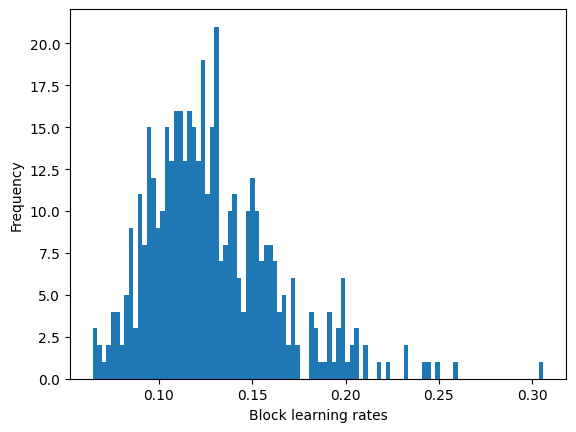

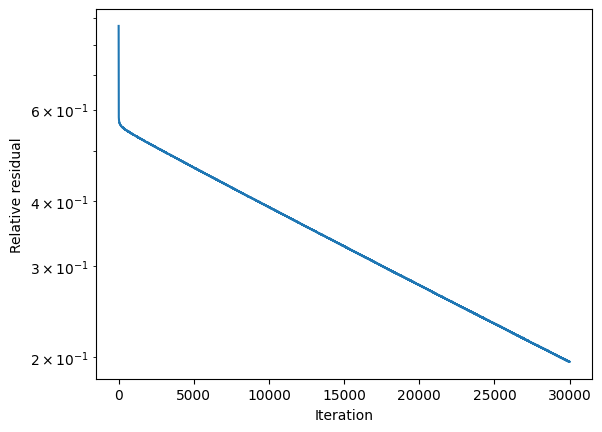

In [16]:
with torch.no_grad():
    a = bcd(x_tr, sigma, b_tr, lambd, a0, B, r, max_iter, device)

In [17]:
# print(loss(K_ij, b_tr, lambd, a))